# Outlook

In this notebook, we will implement the REINFORCE algorithm using BBRL. To understand this code, you need [to know more about BBRL](https://colab.research.google.com/drive/1_yp-JKkxh_P8Yhctulqm0IrLbE41oK1p?usp=sharing):

-  You should first have a look at [the BBRL interaction model](https://colab.research.google.com/drive/1gSdkOBPkIQi_my9TtwJ-qWZQS0b2X7jt?usp=sharing), 

- then [a first true RL example](https://colab.research.google.com/drive/1Ui481r47fNHCQsQfKwdoNEVrEiqAEokh?usp=sharing) 

- and, most importantly, details about the [NoAutoResetGymAgent](https://colab.research.google.com/drive/1EX5O03mmWFp9wCL_Gb_-p08JktfiL2l5?usp=sharing).


The REINFORCE algorithm is explained in a series of 3 videos: [video 1](https://www.youtube.com/watch?v=R7ULMBXOQtE), [video 2](https://www.youtube.com/watch?v=dKUWto9B9WY) and [video 3](https://www.youtube.com/watch?v=GcJ9hl3T6x8). You can also read the corresponding slides: [slides1](http://pages.isir.upmc.fr/~sigaud/teach/ps/3_pg_derivation1.pdf), [slides2](http://pages.isir.upmc.fr/~sigaud/teach/ps/4_pg_derivation2.pdf), [slides3](http://pages.isir.upmc.fr/~sigaud/teach/ps/5_pg_derivation3.pdf).

## Installation and Imports

### Installation

The BBRL library is [here](https://github.com/osigaud/bbrl).

This is OmegaConf that makes it possible that by just defining the `def run_a2c(cfg):` function and then executing a long `params = {...}` variable at the bottom of this colab, the code is run with the parameters without calling an explicit main.

More precisely, the code is run by calling

`config=OmegaConf.create(params)`

`run_a2c(config)`

at the very bottom of the colab, after starting tensorboard.

In [1]:
try:
    from easypip import easyimport
except:
    !pip install easypip
    from easypip import easyimport

import functools
import time

easyimport("importlib_metadata==4.13.0")

OmegaConf = easyimport("omegaconf").OmegaConf
bbrl = easyimport("bbrl")
import gym


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Imports

Below, we import standard python packages, pytorch packages and gym environments.

[OpenAI gym](https://gym.openai.com/) is a collection of benchmark environments to evaluate RL algorithms.

In [2]:
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import gym

from tqdm import tqdm

### BBRL imports

In [3]:
from bbrl.agents.agent import Agent
from bbrl import get_arguments, get_class, instantiate_class

# The workspace is the main class in BBRL, this is where all data is collected and stored
from bbrl.workspace import Workspace

# Agents(agent1,agent2,agent3,...) executes the different agents the one after the other
# TemporalAgent(agent) executes an agent over multiple timesteps in the workspace, 
# or until a given condition is reached
from bbrl.agents import Agents, RemoteAgent, TemporalAgent, PrintAgent

# The NoAutoResetGymAgent is an agent executing a batch of gym environments
# without auto-resetting. These agents produce multiple variables in the workspace: 
# ’env/env_obs’, ’env/reward’, ’env/timestep’, ’env/done’, ’env/initial_state’, ’env/cumulated_reward’, 
# At timestep t>0, these agents will read the ’action’ variable in the workspace at time t − 1
from bbrl.agents.gymb import NoAutoResetGymAgent

## Definition of agents

The [REINFORCE](https://link.springer.com/content/pdf/10.1007/BF00992696.pdf) uses a stochastic policy and a baseline which is the value function. Thus we need an Actor agent, a Critic agent and an Environment agent. 
The actor agent is built on an intermediate ProbAgent, see [this notebook](https://colab.research.google.com/drive/1Ui481r47fNHCQsQfKwdoNEVrEiqAEokh?usp=sharing) for explanations about the  ProbaAgent, the ActorAgent and the environment agent.

 As in [a previous notebook about DQN](https://colab.research.google.com/drive/1raeuB6uUVUpl-4PLArtiAoGnXj0sGjSV?usp=sharing), the neural networks we build are multi-layer perceptrons.

In [4]:
def build_mlp(sizes, activation, output_activation=nn.Identity()):
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j + 1]), act]
    return nn.Sequential(*layers)

In [5]:
class ProbAgent(Agent):
    """Computes the distribution $p(a_t|s_t)$"""
    
    def __init__(self, state_dim, hidden_layers, n_action):
        super().__init__(name="prob_agent")
        self.model = build_mlp(
            [state_dim] + list(hidden_layers) + [n_action], activation=nn.ReLU()
        )

    def forward(self, t, **kwargs):
        # Get $s_t$
        observation = self.get(("env/env_obs", t))
        # Compute the distribution over actions
        scores = self.model(observation)
        action_probs = torch.softmax(scores, dim=-1)
        assert not torch.any(torch.isnan(action_probs)), "NaN Here"
        
        self.set(("action_probs", t), action_probs)
        entropy = torch.distributions.Categorical(action_probs).entropy()
        self.set(("entropy", t), entropy)


In [6]:
class ActorAgent(Agent):
    """Choose an action (either acoording to p(a_t|s_t) when stochastic is true,
       or with argmax if false.
    """
    def __init__(self):
        super().__init__()

    def forward(self, t, stochastic, **kwargs):
        probs = self.get(("action_probs", t))
        if stochastic:
            action = torch.distributions.Categorical(probs).sample()
        else:
            action = probs.argmax(1)

        self.set(("action", t), action)

In [7]:
def make_env(env_name):
    return gym.make(env_name)

### VAgent

The VAgent is a neural network which takes an observation as input and whose output is the value $V(s)$ of this observation.

The `squeeze(-1)` removes the last dimension of the tensor. TODO: explain why we need it

In [8]:
class VAgent(Agent):
    def __init__(self, state_dim, hidden_layers):
        super().__init__()
        self.is_q_function = False
        self.model = build_mlp(
            [state_dim] + list(hidden_layers) + [1], activation=nn.ReLU()
        )

    def forward(self, t, **kwargs):
        observation = self.get(("env/env_obs", t))
        critic = self.model(observation).squeeze(-1)
        self.set(("v_value", t), critic)

### Create the REINFORCE agent

The code below is rather straightforward. Note that we have not defined anything about data collection, using a RolloutBuffer or something to store the n_step return so far. This will come inside the training loop below.

Interestingly, the loop between the policy and the environment is first defined as a collection of agents, and then embedded into a single TemporalAgent.

In [9]:
def create_reinforce_agent(cfg, env_agent):
    obs_size, act_size = env_agent.get_obs_and_actions_sizes()
    proba_agent = ProbAgent(obs_size, cfg.algorithm.architecture.actor_hidden_size, act_size)
    action_agent = ActorAgent()
    # print_agent = PrintAgent()
    tr_agent = Agents(env_agent, proba_agent, action_agent)  # , print_agent)

    critic_agent = TemporalAgent(
        VAgent(obs_size, cfg.algorithm.architecture.critic_hidden_size)
    )

    # Get an agent that is executed on a complete workspace
    train_agent = TemporalAgent(tr_agent)
    train_agent.seed(cfg.algorithm.seed)
    return train_agent, proba_agent, critic_agent  # , print_agent

### The Logger class

The logger class below is not generic, it is specifically designed in the context of this A2C colab.

The logger parameters are defined below in `params = { "logger":{ ...`

In this colab, the logger is defined as `bbrl.utils.logger.TFLogger` so as to use a tensorboard visualisation (see the parameters part below).
Note that the salina Logger is also saving the log in a readable format such that you can use `Logger.read_directories(...)` to read multiple logs, create a dataframe, and analyze many experiments afterward in a notebook for instance. 

The code for the different kinds of loggers is available in the [bbrl/utils/logger.py](https://github.com/osigaud/bbrl/blob/master/bbrl/utils/logger.py) file.

Having logging provided under the hood is one of the features where using RL libraries like BBRL will allow you to save time.

`instantiate_class` is an inner BBRL mechanism. The `instantiate_class` function is available in the [`bbrl/__init__.py`](https://github.com/osigaud/bbrl/blob/master/bbrl/__init__.py) file.

In [10]:
class Logger():
    def __init__(self, cfg):
        self.logger = instantiate_class(cfg.logger)

    def add_log(self, log_string, loss, epoch):
        self.logger.add_scalar(log_string, loss.item(), epoch)

      # Log losses
    def log_losses(self, epoch, critic_loss, actor_loss):
        self.add_log("critic_loss", critic_loss, epoch)
        self.add_log("actor_loss", actor_loss, epoch)


### Setup the optimizer

We use a single optimizer to tune the parameters of the actor (in the prob_agent part) and the critic (in the critic_agent part). It would be possible to have two optimizers which would work separately on the parameters of each component agent, but it would be more complicated because updating the actor requires the gradient of the critic.

In [11]:
# Configure the optimizer over the a2c agent
def setup_optimizer(cfg, prob_agent, critic_agent):
    optimizer_args = get_arguments(cfg.optimizer)
    parameters = nn.Sequential(prob_agent, critic_agent).parameters()
    optimizer = get_class(cfg.optimizer)(parameters, **optimizer_args)
    return optimizer

### Compute critic loss

Note the `critic[1:].detach()` in the computation of the temporal difference target. The idea is that we compute this target as a function of $V(s_{t+1})$, but we do not want to apply gradient descent on this $V(s_{t+1})$, we will only apply gradient descent to the $V(s_t)$ according to this target value.

In practice, `x.detach()` detaches a computation graph from a tensor, so it avoids computing a gradient over this tensor.

Note also the trick to deal with terminal states. If the state is terminal, $V(s_{t+1})$ does not make sense. Thus we need to ignore this term. So we multiply the term by `must_bootstrap`: if `must_bootstrap` is True (converted into an int, it becomes a 1), we get the term. If `must_bootstrap` is False (=0), we are at a terminal state, so we ignore the term. This trick is used in many RL libraries, e.g. SB3.

In [12]:
def compute_critic_loss(cfg, reward, must_bootstrap, critic):
    # Compute temporal difference
    target = reward[:-1] + cfg.algorithm.discount_factor * critic[1:].detach() * must_bootstrap[1:].int()
    td = (target - critic[:-1]) * must_bootstrap[1:].int()

    # Compute critic loss
    td_error = td ** 2
    critic_loss = td_error.mean()
    return critic_loss, td

## Main training loop

### First algorithm: summing all the rewards along an episode

The most basic variant of the Policy Gradient algorithms just sums all the rewards along an episode.

This is implemented with the `apply_sum` function below.

In [13]:
def apply_sum(cfg, reward, v_value):
    reward_sum = reward.sum(axis=0)
    for i in range(len(reward)):
        reward[i] = reward_sum
    return reward

### Main loop

Note that we `optimizer.zero_grad()`, `loss.backward()` and `optimizer.step()` lines. Several things need to be explained here.
- `optimizer.zero_grad()` is necessary to cancel all the gradients computed at the previous iterations
- note that we sum all the losses, both for the critic and the actor, before applying back-propagation with `loss.backward()`. At first glance, summing these losses may look weird, as the actor and the critic receive different updates with different parts of the loss. This mechanism relies on the central property of tensor manipulation libraries like TensorFlow and pytorch. In pytorch, each loss tensor comes with its own graph of computation for back-propagating the gradient, in such a way that when you back-propagate the loss, the adequate part of the loss is applied to the adequate parameters.
These mechanisms are partly explained [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html).
- since the optimizer has been set to work with both the actor and critic parameters, `optimizer.step()` will optimize both agents and pytorch ensure that each will receive its own part of the gradient.

In [14]:
# from sys import stderr
def run_reinforce(cfg, *, compute_reward=apply_sum, compute_critic_loss=compute_critic_loss):
    """Run Reinforce
    
    :param compute_reward: 
        The function called to compute the reward 
        for Reinforve at each time step (default to apply_sum)
        
    :param compute_critic_loss: 
        Function that specifies how to compute the critic loss
    """
    logger = Logger(cfg)
    best_reward = -10e10

    # 2) Create the environment agent
    env_agent = NoAutoResetGymAgent(
        get_class(cfg.gym_env),
        get_arguments(cfg.gym_env),
        cfg.algorithm.n_envs,
        cfg.algorithm.seed,
    )

    reinforce_agent, proba_agent, critic_agent = create_reinforce_agent(cfg, env_agent)

    # 7) Configure the optimizer over the a2c agent
    optimizer = setup_optimizer(cfg, reinforce_agent, critic_agent)

    # 8) Training loop
    nb_steps = 0

    # liste mean et std
    l_mean = []
    l_std = []

    for episode in tqdm(range(cfg.algorithm.nb_episodes)):
        # print_agent.reset()
        # Execute the agent on the workspace to sample complete episodes
        # Since not all the variables of workspace will be overwritten, it is better to clear the workspace
        # Configure the workspace to the right dimension.
        train_workspace = Workspace()

        reinforce_agent(train_workspace, stochastic=True, t=0, stop_variable="env/done")

        # Get relevant tensors (size are timestep x n_envs x ....)
        obs, done, truncated, action_probs, reward, action = train_workspace[
            "env/env_obs",
            "env/done",
            "env/truncated",
            "action_probs",
            "env/reward",
            "action",
        ]
        critic_agent(train_workspace, stop_variable="env/done")
        v_value = train_workspace["v_value"]

        for i in range(cfg.algorithm.n_envs):
            nb_steps += len(action[:, i])

        # Determines whether values of the critic should be propagated
        # True if the episode reached a time limit or if the task was not done
        # See https://colab.research.google.com/drive/1W9Y-3fa6LsPeR6cBC1vgwBjKfgMwZvP5?usp=sharing
        must_bootstrap = torch.logical_or(~done, truncated)

        critic_loss, td = compute_critic_loss(cfg, reward, must_bootstrap, v_value)

        reward = compute_reward(cfg, reward, v_value)

        # Take the log probability of the actions performed
        action = action.unsqueeze(-1)
        action_logp = torch.gather(action_probs.squeeze(), dim=-1, index=action).squeeze().log()
        
        # Compute the policy gradient loss based on the log probability of the actions performed
        actor_loss = action_logp * reward.detach() * must_bootstrap.int()
        actor_loss = actor_loss.mean()

        # Log losses
        logger.log_losses(nb_steps, critic_loss, actor_loss)

        loss = (
            cfg.algorithm.critic_coef * critic_loss
            - cfg.algorithm.actor_coef * actor_loss
        )


        # Compute the cumulated reward on final_state
        cumulated_reward = train_workspace["env/cumulated_reward"][-1]
        mean = cumulated_reward.mean()
        std = cumulated_reward.std()
        l_mean.append(mean)
        l_std.append(std)
        
        print(f"episode: {episode}, reward: {mean}, std: {std}")
        logger.add_log("reward", mean, nb_steps)
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return l_mean, l_std


## Definition of the parameters

The logger is defined as `bbrl.utils.logger.TFLogger` so as to use a tensorboard visualisation.

In [16]:
params={
    "save_best": False,
  # Set to true to have an insight on the learned policy
  # (but slows down the evaluation a lot!)
  "plot_agents": True,
  "logger":{
    "classname": "bbrl.utils.logger.TFLogger",
    "log_dir": "./tblogs/reinforce-" + str(time.time()),
    "cache_size": 10000,
    "every_n_seconds": 10,
    "verbose": False,    
    },

  "algorithm":{
    "seed": 1,
    "n_envs": 8,
    "nb_episodes": 1000,
    "discount_factor": 0.95,
    "critic_coef": 1.0,
    "actor_coef": 1.0,
    "architecture":{
        "actor_hidden_size": [16,16],
        "critic_hidden_size": [16,16],
    },
  },

  "gym_env":{
    "classname": "__main__.make_env",
    "env_name": "CartPole-v1",
  },
  "optimizer":
  {
    "classname": "torch.optim.Adam",
    "lr": 0.001,
  }
}



### Launching tensorboard to visualize the results

In [ ]:
# # For Colab - otherwise, it is easier and better to launch tensorboard from
# # the terminal
# if get_ipython().__class__.__module__ == "google.colab._shell":
#     %load_ext tensorboard
#     %tensorboard --logdir ./tmp
# else:
#     import sys
#     import os
#     import os.path as osp
#     print(f'''Launch tensorboard from the shell:\n{osp.dirname(sys.executable)}/tensorboard --logdir="{os.getcwd()}/tblogs"''')

In [17]:
config=OmegaConf.create(params)
torch.manual_seed(config.algorithm.seed)
mean1, std1 = run_reinforce(config)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
  0%|          | 1/1000 [00:00<06:25,  2.59it/s]

episode: 0, reward: 21.0, std: 11.161157608032227


  0%|          | 3/1000 [00:00<03:11,  5.22it/s]

episode: 1, reward: 24.875, std: 13.097846031188965
episode: 2, reward: 22.5, std: 23.904571533203125


  0%|          | 5/1000 [00:00<02:07,  7.81it/s]

episode: 3, reward: 17.25, std: 5.203021049499512
episode: 4, reward: 24.875, std: 9.171968460083008
episode: 5, reward: 24.5, std: 9.426406860351562


  1%|          | 7/1000 [00:01<02:04,  8.00it/s]

episode: 6, reward: 24.25, std: 14.906853675842285
episode: 7, reward: 17.5, std: 4.840306758880615


  1%|          | 11/1000 [00:01<01:42,  9.60it/s]

episode: 8, reward: 26.75, std: 15.872258186340332
episode: 9, reward: 21.5, std: 9.957050323486328
episode: 10, reward: 23.25, std: 8.827715873718262


  1%|▏         | 13/1000 [00:01<01:48,  9.10it/s]

episode: 11, reward: 27.5, std: 14.55040454864502
episode: 12, reward: 24.25, std: 11.732129096984863


  1%|▏         | 14/1000 [00:01<01:59,  8.23it/s]

episode: 13, reward: 29.625, std: 20.127717971801758
episode: 14, reward: 20.75, std: 6.204836845397949


  2%|▏         | 16/1000 [00:02<01:54,  8.59it/s]

episode: 15, reward: 30.5, std: 22.51348876953125
episode: 16, reward: 14.875, std: 4.882549285888672
episode: 17, reward: 23.125, std: 14.376940727233887


  2%|▏         | 21/1000 [00:02<01:31, 10.71it/s]

episode: 18, reward: 24.375, std: 12.82784366607666
episode: 19, reward: 18.625, std: 8.601286888122559
episode: 20, reward: 16.375, std: 5.604526042938232


  2%|▏         | 23/1000 [00:02<01:28, 11.04it/s]

episode: 21, reward: 21.375, std: 7.872873783111572
episode: 22, reward: 20.625, std: 8.279708862304688
episode: 23, reward: 19.75, std: 7.759786605834961


  3%|▎         | 27/1000 [00:02<01:23, 11.64it/s]

episode: 24, reward: 14.875, std: 4.70372200012207
episode: 25, reward: 23.5, std: 12.906255722045898
episode: 26, reward: 17.25, std: 5.063877582550049


  3%|▎         | 29/1000 [00:03<01:30, 10.72it/s]

episode: 27, reward: 20.0, std: 4.810702323913574
episode: 28, reward: 30.75, std: 13.666956901550293


  3%|▎         | 31/1000 [00:03<01:30, 10.65it/s]

episode: 29, reward: 23.125, std: 9.463274955749512
episode: 30, reward: 26.125, std: 8.692155838012695
episode: 31, reward: 19.5, std: 7.63450813293457


  3%|▎         | 33/1000 [00:03<01:23, 11.53it/s]

episode: 32, reward: 17.125, std: 5.743008136749268
episode: 33, reward: 16.5, std: 6.141195774078369


  4%|▎         | 35/1000 [00:03<01:34, 10.22it/s]

episode: 34, reward: 30.25, std: 22.78940773010254
episode: 35, reward: 26.625, std: 13.004806518554688


  4%|▍         | 38/1000 [00:04<01:54,  8.43it/s]

episode: 36, reward: 26.625, std: 22.620708465576172
episode: 37, reward: 29.625, std: 15.702024459838867


  4%|▍         | 41/1000 [00:04<01:43,  9.23it/s]

episode: 38, reward: 23.0, std: 17.95231819152832
episode: 39, reward: 21.75, std: 11.067972183227539
episode: 40, reward: 20.5, std: 7.50238037109375


  4%|▍         | 43/1000 [00:04<01:52,  8.53it/s]

episode: 41, reward: 24.625, std: 16.834806442260742
episode: 42, reward: 27.125, std: 14.652523040771484


  4%|▍         | 45/1000 [00:04<01:36,  9.93it/s]

episode: 43, reward: 18.5, std: 7.25061559677124
episode: 44, reward: 22.25, std: 7.905694007873535
episode: 45, reward: 22.25, std: 11.119481086730957


  5%|▍         | 47/1000 [00:05<01:29, 10.66it/s]

episode: 46, reward: 18.75, std: 4.891684055328369
episode: 47, reward: 28.875, std: 18.909086227416992


  5%|▌         | 50/1000 [00:05<01:46,  8.93it/s]

episode: 48, reward: 22.5, std: 9.797959327697754
episode: 49, reward: 33.875, std: 20.22330665588379


  5%|▌         | 53/1000 [00:05<01:29, 10.60it/s]

episode: 50, reward: 30.0, std: 11.807987213134766
episode: 51, reward: 18.25, std: 3.3700361251831055
episode: 52, reward: 23.625, std: 8.551315307617188


  6%|▌         | 55/1000 [00:05<01:24, 11.22it/s]

episode: 53, reward: 21.875, std: 8.219098091125488
episode: 54, reward: 21.125, std: 8.23646068572998
episode: 55, reward: 22.75, std: 13.925824165344238


  6%|▌         | 57/1000 [00:06<01:26, 10.93it/s]

episode: 56, reward: 21.5, std: 9.841602325439453
episode: 57, reward: 27.375, std: 18.345396041870117


  6%|▌         | 59/1000 [00:06<01:31, 10.28it/s]

episode: 58, reward: 21.125, std: 8.04340934753418
episode: 59, reward: 19.25, std: 9.881440162658691
episode: 60, reward: 24.25, std: 14.973786354064941


  6%|▋         | 63/1000 [00:06<01:40,  9.36it/s]

episode: 61, reward: 31.375, std: 20.95530891418457
episode: 62, reward: 22.875, std: 8.659222602844238
episode: 63, reward: 18.125, std: 4.673252105712891


  6%|▋         | 65/1000 [00:07<01:47,  8.73it/s]

episode: 64, reward: 32.0, std: 29.529645919799805
episode: 65, reward: 20.875, std: 7.510706424713135


  7%|▋         | 68/1000 [00:07<01:46,  8.78it/s]

episode: 66, reward: 27.25, std: 13.435029029846191
episode: 67, reward: 24.0, std: 14.422204971313477


  7%|▋         | 70/1000 [00:07<01:45,  8.80it/s]

episode: 68, reward: 26.375, std: 11.287635803222656
episode: 69, reward: 27.875, std: 12.483560562133789


  7%|▋         | 71/1000 [00:07<01:42,  9.03it/s]

episode: 70, reward: 21.25, std: 13.519826889038086
episode: 71, reward: 24.0, std: 8.83176040649414
episode: 72, reward: 26.625, std: 14.618359565734863


  7%|▋         | 74/1000 [00:07<01:38,  9.37it/s]

episode: 73, reward: 25.375, std: 9.148574829101562
episode: 74, reward: 22.0, std: 10.928338050842285
episode: 75, reward: 22.0, std: 10.239977836608887


  8%|▊         | 77/1000 [00:08<01:36,  9.56it/s]

episode: 76, reward: 20.25, std: 12.314335823059082
episode: 77, reward: 24.25, std: 9.602827072143555
episode: 78, reward: 27.125, std: 12.60881233215332


  8%|▊         | 81/1000 [00:08<01:33,  9.79it/s]

episode: 79, reward: 20.75, std: 10.793516159057617
episode: 80, reward: 24.625, std: 15.692923545837402


  8%|▊         | 84/1000 [00:09<01:35,  9.62it/s]

episode: 81, reward: 32.375, std: 26.69369888305664
episode: 82, reward: 20.125, std: 9.701804161071777
episode: 83, reward: 19.875, std: 9.448166847229004


  9%|▊         | 86/1000 [00:09<01:38,  9.24it/s]

episode: 84, reward: 23.875, std: 15.412773132324219
episode: 85, reward: 27.875, std: 13.141401290893555


  9%|▉         | 88/1000 [00:09<01:54,  7.94it/s]

episode: 86, reward: 25.625, std: 13.835125923156738
episode: 87, reward: 31.125, std: 18.47343635559082


  9%|▉         | 91/1000 [00:09<01:38,  9.25it/s]

episode: 88, reward: 20.625, std: 8.517838478088379
episode: 89, reward: 22.375, std: 7.366672039031982
episode: 90, reward: 22.625, std: 14.37197208404541


  9%|▉         | 92/1000 [00:09<01:39,  9.08it/s]

episode: 91, reward: 17.25, std: 11.523268699645996
episode: 92, reward: 27.0, std: 11.674147605895996
episode: 93, reward: 19.375, std: 7.9988837242126465


 10%|▉         | 95/1000 [00:10<01:50,  8.18it/s]

episode: 94, reward: 32.375, std: 18.905309677124023


 10%|▉         | 97/1000 [00:10<02:13,  6.79it/s]

episode: 95, reward: 38.875, std: 27.81796646118164
episode: 96, reward: 27.25, std: 18.10879898071289


 10%|▉         | 99/1000 [00:10<02:02,  7.34it/s]

episode: 97, reward: 29.5, std: 20.605131149291992
episode: 98, reward: 28.75, std: 12.068258285522461


 10%|█         | 100/1000 [00:11<02:00,  7.44it/s]

episode: 99, reward: 25.75, std: 17.556032180786133
episode: 100, reward: 21.875, std: 8.675704956054688
episode: 101, reward: 24.875, std: 11.469680786132812


 10%|█         | 104/1000 [00:11<01:38,  9.09it/s]

episode: 102, reward: 24.75, std: 7.206148147583008
episode: 103, reward: 23.0, std: 12.783918380737305


 11%|█         | 106/1000 [00:11<01:47,  8.33it/s]

episode: 104, reward: 28.625, std: 18.615949630737305
episode: 105, reward: 24.125, std: 16.736934661865234


 11%|█         | 108/1000 [00:12<01:51,  7.98it/s]

episode: 106, reward: 21.75, std: 9.765098571777344
episode: 107, reward: 32.125, std: 23.326486587524414


 11%|█         | 110/1000 [00:12<02:15,  6.58it/s]

episode: 108, reward: 39.375, std: 36.590152740478516
episode: 109, reward: 32.125, std: 15.179286003112793


 11%|█         | 111/1000 [00:12<02:04,  7.14it/s]

episode: 110, reward: 25.25, std: 12.623673439025879
episode: 111, reward: 18.0, std: 6.546536922454834


 11%|█▏        | 113/1000 [00:12<02:03,  7.18it/s]

episode: 112, reward: 35.25, std: 31.249000549316406
episode: 113, reward: 27.25, std: 6.1586174964904785


 12%|█▏        | 117/1000 [00:13<01:44,  8.44it/s]

episode: 114, reward: 35.5, std: 25.269969940185547
episode: 115, reward: 19.625, std: 5.3435540199279785
episode: 116, reward: 21.75, std: 9.238892555236816


 12%|█▏        | 119/1000 [00:13<01:44,  8.44it/s]

episode: 117, reward: 28.5, std: 12.328827857971191
episode: 118, reward: 25.625, std: 12.199971199035645


 12%|█▏        | 120/1000 [00:13<01:42,  8.59it/s]

episode: 119, reward: 30.25, std: 11.106626510620117
episode: 120, reward: 21.125, std: 9.140764236450195
episode: 121, reward: 25.375, std: 13.25505256652832


 12%|█▏        | 124/1000 [00:14<01:38,  8.89it/s]

episode: 122, reward: 29.5, std: 16.053482055664062
episode: 123, reward: 26.875, std: 14.095972061157227


 12%|█▎        | 125/1000 [00:14<01:36,  9.08it/s]

episode: 124, reward: 23.0, std: 10.663689613342285
episode: 125, reward: 20.5, std: 9.471762657165527


 13%|█▎        | 127/1000 [00:14<01:38,  8.84it/s]

episode: 126, reward: 34.5, std: 16.843820571899414
episode: 127, reward: 20.875, std: 8.887189865112305


 13%|█▎        | 130/1000 [00:14<01:40,  8.69it/s]

episode: 128, reward: 27.875, std: 18.856128692626953
episode: 129, reward: 22.25, std: 15.618212699890137


 13%|█▎        | 132/1000 [00:14<01:43,  8.40it/s]

episode: 130, reward: 32.5, std: 18.28348159790039
episode: 131, reward: 24.25, std: 7.851296424865723


 13%|█▎        | 133/1000 [00:15<01:47,  8.09it/s]

episode: 132, reward: 28.25, std: 14.557766914367676
episode: 133, reward: 19.25, std: 6.606274127960205


 14%|█▎        | 136/1000 [00:15<01:50,  7.81it/s]

episode: 134, reward: 32.5, std: 28.505638122558594
episode: 135, reward: 25.25, std: 13.853828430175781


 14%|█▍        | 138/1000 [00:15<01:46,  8.06it/s]

episode: 136, reward: 29.625, std: 15.371006965637207
episode: 137, reward: 22.25, std: 12.209481239318848


 14%|█▍        | 141/1000 [00:16<01:26,  9.89it/s]

episode: 138, reward: 26.0, std: 12.795088768005371
episode: 139, reward: 22.125, std: 8.25378704071045
episode: 140, reward: 16.625, std: 5.998511791229248


 14%|█▍        | 142/1000 [00:16<01:47,  8.01it/s]

episode: 141, reward: 36.625, std: 29.640403747558594
episode: 142, reward: 18.0, std: 5.781744480133057
episode: 143, reward: 27.375, std: 13.25505256652832


 14%|█▍        | 145/1000 [00:16<01:44,  8.21it/s]

episode: 144, reward: 32.625, std: 18.023298263549805
episode: 145, reward: 22.375, std: 7.029275417327881


 15%|█▍        | 147/1000 [00:16<01:45,  8.07it/s]

episode: 146, reward: 35.875, std: 26.068248748779297
episode: 147, reward: 24.375, std: 9.767840385437012


 15%|█▍        | 149/1000 [00:17<01:43,  8.26it/s]

episode: 148, reward: 27.0, std: 17.66352081298828
episode: 149, reward: 21.25, std: 6.67083215713501


 15%|█▌        | 151/1000 [00:17<01:36,  8.76it/s]

episode: 150, reward: 22.5, std: 9.576757431030273


 15%|█▌        | 152/1000 [00:17<01:54,  7.37it/s]

episode: 151, reward: 34.25, std: 26.95896339416504


 15%|█▌        | 153/1000 [00:17<02:14,  6.30it/s]

episode: 152, reward: 35.375, std: 30.612497329711914


 16%|█▌        | 155/1000 [00:18<02:13,  6.35it/s]

episode: 153, reward: 41.875, std: 27.325746536254883
episode: 154, reward: 24.0, std: 11.820079803466797


 16%|█▌        | 157/1000 [00:18<01:58,  7.12it/s]

episode: 155, reward: 26.125, std: 14.554699897766113
episode: 156, reward: 20.5, std: 8.83176040649414
episode: 157, reward: 16.0, std: 5.830951690673828


 16%|█▌        | 160/1000 [00:18<01:45,  7.95it/s]

episode: 158, reward: 31.75, std: 20.5200252532959
episode: 159, reward: 26.0, std: 15.565529823303223


 16%|█▌        | 162/1000 [00:18<01:40,  8.35it/s]

episode: 160, reward: 27.75, std: 10.292160987854004
episode: 161, reward: 28.25, std: 13.843513488769531


 16%|█▋        | 163/1000 [00:19<01:53,  7.40it/s]

episode: 162, reward: 29.375, std: 21.790807723999023
episode: 163, reward: 23.75, std: 8.084376335144043


 17%|█▋        | 166/1000 [00:19<01:54,  7.27it/s]

episode: 164, reward: 30.5, std: 26.87537384033203
episode: 165, reward: 30.375, std: 19.033334732055664


 17%|█▋        | 167/1000 [00:19<01:47,  7.75it/s]

episode: 166, reward: 26.5, std: 10.677078247070312
episode: 167, reward: 18.75, std: 3.918818950653076
episode: 168, reward: 23.125, std: 16.22553062438965


 17%|█▋        | 171/1000 [00:19<01:38,  8.45it/s]

episode: 169, reward: 36.5, std: 19.018787384033203
episode: 170, reward: 27.5, std: 11.19948959350586


 17%|█▋        | 173/1000 [00:20<01:32,  8.93it/s]

episode: 171, reward: 25.625, std: 8.551315307617188
episode: 172, reward: 23.375, std: 10.126873970031738


 18%|█▊        | 175/1000 [00:20<01:54,  7.20it/s]

episode: 173, reward: 35.75, std: 24.62141990661621
episode: 174, reward: 44.5, std: 13.669569969177246


 18%|█▊        | 176/1000 [00:20<01:54,  7.17it/s]

episode: 175, reward: 32.5, std: 15.118578910827637
episode: 176, reward: 22.875, std: 8.74132251739502


 18%|█▊        | 179/1000 [00:21<01:51,  7.35it/s]

episode: 177, reward: 24.125, std: 15.615354537963867
episode: 178, reward: 32.75, std: 21.737064361572266


 18%|█▊        | 181/1000 [00:21<01:50,  7.42it/s]

episode: 179, reward: 22.5, std: 8.684962272644043
episode: 180, reward: 33.0, std: 21.138996124267578


 18%|█▊        | 183/1000 [00:21<01:46,  7.65it/s]

episode: 181, reward: 28.375, std: 16.74120330810547
episode: 182, reward: 26.5, std: 10.889050483703613


 18%|█▊        | 184/1000 [00:21<01:45,  7.74it/s]

episode: 183, reward: 25.375, std: 9.84069538116455
episode: 184, reward: 22.75, std: 8.697290420532227
episode: 185, reward: 22.875, std: 9.6575288772583


 19%|█▉        | 188/1000 [00:22<01:47,  7.57it/s]

episode: 186, reward: 36.625, std: 25.678993225097656
episode: 187, reward: 25.875, std: 11.519393920898438


 19%|█▉        | 190/1000 [00:22<01:39,  8.11it/s]

episode: 188, reward: 23.5, std: 13.617216110229492
episode: 189, reward: 28.25, std: 12.429802894592285


 19%|█▉        | 192/1000 [00:22<02:01,  6.66it/s]

episode: 190, reward: 34.25, std: 25.633403778076172
episode: 191, reward: 36.75, std: 21.89422607421875


 19%|█▉        | 194/1000 [00:23<02:08,  6.26it/s]

episode: 192, reward: 28.125, std: 21.7415828704834
episode: 193, reward: 27.625, std: 14.946929931640625


 20%|█▉        | 196/1000 [00:23<02:08,  6.23it/s]

episode: 194, reward: 37.625, std: 28.670230865478516
episode: 195, reward: 24.25, std: 11.247221946716309


 20%|█▉        | 197/1000 [00:23<02:18,  5.81it/s]

episode: 196, reward: 31.0, std: 24.377975463867188


 20%|█▉        | 198/1000 [00:23<02:36,  5.12it/s]

episode: 197, reward: 44.25, std: 26.740819931030273
episode: 198, reward: 32.125, std: 24.89657211303711


 20%|██        | 200/1000 [00:24<02:18,  5.76it/s]

episode: 199, reward: 32.25, std: 16.175378799438477
episode: 200, reward: 22.125, std: 6.749338626861572


 20%|██        | 203/1000 [00:24<02:04,  6.40it/s]

episode: 201, reward: 34.125, std: 26.02985954284668
episode: 202, reward: 35.75, std: 18.013883590698242


 20%|██        | 205/1000 [00:24<01:59,  6.66it/s]

episode: 203, reward: 32.75, std: 20.478212356567383
episode: 204, reward: 27.625, std: 15.482132911682129


 21%|██        | 206/1000 [00:25<01:53,  6.99it/s]

episode: 205, reward: 28.375, std: 14.13139820098877


 21%|██        | 208/1000 [00:25<02:09,  6.09it/s]

episode: 206, reward: 38.25, std: 33.58039474487305
episode: 207, reward: 28.75, std: 14.370107650756836


 21%|██        | 210/1000 [00:25<02:06,  6.26it/s]

episode: 208, reward: 34.75, std: 19.761072158813477
episode: 209, reward: 34.125, std: 19.25347900390625


 21%|██        | 212/1000 [00:26<01:54,  6.90it/s]

episode: 210, reward: 28.75, std: 16.97687530517578
episode: 211, reward: 28.25, std: 12.702643394470215


 21%|██▏       | 214/1000 [00:26<02:00,  6.50it/s]

episode: 212, reward: 27.125, std: 21.37045669555664
episode: 213, reward: 26.25, std: 20.17601203918457


 22%|██▏       | 216/1000 [00:26<01:52,  6.98it/s]

episode: 214, reward: 23.0, std: 10.928338050842285
episode: 215, reward: 22.625, std: 19.617321014404297


 22%|██▏       | 218/1000 [00:26<01:47,  7.28it/s]

episode: 216, reward: 25.25, std: 10.498299598693848
episode: 217, reward: 32.125, std: 17.731630325317383


 22%|██▏       | 220/1000 [00:27<01:38,  7.91it/s]

episode: 218, reward: 24.5, std: 13.03840446472168
episode: 219, reward: 27.625, std: 15.990510940551758


 22%|██▏       | 221/1000 [00:27<01:37,  7.95it/s]

episode: 220, reward: 31.375, std: 13.468879699707031


 22%|██▏       | 222/1000 [00:27<02:14,  5.79it/s]

episode: 221, reward: 51.0, std: 41.66876220703125
episode: 222, reward: 16.625, std: 4.033343315124512


 22%|██▏       | 224/1000 [00:27<01:56,  6.68it/s]

episode: 223, reward: 49.0, std: 19.420166015625
episode: 224, reward: 39.875, std: 25.547924041748047


 23%|██▎       | 226/1000 [00:28<01:54,  6.78it/s]

episode: 225, reward: 25.875, std: 9.264948844909668
episode: 226, reward: 21.25, std: 8.44731616973877


 23%|██▎       | 229/1000 [00:28<01:48,  7.11it/s]

episode: 227, reward: 29.5, std: 18.951065063476562
episode: 228, reward: 32.75, std: 17.16100311279297


 23%|██▎       | 231/1000 [00:28<01:50,  6.93it/s]

episode: 229, reward: 27.25, std: 12.969744682312012
episode: 230, reward: 36.75, std: 20.844663619995117


 23%|██▎       | 233/1000 [00:29<01:52,  6.80it/s]

episode: 231, reward: 32.875, std: 17.199979782104492
episode: 232, reward: 36.75, std: 25.268556594848633


 24%|██▎       | 235/1000 [00:29<01:59,  6.40it/s]

episode: 233, reward: 35.5, std: 26.677974700927734
episode: 234, reward: 37.5, std: 17.029386520385742


 24%|██▎       | 236/1000 [00:29<02:05,  6.09it/s]

episode: 235, reward: 39.5, std: 24.26637840270996
episode: 236, reward: 26.375, std: 9.679691314697266


 24%|██▍       | 238/1000 [00:29<01:44,  7.30it/s]

episode: 237, reward: 24.875, std: 10.855380058288574
episode: 238, reward: 22.75, std: 9.735795974731445


 24%|██▍       | 240/1000 [00:30<01:35,  7.94it/s]

episode: 239, reward: 30.75, std: 12.221176147460938
episode: 240, reward: 21.625, std: 7.6892781257629395


 24%|██▍       | 242/1000 [00:30<01:36,  7.86it/s]

episode: 241, reward: 39.75, std: 19.7393741607666
episode: 242, reward: 23.25, std: 8.647872924804688


 24%|██▍       | 245/1000 [00:30<01:39,  7.58it/s]

episode: 243, reward: 35.125, std: 22.093551635742188
episode: 244, reward: 31.5, std: 17.56620216369629


 25%|██▍       | 246/1000 [00:31<02:08,  5.86it/s]

episode: 245, reward: 48.75, std: 33.68233871459961


 25%|██▍       | 247/1000 [00:31<02:16,  5.53it/s]

episode: 246, reward: 40.0, std: 22.328712463378906
episode: 247, reward: 40.875, std: 21.141952514648438


 25%|██▌       | 250/1000 [00:31<01:53,  6.59it/s]

episode: 248, reward: 20.25, std: 11.719945907592773
episode: 249, reward: 29.75, std: 14.945137977600098


 25%|██▌       | 251/1000 [00:31<01:52,  6.66it/s]

episode: 250, reward: 30.875, std: 16.753997802734375


 25%|██▌       | 252/1000 [00:32<02:07,  5.88it/s]

episode: 251, reward: 37.625, std: 26.880355834960938
episode: 252, reward: 36.875, std: 20.87676429748535


 25%|██▌       | 254/1000 [00:32<02:08,  5.79it/s]

episode: 253, reward: 42.0, std: 19.316905975341797
episode: 254, reward: 36.875, std: 32.54639434814453


 26%|██▌       | 257/1000 [00:32<02:05,  5.93it/s]

episode: 255, reward: 34.5, std: 25.048524856567383
episode: 256, reward: 33.5, std: 13.244945526123047


 26%|██▌       | 258/1000 [00:33<01:55,  6.40it/s]

episode: 257, reward: 25.75, std: 12.81461238861084
episode: 258, reward: 31.5, std: 23.293163299560547


 26%|██▌       | 260/1000 [00:33<01:55,  6.42it/s]

episode: 259, reward: 30.625, std: 12.557723999023438
episode: 260, reward: 41.0, std: 21.071308135986328


 26%|██▌       | 262/1000 [00:33<02:10,  5.65it/s]

episode: 261, reward: 37.5, std: 26.870058059692383


 26%|██▋       | 263/1000 [00:33<02:21,  5.20it/s]

episode: 262, reward: 45.125, std: 19.526081085205078
episode: 263, reward: 27.375, std: 19.21262550354004


 27%|██▋       | 266/1000 [00:34<01:56,  6.29it/s]

episode: 264, reward: 29.125, std: 18.457963943481445
episode: 265, reward: 25.375, std: 7.190022945404053
episode: 266, reward: 18.125, std: 4.486089706420898


 27%|██▋       | 268/1000 [00:34<01:46,  6.86it/s]

episode: 267, reward: 33.875, std: 19.275724411010742
episode: 268, reward: 38.0, std: 19.033803939819336


 27%|██▋       | 271/1000 [00:35<01:49,  6.64it/s]

episode: 269, reward: 22.875, std: 10.315556526184082
episode: 270, reward: 40.25, std: 18.668153762817383


 27%|██▋       | 273/1000 [00:35<01:54,  6.37it/s]

episode: 271, reward: 33.625, std: 18.897750854492188
episode: 272, reward: 38.875, std: 19.496793746948242


 28%|██▊       | 275/1000 [00:35<01:38,  7.33it/s]

episode: 273, reward: 29.5, std: 12.569805145263672
episode: 274, reward: 25.375, std: 8.348438262939453


 28%|██▊       | 277/1000 [00:36<01:40,  7.21it/s]

episode: 275, reward: 35.0, std: 23.585710525512695
episode: 276, reward: 29.625, std: 11.249603271484375


 28%|██▊       | 278/1000 [00:36<01:44,  6.90it/s]

episode: 277, reward: 30.5, std: 23.18866729736328


 28%|██▊       | 280/1000 [00:36<01:52,  6.40it/s]

episode: 278, reward: 34.75, std: 28.87782096862793
episode: 279, reward: 29.75, std: 13.708703994750977


 28%|██▊       | 281/1000 [00:36<01:53,  6.34it/s]

episode: 280, reward: 38.0, std: 19.697715759277344
episode: 281, reward: 24.625, std: 10.405183792114258


 28%|██▊       | 283/1000 [00:36<01:46,  6.76it/s]

episode: 282, reward: 36.5, std: 23.058931350708008


 28%|██▊       | 284/1000 [00:37<02:17,  5.19it/s]

episode: 283, reward: 48.375, std: 53.49749755859375
episode: 284, reward: 26.5, std: 6.546536922454834


 29%|██▊       | 287/1000 [00:37<01:49,  6.49it/s]

episode: 285, reward: 31.375, std: 18.45409393310547
episode: 286, reward: 27.25, std: 13.853828430175781


 29%|██▉       | 289/1000 [00:37<01:52,  6.31it/s]

episode: 287, reward: 33.75, std: 12.091910362243652
episode: 288, reward: 36.625, std: 25.75121307373047


 29%|██▉       | 291/1000 [00:38<01:54,  6.21it/s]

episode: 289, reward: 41.125, std: 31.302385330200195
episode: 290, reward: 25.0, std: 9.856107711791992


 29%|██▉       | 292/1000 [00:38<02:09,  5.48it/s]

episode: 291, reward: 41.75, std: 29.54294776916504


 29%|██▉       | 293/1000 [00:38<02:16,  5.16it/s]

episode: 292, reward: 45.25, std: 26.826160430908203
episode: 293, reward: 39.625, std: 32.30628967285156


 30%|██▉       | 296/1000 [00:39<02:01,  5.80it/s]

episode: 294, reward: 35.0, std: 22.564193725585938
episode: 295, reward: 25.0, std: 20.142351150512695


 30%|██▉       | 298/1000 [00:39<01:58,  5.94it/s]

episode: 296, reward: 38.125, std: 24.39811134338379
episode: 297, reward: 36.875, std: 13.108748435974121


 30%|███       | 300/1000 [00:39<01:55,  6.08it/s]

episode: 298, reward: 51.125, std: 29.420291900634766
episode: 299, reward: 30.625, std: 15.259072303771973


 30%|███       | 301/1000 [00:40<01:57,  5.93it/s]

episode: 300, reward: 47.375, std: 18.80681800842285


 30%|███       | 302/1000 [00:40<02:23,  4.85it/s]

episode: 301, reward: 58.375, std: 45.02360534667969
episode: 302, reward: 33.5, std: 21.313980102539062


 30%|███       | 305/1000 [00:40<02:06,  5.48it/s]

episode: 303, reward: 35.75, std: 21.445945739746094
episode: 304, reward: 49.625, std: 21.21278190612793


 31%|███       | 306/1000 [00:41<02:32,  4.54it/s]

episode: 305, reward: 60.75, std: 43.611106872558594


 31%|███       | 308/1000 [00:41<02:18,  5.00it/s]

episode: 306, reward: 51.875, std: 39.349849700927734
episode: 307, reward: 33.0, std: 14.412296295166016


 31%|███       | 309/1000 [00:41<02:21,  4.87it/s]

episode: 308, reward: 46.25, std: 29.222055435180664


 31%|███       | 310/1000 [00:42<02:25,  4.74it/s]

episode: 309, reward: 47.25, std: 32.5653190612793


 31%|███       | 312/1000 [00:42<02:07,  5.39it/s]

episode: 310, reward: 53.375, std: 40.65512466430664
episode: 311, reward: 29.0, std: 16.578815460205078


 31%|███▏      | 313/1000 [00:42<02:59,  3.83it/s]

episode: 312, reward: 77.0, std: 63.83684539794922


 31%|███▏      | 314/1000 [00:43<02:51,  4.01it/s]

episode: 313, reward: 57.375, std: 32.359310150146484


 32%|███▏      | 315/1000 [00:43<02:43,  4.20it/s]

episode: 314, reward: 62.25, std: 22.050268173217773


 32%|███▏      | 316/1000 [00:43<02:40,  4.26it/s]

episode: 315, reward: 50.875, std: 33.67677307128906
episode: 316, reward: 35.375, std: 21.6790714263916


 32%|███▏      | 318/1000 [00:43<02:11,  5.17it/s]

episode: 317, reward: 33.125, std: 19.28313446044922


 32%|███▏      | 319/1000 [00:44<02:27,  4.62it/s]

episode: 318, reward: 55.75, std: 34.27931594848633


 32%|███▏      | 320/1000 [00:44<02:45,  4.12it/s]

episode: 319, reward: 63.625, std: 44.64122772216797


 32%|███▏      | 321/1000 [00:44<02:56,  3.85it/s]

episode: 320, reward: 69.75, std: 42.704132080078125
episode: 321, reward: 43.25, std: 21.13054656982422


 32%|███▏      | 323/1000 [00:45<02:52,  3.93it/s]

episode: 322, reward: 56.25, std: 50.329627990722656


 32%|███▎      | 325/1000 [00:45<02:27,  4.58it/s]

episode: 323, reward: 48.125, std: 30.187213897705078
episode: 324, reward: 36.875, std: 20.79448699951172


 33%|███▎      | 326/1000 [00:45<02:22,  4.73it/s]

episode: 325, reward: 57.0, std: 23.88065528869629


 33%|███▎      | 327/1000 [00:45<02:27,  4.58it/s]

episode: 326, reward: 47.0, std: 30.033315658569336


 33%|███▎      | 328/1000 [00:46<02:29,  4.49it/s]

episode: 327, reward: 60.0, std: 29.71291160583496


 33%|███▎      | 329/1000 [00:46<02:29,  4.48it/s]

episode: 328, reward: 48.625, std: 30.701034545898438


 33%|███▎      | 330/1000 [00:46<02:29,  4.48it/s]

episode: 329, reward: 60.125, std: 34.06899642944336


 33%|███▎      | 331/1000 [00:47<03:41,  3.02it/s]

episode: 330, reward: 76.125, std: 55.990909576416016


 33%|███▎      | 332/1000 [00:47<03:13,  3.46it/s]

episode: 331, reward: 50.625, std: 26.457176208496094
episode: 332, reward: 39.0, std: 20.894290924072266


 33%|███▎      | 334/1000 [00:47<02:45,  4.03it/s]

episode: 333, reward: 44.875, std: 32.515655517578125
episode: 334, reward: 42.375, std: 17.9119873046875


 34%|███▎      | 336/1000 [00:48<02:15,  4.88it/s]

episode: 335, reward: 38.5, std: 18.647098541259766


 34%|███▎      | 337/1000 [00:48<02:28,  4.47it/s]

episode: 336, reward: 40.25, std: 31.998884201049805


 34%|███▍      | 338/1000 [00:48<02:27,  4.48it/s]

episode: 337, reward: 37.125, std: 31.38442611694336


 34%|███▍      | 339/1000 [00:48<02:43,  4.05it/s]

episode: 338, reward: 70.5, std: 45.93473815917969
episode: 339, reward: 43.375, std: 19.558977127075195


 34%|███▍      | 341/1000 [00:49<02:29,  4.41it/s]

episode: 340, reward: 60.0, std: 39.297401428222656


 34%|███▍      | 342/1000 [00:49<02:50,  3.85it/s]

episode: 341, reward: 73.75, std: 52.308834075927734


 34%|███▍      | 343/1000 [00:49<02:47,  3.91it/s]

episode: 342, reward: 49.0, std: 36.35538864135742


 34%|███▍      | 344/1000 [00:50<02:47,  3.91it/s]

episode: 343, reward: 78.25, std: 31.06100082397461


 34%|███▍      | 345/1000 [00:50<02:39,  4.10it/s]

episode: 344, reward: 61.5, std: 20.777734756469727


 35%|███▍      | 346/1000 [00:50<02:52,  3.79it/s]

episode: 345, reward: 64.125, std: 50.594852447509766


 35%|███▍      | 347/1000 [00:50<02:40,  4.07it/s]

episode: 346, reward: 48.0, std: 28.530685424804688


 35%|███▍      | 348/1000 [00:51<02:46,  3.91it/s]

episode: 347, reward: 61.25, std: 31.331180572509766


 35%|███▍      | 349/1000 [00:51<03:04,  3.52it/s]

episode: 348, reward: 74.375, std: 55.01931381225586


 35%|███▌      | 350/1000 [00:51<02:59,  3.62it/s]

episode: 349, reward: 68.375, std: 34.69021224975586


 35%|███▌      | 351/1000 [00:52<02:51,  3.79it/s]

episode: 350, reward: 45.625, std: 31.972923278808594


 35%|███▌      | 352/1000 [00:52<02:43,  3.97it/s]

episode: 351, reward: 57.5, std: 31.158580780029297


 35%|███▌      | 353/1000 [00:52<02:33,  4.22it/s]

episode: 352, reward: 55.75, std: 19.49908447265625


 35%|███▌      | 354/1000 [00:52<02:58,  3.61it/s]

episode: 353, reward: 60.125, std: 54.54339599609375


 36%|███▌      | 355/1000 [00:53<03:01,  3.54it/s]

episode: 354, reward: 50.75, std: 47.1403694152832


 36%|███▌      | 356/1000 [00:53<03:19,  3.23it/s]

episode: 355, reward: 97.875, std: 61.34547805786133


 36%|███▌      | 357/1000 [00:53<03:28,  3.08it/s]

episode: 356, reward: 67.25, std: 54.51539611816406


 36%|███▌      | 358/1000 [00:54<03:06,  3.44it/s]

episode: 357, reward: 49.375, std: 27.296977996826172


 36%|███▌      | 359/1000 [00:54<03:16,  3.26it/s]

episode: 358, reward: 76.875, std: 36.875999450683594


 36%|███▌      | 360/1000 [00:54<03:08,  3.39it/s]

episode: 359, reward: 59.75, std: 35.611995697021484


 36%|███▌      | 361/1000 [00:55<03:09,  3.38it/s]

episode: 360, reward: 73.875, std: 31.849815368652344


 36%|███▌      | 362/1000 [00:55<03:12,  3.32it/s]

episode: 361, reward: 64.0, std: 42.4735221862793


 36%|███▋      | 363/1000 [00:55<03:21,  3.16it/s]

episode: 362, reward: 62.125, std: 47.17274475097656


 36%|███▋      | 364/1000 [00:55<03:01,  3.50it/s]

episode: 363, reward: 67.25, std: 31.738889694213867


 36%|███▋      | 365/1000 [00:56<03:03,  3.47it/s]

episode: 364, reward: 68.625, std: 39.29353713989258


 37%|███▋      | 366/1000 [00:56<02:56,  3.59it/s]

episode: 365, reward: 56.0, std: 40.0


 37%|███▋      | 367/1000 [00:56<03:00,  3.51it/s]

episode: 366, reward: 92.125, std: 34.77863693237305


 37%|███▋      | 368/1000 [00:57<03:18,  3.19it/s]

episode: 367, reward: 80.75, std: 58.254981994628906


 37%|███▋      | 369/1000 [00:57<02:58,  3.54it/s]

episode: 368, reward: 63.125, std: 20.904117584228516


 37%|███▋      | 370/1000 [00:57<03:07,  3.36it/s]

episode: 369, reward: 78.25, std: 43.01743698120117


 37%|███▋      | 371/1000 [00:58<03:50,  2.73it/s]

episode: 370, reward: 95.125, std: 67.874755859375


 37%|███▋      | 372/1000 [00:58<04:14,  2.47it/s]

episode: 371, reward: 98.375, std: 74.56912231445312


 37%|███▋      | 373/1000 [00:58<03:53,  2.68it/s]

episode: 372, reward: 78.75, std: 35.85586166381836


 37%|███▋      | 374/1000 [00:59<03:40,  2.84it/s]

episode: 373, reward: 71.125, std: 42.177982330322266


 38%|███▊      | 375/1000 [00:59<04:10,  2.50it/s]

episode: 374, reward: 66.5, std: 79.8963623046875


 38%|███▊      | 376/1000 [01:00<03:51,  2.69it/s]

episode: 375, reward: 71.875, std: 42.43461227416992


 38%|███▊      | 377/1000 [01:00<03:47,  2.73it/s]

episode: 376, reward: 83.625, std: 35.9202995300293


 38%|███▊      | 378/1000 [01:00<03:24,  3.04it/s]

episode: 377, reward: 54.125, std: 23.166709899902344


 38%|███▊      | 379/1000 [01:01<03:29,  2.97it/s]

episode: 378, reward: 99.875, std: 38.897071838378906


 38%|███▊      | 380/1000 [01:01<03:13,  3.20it/s]

episode: 379, reward: 72.125, std: 28.352060317993164


 38%|███▊      | 381/1000 [01:01<03:11,  3.23it/s]

episode: 380, reward: 89.25, std: 41.7535285949707


 38%|███▊      | 382/1000 [01:01<03:02,  3.38it/s]

episode: 381, reward: 63.25, std: 37.8823356628418


 38%|███▊      | 383/1000 [01:02<03:09,  3.26it/s]

episode: 382, reward: 81.125, std: 34.991580963134766


 38%|███▊      | 384/1000 [01:02<03:12,  3.21it/s]

episode: 383, reward: 77.75, std: 44.934078216552734


 38%|███▊      | 385/1000 [01:02<03:07,  3.28it/s]

episode: 384, reward: 65.625, std: 35.53242874145508


 39%|███▊      | 386/1000 [01:03<03:02,  3.36it/s]

episode: 385, reward: 90.0, std: 27.64571762084961


 39%|███▊      | 387/1000 [01:03<03:18,  3.09it/s]

episode: 386, reward: 71.5, std: 56.13249588012695


 39%|███▉      | 388/1000 [01:03<03:26,  2.97it/s]

episode: 387, reward: 85.5, std: 46.6751708984375


 39%|███▉      | 389/1000 [01:04<03:20,  3.05it/s]

episode: 388, reward: 70.375, std: 50.50300598144531


 39%|███▉      | 390/1000 [01:04<03:24,  2.98it/s]

episode: 389, reward: 93.125, std: 50.95218276977539


 39%|███▉      | 391/1000 [01:04<03:12,  3.17it/s]

episode: 390, reward: 73.625, std: 28.460186004638672


 39%|███▉      | 392/1000 [01:05<03:14,  3.12it/s]

episode: 391, reward: 100.25, std: 35.36644744873047


 39%|███▉      | 393/1000 [01:05<03:20,  3.03it/s]

episode: 392, reward: 76.25, std: 52.19674301147461


 39%|███▉      | 394/1000 [01:05<03:19,  3.03it/s]

episode: 393, reward: 93.0, std: 36.89754104614258


 40%|███▉      | 395/1000 [01:06<03:17,  3.07it/s]

episode: 394, reward: 81.875, std: 40.37126922607422


 40%|███▉      | 396/1000 [01:06<03:10,  3.17it/s]

episode: 395, reward: 76.375, std: 36.39834213256836


 40%|███▉      | 397/1000 [01:06<03:46,  2.66it/s]

episode: 396, reward: 118.375, std: 65.60691833496094


 40%|███▉      | 398/1000 [01:07<03:50,  2.61it/s]

episode: 397, reward: 88.75, std: 59.401180267333984


 40%|███▉      | 399/1000 [01:07<03:54,  2.57it/s]

episode: 398, reward: 99.625, std: 51.6303825378418


 40%|████      | 400/1000 [01:08<04:00,  2.50it/s]

episode: 399, reward: 103.625, std: 60.407989501953125


 40%|████      | 401/1000 [01:08<03:26,  2.90it/s]

episode: 400, reward: 68.375, std: 22.940528869628906


 40%|████      | 402/1000 [01:08<03:13,  3.09it/s]

episode: 401, reward: 87.25, std: 33.88109588623047


 40%|████      | 403/1000 [01:08<03:14,  3.07it/s]

episode: 402, reward: 85.25, std: 53.35795593261719


 40%|████      | 404/1000 [01:09<03:30,  2.84it/s]

episode: 403, reward: 105.125, std: 54.2308235168457


 40%|████      | 405/1000 [01:09<03:34,  2.77it/s]

episode: 404, reward: 96.0, std: 46.219970703125


 41%|████      | 406/1000 [01:10<03:22,  2.94it/s]

episode: 405, reward: 76.875, std: 37.15387725830078


 41%|████      | 407/1000 [01:10<03:43,  2.66it/s]

episode: 406, reward: 125.25, std: 43.86260986328125


 41%|████      | 408/1000 [01:11<04:34,  2.16it/s]

episode: 407, reward: 135.0, std: 78.51478576660156


 41%|████      | 409/1000 [01:11<04:06,  2.39it/s]

episode: 408, reward: 67.375, std: 41.65483093261719


 41%|████      | 410/1000 [01:11<03:54,  2.51it/s]

episode: 409, reward: 80.125, std: 47.03019714355469


 41%|████      | 411/1000 [01:12<04:06,  2.39it/s]

episode: 410, reward: 101.75, std: 48.991981506347656


 41%|████      | 412/1000 [01:12<03:46,  2.60it/s]

episode: 411, reward: 88.25, std: 29.673219680786133


 41%|████▏     | 413/1000 [01:12<03:33,  2.75it/s]

episode: 412, reward: 76.25, std: 37.38506317138672


 41%|████▏     | 414/1000 [01:13<03:34,  2.74it/s]

episode: 413, reward: 101.0, std: 55.869747161865234


 42%|████▏     | 415/1000 [01:13<03:13,  3.02it/s]

episode: 414, reward: 70.5, std: 28.87411117553711


 42%|████▏     | 416/1000 [01:14<03:35,  2.71it/s]

episode: 415, reward: 120.625, std: 60.452903747558594


 42%|████▏     | 417/1000 [01:14<03:34,  2.72it/s]

episode: 416, reward: 86.75, std: 45.17189407348633


 42%|████▏     | 418/1000 [01:15<04:31,  2.14it/s]

episode: 417, reward: 135.875, std: 89.96100616455078


 42%|████▏     | 419/1000 [01:15<04:19,  2.24it/s]

episode: 418, reward: 95.625, std: 54.30584716796875


 42%|████▏     | 420/1000 [01:15<03:56,  2.45it/s]

episode: 419, reward: 89.25, std: 32.525814056396484


 42%|████▏     | 421/1000 [01:16<03:46,  2.56it/s]

episode: 420, reward: 84.75, std: 42.807708740234375


 42%|████▏     | 422/1000 [01:16<03:39,  2.63it/s]

episode: 421, reward: 88.0, std: 54.46886444091797


 42%|████▏     | 423/1000 [01:16<03:36,  2.67it/s]

episode: 422, reward: 98.25, std: 38.90188980102539


 42%|████▏     | 424/1000 [01:17<03:33,  2.70it/s]

episode: 423, reward: 85.75, std: 34.68120193481445


 42%|████▎     | 425/1000 [01:17<03:29,  2.74it/s]

episode: 424, reward: 87.125, std: 41.31563949584961


 43%|████▎     | 426/1000 [01:17<03:22,  2.84it/s]

episode: 425, reward: 86.25, std: 33.05298614501953


 43%|████▎     | 427/1000 [01:18<03:35,  2.66it/s]

episode: 426, reward: 112.375, std: 59.175132751464844


 43%|████▎     | 428/1000 [01:18<03:25,  2.78it/s]

episode: 427, reward: 84.75, std: 44.30656051635742


 43%|████▎     | 429/1000 [01:18<03:12,  2.96it/s]

episode: 428, reward: 94.375, std: 22.103248596191406


 43%|████▎     | 430/1000 [01:19<03:02,  3.12it/s]

episode: 429, reward: 83.625, std: 32.84568786621094


 43%|████▎     | 431/1000 [01:19<03:20,  2.84it/s]

episode: 430, reward: 127.25, std: 56.45668411254883


 43%|████▎     | 432/1000 [01:20<03:26,  2.75it/s]

episode: 431, reward: 105.5, std: 51.16639709472656


 43%|████▎     | 433/1000 [01:20<03:25,  2.75it/s]

episode: 432, reward: 99.875, std: 50.02410125732422


 43%|████▎     | 434/1000 [01:20<03:20,  2.83it/s]

episode: 433, reward: 106.75, std: 43.19308853149414


 44%|████▎     | 435/1000 [01:21<03:27,  2.73it/s]

episode: 434, reward: 94.75, std: 54.58610534667969


 44%|████▎     | 436/1000 [01:21<03:33,  2.64it/s]

episode: 435, reward: 119.75, std: 45.737606048583984


 44%|████▎     | 437/1000 [01:21<03:32,  2.65it/s]

episode: 436, reward: 104.375, std: 52.749916076660156


 44%|████▍     | 438/1000 [01:22<03:40,  2.54it/s]

episode: 437, reward: 134.5, std: 37.68288803100586


 44%|████▍     | 439/1000 [01:22<03:40,  2.55it/s]

episode: 438, reward: 80.625, std: 68.05656433105469


 44%|████▍     | 440/1000 [01:22<03:18,  2.83it/s]

episode: 439, reward: 70.375, std: 35.13621520996094


 44%|████▍     | 441/1000 [01:23<03:48,  2.45it/s]

episode: 440, reward: 125.25, std: 64.4620590209961


 44%|████▍     | 442/1000 [01:23<03:36,  2.58it/s]

episode: 441, reward: 95.25, std: 46.656036376953125


 44%|████▍     | 443/1000 [01:24<03:40,  2.53it/s]

episode: 442, reward: 115.875, std: 39.84770202636719


 44%|████▍     | 444/1000 [01:24<03:28,  2.67it/s]

episode: 443, reward: 97.25, std: 36.98165512084961


 44%|████▍     | 445/1000 [01:24<03:19,  2.79it/s]

episode: 444, reward: 107.5, std: 35.924522399902344


 45%|████▍     | 446/1000 [01:25<03:21,  2.75it/s]

episode: 445, reward: 72.25, std: 46.107791900634766


 45%|████▍     | 447/1000 [01:25<03:13,  2.86it/s]

episode: 446, reward: 98.25, std: 32.5653190612793


 45%|████▍     | 448/1000 [01:26<03:28,  2.65it/s]

episode: 447, reward: 128.375, std: 44.006290435791016


 45%|████▍     | 449/1000 [01:26<04:15,  2.15it/s]

episode: 448, reward: 114.5, std: 111.4117202758789


 45%|████▌     | 450/1000 [01:27<03:58,  2.30it/s]

episode: 449, reward: 107.75, std: 32.03458023071289


 45%|████▌     | 451/1000 [01:27<04:38,  1.97it/s]

episode: 450, reward: 98.625, std: 59.5025520324707


 45%|████▌     | 452/1000 [01:28<04:15,  2.15it/s]

episode: 451, reward: 121.75, std: 43.27569580078125


 45%|████▌     | 453/1000 [01:28<04:18,  2.12it/s]

episode: 452, reward: 129.375, std: 51.40021514892578


 45%|████▌     | 454/1000 [01:29<04:21,  2.09it/s]

episode: 453, reward: 119.0, std: 68.87877655029297


 46%|████▌     | 455/1000 [01:29<04:31,  2.01it/s]

episode: 454, reward: 148.25, std: 74.56109619140625


 46%|████▌     | 456/1000 [01:29<03:51,  2.35it/s]

episode: 455, reward: 75.75, std: 32.657310485839844


 46%|████▌     | 457/1000 [01:30<03:34,  2.53it/s]

episode: 456, reward: 105.875, std: 26.55150032043457


 46%|████▌     | 458/1000 [01:30<03:15,  2.77it/s]

episode: 457, reward: 89.75, std: 35.27342224121094


 46%|████▌     | 459/1000 [01:30<03:14,  2.78it/s]

episode: 458, reward: 84.875, std: 43.47556686401367


 46%|████▌     | 460/1000 [01:31<03:14,  2.78it/s]

episode: 459, reward: 114.625, std: 37.25563049316406


 46%|████▌     | 461/1000 [01:31<03:33,  2.52it/s]

episode: 460, reward: 121.625, std: 53.601539611816406


 46%|████▌     | 462/1000 [01:32<03:37,  2.47it/s]

episode: 461, reward: 119.75, std: 41.592411041259766


 46%|████▋     | 463/1000 [01:32<03:38,  2.45it/s]

episode: 462, reward: 135.25, std: 53.11644744873047


 46%|████▋     | 464/1000 [01:32<03:42,  2.41it/s]

episode: 463, reward: 110.125, std: 60.614559173583984


 46%|████▋     | 465/1000 [01:33<04:14,  2.10it/s]

episode: 464, reward: 128.75, std: 91.55755615234375


 47%|████▋     | 466/1000 [01:34<04:12,  2.12it/s]

episode: 465, reward: 126.375, std: 67.98516082763672


 47%|████▋     | 467/1000 [01:34<04:05,  2.17it/s]

episode: 466, reward: 131.625, std: 39.34440231323242


 47%|████▋     | 468/1000 [01:34<03:57,  2.24it/s]

episode: 467, reward: 120.0, std: 37.74349594116211


 47%|████▋     | 469/1000 [01:35<04:13,  2.09it/s]

episode: 468, reward: 144.5, std: 55.62887191772461


 47%|████▋     | 470/1000 [01:36<04:24,  2.00it/s]

episode: 469, reward: 183.5, std: 52.625362396240234


 47%|████▋     | 471/1000 [01:36<03:59,  2.21it/s]

episode: 470, reward: 115.5, std: 22.576852798461914


 47%|████▋     | 472/1000 [01:36<04:06,  2.14it/s]

episode: 471, reward: 115.5, std: 65.91119384765625


 47%|████▋     | 473/1000 [01:37<03:54,  2.25it/s]

episode: 472, reward: 134.5, std: 32.68463897705078


 47%|████▋     | 474/1000 [01:37<03:55,  2.23it/s]

episode: 473, reward: 155.875, std: 24.810352325439453


 48%|████▊     | 475/1000 [01:38<03:59,  2.19it/s]

episode: 474, reward: 159.25, std: 28.524425506591797


 48%|████▊     | 476/1000 [01:39<05:26,  1.60it/s]

episode: 475, reward: 168.125, std: 141.7275390625


 48%|████▊     | 477/1000 [01:39<05:11,  1.68it/s]

episode: 476, reward: 165.875, std: 48.87721633911133


 48%|████▊     | 478/1000 [01:40<04:49,  1.81it/s]

episode: 477, reward: 115.25, std: 37.761470794677734


 48%|████▊     | 479/1000 [01:40<04:22,  1.99it/s]

episode: 478, reward: 125.875, std: 39.338958740234375


 48%|████▊     | 480/1000 [01:41<04:23,  1.97it/s]

episode: 479, reward: 144.75, std: 52.72231674194336


 48%|████▊     | 481/1000 [01:41<04:37,  1.87it/s]

episode: 480, reward: 153.25, std: 75.4221420288086


 48%|████▊     | 482/1000 [01:42<04:17,  2.01it/s]

episode: 481, reward: 132.125, std: 47.1030387878418


 48%|████▊     | 483/1000 [01:42<04:13,  2.04it/s]

episode: 482, reward: 120.125, std: 51.91872024536133


 48%|████▊     | 484/1000 [01:42<03:57,  2.18it/s]

episode: 483, reward: 122.25, std: 32.208030700683594


 48%|████▊     | 485/1000 [01:43<03:49,  2.25it/s]

episode: 484, reward: 118.5, std: 49.37031936645508


 49%|████▊     | 486/1000 [01:43<03:25,  2.50it/s]

episode: 485, reward: 101.0, std: 21.64651107788086


 49%|████▊     | 487/1000 [01:44<03:35,  2.38it/s]

episode: 486, reward: 139.75, std: 50.964271545410156


 49%|████▉     | 488/1000 [01:44<03:23,  2.52it/s]

episode: 487, reward: 85.75, std: 46.63459777832031


 49%|████▉     | 489/1000 [01:44<03:36,  2.36it/s]

episode: 488, reward: 144.0, std: 46.17049026489258


 49%|████▉     | 490/1000 [01:45<03:34,  2.38it/s]

episode: 489, reward: 132.125, std: 34.11927795410156


 49%|████▉     | 491/1000 [01:45<03:34,  2.37it/s]

episode: 490, reward: 134.5, std: 35.68513107299805


 49%|████▉     | 492/1000 [01:46<03:39,  2.32it/s]

episode: 491, reward: 135.125, std: 58.72317123413086


 49%|████▉     | 493/1000 [01:46<04:07,  2.05it/s]

episode: 492, reward: 146.25, std: 83.21529388427734


 49%|████▉     | 494/1000 [01:47<03:53,  2.17it/s]

episode: 493, reward: 118.75, std: 37.98025894165039


 50%|████▉     | 495/1000 [01:48<05:02,  1.67it/s]

episode: 494, reward: 153.5, std: 125.1821517944336


 50%|████▉     | 496/1000 [01:48<04:47,  1.75it/s]

episode: 495, reward: 156.625, std: 39.51469039916992


 50%|████▉     | 497/1000 [01:49<04:38,  1.81it/s]

episode: 496, reward: 147.875, std: 67.09362030029297


 50%|████▉     | 498/1000 [01:49<04:58,  1.68it/s]

episode: 497, reward: 156.25, std: 84.525146484375


 50%|████▉     | 499/1000 [01:50<04:33,  1.83it/s]

episode: 498, reward: 135.5, std: 49.54939651489258


 50%|█████     | 500/1000 [01:50<04:10,  2.00it/s]

episode: 499, reward: 127.875, std: 34.59743118286133


 50%|█████     | 501/1000 [01:51<03:48,  2.18it/s]

episode: 500, reward: 120.875, std: 24.00260353088379


 50%|█████     | 502/1000 [01:51<03:42,  2.24it/s]

episode: 501, reward: 100.875, std: 55.75312423706055


 50%|█████     | 503/1000 [01:51<03:27,  2.39it/s]

episode: 502, reward: 119.75, std: 24.84667205810547


 50%|█████     | 504/1000 [01:52<03:28,  2.38it/s]

episode: 503, reward: 115.75, std: 61.432308197021484


 50%|█████     | 505/1000 [01:52<04:07,  2.00it/s]

episode: 504, reward: 186.125, std: 76.59996032714844


 51%|█████     | 506/1000 [01:53<03:46,  2.18it/s]

episode: 505, reward: 106.125, std: 47.867191314697266


 51%|█████     | 507/1000 [01:53<04:08,  1.99it/s]

episode: 506, reward: 140.5, std: 83.29808807373047


 51%|█████     | 508/1000 [01:54<04:25,  1.86it/s]

episode: 507, reward: 155.125, std: 58.71586990356445


 51%|█████     | 509/1000 [01:54<04:06,  1.99it/s]

episode: 508, reward: 122.0, std: 41.887603759765625


 51%|█████     | 510/1000 [01:55<03:58,  2.05it/s]

episode: 509, reward: 153.125, std: 26.87769889831543


 51%|█████     | 511/1000 [01:55<03:48,  2.14it/s]

episode: 510, reward: 142.625, std: 40.06757736206055


 51%|█████     | 512/1000 [01:56<04:03,  2.00it/s]

episode: 511, reward: 144.375, std: 79.74591064453125


 51%|█████▏    | 513/1000 [01:56<03:43,  2.18it/s]

episode: 512, reward: 132.5, std: 21.600263595581055


 51%|█████▏    | 514/1000 [01:57<03:38,  2.22it/s]

episode: 513, reward: 128.375, std: 54.74861526489258


 52%|█████▏    | 515/1000 [01:57<03:35,  2.25it/s]

episode: 514, reward: 130.625, std: 40.92829132080078


 52%|█████▏    | 516/1000 [01:58<03:46,  2.14it/s]

episode: 515, reward: 159.5, std: 76.67184448242188


 52%|█████▏    | 517/1000 [01:59<04:42,  1.71it/s]

episode: 516, reward: 164.0, std: 71.80927276611328


 52%|█████▏    | 518/1000 [01:59<04:42,  1.71it/s]

episode: 517, reward: 179.5, std: 53.44155502319336


 52%|█████▏    | 519/1000 [02:00<04:29,  1.78it/s]

episode: 518, reward: 142.25, std: 40.37237548828125


 52%|█████▏    | 520/1000 [02:00<04:12,  1.90it/s]

episode: 519, reward: 154.0, std: 41.37977600097656


 52%|█████▏    | 521/1000 [02:01<04:05,  1.95it/s]

episode: 520, reward: 150.375, std: 31.972923278808594


 52%|█████▏    | 522/1000 [02:01<04:18,  1.85it/s]

episode: 521, reward: 148.625, std: 71.06724548339844


 52%|█████▏    | 523/1000 [02:02<04:19,  1.84it/s]

episode: 522, reward: 142.375, std: 52.046512603759766


 52%|█████▏    | 524/1000 [02:02<04:20,  1.82it/s]

episode: 523, reward: 203.75, std: 43.37131881713867


 52%|█████▎    | 525/1000 [02:03<03:58,  1.99it/s]

episode: 524, reward: 112.625, std: 35.700889587402344


 53%|█████▎    | 526/1000 [02:03<03:49,  2.06it/s]

episode: 525, reward: 150.75, std: 38.25385284423828


 53%|█████▎    | 527/1000 [02:04<04:36,  1.71it/s]

episode: 526, reward: 209.125, std: 105.69962310791016


 53%|█████▎    | 528/1000 [02:04<04:12,  1.87it/s]

episode: 527, reward: 142.5, std: 27.83112335205078


 53%|█████▎    | 529/1000 [02:05<03:54,  2.01it/s]

episode: 528, reward: 151.5, std: 35.286582946777344


 53%|█████▎    | 530/1000 [02:05<03:52,  2.02it/s]

episode: 529, reward: 174.5, std: 28.987682342529297


 53%|█████▎    | 531/1000 [02:06<04:33,  1.72it/s]

episode: 530, reward: 189.875, std: 93.72061157226562


 53%|█████▎    | 532/1000 [02:07<04:51,  1.61it/s]

episode: 531, reward: 190.375, std: 88.78213500976562


 53%|█████▎    | 533/1000 [02:07<04:33,  1.71it/s]

episode: 532, reward: 138.625, std: 42.58415985107422


 53%|█████▎    | 534/1000 [02:08<04:47,  1.62it/s]

episode: 533, reward: 170.5, std: 69.27172088623047


 54%|█████▎    | 535/1000 [02:09<04:42,  1.65it/s]

episode: 534, reward: 154.75, std: 78.88101196289062


 54%|█████▎    | 536/1000 [02:09<04:36,  1.68it/s]

episode: 535, reward: 159.25, std: 50.35232925415039


 54%|█████▎    | 537/1000 [02:10<04:21,  1.77it/s]

episode: 536, reward: 169.375, std: 39.687843322753906


 54%|█████▍    | 538/1000 [02:10<04:08,  1.86it/s]

episode: 537, reward: 157.375, std: 35.0140266418457


 54%|█████▍    | 539/1000 [02:11<04:19,  1.78it/s]

episode: 538, reward: 173.25, std: 57.033199310302734


 54%|█████▍    | 540/1000 [02:11<04:26,  1.72it/s]

episode: 539, reward: 133.875, std: 84.84008026123047


 54%|█████▍    | 541/1000 [02:12<04:22,  1.75it/s]

episode: 540, reward: 165.5, std: 50.64441680908203


 54%|█████▍    | 542/1000 [02:12<04:13,  1.80it/s]

episode: 541, reward: 146.25, std: 57.3703498840332


 54%|█████▍    | 543/1000 [02:13<03:50,  1.99it/s]

episode: 542, reward: 135.5, std: 21.414281845092773


 54%|█████▍    | 544/1000 [02:13<03:47,  2.00it/s]

episode: 543, reward: 161.75, std: 38.3731689453125


 55%|█████▍    | 545/1000 [02:14<03:37,  2.09it/s]

episode: 544, reward: 135.375, std: 47.51221466064453


 55%|█████▍    | 546/1000 [02:14<03:40,  2.06it/s]

episode: 545, reward: 135.75, std: 55.86143493652344


 55%|█████▍    | 547/1000 [02:15<03:30,  2.15it/s]

episode: 546, reward: 143.75, std: 29.15843391418457


 55%|█████▍    | 548/1000 [02:15<03:34,  2.10it/s]

episode: 547, reward: 143.875, std: 55.60944747924805


 55%|█████▍    | 549/1000 [02:16<03:32,  2.13it/s]

episode: 548, reward: 147.75, std: 40.31571960449219


 55%|█████▌    | 550/1000 [02:16<03:50,  1.95it/s]

episode: 549, reward: 160.375, std: 79.10740661621094


 55%|█████▌    | 551/1000 [02:17<03:42,  2.02it/s]

episode: 550, reward: 155.875, std: 37.422061920166016


 55%|█████▌    | 552/1000 [02:17<03:48,  1.96it/s]

episode: 551, reward: 153.75, std: 47.817359924316406


 55%|█████▌    | 553/1000 [02:18<03:42,  2.01it/s]

episode: 552, reward: 161.125, std: 39.5887336730957


 55%|█████▌    | 554/1000 [02:18<03:51,  1.92it/s]

episode: 553, reward: 169.875, std: 63.84677505493164


 56%|█████▌    | 555/1000 [02:19<04:02,  1.84it/s]

episode: 554, reward: 166.125, std: 58.523345947265625


 56%|█████▌    | 556/1000 [02:19<03:50,  1.93it/s]

episode: 555, reward: 146.375, std: 21.764568328857422


 56%|█████▌    | 557/1000 [02:20<04:25,  1.67it/s]

episode: 556, reward: 199.875, std: 96.69456481933594


 56%|█████▌    | 558/1000 [02:21<04:17,  1.71it/s]

episode: 557, reward: 177.0, std: 39.30830383300781


 56%|█████▌    | 559/1000 [02:21<04:06,  1.79it/s]

episode: 558, reward: 165.5, std: 38.902809143066406


 56%|█████▌    | 560/1000 [02:22<04:06,  1.79it/s]

episode: 559, reward: 191.375, std: 49.03624725341797


 56%|█████▌    | 561/1000 [02:22<04:02,  1.81it/s]

episode: 560, reward: 165.75, std: 39.91687774658203


 56%|█████▌    | 562/1000 [02:23<04:27,  1.64it/s]

episode: 561, reward: 146.75, std: 111.62789154052734
episode: 562, reward: 277.875, std: 127.45355987548828


 56%|█████▋    | 564/1000 [02:25<06:31,  1.11it/s]

episode: 563, reward: 198.125, std: 61.361778259277344


 56%|█████▋    | 565/1000 [02:26<06:32,  1.11it/s]

episode: 564, reward: 187.375, std: 49.34119415283203


 57%|█████▋    | 566/1000 [02:27<06:43,  1.07it/s]

episode: 565, reward: 195.375, std: 89.18830108642578


 57%|█████▋    | 567/1000 [02:28<05:47,  1.25it/s]

episode: 566, reward: 165.375, std: 43.180477142333984


 57%|█████▋    | 568/1000 [02:28<05:13,  1.38it/s]

episode: 567, reward: 165.75, std: 51.971832275390625


 57%|█████▋    | 569/1000 [02:29<04:38,  1.55it/s]

episode: 568, reward: 154.25, std: 49.76444625854492


 57%|█████▋    | 570/1000 [02:29<04:20,  1.65it/s]

episode: 569, reward: 182.75, std: 31.394948959350586


 57%|█████▋    | 571/1000 [02:30<04:51,  1.47it/s]

episode: 570, reward: 225.125, std: 91.07678985595703


 57%|█████▋    | 572/1000 [02:31<05:27,  1.31it/s]

episode: 571, reward: 207.875, std: 110.95486450195312


 57%|█████▋    | 573/1000 [02:32<05:43,  1.24it/s]

episode: 572, reward: 202.0, std: 108.04364013671875


 57%|█████▋    | 574/1000 [02:33<05:42,  1.24it/s]

episode: 573, reward: 228.75, std: 62.22941589355469


 57%|█████▊    | 575/1000 [02:33<05:09,  1.37it/s]

episode: 574, reward: 155.875, std: 42.59254455566406


 58%|█████▊    | 576/1000 [02:34<05:03,  1.40it/s]

episode: 575, reward: 165.0, std: 88.78223419189453


 58%|█████▊    | 577/1000 [02:35<05:35,  1.26it/s]

episode: 576, reward: 229.125, std: 102.14616394042969


 58%|█████▊    | 578/1000 [02:36<05:12,  1.35it/s]

episode: 577, reward: 193.375, std: 38.04109573364258


 58%|█████▊    | 579/1000 [02:36<05:05,  1.38it/s]

episode: 578, reward: 190.25, std: 58.23045349121094


 58%|█████▊    | 580/1000 [02:37<04:38,  1.51it/s]

episode: 579, reward: 173.875, std: 31.01814079284668


 58%|█████▊    | 581/1000 [02:37<04:24,  1.58it/s]

episode: 580, reward: 181.625, std: 48.896209716796875


 58%|█████▊    | 582/1000 [02:38<04:45,  1.46it/s]

episode: 581, reward: 219.625, std: 71.7673568725586


 58%|█████▊    | 583/1000 [02:39<04:49,  1.44it/s]

episode: 582, reward: 232.125, std: 60.77461242675781


 58%|█████▊    | 584/1000 [02:40<04:44,  1.46it/s]

episode: 583, reward: 194.125, std: 61.612701416015625


 58%|█████▊    | 585/1000 [02:40<04:48,  1.44it/s]

episode: 584, reward: 195.5, std: 73.96331024169922


 59%|█████▊    | 586/1000 [02:41<04:42,  1.47it/s]

episode: 585, reward: 208.25, std: 59.13121032714844


 59%|█████▊    | 587/1000 [02:42<04:53,  1.41it/s]

episode: 586, reward: 181.25, std: 98.79669189453125


 59%|█████▉    | 588/1000 [02:42<04:43,  1.45it/s]

episode: 587, reward: 210.0, std: 54.37436294555664


 59%|█████▉    | 589/1000 [02:43<05:09,  1.33it/s]

episode: 588, reward: 248.625, std: 92.95764923095703


 59%|█████▉    | 590/1000 [02:44<05:10,  1.32it/s]

episode: 589, reward: 189.5, std: 79.32572937011719


 59%|█████▉    | 591/1000 [02:45<05:02,  1.35it/s]

episode: 590, reward: 201.0, std: 65.65494537353516


 59%|█████▉    | 592/1000 [02:45<04:42,  1.45it/s]

episode: 591, reward: 191.75, std: 50.513790130615234


 59%|█████▉    | 593/1000 [02:46<04:32,  1.49it/s]

episode: 592, reward: 204.125, std: 35.445884704589844


 59%|█████▉    | 594/1000 [02:47<04:49,  1.40it/s]

episode: 593, reward: 231.375, std: 88.34823608398438


 60%|█████▉    | 595/1000 [02:47<04:46,  1.41it/s]

episode: 594, reward: 199.25, std: 79.93524169921875


 60%|█████▉    | 596/1000 [02:48<04:33,  1.48it/s]

episode: 595, reward: 184.625, std: 44.368385314941406


 60%|█████▉    | 597/1000 [02:49<04:14,  1.59it/s]

episode: 596, reward: 194.375, std: 34.80121994018555


 60%|█████▉    | 598/1000 [02:49<04:47,  1.40it/s]

episode: 597, reward: 231.125, std: 105.89811706542969


 60%|█████▉    | 599/1000 [02:50<05:12,  1.28it/s]

episode: 598, reward: 273.5, std: 113.21282196044922


 60%|██████    | 600/1000 [02:51<05:09,  1.29it/s]

episode: 599, reward: 177.125, std: 39.01441955566406


 60%|██████    | 601/1000 [02:52<05:07,  1.30it/s]

episode: 600, reward: 206.875, std: 76.15292358398438


 60%|██████    | 602/1000 [02:53<04:58,  1.33it/s]

episode: 601, reward: 176.25, std: 73.16273498535156


 60%|██████    | 603/1000 [02:53<04:21,  1.52it/s]

episode: 602, reward: 158.625, std: 24.207067489624023


 60%|██████    | 604/1000 [02:54<04:46,  1.38it/s]

episode: 603, reward: 249.125, std: 89.95306396484375


 60%|██████    | 605/1000 [02:55<04:38,  1.42it/s]

episode: 604, reward: 189.875, std: 67.19786834716797


 61%|██████    | 606/1000 [02:55<04:20,  1.51it/s]

episode: 605, reward: 176.375, std: 40.249000549316406


 61%|██████    | 607/1000 [02:56<04:26,  1.47it/s]

episode: 606, reward: 200.5, std: 85.80376434326172


 61%|██████    | 608/1000 [02:57<05:01,  1.30it/s]

episode: 607, reward: 259.375, std: 113.3577651977539


 61%|██████    | 609/1000 [02:58<04:54,  1.33it/s]

episode: 608, reward: 191.375, std: 68.76655578613281


 61%|██████    | 610/1000 [02:58<04:54,  1.32it/s]

episode: 609, reward: 234.75, std: 69.09568786621094


 61%|██████    | 611/1000 [02:59<05:18,  1.22it/s]

episode: 610, reward: 216.75, std: 121.91888427734375


 61%|██████    | 612/1000 [03:00<04:55,  1.31it/s]

episode: 611, reward: 216.875, std: 57.486488342285156


 61%|██████▏   | 613/1000 [03:01<04:39,  1.38it/s]

episode: 612, reward: 198.375, std: 58.8386116027832


 61%|██████▏   | 614/1000 [03:01<04:28,  1.44it/s]

episode: 613, reward: 219.0, std: 43.14096450805664


 62%|██████▏   | 615/1000 [03:02<04:09,  1.54it/s]

episode: 614, reward: 176.625, std: 56.87313461303711


 62%|██████▏   | 616/1000 [03:02<04:14,  1.51it/s]

episode: 615, reward: 205.875, std: 72.70181274414062


 62%|██████▏   | 617/1000 [03:03<04:50,  1.32it/s]

episode: 616, reward: 218.75, std: 133.48809814453125


 62%|██████▏   | 618/1000 [03:04<04:24,  1.45it/s]

episode: 617, reward: 162.75, std: 73.27784729003906


 62%|██████▏   | 619/1000 [03:05<04:31,  1.40it/s]

episode: 618, reward: 234.75, std: 62.55454635620117


 62%|██████▏   | 620/1000 [03:05<04:19,  1.47it/s]

episode: 619, reward: 227.5, std: 40.18172836303711


 62%|██████▏   | 621/1000 [03:06<04:49,  1.31it/s]

episode: 620, reward: 267.375, std: 107.90199279785156


 62%|██████▏   | 622/1000 [03:07<04:45,  1.32it/s]

episode: 621, reward: 268.625, std: 55.72108459472656


 62%|██████▏   | 623/1000 [03:08<04:52,  1.29it/s]

episode: 622, reward: 232.0, std: 89.03289794921875


 62%|██████▏   | 624/1000 [03:09<05:02,  1.24it/s]

episode: 623, reward: 237.875, std: 96.71968078613281


 62%|██████▎   | 625/1000 [03:09<04:49,  1.29it/s]

episode: 624, reward: 231.0, std: 64.73241424560547


 63%|██████▎   | 626/1000 [03:10<05:05,  1.23it/s]

episode: 625, reward: 224.125, std: 52.36530303955078


 63%|██████▎   | 627/1000 [03:11<05:09,  1.21it/s]

episode: 626, reward: 234.5, std: 107.53205871582031


 63%|██████▎   | 628/1000 [03:12<05:27,  1.14it/s]

episode: 627, reward: 299.125, std: 103.22573852539062


 63%|██████▎   | 629/1000 [03:13<05:40,  1.09it/s]

episode: 628, reward: 305.375, std: 98.50444030761719


 63%|██████▎   | 630/1000 [03:14<05:50,  1.06it/s]

episode: 629, reward: 310.75, std: 102.78931427001953


 63%|██████▎   | 631/1000 [03:15<05:46,  1.06it/s]

episode: 630, reward: 327.25, std: 89.49820709228516


 63%|██████▎   | 632/1000 [03:16<05:06,  1.20it/s]

episode: 631, reward: 181.75, std: 54.88884735107422


 63%|██████▎   | 633/1000 [03:16<04:45,  1.29it/s]

episode: 632, reward: 227.5, std: 43.33589553833008


 63%|██████▎   | 634/1000 [03:17<04:24,  1.39it/s]

episode: 633, reward: 194.375, std: 45.02043151855469


 64%|██████▎   | 635/1000 [03:18<04:55,  1.23it/s]

episode: 634, reward: 332.25, std: 146.5037841796875


 64%|██████▎   | 636/1000 [03:19<05:11,  1.17it/s]

episode: 635, reward: 278.75, std: 110.08406066894531


 64%|██████▎   | 637/1000 [03:20<04:47,  1.26it/s]

episode: 636, reward: 178.75, std: 77.4481430053711


 64%|██████▍   | 638/1000 [03:21<05:07,  1.18it/s]

episode: 637, reward: 229.0, std: 122.78553009033203


 64%|██████▍   | 639/1000 [03:21<05:04,  1.18it/s]

episode: 638, reward: 287.875, std: 60.18172073364258


 64%|██████▍   | 640/1000 [03:22<04:38,  1.29it/s]

episode: 639, reward: 193.125, std: 45.369712829589844


 64%|██████▍   | 641/1000 [03:23<04:28,  1.34it/s]

episode: 640, reward: 216.25, std: 64.34449768066406


 64%|██████▍   | 642/1000 [03:24<04:55,  1.21it/s]

episode: 641, reward: 296.875, std: 133.81163024902344


 64%|██████▍   | 643/1000 [03:24<04:27,  1.34it/s]

episode: 642, reward: 205.625, std: 44.96645736694336


 64%|██████▍   | 644/1000 [03:25<04:06,  1.45it/s]

episode: 643, reward: 161.875, std: 62.407501220703125


 64%|██████▍   | 645/1000 [03:26<04:12,  1.41it/s]

episode: 644, reward: 197.875, std: 88.35551452636719


 65%|██████▍   | 646/1000 [03:27<04:36,  1.28it/s]

episode: 645, reward: 261.125, std: 102.54537200927734


 65%|██████▍   | 647/1000 [03:27<04:27,  1.32it/s]

episode: 646, reward: 205.375, std: 84.07469177246094


 65%|██████▍   | 648/1000 [03:28<05:15,  1.12it/s]

episode: 647, reward: 254.375, std: 153.69723510742188


 65%|██████▍   | 649/1000 [03:29<04:55,  1.19it/s]

episode: 648, reward: 223.625, std: 63.765052795410156


 65%|██████▌   | 650/1000 [03:30<05:07,  1.14it/s]

episode: 649, reward: 235.875, std: 142.83900451660156


 65%|██████▌   | 651/1000 [03:31<05:12,  1.12it/s]

episode: 650, reward: 265.875, std: 110.72286987304688


 65%|██████▌   | 652/1000 [03:32<05:29,  1.06it/s]

episode: 651, reward: 332.125, std: 123.99474334716797


 65%|██████▌   | 653/1000 [03:33<05:37,  1.03it/s]

episode: 652, reward: 296.875, std: 183.4942169189453


 65%|██████▌   | 654/1000 [03:34<05:14,  1.10it/s]

episode: 653, reward: 258.375, std: 79.2859878540039


 66%|██████▌   | 655/1000 [03:35<05:01,  1.14it/s]

episode: 654, reward: 278.0, std: 80.99735260009766


 66%|██████▌   | 656/1000 [03:36<05:16,  1.09it/s]

episode: 655, reward: 309.75, std: 133.64210510253906


 66%|██████▌   | 657/1000 [03:37<05:26,  1.05it/s]

episode: 656, reward: 359.125, std: 162.45301818847656


 66%|██████▌   | 658/1000 [03:38<05:32,  1.03it/s]

episode: 657, reward: 323.25, std: 124.03081512451172


 66%|██████▌   | 659/1000 [03:39<05:38,  1.01it/s]

episode: 658, reward: 278.5, std: 117.39920043945312


 66%|██████▌   | 660/1000 [03:40<05:29,  1.03it/s]

episode: 659, reward: 275.25, std: 116.40784454345703


 66%|██████▌   | 661/1000 [03:41<05:37,  1.01it/s]

episode: 660, reward: 306.75, std: 141.3544158935547


 66%|██████▌   | 662/1000 [03:42<05:39,  1.00s/it]

episode: 661, reward: 311.375, std: 100.25530242919922


 66%|██████▋   | 663/1000 [03:43<05:37,  1.00s/it]

episode: 662, reward: 308.5, std: 129.23289489746094


 66%|██████▋   | 664/1000 [03:44<05:29,  1.02it/s]

episode: 663, reward: 279.25, std: 98.95850372314453


 66%|██████▋   | 665/1000 [03:45<05:30,  1.01it/s]

episode: 664, reward: 276.625, std: 114.80659484863281


 67%|██████▋   | 666/1000 [03:46<05:57,  1.07s/it]

episode: 665, reward: 317.125, std: 125.82350158691406


 67%|██████▋   | 667/1000 [03:47<05:51,  1.06s/it]

episode: 666, reward: 297.5, std: 81.53527069091797


 67%|██████▋   | 668/1000 [03:48<05:35,  1.01s/it]

episode: 667, reward: 264.875, std: 85.60614013671875


 67%|██████▋   | 669/1000 [03:49<05:12,  1.06it/s]

episode: 668, reward: 239.375, std: 81.37907409667969


 67%|██████▋   | 670/1000 [03:50<05:21,  1.03it/s]

episode: 669, reward: 311.375, std: 131.70956420898438


 67%|██████▋   | 671/1000 [03:50<04:52,  1.13it/s]

episode: 670, reward: 230.125, std: 93.1441879272461


 67%|██████▋   | 672/1000 [03:51<04:50,  1.13it/s]

episode: 671, reward: 257.875, std: 115.94017791748047


 67%|██████▋   | 673/1000 [03:52<05:02,  1.08it/s]

episode: 672, reward: 286.375, std: 126.67837524414062


 67%|██████▋   | 674/1000 [03:53<05:15,  1.03it/s]

episode: 673, reward: 319.125, std: 103.44416809082031


 68%|██████▊   | 675/1000 [03:54<05:10,  1.05it/s]

episode: 674, reward: 260.125, std: 88.2519760131836


 68%|██████▊   | 676/1000 [03:55<04:54,  1.10it/s]

episode: 675, reward: 264.125, std: 70.43829345703125


 68%|██████▊   | 677/1000 [03:56<05:03,  1.06it/s]

episode: 676, reward: 333.875, std: 61.54542541503906


 68%|██████▊   | 678/1000 [03:57<04:43,  1.13it/s]

episode: 677, reward: 250.125, std: 74.89122772216797


 68%|██████▊   | 679/1000 [03:58<05:02,  1.06it/s]

episode: 678, reward: 312.5, std: 96.01785278320312


 68%|██████▊   | 680/1000 [03:59<05:13,  1.02it/s]

episode: 679, reward: 266.5, std: 127.61437225341797


 68%|██████▊   | 681/1000 [04:00<05:07,  1.04it/s]

episode: 680, reward: 270.625, std: 75.01606750488281


 68%|██████▊   | 682/1000 [04:01<04:35,  1.15it/s]

episode: 681, reward: 213.125, std: 54.708152770996094


 68%|██████▊   | 683/1000 [04:02<04:51,  1.09it/s]

episode: 682, reward: 324.375, std: 82.07476806640625


 68%|██████▊   | 684/1000 [04:02<04:30,  1.17it/s]

episode: 683, reward: 260.125, std: 47.118202209472656


 68%|██████▊   | 685/1000 [04:03<04:44,  1.11it/s]

episode: 684, reward: 295.25, std: 99.59453582763672


 69%|██████▊   | 686/1000 [04:05<05:02,  1.04it/s]

episode: 685, reward: 321.5, std: 70.63386535644531


 69%|██████▊   | 687/1000 [04:05<04:38,  1.12it/s]

episode: 686, reward: 245.375, std: 56.737335205078125


 69%|██████▉   | 688/1000 [04:06<04:17,  1.21it/s]

episode: 687, reward: 236.75, std: 57.54935836791992


 69%|██████▉   | 689/1000 [04:07<04:39,  1.11it/s]

episode: 688, reward: 314.625, std: 122.85408020019531


 69%|██████▉   | 690/1000 [04:08<04:27,  1.16it/s]

episode: 689, reward: 293.125, std: 65.28495025634766


 69%|██████▉   | 691/1000 [04:09<04:39,  1.11it/s]

episode: 690, reward: 305.625, std: 107.04730224609375


 69%|██████▉   | 692/1000 [04:10<04:40,  1.10it/s]

episode: 691, reward: 274.75, std: 100.24790954589844


 69%|██████▉   | 693/1000 [04:10<04:18,  1.19it/s]

episode: 692, reward: 227.5, std: 67.89067077636719


 69%|██████▉   | 694/1000 [04:11<04:37,  1.10it/s]

episode: 693, reward: 339.625, std: 101.85555267333984


 70%|██████▉   | 695/1000 [04:12<04:22,  1.16it/s]

episode: 694, reward: 268.5, std: 69.290283203125


 70%|██████▉   | 696/1000 [04:13<04:26,  1.14it/s]

episode: 695, reward: 257.375, std: 84.94189453125


 70%|██████▉   | 697/1000 [04:14<04:41,  1.08it/s]

episode: 696, reward: 332.75, std: 74.98904418945312


 70%|██████▉   | 698/1000 [04:15<04:22,  1.15it/s]

episode: 697, reward: 217.25, std: 78.39779663085938


 70%|██████▉   | 699/1000 [04:16<04:24,  1.14it/s]

episode: 698, reward: 258.5, std: 76.3581771850586


 70%|███████   | 700/1000 [04:17<04:27,  1.12it/s]

episode: 699, reward: 271.75, std: 83.0675277709961


 70%|███████   | 701/1000 [04:17<04:06,  1.21it/s]

episode: 700, reward: 274.375, std: 42.345306396484375


 70%|███████   | 702/1000 [04:18<04:23,  1.13it/s]

episode: 701, reward: 332.0, std: 110.54410552978516


 70%|███████   | 703/1000 [04:19<04:23,  1.13it/s]

episode: 702, reward: 261.25, std: 100.33479309082031


 70%|███████   | 704/1000 [04:20<04:31,  1.09it/s]

episode: 703, reward: 304.375, std: 102.7103271484375


 70%|███████   | 705/1000 [04:21<04:20,  1.13it/s]

episode: 704, reward: 260.0, std: 73.23933410644531


 71%|███████   | 706/1000 [04:22<04:12,  1.16it/s]

episode: 705, reward: 276.0, std: 88.04219818115234


 71%|███████   | 707/1000 [04:23<04:23,  1.11it/s]

episode: 706, reward: 277.0, std: 81.34757995605469


 71%|███████   | 708/1000 [04:24<04:33,  1.07it/s]

episode: 707, reward: 327.25, std: 112.78519439697266


 71%|███████   | 709/1000 [04:25<04:28,  1.08it/s]

episode: 708, reward: 272.875, std: 81.78968811035156


 71%|███████   | 710/1000 [04:26<04:35,  1.05it/s]

episode: 709, reward: 330.75, std: 94.05279541015625


 71%|███████   | 711/1000 [04:27<04:39,  1.03it/s]

episode: 710, reward: 303.75, std: 103.63776397705078


 71%|███████   | 712/1000 [04:28<04:41,  1.02it/s]

episode: 711, reward: 305.0, std: 81.95643615722656


 71%|███████▏  | 713/1000 [04:29<04:32,  1.05it/s]

episode: 712, reward: 296.25, std: 85.79668426513672


 71%|███████▏  | 714/1000 [04:30<04:38,  1.03it/s]

episode: 713, reward: 334.375, std: 80.00703430175781


 72%|███████▏  | 715/1000 [04:31<04:28,  1.06it/s]

episode: 714, reward: 268.25, std: 95.03195190429688


 72%|███████▏  | 716/1000 [04:32<04:32,  1.04it/s]

episode: 715, reward: 321.0, std: 101.25357055664062


 72%|███████▏  | 717/1000 [04:33<04:35,  1.03it/s]

episode: 716, reward: 309.25, std: 121.71717834472656


 72%|███████▏  | 718/1000 [04:34<04:37,  1.02it/s]

episode: 717, reward: 302.625, std: 124.61934661865234


 72%|███████▏  | 719/1000 [04:35<04:28,  1.04it/s]

episode: 718, reward: 308.25, std: 90.24372100830078


 72%|███████▏  | 720/1000 [04:36<04:34,  1.02it/s]

episode: 719, reward: 318.125, std: 128.35379028320312


 72%|███████▏  | 721/1000 [04:37<04:39,  1.00s/it]

episode: 720, reward: 336.625, std: 113.25689697265625


 72%|███████▏  | 722/1000 [04:38<04:44,  1.02s/it]

episode: 721, reward: 364.25, std: 139.3800048828125


 72%|███████▏  | 723/1000 [04:39<04:44,  1.03s/it]

episode: 722, reward: 352.625, std: 74.67823791503906


 72%|███████▏  | 724/1000 [04:40<04:58,  1.08s/it]

episode: 723, reward: 321.0, std: 88.56474304199219


 72%|███████▎  | 725/1000 [04:41<04:53,  1.07s/it]

episode: 724, reward: 307.75, std: 141.7832794189453


 73%|███████▎  | 726/1000 [04:42<04:48,  1.05s/it]

episode: 725, reward: 348.875, std: 127.25838470458984


 73%|███████▎  | 727/1000 [04:43<04:45,  1.05s/it]

episode: 726, reward: 315.125, std: 128.50396728515625


 73%|███████▎  | 728/1000 [04:44<04:31,  1.00it/s]

episode: 727, reward: 277.75, std: 111.74939727783203


 73%|███████▎  | 729/1000 [04:45<04:34,  1.01s/it]

episode: 728, reward: 397.625, std: 96.13819885253906


 73%|███████▎  | 730/1000 [04:46<04:37,  1.03s/it]

episode: 729, reward: 295.5, std: 107.86102294921875


 73%|███████▎  | 731/1000 [04:47<04:36,  1.03s/it]

episode: 730, reward: 326.5, std: 161.1645050048828


 73%|███████▎  | 732/1000 [04:48<04:34,  1.03s/it]

episode: 731, reward: 299.5, std: 117.2811050415039


 73%|███████▎  | 733/1000 [04:49<04:35,  1.03s/it]

episode: 732, reward: 362.375, std: 180.02455139160156


 73%|███████▎  | 734/1000 [04:50<04:35,  1.04s/it]

episode: 733, reward: 406.0, std: 103.07001495361328


 74%|███████▎  | 735/1000 [04:51<04:40,  1.06s/it]

episode: 734, reward: 394.25, std: 104.04222869873047


 74%|███████▎  | 736/1000 [04:52<04:48,  1.09s/it]

episode: 735, reward: 419.5, std: 106.0808334350586


 74%|███████▎  | 737/1000 [04:54<04:49,  1.10s/it]

episode: 736, reward: 379.5, std: 104.29080200195312


 74%|███████▍  | 738/1000 [04:55<04:52,  1.12s/it]

episode: 737, reward: 322.125, std: 127.66410827636719


 74%|███████▍  | 739/1000 [04:56<04:42,  1.08s/it]

episode: 738, reward: 321.625, std: 56.9735221862793


 74%|███████▍  | 740/1000 [04:57<05:05,  1.17s/it]

episode: 739, reward: 318.875, std: 180.86256408691406


 74%|███████▍  | 741/1000 [04:58<05:11,  1.20s/it]

episode: 740, reward: 385.75, std: 133.49452209472656


 74%|███████▍  | 742/1000 [04:59<05:05,  1.18s/it]

episode: 741, reward: 354.875, std: 117.44474029541016


 74%|███████▍  | 743/1000 [05:01<05:04,  1.19s/it]

episode: 742, reward: 376.25, std: 87.3543701171875


 74%|███████▍  | 744/1000 [05:02<05:00,  1.17s/it]

episode: 743, reward: 391.75, std: 98.4838638305664


 74%|███████▍  | 745/1000 [05:03<04:50,  1.14s/it]

episode: 744, reward: 403.125, std: 109.31009674072266


 75%|███████▍  | 746/1000 [05:04<04:42,  1.11s/it]

episode: 745, reward: 369.5, std: 131.94696044921875


 75%|███████▍  | 747/1000 [05:05<04:38,  1.10s/it]

episode: 746, reward: 439.5, std: 86.67839050292969


 75%|███████▍  | 748/1000 [05:06<04:32,  1.08s/it]

episode: 747, reward: 344.75, std: 119.63844299316406


 75%|███████▍  | 749/1000 [05:07<04:22,  1.04s/it]

episode: 748, reward: 266.5, std: 97.02429962158203


 75%|███████▌  | 750/1000 [05:08<04:19,  1.04s/it]

episode: 749, reward: 330.75, std: 166.0772247314453


 75%|███████▌  | 751/1000 [05:09<04:20,  1.05s/it]

episode: 750, reward: 390.125, std: 136.45138549804688


 75%|███████▌  | 752/1000 [05:10<04:22,  1.06s/it]

episode: 751, reward: 357.25, std: 147.96017456054688


 75%|███████▌  | 753/1000 [05:11<04:34,  1.11s/it]

episode: 752, reward: 396.875, std: 115.9808349609375


 75%|███████▌  | 754/1000 [05:12<04:29,  1.10s/it]

episode: 753, reward: 406.75, std: 130.41116333007812


 76%|███████▌  | 755/1000 [05:14<04:25,  1.08s/it]

episode: 754, reward: 354.75, std: 103.81267547607422


 76%|███████▌  | 756/1000 [05:15<04:20,  1.07s/it]

episode: 755, reward: 372.875, std: 98.72825622558594


 76%|███████▌  | 757/1000 [05:16<04:19,  1.07s/it]

episode: 756, reward: 412.25, std: 76.77192687988281


 76%|███████▌  | 758/1000 [05:17<04:17,  1.06s/it]

episode: 757, reward: 426.125, std: 123.29805755615234


 76%|███████▌  | 759/1000 [05:18<04:17,  1.07s/it]

episode: 758, reward: 421.375, std: 108.0025634765625


 76%|███████▌  | 760/1000 [05:19<04:16,  1.07s/it]

episode: 759, reward: 383.875, std: 113.63153076171875


 76%|███████▌  | 761/1000 [05:20<04:20,  1.09s/it]

episode: 760, reward: 457.25, std: 68.5247573852539


 76%|███████▌  | 762/1000 [05:21<04:15,  1.07s/it]

episode: 761, reward: 325.25, std: 106.86941528320312


 76%|███████▋  | 763/1000 [05:22<04:14,  1.07s/it]

episode: 762, reward: 405.25, std: 107.22039794921875


 76%|███████▋  | 764/1000 [05:23<04:13,  1.07s/it]

episode: 763, reward: 414.75, std: 94.04064178466797


 76%|███████▋  | 765/1000 [05:24<04:10,  1.07s/it]

episode: 764, reward: 385.25, std: 87.16445922851562


 77%|███████▋  | 766/1000 [05:25<04:12,  1.08s/it]

episode: 765, reward: 445.875, std: 71.17671966552734


 77%|███████▋  | 767/1000 [05:26<04:08,  1.07s/it]

episode: 766, reward: 378.625, std: 132.2529296875


 77%|███████▋  | 768/1000 [05:27<04:03,  1.05s/it]

episode: 767, reward: 285.5, std: 155.51390075683594


 77%|███████▋  | 769/1000 [05:28<04:03,  1.05s/it]

episode: 768, reward: 393.5, std: 99.84416198730469
episode: 769, reward: 402.0, std: 96.714599609375


 77%|███████▋  | 770/1000 [05:30<04:24,  1.15s/it]

episode: 770, reward: 373.5, std: 114.63233184814453


 77%|███████▋  | 772/1000 [05:33<04:46,  1.26s/it]

episode: 771, reward: 400.75, std: 104.76197814941406


 77%|███████▋  | 773/1000 [05:34<04:31,  1.19s/it]

episode: 772, reward: 404.375, std: 70.21790313720703


 77%|███████▋  | 774/1000 [05:35<04:21,  1.16s/it]

episode: 773, reward: 457.625, std: 82.39614868164062


 78%|███████▊  | 775/1000 [05:36<04:14,  1.13s/it]

episode: 774, reward: 405.875, std: 89.54717254638672


 78%|███████▊  | 776/1000 [05:37<04:10,  1.12s/it]

episode: 775, reward: 435.75, std: 82.65202331542969


 78%|███████▊  | 777/1000 [05:38<04:07,  1.11s/it]

episode: 776, reward: 441.25, std: 81.36470031738281


 78%|███████▊  | 778/1000 [05:39<04:04,  1.10s/it]

episode: 777, reward: 430.375, std: 107.50540161132812


 78%|███████▊  | 779/1000 [05:40<04:03,  1.10s/it]

episode: 778, reward: 462.625, std: 71.902587890625


 78%|███████▊  | 780/1000 [05:41<04:03,  1.11s/it]

episode: 779, reward: 433.25, std: 102.47612762451172


 78%|███████▊  | 781/1000 [05:42<03:57,  1.09s/it]

episode: 780, reward: 370.75, std: 154.67176818847656


 78%|███████▊  | 782/1000 [05:43<03:57,  1.09s/it]

episode: 781, reward: 435.125, std: 99.8819808959961


 78%|███████▊  | 783/1000 [05:45<03:55,  1.09s/it]

episode: 782, reward: 437.375, std: 80.06950378417969


 78%|███████▊  | 784/1000 [05:46<03:58,  1.11s/it]

episode: 783, reward: 422.375, std: 88.13453674316406


 78%|███████▊  | 785/1000 [05:47<03:57,  1.10s/it]

episode: 784, reward: 441.625, std: 91.74021911621094


 79%|███████▊  | 786/1000 [05:48<03:57,  1.11s/it]

episode: 785, reward: 460.375, std: 112.07642364501953


 79%|███████▊  | 787/1000 [05:49<03:57,  1.11s/it]

episode: 786, reward: 448.0, std: 84.05610656738281


 79%|███████▉  | 788/1000 [05:50<04:06,  1.16s/it]

episode: 787, reward: 468.625, std: 46.120765686035156


 79%|███████▉  | 789/1000 [05:51<04:03,  1.15s/it]

episode: 788, reward: 458.5, std: 103.60226440429688


 79%|███████▉  | 790/1000 [05:53<04:01,  1.15s/it]

episode: 789, reward: 423.875, std: 98.92195892333984


 79%|███████▉  | 791/1000 [05:54<04:02,  1.16s/it]

episode: 790, reward: 471.25, std: 48.640811920166016


 79%|███████▉  | 792/1000 [05:55<04:03,  1.17s/it]

episode: 791, reward: 435.25, std: 81.17133331298828


 79%|███████▉  | 793/1000 [05:56<03:58,  1.15s/it]

episode: 792, reward: 413.5, std: 138.0310516357422


 79%|███████▉  | 794/1000 [05:57<03:56,  1.15s/it]

episode: 793, reward: 433.75, std: 103.9598159790039


 80%|███████▉  | 795/1000 [05:58<03:53,  1.14s/it]

episode: 794, reward: 398.75, std: 93.12165832519531


 80%|███████▉  | 796/1000 [05:59<03:55,  1.15s/it]

episode: 795, reward: 500.0, std: 0.0


 80%|███████▉  | 797/1000 [06:01<03:54,  1.15s/it]

episode: 796, reward: 444.625, std: 79.98023986816406


 80%|███████▉  | 798/1000 [06:02<03:50,  1.14s/it]

episode: 797, reward: 444.625, std: 116.00361633300781


 80%|███████▉  | 799/1000 [06:03<03:46,  1.12s/it]

episode: 798, reward: 464.625, std: 100.05561065673828


 80%|████████  | 800/1000 [06:04<03:46,  1.13s/it]

episode: 799, reward: 483.375, std: 38.25828552246094


 80%|████████  | 801/1000 [06:05<03:47,  1.14s/it]

episode: 800, reward: 422.375, std: 95.05628204345703


 80%|████████  | 802/1000 [06:06<03:45,  1.14s/it]

episode: 801, reward: 482.25, std: 50.20458221435547


 80%|████████  | 803/1000 [06:08<03:57,  1.20s/it]

episode: 802, reward: 495.125, std: 13.788581848144531


 80%|████████  | 804/1000 [06:09<03:50,  1.17s/it]

episode: 803, reward: 381.125, std: 126.99317932128906


 80%|████████  | 805/1000 [06:10<03:42,  1.14s/it]

episode: 804, reward: 438.625, std: 113.78292083740234


 81%|████████  | 806/1000 [06:11<03:39,  1.13s/it]

episode: 805, reward: 450.625, std: 73.74267578125


 81%|████████  | 807/1000 [06:12<03:36,  1.12s/it]

episode: 806, reward: 478.25, std: 40.30508804321289


 81%|████████  | 808/1000 [06:13<03:33,  1.11s/it]

episode: 807, reward: 486.5, std: 38.18376541137695


 81%|████████  | 809/1000 [06:14<03:28,  1.09s/it]

episode: 808, reward: 367.0, std: 124.45079040527344


 81%|████████  | 810/1000 [06:15<03:28,  1.10s/it]

episode: 809, reward: 407.875, std: 141.4793701171875


 81%|████████  | 811/1000 [06:16<03:29,  1.11s/it]

episode: 810, reward: 456.25, std: 49.68112564086914


 81%|████████  | 812/1000 [06:17<03:25,  1.09s/it]

episode: 811, reward: 438.875, std: 112.58195495605469


 81%|████████▏ | 813/1000 [06:19<03:24,  1.09s/it]

episode: 812, reward: 465.125, std: 54.167564392089844


 81%|████████▏ | 814/1000 [06:20<03:24,  1.10s/it]

episode: 813, reward: 477.875, std: 62.578948974609375


 82%|████████▏ | 815/1000 [06:21<03:23,  1.10s/it]

episode: 814, reward: 471.25, std: 63.56942367553711


 82%|████████▏ | 816/1000 [06:22<03:21,  1.10s/it]

episode: 815, reward: 420.125, std: 124.20885467529297


 82%|████████▏ | 817/1000 [06:23<03:37,  1.19s/it]

episode: 816, reward: 497.25, std: 7.77817440032959


 82%|████████▏ | 818/1000 [06:24<03:34,  1.18s/it]

episode: 817, reward: 445.5, std: 104.81548309326172


 82%|████████▏ | 819/1000 [06:26<03:32,  1.17s/it]

episode: 818, reward: 460.125, std: 43.40321731567383


 82%|████████▏ | 820/1000 [06:27<03:28,  1.16s/it]

episode: 819, reward: 470.5, std: 83.4385986328125


 82%|████████▏ | 821/1000 [06:28<03:30,  1.17s/it]

episode: 820, reward: 488.375, std: 21.99959373474121


 82%|████████▏ | 822/1000 [06:29<03:25,  1.16s/it]

episode: 821, reward: 449.25, std: 84.21019744873047


 82%|████████▏ | 823/1000 [06:30<03:25,  1.16s/it]

episode: 822, reward: 450.875, std: 94.15706634521484


 82%|████████▏ | 824/1000 [06:31<03:24,  1.16s/it]

episode: 823, reward: 408.5, std: 160.1597442626953


 82%|████████▎ | 825/1000 [06:32<03:21,  1.15s/it]

episode: 824, reward: 471.0, std: 82.02438354492188


 83%|████████▎ | 826/1000 [06:34<03:19,  1.14s/it]

episode: 825, reward: 439.75, std: 98.65632629394531


 83%|████████▎ | 827/1000 [06:35<03:15,  1.13s/it]

episode: 826, reward: 436.625, std: 95.060791015625


 83%|████████▎ | 828/1000 [06:36<03:16,  1.14s/it]

episode: 827, reward: 422.125, std: 93.91095733642578


 83%|████████▎ | 829/1000 [06:37<03:15,  1.14s/it]

episode: 828, reward: 407.5, std: 107.37251281738281


 83%|████████▎ | 830/1000 [06:38<03:13,  1.14s/it]

episode: 829, reward: 432.125, std: 108.27140045166016


 83%|████████▎ | 831/1000 [06:39<03:13,  1.14s/it]

episode: 830, reward: 449.5, std: 57.21887969970703


 83%|████████▎ | 832/1000 [06:40<03:13,  1.15s/it]

episode: 831, reward: 405.375, std: 125.91373443603516


 83%|████████▎ | 833/1000 [06:42<03:10,  1.14s/it]

episode: 832, reward: 403.0, std: 106.24365234375


 83%|████████▎ | 834/1000 [06:43<03:00,  1.09s/it]

episode: 833, reward: 297.125, std: 107.86689758300781


 84%|████████▎ | 835/1000 [06:43<02:50,  1.04s/it]

episode: 834, reward: 338.125, std: 71.46914672851562


 84%|████████▎ | 836/1000 [06:45<03:01,  1.11s/it]

episode: 835, reward: 348.75, std: 127.78861236572266


 84%|████████▎ | 837/1000 [06:46<03:02,  1.12s/it]

episode: 836, reward: 447.375, std: 57.40317916870117


 84%|████████▍ | 838/1000 [06:47<02:59,  1.11s/it]

episode: 837, reward: 346.375, std: 89.73920440673828


 84%|████████▍ | 839/1000 [06:48<03:00,  1.12s/it]

episode: 838, reward: 403.125, std: 87.78128051757812


 84%|████████▍ | 840/1000 [06:49<02:55,  1.10s/it]

episode: 839, reward: 375.125, std: 62.974910736083984


 84%|████████▍ | 841/1000 [06:50<02:53,  1.09s/it]

episode: 840, reward: 424.875, std: 107.99793243408203


 84%|████████▍ | 842/1000 [06:51<02:52,  1.09s/it]

episode: 841, reward: 389.625, std: 75.43576049804688


 84%|████████▍ | 843/1000 [06:52<02:53,  1.10s/it]

episode: 842, reward: 453.375, std: 61.103981018066406


 84%|████████▍ | 844/1000 [06:54<02:53,  1.11s/it]

episode: 843, reward: 462.0, std: 70.42118072509766


 84%|████████▍ | 845/1000 [06:55<02:51,  1.10s/it]

episode: 844, reward: 395.875, std: 144.4985809326172


 85%|████████▍ | 846/1000 [06:56<02:52,  1.12s/it]

episode: 845, reward: 480.5, std: 32.789371490478516


 85%|████████▍ | 847/1000 [06:57<02:51,  1.12s/it]

episode: 846, reward: 463.375, std: 69.39521789550781


 85%|████████▍ | 848/1000 [06:58<02:50,  1.12s/it]

episode: 847, reward: 482.875, std: 33.060279846191406


 85%|████████▍ | 849/1000 [06:59<02:46,  1.10s/it]

episode: 848, reward: 380.25, std: 140.97491455078125


 85%|████████▌ | 850/1000 [07:00<02:45,  1.10s/it]

episode: 849, reward: 498.875, std: 3.181980609893799


 85%|████████▌ | 851/1000 [07:01<02:44,  1.10s/it]

episode: 850, reward: 465.5, std: 65.73539733886719


 85%|████████▌ | 852/1000 [07:03<02:50,  1.15s/it]

episode: 851, reward: 448.5, std: 98.34632873535156


 85%|████████▌ | 853/1000 [07:04<02:46,  1.13s/it]

episode: 852, reward: 473.25, std: 53.73945236206055


 85%|████████▌ | 854/1000 [07:05<02:42,  1.11s/it]

episode: 853, reward: 438.625, std: 140.65655517578125


 86%|████████▌ | 855/1000 [07:06<02:40,  1.11s/it]

episode: 854, reward: 454.5, std: 128.6934356689453


 86%|████████▌ | 856/1000 [07:07<02:37,  1.10s/it]

episode: 855, reward: 408.0, std: 102.09099578857422


 86%|████████▌ | 857/1000 [07:08<02:37,  1.10s/it]

episode: 856, reward: 424.0, std: 69.8529052734375


 86%|████████▌ | 858/1000 [07:09<02:35,  1.10s/it]

episode: 857, reward: 417.0, std: 86.1593246459961


 86%|████████▌ | 859/1000 [07:10<02:33,  1.09s/it]

episode: 858, reward: 353.75, std: 136.5072021484375


 86%|████████▌ | 860/1000 [07:11<02:33,  1.10s/it]

episode: 859, reward: 353.625, std: 97.41213989257812


 86%|████████▌ | 861/1000 [07:12<02:31,  1.09s/it]

episode: 860, reward: 448.875, std: 66.423828125


 86%|████████▌ | 862/1000 [07:13<02:29,  1.09s/it]

episode: 861, reward: 441.25, std: 66.53623962402344


 86%|████████▋ | 863/1000 [07:15<02:27,  1.08s/it]

episode: 862, reward: 396.25, std: 91.3967056274414


 86%|████████▋ | 864/1000 [07:16<02:25,  1.07s/it]

episode: 863, reward: 384.0, std: 110.206298828125


 86%|████████▋ | 865/1000 [07:17<02:23,  1.06s/it]

episode: 864, reward: 409.5, std: 90.5727767944336


 87%|████████▋ | 866/1000 [07:18<02:20,  1.05s/it]

episode: 865, reward: 355.875, std: 106.0746841430664


 87%|████████▋ | 867/1000 [07:19<02:31,  1.14s/it]

episode: 866, reward: 410.75, std: 101.24051666259766


 87%|████████▋ | 868/1000 [07:20<02:26,  1.11s/it]

episode: 867, reward: 307.375, std: 153.55496215820312


 87%|████████▋ | 869/1000 [07:21<02:18,  1.06s/it]

episode: 868, reward: 389.125, std: 19.613679885864258


 87%|████████▋ | 870/1000 [07:22<02:18,  1.07s/it]

episode: 869, reward: 428.25, std: 58.453277587890625


 87%|████████▋ | 871/1000 [07:23<02:18,  1.08s/it]

episode: 870, reward: 383.0, std: 96.76776123046875


 87%|████████▋ | 872/1000 [07:24<02:17,  1.08s/it]

episode: 871, reward: 375.0, std: 86.81507110595703


 87%|████████▋ | 873/1000 [07:25<02:16,  1.07s/it]

episode: 872, reward: 382.875, std: 94.73487091064453


 87%|████████▋ | 874/1000 [07:26<02:16,  1.09s/it]

episode: 873, reward: 420.625, std: 80.44685363769531


 88%|████████▊ | 875/1000 [07:27<02:13,  1.07s/it]

episode: 874, reward: 402.875, std: 84.30291748046875


 88%|████████▊ | 876/1000 [07:29<02:12,  1.07s/it]

episode: 875, reward: 429.375, std: 37.905662536621094


 88%|████████▊ | 877/1000 [07:30<02:12,  1.07s/it]

episode: 876, reward: 429.625, std: 64.25604248046875


 88%|████████▊ | 878/1000 [07:31<02:11,  1.08s/it]

episode: 877, reward: 446.875, std: 92.9107666015625


 88%|████████▊ | 879/1000 [07:32<02:10,  1.08s/it]

episode: 878, reward: 417.875, std: 94.94725799560547


 88%|████████▊ | 880/1000 [07:33<02:11,  1.10s/it]

episode: 879, reward: 473.375, std: 38.81434631347656


 88%|████████▊ | 881/1000 [07:34<02:09,  1.09s/it]

episode: 880, reward: 450.125, std: 83.9990463256836


 88%|████████▊ | 882/1000 [07:35<02:07,  1.08s/it]

episode: 881, reward: 384.25, std: 134.36915588378906


 88%|████████▊ | 883/1000 [07:36<02:08,  1.10s/it]

episode: 882, reward: 443.5, std: 66.062744140625


 88%|████████▊ | 884/1000 [07:37<02:14,  1.16s/it]

episode: 883, reward: 427.375, std: 95.39682006835938


 88%|████████▊ | 885/1000 [07:39<02:13,  1.16s/it]

episode: 884, reward: 464.5, std: 84.72307586669922


 89%|████████▊ | 886/1000 [07:40<02:11,  1.16s/it]

episode: 885, reward: 446.375, std: 77.4134292602539


 89%|████████▊ | 887/1000 [07:41<02:08,  1.14s/it]

episode: 886, reward: 470.0, std: 56.394020080566406


 89%|████████▉ | 888/1000 [07:42<02:07,  1.14s/it]

episode: 887, reward: 479.75, std: 45.13392639160156


 89%|████████▉ | 889/1000 [07:43<02:06,  1.14s/it]

episode: 888, reward: 426.875, std: 93.33570098876953


 89%|████████▉ | 890/1000 [07:44<02:04,  1.13s/it]

episode: 889, reward: 424.375, std: 131.47833251953125


 89%|████████▉ | 891/1000 [07:45<02:04,  1.14s/it]

episode: 890, reward: 483.0, std: 48.08325958251953


 89%|████████▉ | 892/1000 [07:47<02:01,  1.13s/it]

episode: 891, reward: 464.875, std: 46.37868118286133


 89%|████████▉ | 893/1000 [07:48<01:58,  1.11s/it]

episode: 892, reward: 473.0, std: 38.10886764526367


 89%|████████▉ | 894/1000 [07:49<01:56,  1.10s/it]

episode: 893, reward: 443.875, std: 99.32549285888672


 90%|████████▉ | 895/1000 [07:50<01:55,  1.10s/it]

episode: 894, reward: 483.875, std: 31.133066177368164


 90%|████████▉ | 896/1000 [07:51<01:54,  1.10s/it]

episode: 895, reward: 455.75, std: 77.93174743652344


 90%|████████▉ | 897/1000 [07:52<01:54,  1.11s/it]

episode: 896, reward: 500.0, std: 0.0


 90%|████████▉ | 898/1000 [07:53<01:53,  1.12s/it]

episode: 897, reward: 491.375, std: 24.395183563232422


 90%|████████▉ | 899/1000 [07:54<01:57,  1.17s/it]

episode: 898, reward: 499.0, std: 2.8284270763397217


 90%|█████████ | 900/1000 [07:56<01:54,  1.14s/it]

episode: 899, reward: 500.0, std: 0.0


 90%|█████████ | 901/1000 [07:57<01:51,  1.13s/it]

episode: 900, reward: 478.25, std: 56.824920654296875


 90%|█████████ | 902/1000 [07:58<01:49,  1.11s/it]

episode: 901, reward: 484.0, std: 45.25483322143555


 90%|█████████ | 903/1000 [07:59<01:49,  1.13s/it]

episode: 902, reward: 500.0, std: 0.0


 90%|█████████ | 904/1000 [08:00<01:48,  1.13s/it]

episode: 903, reward: 500.0, std: 0.0


 90%|█████████ | 905/1000 [08:01<01:47,  1.13s/it]

episode: 904, reward: 500.0, std: 0.0


 91%|█████████ | 906/1000 [08:02<01:46,  1.13s/it]

episode: 905, reward: 500.0, std: 0.0


 91%|█████████ | 907/1000 [08:03<01:44,  1.12s/it]

episode: 906, reward: 500.0, std: 0.0


 91%|█████████ | 908/1000 [08:04<01:43,  1.12s/it]

episode: 907, reward: 492.25, std: 21.920310974121094


 91%|█████████ | 909/1000 [08:06<01:42,  1.13s/it]

episode: 908, reward: 500.0, std: 0.0


 91%|█████████ | 910/1000 [08:07<01:41,  1.13s/it]

episode: 909, reward: 499.0, std: 2.8284270763397217


 91%|█████████ | 911/1000 [08:08<01:39,  1.12s/it]

episode: 910, reward: 500.0, std: 0.0


 91%|█████████ | 912/1000 [08:09<01:39,  1.13s/it]

episode: 911, reward: 478.25, std: 61.51829147338867


 91%|█████████▏| 913/1000 [08:10<01:42,  1.18s/it]

episode: 912, reward: 452.75, std: 106.70085144042969


 91%|█████████▏| 914/1000 [08:11<01:38,  1.15s/it]

episode: 913, reward: 465.75, std: 62.907527923583984


 92%|█████████▏| 915/1000 [08:12<01:35,  1.12s/it]

episode: 914, reward: 468.0, std: 65.90902709960938


 92%|█████████▏| 916/1000 [08:13<01:32,  1.10s/it]

episode: 915, reward: 449.625, std: 65.38007354736328


 92%|█████████▏| 917/1000 [08:15<01:30,  1.09s/it]

episode: 916, reward: 479.5, std: 57.982757568359375


 92%|█████████▏| 918/1000 [08:16<01:29,  1.09s/it]

episode: 917, reward: 495.25, std: 12.267844200134277


 92%|█████████▏| 919/1000 [08:17<01:27,  1.08s/it]

episode: 918, reward: 476.5, std: 56.31036376953125


 92%|█████████▏| 920/1000 [08:18<01:26,  1.09s/it]

episode: 919, reward: 451.5, std: 72.54358673095703


 92%|█████████▏| 921/1000 [08:19<01:26,  1.09s/it]

episode: 920, reward: 456.75, std: 60.97481918334961


 92%|█████████▏| 922/1000 [08:20<01:24,  1.09s/it]

episode: 921, reward: 475.25, std: 70.00357055664062


 92%|█████████▏| 923/1000 [08:21<01:24,  1.09s/it]

episode: 922, reward: 492.75, std: 20.50609588623047


 92%|█████████▏| 924/1000 [08:22<01:22,  1.09s/it]

episode: 923, reward: 481.125, std: 53.38656234741211


 92%|█████████▎| 925/1000 [08:23<01:21,  1.09s/it]

episode: 924, reward: 471.5, std: 43.869937896728516


 93%|█████████▎| 926/1000 [08:24<01:20,  1.09s/it]

episode: 925, reward: 481.0, std: 53.740116119384766


 93%|█████████▎| 927/1000 [08:25<01:20,  1.10s/it]

episode: 926, reward: 481.0, std: 35.24607467651367


 93%|█████████▎| 928/1000 [08:27<01:19,  1.10s/it]

episode: 927, reward: 498.5, std: 4.242640495300293


 93%|█████████▎| 929/1000 [08:28<01:18,  1.10s/it]

episode: 928, reward: 500.0, std: 0.0


 93%|█████████▎| 930/1000 [08:29<01:17,  1.11s/it]

episode: 929, reward: 490.0, std: 14.74545955657959


 93%|█████████▎| 931/1000 [08:30<01:20,  1.17s/it]

episode: 930, reward: 474.375, std: 35.62879180908203


 93%|█████████▎| 932/1000 [08:31<01:17,  1.14s/it]

episode: 931, reward: 443.375, std: 152.62741088867188


 93%|█████████▎| 933/1000 [08:32<01:15,  1.13s/it]

episode: 932, reward: 500.0, std: 0.0


 93%|█████████▎| 934/1000 [08:33<01:13,  1.12s/it]

episode: 933, reward: 500.0, std: 0.0
episode: 934, reward: 495.875, std: 11.667262077331543


 94%|█████████▎| 936/1000 [08:36<01:25,  1.33s/it]

episode: 935, reward: 495.625, std: 12.374368667602539


 94%|█████████▎| 937/1000 [08:38<01:18,  1.25s/it]

episode: 936, reward: 500.0, std: 0.0


 94%|█████████▍| 938/1000 [08:39<01:15,  1.21s/it]

episode: 937, reward: 500.0, std: 0.0


 94%|█████████▍| 939/1000 [08:40<01:12,  1.19s/it]

episode: 938, reward: 500.0, std: 0.0


 94%|█████████▍| 940/1000 [08:41<01:09,  1.16s/it]

episode: 939, reward: 466.75, std: 94.04520416259766


 94%|█████████▍| 941/1000 [08:42<01:07,  1.15s/it]

episode: 940, reward: 482.75, std: 48.790367126464844


 94%|█████████▍| 942/1000 [08:43<01:05,  1.14s/it]

episode: 941, reward: 459.375, std: 114.90485382080078


 94%|█████████▍| 943/1000 [08:44<01:04,  1.14s/it]

episode: 942, reward: 500.0, std: 0.0


 94%|█████████▍| 944/1000 [08:45<01:03,  1.13s/it]

episode: 943, reward: 500.0, std: 0.0


 94%|█████████▍| 945/1000 [08:46<01:01,  1.12s/it]

episode: 944, reward: 470.0, std: 84.85281372070312


 95%|█████████▍| 946/1000 [08:48<01:01,  1.13s/it]

episode: 945, reward: 500.0, std: 0.0


 95%|█████████▍| 947/1000 [08:49<00:59,  1.12s/it]

episode: 946, reward: 485.125, std: 42.072853088378906


 95%|█████████▍| 948/1000 [08:50<01:00,  1.16s/it]

episode: 947, reward: 500.0, std: 0.0


 95%|█████████▍| 949/1000 [08:51<00:58,  1.14s/it]

episode: 948, reward: 491.875, std: 22.98097038269043


 95%|█████████▌| 950/1000 [08:52<00:56,  1.13s/it]

episode: 949, reward: 500.0, std: 0.0


 95%|█████████▌| 951/1000 [08:53<00:54,  1.11s/it]

episode: 950, reward: 500.0, std: 0.0


 95%|█████████▌| 952/1000 [08:54<00:53,  1.12s/it]

episode: 951, reward: 500.0, std: 0.0


 95%|█████████▌| 953/1000 [08:55<00:51,  1.10s/it]

episode: 952, reward: 500.0, std: 0.0


 95%|█████████▌| 954/1000 [08:56<00:50,  1.10s/it]

episode: 953, reward: 500.0, std: 0.0


 96%|█████████▌| 955/1000 [08:58<00:48,  1.09s/it]

episode: 954, reward: 479.0, std: 59.396968841552734


 96%|█████████▌| 956/1000 [08:59<00:47,  1.08s/it]

episode: 955, reward: 500.0, std: 0.0


 96%|█████████▌| 957/1000 [09:00<00:46,  1.08s/it]

episode: 956, reward: 485.75, std: 40.30508804321289


 96%|█████████▌| 958/1000 [09:01<00:45,  1.09s/it]

episode: 957, reward: 500.0, std: 0.0


 96%|█████████▌| 959/1000 [09:02<00:45,  1.10s/it]

episode: 958, reward: 500.0, std: 0.0


 96%|█████████▌| 960/1000 [09:03<00:43,  1.10s/it]

episode: 959, reward: 500.0, std: 0.0


 96%|█████████▌| 961/1000 [09:04<00:42,  1.10s/it]

episode: 960, reward: 500.0, std: 0.0


 96%|█████████▌| 962/1000 [09:05<00:41,  1.10s/it]

episode: 961, reward: 500.0, std: 0.0


 96%|█████████▋| 963/1000 [09:07<00:42,  1.15s/it]

episode: 962, reward: 500.0, std: 0.0


 96%|█████████▋| 964/1000 [09:08<00:40,  1.13s/it]

episode: 963, reward: 500.0, std: 0.0


 96%|█████████▋| 965/1000 [09:09<00:39,  1.12s/it]

episode: 964, reward: 500.0, std: 0.0


 97%|█████████▋| 966/1000 [09:10<00:37,  1.11s/it]

episode: 965, reward: 500.0, std: 0.0


 97%|█████████▋| 967/1000 [09:11<00:36,  1.11s/it]

episode: 966, reward: 500.0, std: 0.0


 97%|█████████▋| 968/1000 [09:12<00:35,  1.10s/it]

episode: 967, reward: 500.0, std: 0.0


 97%|█████████▋| 969/1000 [09:13<00:34,  1.10s/it]

episode: 968, reward: 500.0, std: 0.0


 97%|█████████▋| 970/1000 [09:14<00:32,  1.09s/it]

episode: 969, reward: 500.0, std: 0.0


 97%|█████████▋| 971/1000 [09:15<00:31,  1.09s/it]

episode: 970, reward: 490.375, std: 27.22361183166504


 97%|█████████▋| 972/1000 [09:16<00:30,  1.09s/it]

episode: 971, reward: 500.0, std: 0.0


 97%|█████████▋| 973/1000 [09:17<00:29,  1.09s/it]

episode: 972, reward: 500.0, std: 0.0


 97%|█████████▋| 974/1000 [09:19<00:28,  1.10s/it]

episode: 973, reward: 500.0, std: 0.0


 98%|█████████▊| 975/1000 [09:20<00:27,  1.11s/it]

episode: 974, reward: 500.0, std: 0.0


 98%|█████████▊| 976/1000 [09:21<00:26,  1.10s/it]

episode: 975, reward: 473.875, std: 73.89266204833984


 98%|█████████▊| 977/1000 [09:22<00:26,  1.17s/it]

episode: 976, reward: 500.0, std: 0.0


 98%|█████████▊| 978/1000 [09:23<00:25,  1.17s/it]

episode: 977, reward: 500.0, std: 0.0


 98%|█████████▊| 979/1000 [09:24<00:24,  1.15s/it]

episode: 978, reward: 500.0, std: 0.0


 98%|█████████▊| 980/1000 [09:25<00:22,  1.13s/it]

episode: 979, reward: 500.0, std: 0.0


 98%|█████████▊| 981/1000 [09:27<00:21,  1.12s/it]

episode: 980, reward: 500.0, std: 0.0


 98%|█████████▊| 982/1000 [09:28<00:19,  1.11s/it]

episode: 981, reward: 473.0, std: 76.3675308227539


 98%|█████████▊| 983/1000 [09:29<00:19,  1.13s/it]

episode: 982, reward: 500.0, std: 0.0


 98%|█████████▊| 984/1000 [09:30<00:18,  1.13s/it]

episode: 983, reward: 500.0, std: 0.0


 98%|█████████▊| 985/1000 [09:31<00:16,  1.12s/it]

episode: 984, reward: 500.0, std: 0.0


 99%|█████████▊| 986/1000 [09:32<00:15,  1.11s/it]

episode: 985, reward: 500.0, std: 0.0


 99%|█████████▊| 987/1000 [09:33<00:14,  1.10s/it]

episode: 986, reward: 500.0, std: 0.0


 99%|█████████▉| 988/1000 [09:34<00:13,  1.11s/it]

episode: 987, reward: 464.375, std: 100.7627182006836


 99%|█████████▉| 989/1000 [09:35<00:12,  1.10s/it]

episode: 988, reward: 500.0, std: 0.0


 99%|█████████▉| 990/1000 [09:37<00:11,  1.10s/it]

episode: 989, reward: 500.0, std: 0.0


 99%|█████████▉| 991/1000 [09:38<00:09,  1.10s/it]

episode: 990, reward: 500.0, std: 0.0


 99%|█████████▉| 992/1000 [09:39<00:08,  1.09s/it]

episode: 991, reward: 422.375, std: 151.15170288085938


 99%|█████████▉| 993/1000 [09:40<00:07,  1.09s/it]

episode: 992, reward: 500.0, std: 0.0


 99%|█████████▉| 994/1000 [09:41<00:06,  1.09s/it]

episode: 993, reward: 500.0, std: 0.0


100%|█████████▉| 995/1000 [09:42<00:05,  1.15s/it]

episode: 994, reward: 475.0, std: 70.71067810058594


100%|█████████▉| 996/1000 [09:43<00:04,  1.13s/it]

episode: 995, reward: 500.0, std: 0.0


100%|█████████▉| 997/1000 [09:44<00:03,  1.12s/it]

episode: 996, reward: 500.0, std: 0.0


100%|█████████▉| 998/1000 [09:45<00:02,  1.12s/it]

episode: 997, reward: 500.0, std: 0.0


100%|█████████▉| 999/1000 [09:47<00:01,  1.13s/it]

episode: 998, reward: 480.125, std: 56.214988708496094


100%|██████████| 1000/1000 [09:48<00:00,  1.70it/s]

episode: 999, reward: 500.0, std: 0.0


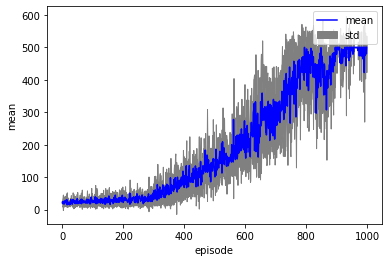

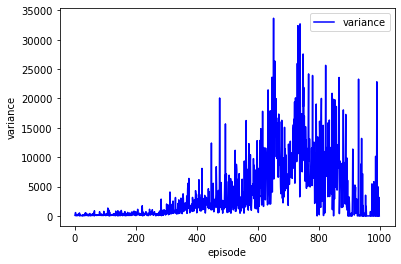

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
std_low = np.asarray(mean1) - np.asarray(std1)
std_high = np.asarray(mean1) + np.asarray(std1)
plt.plot(mean1,c = 'b',label = 'mean' )
plt.fill_between(np.arange(0,len(mean1),1),std_low,std_high, color = 'gray',label = 'std')
plt.legend()
# plt.title('summing all the rewards along an episode')
plt.xlabel('episode')
plt.ylabel('mean')
plt.show()

plt.figure()
plt.plot(np.asarray(std1)**2,c = 'b', label = 'variance')
# plt.title('variance en fonction de l\'iteration')
plt.legend()
plt.xlabel('episode')
plt.ylabel('variance')
plt.show()

## Exercises

### First algorithm: summing discounted rewards

As explained in the [second video](https://www.youtube.com/watch?v=dKUWto9B9WY) and [the corresponding slides](http://pages.isir.upmc.fr/~sigaud/teach/ps/4_pg_derivation2.pdf), using a discounted reward after the current step and ignoring the rewards before the current step results in lower variance.

By taking inspiration from the `apply_sum()` function above, code a function `apply_discounted_sum()` that computes sum of discounted rewards from immediate rewards.

Two hints:
- you should proceed backwards, starting from the final step of the episode and storing the previous sum into a register
- you need the discount factor as an input to your function.

In [22]:
def apply_discounted_sum(cfg, reward, v_value):
    # À compléter...  
    tmp = 0
    for i in reversed(range(len(reward))):
        reward[i] = reward[i] + cfg.algorithm.discount_factor * tmp
        tmp = reward[i]
    # print("final", reward)
    return reward


Then compare the performance of this algorithm to that of the previous approach where the rewards were just summed up.

In [23]:
torch.manual_seed(config.algorithm.seed)

config=OmegaConf.create(params)
config.logger.log_dir = "./tblogs/reinforce_dreward-" + str(time.time())
mean2, std2 = run_reinforce(config, compute_reward=apply_discounted_sum)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
  0%|          | 2/1000 [00:00<01:39, 10.08it/s]

episode: 0, reward: 21.0, std: 11.161157608032227
episode: 1, reward: 24.875, std: 13.097846031188965


  0%|          | 4/1000 [00:00<01:50,  9.01it/s]

episode: 2, reward: 22.5, std: 23.904571533203125
episode: 3, reward: 17.25, std: 5.203021049499512
episode: 4, reward: 24.875, std: 9.171968460083008


  1%|          | 7/1000 [00:00<01:52,  8.86it/s]

episode: 5, reward: 24.5, std: 9.426406860351562
episode: 6, reward: 24.25, std: 14.906853675842285


  1%|          | 9/1000 [00:00<01:46,  9.26it/s]

episode: 7, reward: 17.5, std: 4.840306758880615
episode: 8, reward: 26.75, std: 15.872258186340332


  1%|          | 11/1000 [00:01<01:41,  9.75it/s]

episode: 9, reward: 21.5, std: 9.957050323486328
episode: 10, reward: 21.25, std: 5.775564193725586
episode: 11, reward: 17.625, std: 9.179752349853516


  1%|▏         | 14/1000 [00:01<01:42,  9.59it/s]

episode: 12, reward: 23.125, std: 10.105691909790039
episode: 13, reward: 28.125, std: 14.416632652282715


  2%|▏         | 15/1000 [00:01<01:44,  9.44it/s]

episode: 14, reward: 24.25, std: 10.166471481323242
episode: 15, reward: 17.375, std: 4.627171516418457


  2%|▏         | 18/1000 [00:01<01:44,  9.36it/s]

episode: 16, reward: 24.625, std: 15.518997192382812
episode: 17, reward: 26.625, std: 11.819324493408203


  2%|▏         | 19/1000 [00:02<01:58,  8.29it/s]

episode: 18, reward: 22.5, std: 20.791481018066406
episode: 19, reward: 16.625, std: 7.981004238128662
episode: 20, reward: 22.875, std: 12.357039451599121


  2%|▏         | 22/1000 [00:02<01:50,  8.83it/s]

episode: 21, reward: 23.75, std: 13.59359073638916
episode: 22, reward: 17.625, std: 3.8521792888641357
episode: 23, reward: 23.25, std: 17.30194091796875


  3%|▎         | 26/1000 [00:02<01:46,  9.16it/s]

episode: 24, reward: 21.25, std: 9.051440238952637
episode: 25, reward: 26.625, std: 8.568005561828613


  3%|▎         | 28/1000 [00:03<01:45,  9.20it/s]

episode: 26, reward: 22.75, std: 10.402609825134277
episode: 27, reward: 30.5, std: 14.010200500488281
episode: 28, reward: 17.25, std: 6.041522979736328


  3%|▎         | 31/1000 [00:03<01:38,  9.79it/s]

episode: 29, reward: 23.625, std: 10.418904304504395
episode: 30, reward: 23.125, std: 12.147163391113281


  3%|▎         | 32/1000 [00:03<01:45,  9.19it/s]

episode: 31, reward: 23.25, std: 14.280356407165527
episode: 32, reward: 18.5, std: 5.756983280181885
episode: 33, reward: 31.125, std: 14.416632652282715


  4%|▎         | 35/1000 [00:03<01:42,  9.38it/s]

episode: 34, reward: 22.5, std: 9.754119873046875
episode: 35, reward: 21.0, std: 10.169983863830566


  4%|▍         | 38/1000 [00:04<02:00,  8.01it/s]

episode: 36, reward: 36.25, std: 26.19023895263672
episode: 37, reward: 32.875, std: 11.861552238464355


  4%|▍         | 40/1000 [00:04<01:44,  9.20it/s]

episode: 38, reward: 15.25, std: 5.2847490310668945
episode: 39, reward: 28.5, std: 11.637377738952637
episode: 40, reward: 23.125, std: 11.255950927734375


  4%|▍         | 42/1000 [00:04<01:40,  9.56it/s]

episode: 41, reward: 18.75, std: 11.535658836364746
episode: 42, reward: 24.75, std: 10.964227676391602


  5%|▍         | 46/1000 [00:04<01:35, 10.00it/s]

episode: 43, reward: 21.75, std: 14.300349235534668
episode: 44, reward: 24.375, std: 10.835622787475586
episode: 45, reward: 20.375, std: 9.59073257446289


  5%|▍         | 48/1000 [00:05<01:40,  9.51it/s]

episode: 46, reward: 24.0, std: 6.27921724319458
episode: 47, reward: 32.5, std: 18.423587799072266


  5%|▌         | 50/1000 [00:05<01:49,  8.65it/s]

episode: 48, reward: 34.0, std: 10.419761657714844
episode: 49, reward: 30.875, std: 16.20791244506836


  5%|▌         | 52/1000 [00:05<01:58,  8.00it/s]

episode: 50, reward: 29.375, std: 16.851770401000977
episode: 51, reward: 31.875, std: 14.7883882522583


  5%|▌         | 54/1000 [00:05<01:47,  8.83it/s]

episode: 52, reward: 18.625, std: 7.558108329772949
episode: 53, reward: 23.875, std: 10.669548988342285


  6%|▌         | 56/1000 [00:06<01:52,  8.38it/s]

episode: 54, reward: 30.875, std: 19.526081085205078
episode: 55, reward: 22.875, std: 13.206464767456055


  6%|▌         | 57/1000 [00:06<01:56,  8.12it/s]

episode: 56, reward: 21.625, std: 17.045631408691406
episode: 57, reward: 24.375, std: 8.683934211730957


  6%|▌         | 60/1000 [00:06<01:58,  7.91it/s]

episode: 58, reward: 33.75, std: 25.53848648071289
episode: 59, reward: 24.5, std: 12.0118989944458


  6%|▌         | 62/1000 [00:06<01:41,  9.25it/s]

episode: 60, reward: 18.5, std: 5.451081275939941
episode: 61, reward: 17.875, std: 5.276294708251953
episode: 62, reward: 27.75, std: 17.449928283691406


  6%|▋         | 65/1000 [00:07<01:40,  9.28it/s]

episode: 63, reward: 20.625, std: 6.232117176055908
episode: 64, reward: 20.25, std: 9.881440162658691


  7%|▋         | 67/1000 [00:07<01:43,  8.98it/s]

episode: 65, reward: 27.25, std: 16.756662368774414
episode: 66, reward: 22.125, std: 10.176127433776855


  7%|▋         | 69/1000 [00:07<01:58,  7.86it/s]

episode: 67, reward: 27.0, std: 15.01427936553955
episode: 68, reward: 38.625, std: 23.194442749023438


  7%|▋         | 71/1000 [00:07<01:50,  8.39it/s]

episode: 69, reward: 29.5, std: 11.351526260375977
episode: 70, reward: 24.25, std: 14.230249404907227
episode: 71, reward: 21.125, std: 8.935283660888672


  7%|▋         | 73/1000 [00:08<01:32, 10.01it/s]

episode: 72, reward: 17.625, std: 4.068608283996582
episode: 73, reward: 24.5, std: 10.198039054870605
episode: 74, reward: 20.875, std: 12.357039451599121


  8%|▊         | 77/1000 [00:08<01:38,  9.35it/s]

episode: 75, reward: 23.125, std: 16.487548828125
episode: 76, reward: 23.875, std: 12.732831954956055


  8%|▊         | 78/1000 [00:08<01:53,  8.12it/s]

episode: 77, reward: 24.375, std: 23.05234718322754
episode: 78, reward: 21.25, std: 8.048956871032715


  8%|▊         | 81/1000 [00:09<02:02,  7.50it/s]

episode: 79, reward: 34.125, std: 16.6256046295166
episode: 80, reward: 28.25, std: 23.426176071166992


  8%|▊         | 83/1000 [00:09<02:19,  6.58it/s]

episode: 81, reward: 32.5, std: 37.811561584472656
episode: 82, reward: 25.0, std: 13.627702713012695


  8%|▊         | 85/1000 [00:09<01:50,  8.26it/s]

episode: 83, reward: 16.75, std: 5.338539123535156
episode: 84, reward: 24.5, std: 11.43928050994873


  9%|▊         | 87/1000 [00:09<01:47,  8.50it/s]

episode: 85, reward: 29.125, std: 13.152267456054688
episode: 86, reward: 28.125, std: 11.5812349319458
episode: 87, reward: 18.0, std: 7.111359119415283


  9%|▉         | 89/1000 [00:10<01:38,  9.24it/s]

episode: 88, reward: 26.375, std: 10.756227493286133
episode: 89, reward: 19.5, std: 7.230885982513428


  9%|▉         | 92/1000 [00:10<01:44,  8.65it/s]

episode: 90, reward: 30.0, std: 29.770551681518555
episode: 91, reward: 23.5, std: 10.596495628356934


  9%|▉         | 94/1000 [00:10<01:36,  9.37it/s]

episode: 92, reward: 20.25, std: 12.555590629577637
episode: 93, reward: 23.875, std: 8.967202186584473
episode: 94, reward: 20.25, std: 13.509256362915039


 10%|▉         | 97/1000 [00:10<01:38,  9.14it/s]

episode: 95, reward: 22.625, std: 11.070391654968262
episode: 96, reward: 27.375, std: 8.959233283996582


 10%|▉         | 99/1000 [00:11<01:45,  8.53it/s]

episode: 97, reward: 28.125, std: 9.920217514038086
episode: 98, reward: 25.625, std: 16.26510238647461


 10%|█         | 100/1000 [00:11<01:50,  8.15it/s]

episode: 99, reward: 30.625, std: 13.595561027526855
episode: 100, reward: 43.625, std: 26.986438751220703


 10%|█         | 102/1000 [00:11<02:02,  7.33it/s]

episode: 101, reward: 23.875, std: 15.860440254211426
episode: 102, reward: 20.875, std: 10.466784477233887


 10%|█         | 104/1000 [00:11<01:51,  8.04it/s]

episode: 103, reward: 31.125, std: 16.728397369384766
episode: 104, reward: 30.75, std: 25.53289222717285


 11%|█         | 107/1000 [00:12<02:05,  7.10it/s]

episode: 105, reward: 23.875, std: 16.15494155883789
episode: 106, reward: 39.375, std: 21.246427536010742


 11%|█         | 108/1000 [00:12<02:01,  7.34it/s]

episode: 107, reward: 32.125, std: 14.004463195800781
episode: 108, reward: 22.375, std: 9.085899353027344


 11%|█         | 111/1000 [00:12<01:59,  7.43it/s]

episode: 109, reward: 25.25, std: 18.171798706054688
episode: 110, reward: 27.0, std: 23.071317672729492


 11%|█         | 112/1000 [00:13<02:11,  6.74it/s]

episode: 111, reward: 25.375, std: 24.383468627929688
episode: 112, reward: 20.25, std: 6.227818012237549


 12%|█▏        | 115/1000 [00:13<02:02,  7.20it/s]

episode: 113, reward: 33.25, std: 27.73213768005371
episode: 114, reward: 28.0, std: 16.724660873413086


 12%|█▏        | 117/1000 [00:13<01:58,  7.43it/s]

episode: 115, reward: 27.375, std: 9.59073257446289
episode: 116, reward: 35.5, std: 23.02793312072754


 12%|█▏        | 119/1000 [00:13<01:44,  8.45it/s]

episode: 117, reward: 22.25, std: 6.453127861022949
episode: 118, reward: 26.0, std: 10.677078247070312


 12%|█▏        | 121/1000 [00:14<01:49,  8.03it/s]

episode: 119, reward: 31.5, std: 19.346466064453125
episode: 120, reward: 29.5, std: 11.625096321105957
episode: 121, reward: 25.5, std: 7.1314191818237305
episode: 122, reward: 41.625, std: 22.715240478515625


 12%|█▏        | 124/1000 [00:14<02:09,  6.77it/s]

episode: 123, reward: 35.5, std: 24.905536651611328
episode: 124, reward: 35.375, std: 24.088748931884766


 13%|█▎        | 127/1000 [00:15<02:13,  6.54it/s]

episode: 125, reward: 25.75, std: 8.779033660888672
episode: 126, reward: 39.75, std: 25.46566390991211


 13%|█▎        | 129/1000 [00:15<02:11,  6.61it/s]

episode: 127, reward: 31.0, std: 28.560712814331055
episode: 128, reward: 31.375, std: 7.707834720611572


 13%|█▎        | 130/1000 [00:15<02:16,  6.36it/s]

episode: 129, reward: 37.25, std: 22.41651153564453
episode: 130, reward: 22.125, std: 10.105691909790039


 13%|█▎        | 133/1000 [00:15<02:01,  7.13it/s]

episode: 131, reward: 38.125, std: 25.969419479370117
episode: 132, reward: 22.25, std: 10.22252368927002


 14%|█▎        | 135/1000 [00:16<02:06,  6.81it/s]

episode: 133, reward: 31.5, std: 23.61597442626953
episode: 134, reward: 35.5, std: 15.79330825805664


 14%|█▎        | 136/1000 [00:16<01:59,  7.20it/s]

episode: 135, reward: 32.875, std: 10.722972869873047


 14%|█▎        | 137/1000 [00:16<03:00,  4.79it/s]

episode: 136, reward: 49.875, std: 60.950653076171875


 14%|█▍        | 139/1000 [00:17<02:41,  5.34it/s]

episode: 137, reward: 35.875, std: 23.90121078491211
episode: 138, reward: 24.75, std: 14.350211143493652


 14%|█▍        | 141/1000 [00:17<02:06,  6.77it/s]

episode: 139, reward: 22.25, std: 8.581542015075684
episode: 140, reward: 30.125, std: 11.14113998413086


 14%|█▍        | 142/1000 [00:17<02:19,  6.15it/s]

episode: 141, reward: 32.875, std: 27.68928337097168
episode: 142, reward: 43.0, std: 28.470535278320312


 14%|█▍        | 144/1000 [00:17<02:28,  5.76it/s]

episode: 143, reward: 35.25, std: 23.432273864746094
episode: 144, reward: 34.375, std: 20.9484920501709


 15%|█▍        | 146/1000 [00:18<02:16,  6.24it/s]

episode: 145, reward: 29.25, std: 14.557766914367676
episode: 146, reward: 24.75, std: 10.03920841217041


 15%|█▍        | 149/1000 [00:18<02:03,  6.89it/s]

episode: 147, reward: 41.75, std: 19.535680770874023
episode: 148, reward: 25.375, std: 19.74796485900879


 15%|█▌        | 151/1000 [00:18<01:58,  7.19it/s]

episode: 149, reward: 27.5, std: 15.51036548614502
episode: 150, reward: 34.0, std: 12.27075481414795


 15%|█▌        | 152/1000 [00:19<02:09,  6.55it/s]

episode: 151, reward: 40.25, std: 23.566017150878906


 15%|█▌        | 153/1000 [00:19<02:25,  5.80it/s]

episode: 152, reward: 42.875, std: 29.12258529663086
episode: 153, reward: 43.125, std: 18.114221572875977


 16%|█▌        | 156/1000 [00:19<02:12,  6.37it/s]

episode: 154, reward: 36.5, std: 19.58133316040039
episode: 155, reward: 30.0, std: 19.06380271911621


 16%|█▌        | 157/1000 [00:19<02:06,  6.68it/s]

episode: 156, reward: 30.25, std: 11.297913551330566
episode: 157, reward: 36.0, std: 18.928436279296875


 16%|█▌        | 160/1000 [00:20<02:08,  6.52it/s]

episode: 158, reward: 34.0, std: 19.82062339782715
episode: 159, reward: 32.875, std: 17.049821853637695


 16%|█▌        | 162/1000 [00:20<02:11,  6.38it/s]

episode: 160, reward: 29.75, std: 16.385969161987305
episode: 161, reward: 28.875, std: 23.624670028686523


 16%|█▋        | 164/1000 [00:20<01:52,  7.40it/s]

episode: 162, reward: 28.25, std: 14.538126945495605
episode: 163, reward: 26.0, std: 12.603854179382324


 17%|█▋        | 166/1000 [00:21<02:18,  6.01it/s]

episode: 164, reward: 55.25, std: 37.99530029296875
episode: 165, reward: 29.75, std: 16.455568313598633


 17%|█▋        | 168/1000 [00:21<02:09,  6.42it/s]

episode: 166, reward: 24.375, std: 13.585049629211426
episode: 167, reward: 35.125, std: 23.715200424194336


 17%|█▋        | 169/1000 [00:21<02:29,  5.55it/s]

episode: 168, reward: 50.5, std: 29.94280242919922


 17%|█▋        | 170/1000 [00:22<02:43,  5.08it/s]

episode: 169, reward: 44.5, std: 30.75246810913086


 17%|█▋        | 171/1000 [00:22<02:46,  4.98it/s]

episode: 170, reward: 39.5, std: 23.9702205657959


 17%|█▋        | 172/1000 [00:22<03:04,  4.48it/s]

episode: 171, reward: 45.75, std: 38.29863739013672
episode: 172, reward: 33.375, std: 24.307186126708984


 17%|█▋        | 174/1000 [00:23<02:58,  4.62it/s]

episode: 173, reward: 47.5, std: 29.203718185424805


 18%|█▊        | 175/1000 [00:23<02:54,  4.72it/s]

episode: 174, reward: 42.25, std: 26.09187126159668


 18%|█▊        | 176/1000 [00:23<02:53,  4.74it/s]

episode: 175, reward: 36.875, std: 28.427539825439453


 18%|█▊        | 177/1000 [00:23<02:53,  4.74it/s]

episode: 176, reward: 51.375, std: 24.552785873413086


 18%|█▊        | 178/1000 [00:23<02:58,  4.61it/s]

episode: 177, reward: 49.75, std: 31.689340591430664


 18%|█▊        | 179/1000 [00:24<03:06,  4.40it/s]

episode: 178, reward: 48.375, std: 28.809410095214844


 18%|█▊        | 180/1000 [00:25<05:54,  2.31it/s]

episode: 179, reward: 67.75, std: 70.78286743164062


 18%|█▊        | 182/1000 [00:25<04:05,  3.33it/s]

episode: 180, reward: 48.75, std: 21.385910034179688
episode: 181, reward: 40.375, std: 19.762428283691406


 18%|█▊        | 184/1000 [00:26<04:14,  3.20it/s]

episode: 182, reward: 33.0, std: 17.221248626708984
episode: 183, reward: 35.125, std: 15.824371337890625


 18%|█▊        | 185/1000 [00:26<03:56,  3.45it/s]

episode: 184, reward: 56.5, std: 32.40370178222656


 19%|█▊        | 186/1000 [00:26<03:54,  3.48it/s]

episode: 185, reward: 48.625, std: 40.88288879394531


 19%|█▉        | 188/1000 [00:27<03:12,  4.21it/s]

episode: 186, reward: 58.5, std: 31.973203659057617
episode: 187, reward: 33.375, std: 22.608074188232422


 19%|█▉        | 190/1000 [00:27<02:32,  5.31it/s]

episode: 188, reward: 30.0, std: 24.27815055847168
episode: 189, reward: 24.25, std: 10.416333198547363


 19%|█▉        | 192/1000 [00:27<02:38,  5.11it/s]

episode: 190, reward: 67.875, std: 40.877647399902344
episode: 191, reward: 36.875, std: 22.312313079833984


 19%|█▉        | 193/1000 [00:27<02:47,  4.81it/s]

episode: 192, reward: 51.875, std: 35.790809631347656


 19%|█▉        | 194/1000 [00:28<02:55,  4.59it/s]

episode: 193, reward: 42.75, std: 31.954208374023438


 20%|█▉        | 196/1000 [00:28<02:45,  4.85it/s]

episode: 194, reward: 58.75, std: 35.25721740722656
episode: 195, reward: 33.5, std: 21.454269409179688


 20%|█▉        | 197/1000 [00:28<03:06,  4.31it/s]

episode: 196, reward: 67.0, std: 39.871219635009766


 20%|█▉        | 198/1000 [00:29<03:01,  4.41it/s]

episode: 197, reward: 49.875, std: 31.543336868286133


 20%|██        | 200/1000 [00:29<02:44,  4.87it/s]

episode: 198, reward: 62.5, std: 40.18528366088867
episode: 199, reward: 26.375, std: 13.783400535583496


 20%|██        | 201/1000 [00:29<02:43,  4.90it/s]

episode: 200, reward: 53.25, std: 25.943620681762695
episode: 201, reward: 50.75, std: 25.200624465942383


 20%|██        | 203/1000 [00:30<02:47,  4.76it/s]

episode: 202, reward: 41.625, std: 30.052038192749023


 20%|██        | 204/1000 [00:30<02:59,  4.42it/s]

episode: 203, reward: 56.75, std: 39.9883918762207


 20%|██        | 205/1000 [00:30<02:58,  4.45it/s]

episode: 204, reward: 53.125, std: 28.447633743286133


 21%|██        | 206/1000 [00:31<03:47,  3.49it/s]

episode: 205, reward: 61.125, std: 64.60746765136719


 21%|██        | 207/1000 [00:31<03:58,  3.33it/s]

episode: 206, reward: 58.5, std: 50.60491180419922


 21%|██        | 208/1000 [00:31<03:52,  3.41it/s]

episode: 207, reward: 66.75, std: 40.453678131103516


 21%|██        | 209/1000 [00:32<04:10,  3.15it/s]

episode: 208, reward: 82.5, std: 42.25094985961914


 21%|██        | 211/1000 [00:32<03:36,  3.64it/s]

episode: 209, reward: 69.25, std: 45.94639587402344
episode: 210, reward: 32.375, std: 14.33215618133545


 21%|██        | 212/1000 [00:32<04:03,  3.24it/s]

episode: 211, reward: 79.625, std: 64.83811950683594


 21%|██▏       | 213/1000 [00:33<04:13,  3.11it/s]

episode: 212, reward: 53.375, std: 50.514320373535156


 21%|██▏       | 214/1000 [00:33<03:47,  3.45it/s]

episode: 213, reward: 52.75, std: 24.040145874023438


 22%|██▏       | 215/1000 [00:33<04:09,  3.14it/s]

episode: 214, reward: 62.75, std: 54.36582565307617


 22%|██▏       | 216/1000 [00:34<03:52,  3.37it/s]

episode: 215, reward: 54.25, std: 35.871795654296875


 22%|██▏       | 217/1000 [00:34<04:25,  2.95it/s]

episode: 216, reward: 75.0, std: 61.344459533691406


 22%|██▏       | 218/1000 [00:34<03:54,  3.33it/s]

episode: 217, reward: 51.5, std: 26.76885223388672
episode: 218, reward: 43.375, std: 21.954092025756836


 22%|██▏       | 220/1000 [00:35<03:12,  4.04it/s]

episode: 219, reward: 49.5, std: 25.326440811157227


 22%|██▏       | 221/1000 [00:35<03:26,  3.77it/s]

episode: 220, reward: 78.875, std: 41.89932632446289
episode: 221, reward: 44.625, std: 22.759220123291016


 22%|██▏       | 223/1000 [00:35<03:11,  4.05it/s]

episode: 222, reward: 64.375, std: 31.08025360107422


 22%|██▏       | 224/1000 [00:36<03:29,  3.70it/s]

episode: 223, reward: 57.625, std: 48.752838134765625


 22%|██▎       | 225/1000 [00:36<03:25,  3.76it/s]

episode: 224, reward: 57.625, std: 33.27778244018555


 23%|██▎       | 226/1000 [00:36<03:33,  3.63it/s]

episode: 225, reward: 66.5, std: 46.6414909362793


 23%|██▎       | 227/1000 [00:37<04:05,  3.15it/s]

episode: 226, reward: 113.125, std: 62.100006103515625


 23%|██▎       | 228/1000 [00:37<03:48,  3.37it/s]

episode: 227, reward: 53.25, std: 33.07891082763672


 23%|██▎       | 229/1000 [00:37<03:50,  3.34it/s]

episode: 228, reward: 74.25, std: 40.013389587402344


 23%|██▎       | 230/1000 [00:38<03:48,  3.36it/s]

episode: 229, reward: 65.375, std: 35.480125427246094


 23%|██▎       | 231/1000 [00:38<04:01,  3.19it/s]

episode: 230, reward: 68.0, std: 59.322364807128906


 23%|██▎       | 232/1000 [00:38<03:48,  3.36it/s]

episode: 231, reward: 69.5, std: 44.880794525146484


 23%|██▎       | 233/1000 [00:38<03:32,  3.61it/s]

episode: 232, reward: 53.0, std: 36.8316650390625


 23%|██▎       | 234/1000 [00:39<03:38,  3.50it/s]

episode: 233, reward: 75.0, std: 40.41216278076172


 24%|██▎       | 235/1000 [00:39<03:41,  3.45it/s]

episode: 234, reward: 83.375, std: 40.732357025146484


 24%|██▎       | 236/1000 [00:40<05:16,  2.42it/s]

episode: 235, reward: 127.25, std: 46.744747161865234


 24%|██▎       | 237/1000 [00:40<04:41,  2.71it/s]

episode: 236, reward: 61.375, std: 40.517852783203125


 24%|██▍       | 238/1000 [00:40<04:27,  2.85it/s]

episode: 237, reward: 79.125, std: 39.2880859375


 24%|██▍       | 239/1000 [00:41<05:11,  2.44it/s]

episode: 238, reward: 113.875, std: 66.52912902832031


 24%|██▍       | 240/1000 [00:41<04:47,  2.64it/s]

episode: 239, reward: 60.25, std: 50.49681854248047
episode: 240, reward: 47.125, std: 23.793380737304688


 24%|██▍       | 242/1000 [00:42<04:09,  3.04it/s]

episode: 241, reward: 62.75, std: 51.76526641845703


 24%|██▍       | 243/1000 [00:42<04:33,  2.77it/s]

episode: 242, reward: 89.125, std: 58.75721740722656


 24%|██▍       | 244/1000 [00:42<04:02,  3.11it/s]

episode: 243, reward: 63.625, std: 25.91710662841797


 24%|██▍       | 245/1000 [00:43<03:59,  3.15it/s]

episode: 244, reward: 78.125, std: 35.63881301879883


 25%|██▍       | 246/1000 [00:43<04:34,  2.74it/s]

episode: 245, reward: 94.0, std: 59.895145416259766


 25%|██▍       | 247/1000 [00:43<04:22,  2.87it/s]

episode: 246, reward: 73.125, std: 33.947174072265625


 25%|██▍       | 248/1000 [00:44<04:31,  2.77it/s]

episode: 247, reward: 102.0, std: 54.77747344970703


 25%|██▍       | 249/1000 [00:44<04:32,  2.75it/s]

episode: 248, reward: 95.625, std: 48.461875915527344


 25%|██▌       | 250/1000 [00:45<05:11,  2.41it/s]

episode: 249, reward: 96.5, std: 79.33473205566406


 25%|██▌       | 251/1000 [00:45<04:58,  2.51it/s]

episode: 250, reward: 79.875, std: 51.09217834472656


 25%|██▌       | 252/1000 [00:46<05:08,  2.42it/s]

episode: 251, reward: 102.25, std: 56.332557678222656


 25%|██▌       | 253/1000 [00:46<05:00,  2.48it/s]

episode: 252, reward: 121.875, std: 33.12071990966797


 25%|██▌       | 254/1000 [00:46<04:59,  2.49it/s]

episode: 253, reward: 92.625, std: 47.12274932861328


 26%|██▌       | 255/1000 [00:47<04:48,  2.58it/s]

episode: 254, reward: 95.375, std: 51.05162048339844


 26%|██▌       | 256/1000 [00:47<04:50,  2.56it/s]

episode: 255, reward: 114.875, std: 36.6934700012207


 26%|██▌       | 257/1000 [00:48<05:27,  2.27it/s]

episode: 256, reward: 132.875, std: 72.7430648803711


 26%|██▌       | 258/1000 [00:48<05:07,  2.41it/s]

episode: 257, reward: 116.5, std: 32.81550216674805


 26%|██▌       | 259/1000 [00:48<04:59,  2.47it/s]

episode: 258, reward: 138.75, std: 29.97498893737793


 26%|██▌       | 260/1000 [00:49<04:39,  2.65it/s]

episode: 259, reward: 113.5, std: 21.1660099029541


 26%|██▌       | 261/1000 [00:49<04:46,  2.58it/s]

episode: 260, reward: 125.5, std: 51.34199142456055


 26%|██▌       | 262/1000 [00:49<04:49,  2.55it/s]

episode: 261, reward: 98.125, std: 58.498931884765625


 26%|██▋       | 263/1000 [00:50<04:48,  2.56it/s]

episode: 262, reward: 129.875, std: 35.12604904174805


 26%|██▋       | 264/1000 [00:50<05:07,  2.39it/s]

episode: 263, reward: 108.875, std: 64.70027160644531


 26%|██▋       | 265/1000 [00:51<05:36,  2.18it/s]

episode: 264, reward: 149.375, std: 71.73749542236328


 27%|██▋       | 266/1000 [00:51<05:53,  2.08it/s]

episode: 265, reward: 129.75, std: 56.33763122558594


 27%|██▋       | 267/1000 [00:52<06:04,  2.01it/s]

episode: 266, reward: 123.75, std: 67.85857391357422


 27%|██▋       | 268/1000 [00:52<05:26,  2.24it/s]

episode: 267, reward: 102.625, std: 43.644466400146484


 27%|██▋       | 269/1000 [00:53<05:23,  2.26it/s]

episode: 268, reward: 113.0, std: 72.61640930175781


 27%|██▋       | 270/1000 [00:53<05:15,  2.31it/s]

episode: 269, reward: 118.25, std: 49.953548431396484


 27%|██▋       | 271/1000 [00:54<05:22,  2.26it/s]

episode: 270, reward: 109.375, std: 58.81675720214844


 27%|██▋       | 272/1000 [00:54<06:02,  2.01it/s]

episode: 271, reward: 171.0, std: 79.15084838867188


 27%|██▋       | 273/1000 [00:55<06:01,  2.01it/s]

episode: 272, reward: 144.0, std: 49.46571731567383


 27%|██▋       | 274/1000 [00:55<06:15,  1.93it/s]

episode: 273, reward: 131.5, std: 70.5650634765625


 28%|██▊       | 275/1000 [00:56<06:00,  2.01it/s]

episode: 274, reward: 147.375, std: 20.099306106567383


 28%|██▊       | 276/1000 [00:56<05:52,  2.06it/s]

episode: 275, reward: 131.25, std: 67.09002685546875


 28%|██▊       | 277/1000 [00:57<05:59,  2.01it/s]

episode: 276, reward: 128.625, std: 89.35153198242188


 28%|██▊       | 278/1000 [00:57<05:55,  2.03it/s]

episode: 277, reward: 146.125, std: 53.14249801635742


 28%|██▊       | 279/1000 [00:58<07:09,  1.68it/s]

episode: 278, reward: 220.375, std: 87.57190704345703


 28%|██▊       | 280/1000 [00:59<07:15,  1.65it/s]

episode: 279, reward: 176.875, std: 47.738685607910156


 28%|██▊       | 281/1000 [00:59<06:29,  1.84it/s]

episode: 280, reward: 117.75, std: 44.506019592285156


 28%|██▊       | 282/1000 [01:00<06:32,  1.83it/s]

episode: 281, reward: 158.25, std: 53.454254150390625


 28%|██▊       | 283/1000 [01:00<06:17,  1.90it/s]

episode: 282, reward: 142.875, std: 70.5963134765625


 28%|██▊       | 284/1000 [01:01<06:00,  1.98it/s]

episode: 283, reward: 144.25, std: 49.82469177246094


 28%|██▊       | 285/1000 [01:01<06:49,  1.75it/s]

episode: 284, reward: 183.875, std: 98.91473388671875


 29%|██▊       | 286/1000 [01:02<08:31,  1.40it/s]

episode: 285, reward: 225.125, std: 139.4811248779297


 29%|██▊       | 287/1000 [01:03<07:35,  1.57it/s]

episode: 286, reward: 150.5, std: 47.659507751464844


 29%|██▉       | 288/1000 [01:03<07:14,  1.64it/s]

episode: 287, reward: 174.625, std: 57.59200668334961


 29%|██▉       | 289/1000 [01:04<07:39,  1.55it/s]

episode: 288, reward: 177.875, std: 97.89270782470703


 29%|██▉       | 290/1000 [01:05<08:01,  1.48it/s]

episode: 289, reward: 186.25, std: 75.76985931396484


 29%|██▉       | 291/1000 [01:06<08:39,  1.37it/s]

episode: 290, reward: 193.625, std: 105.99182891845703


 29%|██▉       | 292/1000 [01:07<08:56,  1.32it/s]

episode: 291, reward: 201.25, std: 107.59414672851562


 29%|██▉       | 293/1000 [01:08<09:51,  1.20it/s]

episode: 292, reward: 183.25, std: 149.62405395507812


 29%|██▉       | 294/1000 [01:08<09:59,  1.18it/s]

episode: 293, reward: 201.75, std: 105.39551544189453


 30%|██▉       | 295/1000 [01:09<09:09,  1.28it/s]

episode: 294, reward: 192.0, std: 52.98247528076172


 30%|██▉       | 296/1000 [01:10<09:12,  1.27it/s]

episode: 295, reward: 162.125, std: 63.88703918457031


 30%|██▉       | 297/1000 [01:10<08:39,  1.35it/s]

episode: 296, reward: 212.375, std: 61.82680130004883


 30%|██▉       | 298/1000 [01:11<08:32,  1.37it/s]

episode: 297, reward: 170.0, std: 89.30205535888672


 30%|██▉       | 299/1000 [01:12<08:26,  1.38it/s]

episode: 298, reward: 198.0, std: 89.62779998779297


 30%|███       | 300/1000 [01:13<09:04,  1.29it/s]

episode: 299, reward: 259.5, std: 93.17265319824219


 30%|███       | 301/1000 [01:14<09:25,  1.24it/s]

episode: 300, reward: 174.25, std: 127.77519226074219


 30%|███       | 302/1000 [01:14<08:45,  1.33it/s]

episode: 301, reward: 188.875, std: 57.692378997802734


 30%|███       | 303/1000 [01:15<08:00,  1.45it/s]

episode: 302, reward: 167.875, std: 70.70549774169922


 30%|███       | 304/1000 [01:15<07:35,  1.53it/s]

episode: 303, reward: 184.375, std: 51.18855285644531


 30%|███       | 305/1000 [01:16<08:04,  1.43it/s]

episode: 304, reward: 254.5, std: 60.63945007324219


 31%|███       | 306/1000 [01:17<07:32,  1.53it/s]

episode: 305, reward: 178.75, std: 59.62202453613281


 31%|███       | 307/1000 [01:18<08:51,  1.30it/s]

episode: 306, reward: 274.375, std: 165.5682373046875


 31%|███       | 308/1000 [01:18<08:26,  1.37it/s]

episode: 307, reward: 200.75, std: 58.538753509521484


 31%|███       | 309/1000 [01:19<07:30,  1.53it/s]

episode: 308, reward: 153.5, std: 52.77174758911133


 31%|███       | 310/1000 [01:20<08:21,  1.38it/s]

episode: 309, reward: 217.125, std: 96.37640380859375


 31%|███       | 311/1000 [01:21<08:27,  1.36it/s]

episode: 310, reward: 243.625, std: 88.2365951538086


 31%|███       | 312/1000 [01:21<08:39,  1.32it/s]

episode: 311, reward: 265.125, std: 61.410648345947266


 31%|███▏      | 313/1000 [01:22<08:12,  1.40it/s]

episode: 312, reward: 191.0, std: 44.26543426513672


 31%|███▏      | 314/1000 [01:23<08:40,  1.32it/s]

episode: 313, reward: 256.5, std: 97.16995239257812


 32%|███▏      | 315/1000 [01:24<08:42,  1.31it/s]

episode: 314, reward: 251.375, std: 71.36412811279297


 32%|███▏      | 316/1000 [01:24<07:49,  1.46it/s]

episode: 315, reward: 160.0, std: 55.72637176513672


 32%|███▏      | 317/1000 [01:25<08:56,  1.27it/s]

episode: 316, reward: 238.875, std: 117.3498306274414


 32%|███▏      | 318/1000 [01:26<08:50,  1.29it/s]

episode: 317, reward: 258.875, std: 49.929771423339844


 32%|███▏      | 319/1000 [01:27<09:55,  1.14it/s]

episode: 318, reward: 259.5, std: 114.03382873535156


 32%|███▏      | 320/1000 [01:28<09:32,  1.19it/s]

episode: 319, reward: 221.75, std: 70.43892669677734


 32%|███▏      | 321/1000 [01:29<09:15,  1.22it/s]

episode: 320, reward: 240.25, std: 69.10395812988281


 32%|███▏      | 322/1000 [01:29<08:41,  1.30it/s]

episode: 321, reward: 234.0, std: 31.190658569335938


 32%|███▏      | 323/1000 [01:30<08:00,  1.41it/s]

episode: 322, reward: 158.25, std: 65.62610626220703


 32%|███▏      | 324/1000 [01:30<08:08,  1.38it/s]

episode: 323, reward: 251.75, std: 63.43894577026367


 32%|███▎      | 325/1000 [01:31<08:42,  1.29it/s]

episode: 324, reward: 200.375, std: 77.31925964355469


 33%|███▎      | 326/1000 [01:32<09:05,  1.24it/s]

episode: 325, reward: 280.5, std: 102.0112075805664


 33%|███▎      | 327/1000 [01:33<08:45,  1.28it/s]

episode: 326, reward: 203.75, std: 66.7784194946289


 33%|███▎      | 328/1000 [01:34<08:49,  1.27it/s]

episode: 327, reward: 229.0, std: 75.76844787597656


 33%|███▎      | 329/1000 [01:35<09:10,  1.22it/s]

episode: 328, reward: 254.875, std: 87.17705535888672


 33%|███▎      | 330/1000 [01:35<08:48,  1.27it/s]

episode: 329, reward: 211.5, std: 93.63150024414062


 33%|███▎      | 331/1000 [01:36<09:18,  1.20it/s]

episode: 330, reward: 252.5, std: 104.60128021240234


 33%|███▎      | 332/1000 [01:37<08:55,  1.25it/s]

episode: 331, reward: 226.375, std: 72.61038208007812


 33%|███▎      | 333/1000 [01:38<08:47,  1.27it/s]

episode: 332, reward: 272.0, std: 71.79932403564453


 33%|███▎      | 334/1000 [01:39<09:34,  1.16it/s]

episode: 333, reward: 297.125, std: 132.42727661132812


 34%|███▎      | 335/1000 [01:40<08:48,  1.26it/s]

episode: 334, reward: 207.625, std: 48.49723815917969


 34%|███▎      | 336/1000 [01:40<08:53,  1.25it/s]

episode: 335, reward: 239.875, std: 80.47969818115234


 34%|███▎      | 337/1000 [01:41<08:45,  1.26it/s]

episode: 336, reward: 234.25, std: 63.62333297729492


 34%|███▍      | 338/1000 [01:42<08:41,  1.27it/s]

episode: 337, reward: 221.375, std: 103.79779815673828


 34%|███▍      | 339/1000 [01:43<08:25,  1.31it/s]

episode: 338, reward: 187.0, std: 82.63516998291016


 34%|███▍      | 340/1000 [01:43<08:13,  1.34it/s]

episode: 339, reward: 188.75, std: 64.20447540283203


 34%|███▍      | 341/1000 [01:44<09:16,  1.19it/s]

episode: 340, reward: 260.125, std: 105.374755859375


 34%|███▍      | 342/1000 [01:45<09:04,  1.21it/s]

episode: 341, reward: 223.5, std: 67.03304290771484


 34%|███▍      | 343/1000 [01:46<08:18,  1.32it/s]

episode: 342, reward: 191.625, std: 35.59669876098633


 34%|███▍      | 344/1000 [01:46<07:34,  1.44it/s]

episode: 343, reward: 178.875, std: 45.33506393432617


 34%|███▍      | 345/1000 [01:47<08:02,  1.36it/s]

episode: 344, reward: 237.125, std: 102.55094909667969


 35%|███▍      | 346/1000 [01:48<09:29,  1.15it/s]

episode: 345, reward: 206.25, std: 133.763916015625


 35%|███▍      | 347/1000 [01:49<08:46,  1.24it/s]

episode: 346, reward: 193.875, std: 62.049373626708984


 35%|███▍      | 348/1000 [01:50<08:56,  1.22it/s]

episode: 347, reward: 212.0, std: 98.19368743896484


 35%|███▍      | 349/1000 [01:51<08:30,  1.27it/s]

episode: 348, reward: 205.125, std: 68.42605590820312


 35%|███▌      | 350/1000 [01:51<08:06,  1.34it/s]

episode: 349, reward: 177.75, std: 55.40177917480469


 35%|███▌      | 351/1000 [01:52<07:21,  1.47it/s]

episode: 350, reward: 180.0, std: 35.44009017944336


 35%|███▌      | 352/1000 [01:53<08:17,  1.30it/s]

episode: 351, reward: 227.125, std: 113.70819854736328


 35%|███▌      | 353/1000 [01:53<07:24,  1.46it/s]

episode: 352, reward: 174.625, std: 27.495128631591797


 35%|███▌      | 354/1000 [01:54<07:08,  1.51it/s]

episode: 353, reward: 204.75, std: 43.37131881713867


 36%|███▌      | 355/1000 [01:54<06:30,  1.65it/s]

episode: 354, reward: 167.875, std: 23.074026107788086


 36%|███▌      | 356/1000 [01:55<06:21,  1.69it/s]

episode: 355, reward: 167.0, std: 53.25410842895508


 36%|███▌      | 357/1000 [01:55<06:17,  1.70it/s]

episode: 356, reward: 154.375, std: 65.15681457519531


 36%|███▌      | 358/1000 [01:56<06:29,  1.65it/s]

episode: 357, reward: 215.25, std: 50.93342971801758


 36%|███▌      | 359/1000 [01:57<06:07,  1.74it/s]

episode: 358, reward: 163.25, std: 33.285560607910156


 36%|███▌      | 360/1000 [01:57<06:01,  1.77it/s]

episode: 359, reward: 156.75, std: 74.29237365722656


 36%|███▌      | 361/1000 [01:58<06:12,  1.72it/s]

episode: 360, reward: 195.125, std: 64.51232147216797


 36%|███▌      | 362/1000 [01:58<06:48,  1.56it/s]

episode: 361, reward: 202.625, std: 90.3199691772461


 36%|███▋      | 363/1000 [02:00<07:58,  1.33it/s]

episode: 362, reward: 230.75, std: 122.35633087158203


 36%|███▋      | 364/1000 [02:00<07:12,  1.47it/s]

episode: 363, reward: 143.0, std: 57.52763366699219


 36%|███▋      | 365/1000 [02:01<06:51,  1.54it/s]

episode: 364, reward: 172.25, std: 45.00714111328125


 37%|███▋      | 366/1000 [02:01<06:24,  1.65it/s]

episode: 365, reward: 166.875, std: 30.511999130249023


 37%|███▋      | 367/1000 [02:02<06:03,  1.74it/s]

episode: 366, reward: 162.125, std: 40.01941680908203


 37%|███▋      | 368/1000 [02:02<05:50,  1.80it/s]

episode: 367, reward: 187.375, std: 30.236862182617188


 37%|███▋      | 369/1000 [02:03<05:59,  1.75it/s]

episode: 368, reward: 174.125, std: 64.5809326171875


 37%|███▋      | 370/1000 [02:03<05:31,  1.90it/s]

episode: 369, reward: 154.0, std: 25.701583862304688


 37%|███▋      | 371/1000 [02:04<05:28,  1.91it/s]

episode: 370, reward: 184.625, std: 37.890586853027344


 37%|███▋      | 372/1000 [02:04<05:38,  1.86it/s]

episode: 371, reward: 179.25, std: 36.09016418457031


 37%|███▋      | 373/1000 [02:05<05:48,  1.80it/s]

episode: 372, reward: 143.0, std: 75.21588134765625


 37%|███▋      | 374/1000 [02:05<06:02,  1.73it/s]

episode: 373, reward: 186.375, std: 52.839210510253906


 38%|███▊      | 375/1000 [02:06<05:54,  1.76it/s]

episode: 374, reward: 158.875, std: 51.5570068359375


 38%|███▊      | 376/1000 [02:06<05:29,  1.89it/s]

episode: 375, reward: 156.75, std: 32.37172317504883


 38%|███▊      | 377/1000 [02:07<05:49,  1.78it/s]

episode: 376, reward: 162.5, std: 72.8638687133789


 38%|███▊      | 378/1000 [02:08<05:39,  1.83it/s]

episode: 377, reward: 180.375, std: 37.221107482910156


 38%|███▊      | 379/1000 [02:08<05:15,  1.97it/s]

episode: 378, reward: 150.25, std: 19.535680770874023


 38%|███▊      | 380/1000 [02:09<05:37,  1.84it/s]

episode: 379, reward: 176.75, std: 53.0545539855957


 38%|███▊      | 381/1000 [02:09<05:55,  1.74it/s]

episode: 380, reward: 153.5, std: 70.49011993408203


 38%|███▊      | 382/1000 [02:10<05:44,  1.79it/s]

episode: 381, reward: 164.625, std: 33.269195556640625


 38%|███▊      | 383/1000 [02:10<05:30,  1.87it/s]

episode: 382, reward: 172.25, std: 29.884300231933594


 38%|███▊      | 384/1000 [02:11<06:57,  1.48it/s]

episode: 383, reward: 215.375, std: 115.05642700195312


 38%|███▊      | 385/1000 [02:12<06:21,  1.61it/s]

episode: 384, reward: 173.5, std: 27.69218635559082


 39%|███▊      | 386/1000 [02:12<05:55,  1.73it/s]

episode: 385, reward: 163.375, std: 29.64522361755371


 39%|███▊      | 387/1000 [02:13<06:04,  1.68it/s]

episode: 386, reward: 174.0, std: 41.11655807495117


 39%|███▉      | 388/1000 [02:14<06:38,  1.54it/s]

episode: 387, reward: 176.375, std: 50.09116744995117


 39%|███▉      | 389/1000 [02:14<06:41,  1.52it/s]

episode: 388, reward: 152.625, std: 30.170644760131836


 39%|███▉      | 390/1000 [02:15<07:37,  1.33it/s]

episode: 389, reward: 186.375, std: 59.02042770385742


 39%|███▉      | 391/1000 [02:16<06:50,  1.48it/s]

episode: 390, reward: 167.0, std: 34.83430099487305


 39%|███▉      | 392/1000 [02:16<06:19,  1.60it/s]

episode: 391, reward: 174.75, std: 38.795249938964844


 39%|███▉      | 393/1000 [02:17<06:18,  1.60it/s]

episode: 392, reward: 197.625, std: 51.015228271484375


 39%|███▉      | 394/1000 [02:17<05:52,  1.72it/s]

episode: 393, reward: 170.5, std: 38.407588958740234


 40%|███▉      | 395/1000 [02:18<06:00,  1.68it/s]

episode: 394, reward: 173.625, std: 60.235103607177734


 40%|███▉      | 396/1000 [02:19<06:51,  1.47it/s]

episode: 395, reward: 176.125, std: 67.73358917236328


 40%|███▉      | 397/1000 [02:19<06:30,  1.54it/s]

episode: 396, reward: 209.5, std: 40.900577545166016


 40%|███▉      | 398/1000 [02:20<06:31,  1.54it/s]

episode: 397, reward: 187.25, std: 64.54621887207031


 40%|███▉      | 399/1000 [02:21<06:45,  1.48it/s]

episode: 398, reward: 159.5, std: 83.49507904052734


 40%|████      | 400/1000 [02:22<06:38,  1.51it/s]

episode: 399, reward: 201.25, std: 58.08306884765625


 40%|████      | 401/1000 [02:22<06:14,  1.60it/s]

episode: 400, reward: 185.625, std: 33.491737365722656


 40%|████      | 402/1000 [02:23<06:21,  1.57it/s]

episode: 401, reward: 203.5, std: 81.24390411376953


 40%|████      | 403/1000 [02:23<06:35,  1.51it/s]

episode: 402, reward: 198.625, std: 67.69878387451172


 40%|████      | 404/1000 [02:24<06:12,  1.60it/s]

episode: 403, reward: 172.875, std: 57.5560302734375


 40%|████      | 405/1000 [02:25<07:24,  1.34it/s]

episode: 404, reward: 224.0, std: 113.2481460571289


 41%|████      | 406/1000 [02:26<07:30,  1.32it/s]

episode: 405, reward: 236.375, std: 98.3070068359375


 41%|████      | 407/1000 [02:26<07:02,  1.40it/s]

episode: 406, reward: 208.0, std: 43.7884521484375


 41%|████      | 408/1000 [02:27<06:30,  1.52it/s]

episode: 407, reward: 194.125, std: 35.49823760986328


 41%|████      | 409/1000 [02:28<06:29,  1.52it/s]

episode: 408, reward: 199.125, std: 63.020263671875


 41%|████      | 410/1000 [02:28<06:43,  1.46it/s]

episode: 409, reward: 214.25, std: 101.62500762939453


 41%|████      | 411/1000 [02:29<07:46,  1.26it/s]

episode: 410, reward: 232.125, std: 108.89108276367188


 41%|████      | 412/1000 [02:30<07:33,  1.30it/s]

episode: 411, reward: 202.75, std: 64.33561706542969


 41%|████▏     | 413/1000 [02:31<07:52,  1.24it/s]

episode: 412, reward: 235.875, std: 84.24867248535156


 41%|████▏     | 414/1000 [02:32<07:14,  1.35it/s]

episode: 413, reward: 204.125, std: 43.98843002319336


 42%|████▏     | 415/1000 [02:32<07:30,  1.30it/s]

episode: 414, reward: 238.75, std: 81.48751068115234


 42%|████▏     | 416/1000 [02:33<07:54,  1.23it/s]

episode: 415, reward: 213.75, std: 98.74896240234375


 42%|████▏     | 417/1000 [02:34<07:27,  1.30it/s]

episode: 416, reward: 194.5, std: 57.40333557128906


 42%|████▏     | 418/1000 [02:35<07:12,  1.34it/s]

episode: 417, reward: 194.375, std: 43.92180633544922


 42%|████▏     | 419/1000 [02:35<07:01,  1.38it/s]

episode: 418, reward: 223.125, std: 45.21200180053711


 42%|████▏     | 420/1000 [02:36<07:00,  1.38it/s]

episode: 419, reward: 220.875, std: 63.83334732055664


 42%|████▏     | 421/1000 [02:37<06:50,  1.41it/s]

episode: 420, reward: 221.875, std: 30.20613670349121


 42%|████▏     | 422/1000 [02:38<07:08,  1.35it/s]

episode: 421, reward: 216.625, std: 95.7257080078125
episode: 422, reward: 241.0, std: 121.44722747802734


 42%|████▏     | 424/1000 [02:40<08:08,  1.18it/s]

episode: 423, reward: 166.875, std: 64.41259002685547


 42%|████▎     | 425/1000 [02:40<07:48,  1.23it/s]

episode: 424, reward: 242.5, std: 56.90593719482422


 43%|████▎     | 426/1000 [02:41<07:32,  1.27it/s]

episode: 425, reward: 241.25, std: 47.71866989135742


 43%|████▎     | 427/1000 [02:42<07:36,  1.25it/s]

episode: 426, reward: 210.0, std: 60.39867401123047


 43%|████▎     | 428/1000 [02:42<06:53,  1.38it/s]

episode: 427, reward: 181.0, std: 23.646202087402344


 43%|████▎     | 429/1000 [02:43<06:35,  1.44it/s]

episode: 428, reward: 205.0, std: 36.73067855834961


 43%|████▎     | 430/1000 [02:44<06:33,  1.45it/s]

episode: 429, reward: 204.25, std: 83.39192962646484


 43%|████▎     | 431/1000 [02:44<06:22,  1.49it/s]

episode: 430, reward: 201.125, std: 39.527339935302734


 43%|████▎     | 432/1000 [02:45<07:34,  1.25it/s]

episode: 431, reward: 227.125, std: 78.04840850830078


 43%|████▎     | 433/1000 [02:46<07:06,  1.33it/s]

episode: 432, reward: 201.375, std: 52.74449920654297


 43%|████▎     | 434/1000 [02:47<07:51,  1.20it/s]

episode: 433, reward: 230.375, std: 118.80107879638672


 44%|████▎     | 435/1000 [02:48<07:40,  1.23it/s]

episode: 434, reward: 183.875, std: 80.23793029785156


 44%|████▎     | 436/1000 [02:49<07:46,  1.21it/s]

episode: 435, reward: 214.375, std: 85.4984359741211


 44%|████▎     | 437/1000 [02:49<07:19,  1.28it/s]

episode: 436, reward: 183.375, std: 64.69474792480469


 44%|████▍     | 438/1000 [02:50<06:32,  1.43it/s]

episode: 437, reward: 181.0, std: 32.31098937988281


 44%|████▍     | 439/1000 [02:51<06:25,  1.46it/s]

episode: 438, reward: 193.375, std: 50.33015823364258


 44%|████▍     | 440/1000 [02:51<06:38,  1.40it/s]

episode: 439, reward: 191.75, std: 86.01287078857422


 44%|████▍     | 441/1000 [02:52<06:04,  1.54it/s]

episode: 440, reward: 177.125, std: 32.162254333496094


 44%|████▍     | 442/1000 [02:52<05:30,  1.69it/s]

episode: 441, reward: 155.5, std: 48.249351501464844


 44%|████▍     | 443/1000 [02:53<05:19,  1.74it/s]

episode: 442, reward: 200.375, std: 26.6294002532959


 44%|████▍     | 444/1000 [02:54<05:34,  1.66it/s]

episode: 443, reward: 206.375, std: 48.67659378051758


 44%|████▍     | 445/1000 [02:54<05:24,  1.71it/s]

episode: 444, reward: 199.0, std: 38.74458312988281


 45%|████▍     | 446/1000 [02:55<05:48,  1.59it/s]

episode: 445, reward: 197.5, std: 65.8439712524414


 45%|████▍     | 447/1000 [02:55<05:42,  1.62it/s]

episode: 446, reward: 201.5, std: 35.27848434448242


 45%|████▍     | 448/1000 [02:56<05:30,  1.67it/s]

episode: 447, reward: 164.75, std: 60.52095413208008


 45%|████▍     | 449/1000 [02:57<05:25,  1.69it/s]

episode: 448, reward: 187.25, std: 52.68437194824219


 45%|████▌     | 450/1000 [02:57<05:14,  1.75it/s]

episode: 449, reward: 177.125, std: 34.47333526611328


 45%|████▌     | 451/1000 [02:58<05:12,  1.76it/s]

episode: 450, reward: 200.25, std: 30.226526260375977


 45%|████▌     | 452/1000 [02:58<05:35,  1.64it/s]

episode: 451, reward: 218.0, std: 57.38093185424805


 45%|████▌     | 453/1000 [02:59<05:38,  1.62it/s]

episode: 452, reward: 199.5, std: 40.17106246948242


 45%|████▌     | 454/1000 [03:00<06:02,  1.51it/s]

episode: 453, reward: 214.0, std: 66.30448913574219


 46%|████▌     | 455/1000 [03:01<07:02,  1.29it/s]

episode: 454, reward: 254.25, std: 129.0013885498047


 46%|████▌     | 456/1000 [03:02<06:51,  1.32it/s]

episode: 455, reward: 212.5, std: 55.79042434692383


 46%|████▌     | 457/1000 [03:02<06:30,  1.39it/s]

episode: 456, reward: 197.125, std: 48.83335494995117


 46%|████▌     | 458/1000 [03:03<06:21,  1.42it/s]

episode: 457, reward: 219.125, std: 42.67966079711914


 46%|████▌     | 459/1000 [03:03<06:15,  1.44it/s]

episode: 458, reward: 222.375, std: 49.29484939575195


 46%|████▌     | 460/1000 [03:04<06:13,  1.45it/s]

episode: 459, reward: 231.0, std: 52.32863235473633


 46%|████▌     | 461/1000 [03:05<06:35,  1.36it/s]

episode: 460, reward: 233.75, std: 81.366455078125


 46%|████▌     | 462/1000 [03:06<06:20,  1.41it/s]

episode: 461, reward: 211.0, std: 39.10791015625


 46%|████▋     | 463/1000 [03:06<06:36,  1.35it/s]

episode: 462, reward: 231.125, std: 102.79582977294922


 46%|████▋     | 464/1000 [03:07<06:31,  1.37it/s]

episode: 463, reward: 230.25, std: 59.963680267333984


 46%|████▋     | 465/1000 [03:08<06:28,  1.38it/s]

episode: 464, reward: 215.75, std: 46.95514678955078


 47%|████▋     | 466/1000 [03:09<06:25,  1.39it/s]

episode: 465, reward: 228.625, std: 61.58835220336914


 47%|████▋     | 467/1000 [03:10<07:35,  1.17it/s]

episode: 466, reward: 275.125, std: 81.8473129272461


 47%|████▋     | 468/1000 [03:10<06:48,  1.30it/s]

episode: 467, reward: 204.75, std: 34.37503433227539


 47%|████▋     | 469/1000 [03:11<06:19,  1.40it/s]

episode: 468, reward: 212.25, std: 33.41407012939453


 47%|████▋     | 470/1000 [03:12<06:00,  1.47it/s]

episode: 469, reward: 210.75, std: 56.84754180908203


 47%|████▋     | 471/1000 [03:13<06:54,  1.28it/s]

episode: 470, reward: 238.25, std: 113.02812194824219


 47%|████▋     | 472/1000 [03:13<06:52,  1.28it/s]

episode: 471, reward: 241.0, std: 58.458778381347656


 47%|████▋     | 473/1000 [03:14<06:49,  1.29it/s]

episode: 472, reward: 227.125, std: 63.28041458129883


 47%|████▋     | 474/1000 [03:15<07:27,  1.18it/s]

episode: 473, reward: 225.5, std: 114.53134155273438


 48%|████▊     | 475/1000 [03:16<07:11,  1.22it/s]

episode: 474, reward: 230.875, std: 58.805824279785156


 48%|████▊     | 476/1000 [03:17<06:42,  1.30it/s]

episode: 475, reward: 218.5, std: 46.46657943725586


 48%|████▊     | 477/1000 [03:17<06:30,  1.34it/s]

episode: 476, reward: 240.125, std: 38.155460357666016


 48%|████▊     | 478/1000 [03:18<06:13,  1.40it/s]

episode: 477, reward: 215.75, std: 57.65104293823242


 48%|████▊     | 479/1000 [03:19<06:09,  1.41it/s]

episode: 478, reward: 207.75, std: 66.09679412841797


 48%|████▊     | 480/1000 [03:19<06:37,  1.31it/s]

episode: 479, reward: 252.625, std: 85.96833038330078


 48%|████▊     | 481/1000 [03:20<06:20,  1.36it/s]

episode: 480, reward: 206.0, std: 47.23194885253906


 48%|████▊     | 482/1000 [03:21<06:31,  1.32it/s]

episode: 481, reward: 240.125, std: 60.90375900268555


 48%|████▊     | 483/1000 [03:22<06:47,  1.27it/s]

episode: 482, reward: 234.625, std: 84.31562805175781


 48%|████▊     | 484/1000 [03:23<06:38,  1.29it/s]

episode: 483, reward: 251.875, std: 65.55355072021484


 48%|████▊     | 485/1000 [03:23<06:17,  1.36it/s]

episode: 484, reward: 217.25, std: 41.513336181640625


 49%|████▊     | 486/1000 [03:24<06:29,  1.32it/s]

episode: 485, reward: 250.75, std: 59.33861541748047


 49%|████▊     | 487/1000 [03:25<06:32,  1.31it/s]

episode: 486, reward: 235.0, std: 67.11397552490234


 49%|████▉     | 488/1000 [03:26<06:59,  1.22it/s]

episode: 487, reward: 308.25, std: 91.07414245605469


 49%|████▉     | 489/1000 [03:26<06:52,  1.24it/s]

episode: 488, reward: 262.625, std: 50.071197509765625


 49%|████▉     | 490/1000 [03:27<07:00,  1.21it/s]

episode: 489, reward: 265.625, std: 74.28888702392578


 49%|████▉     | 491/1000 [03:28<06:47,  1.25it/s]

episode: 490, reward: 250.375, std: 62.72829818725586


 49%|████▉     | 492/1000 [03:29<08:05,  1.05it/s]

episode: 491, reward: 363.375, std: 118.84916687011719


 49%|████▉     | 493/1000 [03:30<08:16,  1.02it/s]

episode: 492, reward: 275.125, std: 94.240478515625


 49%|████▉     | 494/1000 [03:31<07:56,  1.06it/s]

episode: 493, reward: 256.75, std: 77.78128814697266


 50%|████▉     | 495/1000 [03:32<08:17,  1.01it/s]

episode: 494, reward: 328.625, std: 124.34851837158203


 50%|████▉     | 496/1000 [03:33<07:58,  1.05it/s]

episode: 495, reward: 282.625, std: 76.23635864257812


 50%|████▉     | 497/1000 [03:34<07:26,  1.13it/s]

episode: 496, reward: 263.25, std: 52.65453338623047


 50%|████▉     | 498/1000 [03:35<07:24,  1.13it/s]

episode: 497, reward: 278.875, std: 56.23531723022461


 50%|████▉     | 499/1000 [03:36<08:00,  1.04it/s]

episode: 498, reward: 330.0, std: 94.42305755615234


 50%|█████     | 500/1000 [03:37<08:18,  1.00it/s]

episode: 499, reward: 319.0, std: 81.64557647705078


 50%|█████     | 501/1000 [03:38<08:22,  1.01s/it]

episode: 500, reward: 300.25, std: 109.32617950439453


 50%|█████     | 502/1000 [03:39<08:39,  1.04s/it]

episode: 501, reward: 311.0, std: 129.3047332763672


 50%|█████     | 503/1000 [03:40<08:40,  1.05s/it]

episode: 502, reward: 328.125, std: 106.27381896972656


 50%|█████     | 504/1000 [03:41<08:19,  1.01s/it]

episode: 503, reward: 303.375, std: 64.1425552368164


 50%|█████     | 505/1000 [03:42<08:05,  1.02it/s]

episode: 504, reward: 320.625, std: 74.90934753417969


 51%|█████     | 506/1000 [03:43<08:14,  1.00s/it]

episode: 505, reward: 313.75, std: 146.17283630371094


 51%|█████     | 507/1000 [03:44<07:37,  1.08it/s]

episode: 506, reward: 265.0, std: 64.18722534179688


 51%|█████     | 508/1000 [03:45<07:03,  1.16it/s]

episode: 507, reward: 229.375, std: 66.57957458496094


 51%|█████     | 509/1000 [03:45<06:36,  1.24it/s]

episode: 508, reward: 238.0, std: 60.895694732666016


 51%|█████     | 510/1000 [03:46<07:15,  1.12it/s]

episode: 509, reward: 282.875, std: 101.10735321044922


 51%|█████     | 511/1000 [03:47<07:09,  1.14it/s]

episode: 510, reward: 253.875, std: 88.27625274658203


 51%|█████     | 512/1000 [03:48<07:22,  1.10it/s]

episode: 511, reward: 261.375, std: 103.7055435180664


 51%|█████▏    | 513/1000 [03:49<07:37,  1.06it/s]

episode: 512, reward: 277.0, std: 134.72193908691406


 51%|█████▏    | 514/1000 [03:50<07:43,  1.05it/s]

episode: 513, reward: 297.625, std: 98.0931625366211


 52%|█████▏    | 515/1000 [03:51<07:06,  1.14it/s]

episode: 514, reward: 245.5, std: 34.16765213012695


 52%|█████▏    | 516/1000 [03:52<06:50,  1.18it/s]

episode: 515, reward: 238.875, std: 71.57301330566406


 52%|█████▏    | 517/1000 [03:53<07:11,  1.12it/s]

episode: 516, reward: 298.875, std: 115.2865219116211


 52%|█████▏    | 518/1000 [03:54<07:04,  1.14it/s]

episode: 517, reward: 258.5, std: 66.45513916015625


 52%|█████▏    | 519/1000 [03:54<06:58,  1.15it/s]

episode: 518, reward: 266.75, std: 61.916419982910156


 52%|█████▏    | 520/1000 [03:55<06:48,  1.18it/s]

episode: 519, reward: 271.125, std: 46.94202423095703


 52%|█████▏    | 521/1000 [03:56<06:57,  1.15it/s]

episode: 520, reward: 288.0, std: 99.66228485107422


 52%|█████▏    | 522/1000 [03:57<06:14,  1.27it/s]

episode: 521, reward: 194.25, std: 56.23357009887695


 52%|█████▏    | 523/1000 [03:57<06:08,  1.30it/s]

episode: 522, reward: 256.75, std: 60.251258850097656


 52%|█████▏    | 524/1000 [03:58<06:44,  1.18it/s]

episode: 523, reward: 274.875, std: 109.2264175415039


 52%|█████▎    | 525/1000 [03:59<06:16,  1.26it/s]

episode: 524, reward: 251.875, std: 41.07636642456055


 53%|█████▎    | 526/1000 [04:00<06:05,  1.30it/s]

episode: 525, reward: 265.75, std: 39.42352294921875


 53%|█████▎    | 527/1000 [04:01<06:20,  1.24it/s]

episode: 526, reward: 274.875, std: 76.24478912353516


 53%|█████▎    | 528/1000 [04:01<06:10,  1.27it/s]

episode: 527, reward: 253.25, std: 52.92245101928711


 53%|█████▎    | 529/1000 [04:02<06:40,  1.18it/s]

episode: 528, reward: 274.75, std: 117.7912826538086


 53%|█████▎    | 530/1000 [04:03<06:30,  1.20it/s]

episode: 529, reward: 256.25, std: 58.37012481689453


 53%|█████▎    | 531/1000 [04:04<07:07,  1.10it/s]

episode: 530, reward: 270.25, std: 84.26446533203125


 53%|█████▎    | 532/1000 [04:05<06:56,  1.12it/s]

episode: 531, reward: 244.625, std: 79.06767272949219


 53%|█████▎    | 533/1000 [04:06<06:33,  1.19it/s]

episode: 532, reward: 236.25, std: 58.69960021972656


 53%|█████▎    | 534/1000 [04:07<06:31,  1.19it/s]

episode: 533, reward: 283.75, std: 69.1824722290039


 54%|█████▎    | 535/1000 [04:07<05:57,  1.30it/s]

episode: 534, reward: 217.625, std: 34.43394470214844


 54%|█████▎    | 536/1000 [04:08<06:37,  1.17it/s]

episode: 535, reward: 300.125, std: 109.70927429199219


 54%|█████▎    | 537/1000 [04:09<06:10,  1.25it/s]

episode: 536, reward: 194.875, std: 46.89939880371094


 54%|█████▍    | 538/1000 [04:10<06:42,  1.15it/s]

episode: 537, reward: 289.5, std: 105.23307800292969


 54%|█████▍    | 539/1000 [04:11<06:17,  1.22it/s]

episode: 538, reward: 225.25, std: 49.939247131347656


 54%|█████▍    | 540/1000 [04:12<06:02,  1.27it/s]

episode: 539, reward: 227.0, std: 52.142662048339844


 54%|█████▍    | 541/1000 [04:12<06:01,  1.27it/s]

episode: 540, reward: 245.0, std: 75.0790023803711


 54%|█████▍    | 542/1000 [04:13<06:02,  1.26it/s]

episode: 541, reward: 229.25, std: 64.58161926269531


 54%|█████▍    | 543/1000 [04:14<05:39,  1.35it/s]

episode: 542, reward: 208.625, std: 45.59429168701172


 54%|█████▍    | 544/1000 [04:14<05:24,  1.40it/s]

episode: 543, reward: 241.25, std: 39.769874572753906


 55%|█████▍    | 545/1000 [04:15<05:11,  1.46it/s]

episode: 544, reward: 193.125, std: 39.997989654541016


 55%|█████▍    | 546/1000 [04:16<05:17,  1.43it/s]

episode: 545, reward: 230.625, std: 53.16802978515625


 55%|█████▍    | 547/1000 [04:16<05:11,  1.45it/s]

episode: 546, reward: 214.625, std: 58.23091506958008


 55%|█████▍    | 548/1000 [04:17<05:01,  1.50it/s]

episode: 547, reward: 192.75, std: 46.67746353149414


 55%|█████▍    | 549/1000 [04:18<04:44,  1.59it/s]

episode: 548, reward: 182.375, std: 30.071046829223633


 55%|█████▌    | 550/1000 [04:18<04:34,  1.64it/s]

episode: 549, reward: 199.5, std: 31.26385498046875


 55%|█████▌    | 551/1000 [04:19<04:34,  1.63it/s]

episode: 550, reward: 229.25, std: 33.82201385498047


 55%|█████▌    | 552/1000 [04:19<04:45,  1.57it/s]

episode: 551, reward: 228.125, std: 52.75668716430664


 55%|█████▌    | 553/1000 [04:20<04:39,  1.60it/s]

episode: 552, reward: 213.75, std: 38.90556335449219


 55%|█████▌    | 554/1000 [04:21<04:19,  1.72it/s]

episode: 553, reward: 177.625, std: 27.034038543701172


 56%|█████▌    | 555/1000 [04:21<04:13,  1.76it/s]

episode: 554, reward: 178.125, std: 37.945213317871094


 56%|█████▌    | 556/1000 [04:22<04:12,  1.76it/s]

episode: 555, reward: 177.375, std: 47.46408462524414


 56%|█████▌    | 557/1000 [04:22<04:07,  1.79it/s]

episode: 556, reward: 187.625, std: 43.51990509033203


 56%|█████▌    | 558/1000 [04:23<04:03,  1.82it/s]

episode: 557, reward: 183.0, std: 36.386810302734375


 56%|█████▌    | 559/1000 [04:23<03:57,  1.86it/s]

episode: 558, reward: 169.5, std: 60.2281379699707


 56%|█████▌    | 560/1000 [04:24<03:50,  1.91it/s]

episode: 559, reward: 172.875, std: 24.619606018066406


 56%|█████▌    | 561/1000 [04:24<03:47,  1.93it/s]

episode: 560, reward: 180.875, std: 33.52797317504883


 56%|█████▌    | 562/1000 [04:25<03:45,  1.95it/s]

episode: 561, reward: 162.625, std: 36.978515625


 56%|█████▋    | 563/1000 [04:25<03:33,  2.04it/s]

episode: 562, reward: 156.0, std: 28.0


 56%|█████▋    | 564/1000 [04:26<04:11,  1.73it/s]

episode: 563, reward: 189.125, std: 44.47932815551758


 56%|█████▋    | 565/1000 [04:26<03:54,  1.86it/s]

episode: 564, reward: 171.0, std: 28.324647903442383


 57%|█████▋    | 566/1000 [04:27<03:45,  1.92it/s]

episode: 565, reward: 158.375, std: 35.700889587402344


 57%|█████▋    | 567/1000 [04:27<03:35,  2.01it/s]

episode: 566, reward: 160.75, std: 25.415124893188477


 57%|█████▋    | 568/1000 [04:28<03:23,  2.12it/s]

episode: 567, reward: 149.5, std: 23.194826126098633


 57%|█████▋    | 569/1000 [04:28<03:17,  2.18it/s]

episode: 568, reward: 149.25, std: 22.10849952697754


 57%|█████▋    | 570/1000 [04:29<03:15,  2.20it/s]

episode: 569, reward: 129.75, std: 50.340980529785156


 57%|█████▋    | 571/1000 [04:29<03:10,  2.25it/s]

episode: 570, reward: 152.75, std: 27.973201751708984


 57%|█████▋    | 572/1000 [04:29<03:06,  2.30it/s]

episode: 571, reward: 129.5, std: 44.03569793701172


 57%|█████▋    | 573/1000 [04:30<02:57,  2.41it/s]

episode: 572, reward: 121.625, std: 32.72368240356445


 57%|█████▋    | 574/1000 [04:30<02:52,  2.47it/s]

episode: 573, reward: 144.125, std: 16.86448097229004


 57%|█████▊    | 575/1000 [04:31<02:41,  2.62it/s]

episode: 574, reward: 112.625, std: 35.13621520996094


 58%|█████▊    | 576/1000 [04:31<02:40,  2.65it/s]

episode: 575, reward: 132.625, std: 15.080142974853516


 58%|█████▊    | 577/1000 [04:31<02:35,  2.73it/s]

episode: 576, reward: 103.75, std: 48.62024688720703


 58%|█████▊    | 578/1000 [04:32<02:39,  2.64it/s]

episode: 577, reward: 107.375, std: 48.8172607421875


 58%|█████▊    | 579/1000 [04:32<02:44,  2.56it/s]

episode: 578, reward: 118.5, std: 30.608121871948242


 58%|█████▊    | 580/1000 [04:32<02:42,  2.59it/s]

episode: 579, reward: 118.375, std: 36.24100875854492


 58%|█████▊    | 581/1000 [04:33<02:43,  2.56it/s]

episode: 580, reward: 119.25, std: 37.87102127075195


 58%|█████▊    | 582/1000 [04:33<02:36,  2.67it/s]

episode: 581, reward: 104.875, std: 38.51321792602539


 58%|█████▊    | 583/1000 [04:33<02:27,  2.82it/s]

episode: 582, reward: 99.625, std: 34.058509826660156


 58%|█████▊    | 584/1000 [04:34<02:28,  2.81it/s]

episode: 583, reward: 91.375, std: 38.440818786621094


 58%|█████▊    | 585/1000 [04:34<02:30,  2.75it/s]

episode: 584, reward: 95.5, std: 42.05099105834961


 59%|█████▊    | 586/1000 [04:35<02:26,  2.82it/s]

episode: 585, reward: 116.125, std: 27.91025161743164


 59%|█████▊    | 587/1000 [04:35<02:29,  2.77it/s]

episode: 586, reward: 118.75, std: 25.381376266479492


 59%|█████▉    | 588/1000 [04:35<02:26,  2.80it/s]

episode: 587, reward: 122.0, std: 15.12802505493164


 59%|█████▉    | 589/1000 [04:36<02:22,  2.88it/s]

episode: 588, reward: 109.25, std: 31.59453010559082


 59%|█████▉    | 590/1000 [04:36<02:19,  2.94it/s]

episode: 589, reward: 92.0, std: 46.09926986694336


 59%|█████▉    | 591/1000 [04:36<02:14,  3.04it/s]

episode: 590, reward: 88.75, std: 35.27342224121094


 59%|█████▉    | 592/1000 [04:37<02:14,  3.04it/s]

episode: 591, reward: 122.125, std: 10.762866020202637


 59%|█████▉    | 593/1000 [04:37<02:12,  3.07it/s]

episode: 592, reward: 118.625, std: 22.658567428588867


 59%|█████▉    | 594/1000 [04:37<02:19,  2.91it/s]

episode: 593, reward: 131.25, std: 43.302093505859375


 60%|█████▉    | 595/1000 [04:38<02:28,  2.73it/s]

episode: 594, reward: 124.125, std: 34.74164962768555


 60%|█████▉    | 596/1000 [04:38<02:22,  2.83it/s]

episode: 595, reward: 115.5, std: 11.4766845703125


 60%|█████▉    | 597/1000 [04:38<02:16,  2.95it/s]

episode: 596, reward: 106.75, std: 27.587522506713867


 60%|█████▉    | 598/1000 [04:39<02:15,  2.96it/s]

episode: 597, reward: 111.875, std: 26.26479148864746


 60%|█████▉    | 599/1000 [04:39<02:18,  2.90it/s]

episode: 598, reward: 109.625, std: 52.88515090942383


 60%|██████    | 600/1000 [04:39<02:19,  2.86it/s]

episode: 599, reward: 121.125, std: 31.320634841918945


 60%|██████    | 601/1000 [04:40<02:20,  2.84it/s]

episode: 600, reward: 118.375, std: 39.80644989013672


 60%|██████    | 602/1000 [04:40<02:21,  2.81it/s]

episode: 601, reward: 120.125, std: 30.638153076171875


 60%|██████    | 603/1000 [04:40<02:18,  2.87it/s]

episode: 602, reward: 124.875, std: 30.4604549407959


 60%|██████    | 604/1000 [04:41<02:26,  2.71it/s]

episode: 603, reward: 140.625, std: 15.720210075378418


 60%|██████    | 605/1000 [04:41<02:28,  2.67it/s]

episode: 604, reward: 137.0, std: 25.35462760925293


 61%|██████    | 606/1000 [04:42<02:25,  2.70it/s]

episode: 605, reward: 135.375, std: 18.204689025878906


 61%|██████    | 607/1000 [04:42<02:30,  2.62it/s]

episode: 606, reward: 136.75, std: 28.753881454467773


 61%|██████    | 608/1000 [04:42<02:30,  2.60it/s]

episode: 607, reward: 141.0, std: 24.825101852416992


 61%|██████    | 609/1000 [04:43<02:32,  2.57it/s]

episode: 608, reward: 142.625, std: 17.05401039123535


 61%|██████    | 610/1000 [04:43<02:33,  2.54it/s]

episode: 609, reward: 134.25, std: 21.319005966186523


 61%|██████    | 611/1000 [04:44<02:38,  2.46it/s]

episode: 610, reward: 135.125, std: 53.327659606933594


 61%|██████    | 612/1000 [04:44<02:41,  2.40it/s]

episode: 611, reward: 153.0, std: 29.476383209228516


 61%|██████▏   | 613/1000 [04:44<02:43,  2.37it/s]

episode: 612, reward: 160.875, std: 28.53788185119629


 61%|██████▏   | 614/1000 [04:45<02:50,  2.27it/s]

episode: 613, reward: 175.875, std: 28.11424446105957


 62%|██████▏   | 615/1000 [04:45<02:55,  2.19it/s]

episode: 614, reward: 162.875, std: 33.45973205566406


 62%|██████▏   | 616/1000 [04:46<02:52,  2.22it/s]

episode: 615, reward: 156.0, std: 27.208192825317383


 62%|██████▏   | 617/1000 [04:46<02:55,  2.19it/s]

episode: 616, reward: 176.25, std: 27.639257431030273


 62%|██████▏   | 618/1000 [04:47<02:57,  2.16it/s]

episode: 617, reward: 169.0, std: 25.495098114013672


 62%|██████▏   | 619/1000 [04:47<02:57,  2.15it/s]

episode: 618, reward: 166.625, std: 25.13357162475586


 62%|██████▏   | 620/1000 [04:48<03:02,  2.09it/s]

episode: 619, reward: 182.0, std: 33.911651611328125


 62%|██████▏   | 621/1000 [04:48<03:03,  2.06it/s]

episode: 620, reward: 180.875, std: 18.16147804260254


 62%|██████▏   | 622/1000 [04:49<03:04,  2.05it/s]

episode: 621, reward: 177.625, std: 32.31513214111328


 62%|██████▏   | 623/1000 [04:49<03:10,  1.98it/s]

episode: 622, reward: 173.25, std: 33.893741607666016


 62%|██████▏   | 624/1000 [04:50<03:14,  1.94it/s]

episode: 623, reward: 191.125, std: 25.642807006835938


 62%|██████▎   | 625/1000 [04:50<03:18,  1.89it/s]

episode: 624, reward: 204.875, std: 31.5070858001709


 63%|██████▎   | 626/1000 [04:51<03:21,  1.86it/s]

episode: 625, reward: 203.25, std: 30.414987564086914


 63%|██████▎   | 627/1000 [04:52<03:25,  1.81it/s]

episode: 626, reward: 207.375, std: 33.03218078613281


 63%|██████▎   | 628/1000 [04:52<03:38,  1.70it/s]

episode: 627, reward: 212.75, std: 45.66571044921875


 63%|██████▎   | 629/1000 [04:53<03:44,  1.65it/s]

episode: 628, reward: 206.125, std: 48.967735290527344


 63%|██████▎   | 630/1000 [04:53<03:34,  1.72it/s]

episode: 629, reward: 188.625, std: 31.631528854370117


 63%|██████▎   | 631/1000 [04:54<03:34,  1.72it/s]

episode: 630, reward: 207.125, std: 59.4725341796875


 63%|██████▎   | 632/1000 [04:55<03:32,  1.73it/s]

episode: 631, reward: 197.25, std: 38.10417938232422


 63%|██████▎   | 633/1000 [04:55<03:43,  1.64it/s]

episode: 632, reward: 225.75, std: 34.120582580566406


 63%|██████▎   | 634/1000 [04:56<03:32,  1.72it/s]

episode: 633, reward: 200.75, std: 14.449419021606445


 64%|██████▎   | 635/1000 [04:56<03:43,  1.63it/s]

episode: 634, reward: 228.0, std: 47.97320556640625


 64%|██████▎   | 636/1000 [04:57<03:39,  1.66it/s]

episode: 635, reward: 207.0, std: 29.91416358947754


 64%|██████▎   | 637/1000 [04:58<03:34,  1.70it/s]

episode: 636, reward: 204.25, std: 19.862024307250977


 64%|██████▍   | 638/1000 [04:58<03:33,  1.70it/s]

episode: 637, reward: 206.5, std: 24.553150177001953


 64%|██████▍   | 639/1000 [04:59<03:26,  1.75it/s]

episode: 638, reward: 196.25, std: 36.667423248291016


 64%|██████▍   | 640/1000 [04:59<03:39,  1.64it/s]

episode: 639, reward: 222.375, std: 51.4196662902832


 64%|██████▍   | 641/1000 [05:00<04:02,  1.48it/s]

episode: 640, reward: 234.375, std: 75.85124206542969


 64%|██████▍   | 642/1000 [05:01<04:02,  1.47it/s]

episode: 641, reward: 216.0, std: 57.42821502685547


 64%|██████▍   | 643/1000 [05:02<03:57,  1.51it/s]

episode: 642, reward: 224.0, std: 45.7227668762207


 64%|██████▍   | 644/1000 [05:02<03:52,  1.53it/s]

episode: 643, reward: 200.125, std: 53.91908645629883


 64%|██████▍   | 645/1000 [05:03<03:45,  1.58it/s]

episode: 644, reward: 209.75, std: 31.385847091674805


 65%|██████▍   | 646/1000 [05:03<03:44,  1.58it/s]

episode: 645, reward: 197.125, std: 40.47728729248047


 65%|██████▍   | 647/1000 [05:04<04:04,  1.44it/s]

episode: 646, reward: 221.5, std: 39.231910705566406


 65%|██████▍   | 648/1000 [05:05<04:00,  1.46it/s]

episode: 647, reward: 204.125, std: 45.54570007324219


 65%|██████▍   | 649/1000 [05:06<04:01,  1.45it/s]

episode: 648, reward: 234.625, std: 40.872406005859375


 65%|██████▌   | 650/1000 [05:07<04:36,  1.26it/s]

episode: 649, reward: 245.5, std: 110.38374328613281


 65%|██████▌   | 651/1000 [05:07<04:12,  1.38it/s]

episode: 650, reward: 204.625, std: 33.21332550048828


 65%|██████▌   | 652/1000 [05:08<04:19,  1.34it/s]

episode: 651, reward: 223.125, std: 73.53218078613281


 65%|██████▌   | 653/1000 [05:09<04:07,  1.40it/s]

episode: 652, reward: 206.0, std: 30.340919494628906


 65%|██████▌   | 654/1000 [05:09<03:58,  1.45it/s]

episode: 653, reward: 223.75, std: 33.8093376159668


 66%|██████▌   | 655/1000 [05:10<03:49,  1.51it/s]

episode: 654, reward: 213.875, std: 34.9997444152832


 66%|██████▌   | 656/1000 [05:11<03:46,  1.52it/s]

episode: 655, reward: 229.625, std: 39.93901443481445


 66%|██████▌   | 657/1000 [05:11<03:57,  1.44it/s]

episode: 656, reward: 224.25, std: 57.957496643066406


 66%|██████▌   | 658/1000 [05:12<04:07,  1.38it/s]

episode: 657, reward: 253.625, std: 64.58424377441406


 66%|██████▌   | 659/1000 [05:13<04:18,  1.32it/s]

episode: 658, reward: 231.0, std: 72.32861328125


 66%|██████▌   | 660/1000 [05:14<04:06,  1.38it/s]

episode: 659, reward: 239.25, std: 31.472209930419922


 66%|██████▌   | 661/1000 [05:14<04:17,  1.32it/s]

episode: 660, reward: 254.5, std: 61.741397857666016


 66%|██████▌   | 662/1000 [05:15<04:41,  1.20it/s]

episode: 661, reward: 247.125, std: 60.136600494384766
episode: 662, reward: 256.0, std: 90.2235336303711


 66%|██████▋   | 664/1000 [05:18<05:34,  1.00it/s]

episode: 663, reward: 224.75, std: 35.102909088134766


 66%|██████▋   | 665/1000 [05:19<05:07,  1.09it/s]

episode: 664, reward: 235.875, std: 50.96339797973633


 67%|██████▋   | 666/1000 [05:19<04:46,  1.17it/s]

episode: 665, reward: 247.125, std: 30.902786254882812


 67%|██████▋   | 667/1000 [05:20<04:44,  1.17it/s]

episode: 666, reward: 255.875, std: 67.89369201660156


 67%|██████▋   | 668/1000 [05:22<06:20,  1.15s/it]

episode: 667, reward: 269.125, std: 105.84683990478516


 67%|██████▋   | 669/1000 [05:23<05:57,  1.08s/it]

episode: 668, reward: 256.125, std: 84.52123260498047


 67%|██████▋   | 670/1000 [05:24<05:19,  1.03it/s]

episode: 669, reward: 235.375, std: 30.900474548339844


 67%|██████▋   | 671/1000 [05:25<05:35,  1.02s/it]

episode: 670, reward: 271.5, std: 98.41893005371094


 67%|██████▋   | 672/1000 [05:26<05:43,  1.05s/it]

episode: 671, reward: 263.75, std: 65.79351043701172


 67%|██████▋   | 673/1000 [05:27<05:21,  1.02it/s]

episode: 672, reward: 271.125, std: 72.52671813964844


 67%|██████▋   | 674/1000 [05:27<04:48,  1.13it/s]

episode: 673, reward: 240.625, std: 29.16425132751465


 68%|██████▊   | 675/1000 [05:28<04:41,  1.15it/s]

episode: 674, reward: 237.25, std: 36.086204528808594
episode: 675, reward: 263.125, std: 36.779022216796875


 68%|██████▊   | 677/1000 [05:32<07:37,  1.41s/it]

episode: 676, reward: 229.875, std: 25.28374671936035


 68%|██████▊   | 678/1000 [05:33<06:48,  1.27s/it]

episode: 677, reward: 260.375, std: 67.9410171508789


 68%|██████▊   | 679/1000 [05:34<06:30,  1.22s/it]

episode: 678, reward: 262.0, std: 93.50325012207031


 68%|██████▊   | 680/1000 [05:35<05:42,  1.07s/it]

episode: 679, reward: 229.0, std: 60.175933837890625


 68%|██████▊   | 681/1000 [05:36<05:10,  1.03it/s]

episode: 680, reward: 231.75, std: 54.0284309387207


 68%|██████▊   | 682/1000 [05:36<04:37,  1.14it/s]

episode: 681, reward: 231.875, std: 35.878517150878906


 68%|██████▊   | 683/1000 [05:37<04:15,  1.24it/s]

episode: 682, reward: 217.375, std: 30.109027862548828


 68%|██████▊   | 684/1000 [05:38<05:37,  1.07s/it]

episode: 683, reward: 224.125, std: 36.517852783203125
episode: 684, reward: 243.625, std: 45.14085006713867


 69%|██████▊   | 686/1000 [05:43<08:25,  1.61s/it]

episode: 685, reward: 233.375, std: 40.93876266479492


 69%|██████▊   | 687/1000 [05:44<06:49,  1.31s/it]

episode: 686, reward: 223.25, std: 30.165021896362305


 69%|██████▉   | 688/1000 [05:44<05:44,  1.10s/it]

episode: 687, reward: 206.75, std: 27.227874755859375


 69%|██████▉   | 689/1000 [05:45<05:15,  1.01s/it]

episode: 688, reward: 271.25, std: 51.36076736450195


 69%|██████▉   | 690/1000 [05:46<04:44,  1.09it/s]

episode: 689, reward: 223.125, std: 43.78009033203125
episode: 690, reward: 285.125, std: 91.88880920410156


 69%|██████▉   | 692/1000 [05:49<06:36,  1.29s/it]

episode: 691, reward: 213.0, std: 52.47039794921875


 69%|██████▉   | 693/1000 [05:50<05:50,  1.14s/it]

episode: 692, reward: 221.875, std: 59.28005599975586


 69%|██████▉   | 694/1000 [05:50<04:56,  1.03it/s]

episode: 693, reward: 217.5, std: 26.441308975219727


 70%|██████▉   | 695/1000 [05:51<04:30,  1.13it/s]

episode: 694, reward: 206.125, std: 46.795719146728516


 70%|██████▉   | 696/1000 [05:52<04:02,  1.25it/s]

episode: 695, reward: 216.25, std: 14.63606071472168


 70%|██████▉   | 697/1000 [05:52<03:46,  1.34it/s]

episode: 696, reward: 215.0, std: 34.944854736328125


 70%|██████▉   | 698/1000 [05:53<03:46,  1.34it/s]

episode: 697, reward: 227.125, std: 55.77873992919922


 70%|██████▉   | 699/1000 [05:54<03:43,  1.35it/s]

episode: 698, reward: 225.375, std: 44.944210052490234


 70%|███████   | 700/1000 [05:54<03:32,  1.41it/s]

episode: 699, reward: 227.5, std: 41.026123046875


 70%|███████   | 701/1000 [05:55<03:19,  1.50it/s]

episode: 700, reward: 198.25, std: 25.121135711669922


 70%|███████   | 702/1000 [05:56<03:26,  1.44it/s]

episode: 701, reward: 228.875, std: 69.8497085571289


 70%|███████   | 703/1000 [05:56<03:16,  1.51it/s]

episode: 702, reward: 215.125, std: 26.02985954284668


 70%|███████   | 704/1000 [05:57<03:15,  1.52it/s]

episode: 703, reward: 226.125, std: 23.564123153686523


 70%|███████   | 705/1000 [05:58<03:16,  1.50it/s]

episode: 704, reward: 215.75, std: 53.29098129272461


 71%|███████   | 706/1000 [05:59<03:36,  1.36it/s]

episode: 705, reward: 227.625, std: 49.65290069580078


 71%|███████   | 707/1000 [05:59<03:41,  1.32it/s]

episode: 706, reward: 259.5, std: 49.9256591796875


 71%|███████   | 708/1000 [06:00<03:38,  1.34it/s]

episode: 707, reward: 224.0, std: 57.629356384277344


 71%|███████   | 709/1000 [06:01<03:34,  1.36it/s]

episode: 708, reward: 215.5, std: 56.035701751708984


 71%|███████   | 710/1000 [06:01<03:22,  1.43it/s]

episode: 709, reward: 220.25, std: 26.953664779663086


 71%|███████   | 711/1000 [06:02<03:21,  1.43it/s]

episode: 710, reward: 236.125, std: 59.60210418701172


 71%|███████   | 712/1000 [06:03<03:16,  1.46it/s]

episode: 711, reward: 229.375, std: 45.8972053527832


 71%|███████▏  | 713/1000 [06:03<03:17,  1.46it/s]

episode: 712, reward: 249.75, std: 44.5861930847168


 71%|███████▏  | 714/1000 [06:04<03:28,  1.37it/s]

episode: 713, reward: 251.375, std: 72.7577896118164


 72%|███████▏  | 715/1000 [06:05<03:28,  1.37it/s]

episode: 714, reward: 209.375, std: 55.33776092529297


 72%|███████▏  | 716/1000 [06:06<03:26,  1.37it/s]

episode: 715, reward: 233.375, std: 47.207557678222656


 72%|███████▏  | 717/1000 [06:07<03:29,  1.35it/s]

episode: 716, reward: 238.875, std: 44.47611618041992


 72%|███████▏  | 718/1000 [06:07<03:29,  1.35it/s]

episode: 717, reward: 255.75, std: 41.90380096435547


 72%|███████▏  | 719/1000 [06:08<03:34,  1.31it/s]

episode: 718, reward: 244.75, std: 57.54191207885742


 72%|███████▏  | 720/1000 [06:09<03:53,  1.20it/s]

episode: 719, reward: 236.125, std: 90.42508697509766


 72%|███████▏  | 721/1000 [06:10<03:40,  1.27it/s]

episode: 720, reward: 225.25, std: 37.18582534790039


 72%|███████▏  | 722/1000 [06:10<03:27,  1.34it/s]

episode: 721, reward: 224.25, std: 28.65932846069336


 72%|███████▏  | 723/1000 [06:11<03:22,  1.37it/s]

episode: 722, reward: 237.375, std: 61.37691116333008


 72%|███████▏  | 724/1000 [06:12<03:08,  1.46it/s]

episode: 723, reward: 215.875, std: 16.496212005615234


 72%|███████▎  | 725/1000 [06:12<03:14,  1.41it/s]

episode: 724, reward: 248.25, std: 54.284305572509766


 73%|███████▎  | 726/1000 [06:13<03:16,  1.40it/s]

episode: 725, reward: 255.125, std: 43.07613754272461


 73%|███████▎  | 727/1000 [06:14<03:18,  1.37it/s]

episode: 726, reward: 223.625, std: 46.51862335205078


 73%|███████▎  | 728/1000 [06:15<03:32,  1.28it/s]

episode: 727, reward: 238.25, std: 74.82694244384766


 73%|███████▎  | 729/1000 [06:16<03:29,  1.29it/s]

episode: 728, reward: 243.75, std: 55.388885498046875


 73%|███████▎  | 730/1000 [06:16<03:10,  1.42it/s]

episode: 729, reward: 203.75, std: 15.7094144821167


 73%|███████▎  | 731/1000 [06:17<03:23,  1.32it/s]

episode: 730, reward: 243.875, std: 72.811767578125


 73%|███████▎  | 732/1000 [06:18<03:13,  1.39it/s]

episode: 731, reward: 239.5, std: 28.269115447998047


 73%|███████▎  | 733/1000 [06:18<03:04,  1.45it/s]

episode: 732, reward: 226.0, std: 49.237037658691406


 73%|███████▎  | 734/1000 [06:19<03:11,  1.39it/s]

episode: 733, reward: 272.25, std: 64.02399444580078


 74%|███████▎  | 735/1000 [06:20<03:17,  1.34it/s]

episode: 734, reward: 264.5, std: 46.00621032714844


 74%|███████▎  | 736/1000 [06:21<03:10,  1.38it/s]

episode: 735, reward: 239.5, std: 32.049068450927734


 74%|███████▎  | 737/1000 [06:21<03:21,  1.31it/s]

episode: 736, reward: 240.625, std: 48.83189010620117


 74%|███████▍  | 738/1000 [06:22<03:09,  1.38it/s]

episode: 737, reward: 229.75, std: 27.369169235229492


 74%|███████▍  | 739/1000 [06:23<03:08,  1.39it/s]

episode: 738, reward: 244.5, std: 44.65102767944336


 74%|███████▍  | 740/1000 [06:23<03:00,  1.44it/s]

episode: 739, reward: 230.25, std: 25.279861450195312


 74%|███████▍  | 741/1000 [06:24<03:03,  1.41it/s]

episode: 740, reward: 253.5, std: 57.594642639160156


 74%|███████▍  | 742/1000 [06:25<03:11,  1.35it/s]

episode: 741, reward: 250.75, std: 59.93746566772461


 74%|███████▍  | 743/1000 [06:26<03:10,  1.35it/s]

episode: 742, reward: 243.5, std: 39.482364654541016


 74%|███████▍  | 744/1000 [06:26<03:08,  1.36it/s]

episode: 743, reward: 242.125, std: 46.596866607666016


 74%|███████▍  | 745/1000 [06:27<03:02,  1.39it/s]

episode: 744, reward: 252.5, std: 29.140056610107422


 75%|███████▍  | 746/1000 [06:28<02:57,  1.43it/s]

episode: 745, reward: 241.125, std: 31.114707946777344


 75%|███████▍  | 747/1000 [06:28<02:54,  1.45it/s]

episode: 746, reward: 241.5, std: 49.62430191040039


 75%|███████▍  | 748/1000 [06:29<02:56,  1.43it/s]

episode: 747, reward: 260.5, std: 36.539608001708984


 75%|███████▍  | 749/1000 [06:30<02:53,  1.45it/s]

episode: 748, reward: 231.5, std: 34.47980880737305


 75%|███████▌  | 750/1000 [06:31<02:54,  1.43it/s]

episode: 749, reward: 254.125, std: 38.420372009277344


 75%|███████▌  | 751/1000 [06:31<03:12,  1.29it/s]

episode: 750, reward: 277.625, std: 89.18190002441406


 75%|███████▌  | 752/1000 [06:32<03:11,  1.30it/s]

episode: 751, reward: 235.25, std: 36.370121002197266


 75%|███████▌  | 753/1000 [06:33<03:03,  1.35it/s]

episode: 752, reward: 228.75, std: 29.67803382873535


 75%|███████▌  | 754/1000 [06:34<02:55,  1.40it/s]

episode: 753, reward: 237.625, std: 22.846927642822266


 76%|███████▌  | 755/1000 [06:34<02:47,  1.46it/s]

episode: 754, reward: 216.25, std: 32.48186492919922


 76%|███████▌  | 756/1000 [06:35<02:49,  1.44it/s]

episode: 755, reward: 241.125, std: 40.51256561279297


 76%|███████▌  | 757/1000 [06:36<02:50,  1.43it/s]

episode: 756, reward: 251.0, std: 35.612998962402344


 76%|███████▌  | 758/1000 [06:36<02:59,  1.35it/s]

episode: 757, reward: 250.625, std: 84.93347930908203


 76%|███████▌  | 759/1000 [06:37<02:46,  1.45it/s]

episode: 758, reward: 217.625, std: 16.221128463745117


 76%|███████▌  | 760/1000 [06:38<02:52,  1.39it/s]

episode: 759, reward: 238.5, std: 37.40129852294922


 76%|███████▌  | 761/1000 [06:39<02:50,  1.40it/s]

episode: 760, reward: 228.875, std: 38.794097900390625


 76%|███████▌  | 762/1000 [06:39<02:49,  1.41it/s]

episode: 761, reward: 231.375, std: 43.243289947509766


 76%|███████▋  | 763/1000 [06:40<02:45,  1.43it/s]

episode: 762, reward: 239.25, std: 39.683570861816406


 76%|███████▋  | 764/1000 [06:40<02:37,  1.49it/s]

episode: 763, reward: 224.625, std: 29.92818832397461


 76%|███████▋  | 765/1000 [06:41<02:31,  1.55it/s]

episode: 764, reward: 214.375, std: 42.90167236328125


 77%|███████▋  | 766/1000 [06:42<02:29,  1.56it/s]

episode: 765, reward: 219.25, std: 31.258142471313477


 77%|███████▋  | 767/1000 [06:42<02:30,  1.55it/s]

episode: 766, reward: 215.5, std: 53.44957733154297


 77%|███████▋  | 768/1000 [06:43<02:26,  1.59it/s]

episode: 767, reward: 209.25, std: 26.048032760620117


 77%|███████▋  | 769/1000 [06:44<02:41,  1.43it/s]

episode: 768, reward: 215.75, std: 39.9276123046875


 77%|███████▋  | 770/1000 [06:44<02:39,  1.44it/s]

episode: 769, reward: 238.125, std: 36.388526916503906


 77%|███████▋  | 771/1000 [06:45<02:30,  1.52it/s]

episode: 770, reward: 189.125, std: 39.12776565551758


 77%|███████▋  | 772/1000 [06:46<02:20,  1.62it/s]

episode: 771, reward: 186.875, std: 27.461336135864258


 77%|███████▋  | 773/1000 [06:46<02:18,  1.64it/s]

episode: 772, reward: 215.25, std: 38.41409683227539


 77%|███████▋  | 774/1000 [06:47<02:18,  1.63it/s]

episode: 773, reward: 223.5, std: 29.770551681518555


 78%|███████▊  | 775/1000 [06:47<02:16,  1.65it/s]

episode: 774, reward: 219.875, std: 23.26516342163086


 78%|███████▊  | 776/1000 [06:48<02:08,  1.75it/s]

episode: 775, reward: 181.75, std: 27.721832275390625


 78%|███████▊  | 777/1000 [06:48<02:04,  1.79it/s]

episode: 776, reward: 197.875, std: 20.94508171081543


 78%|███████▊  | 778/1000 [06:49<02:05,  1.77it/s]

episode: 777, reward: 191.25, std: 43.79742431640625


 78%|███████▊  | 779/1000 [06:49<01:59,  1.86it/s]

episode: 778, reward: 183.5, std: 11.50155258178711


 78%|███████▊  | 780/1000 [06:50<01:56,  1.89it/s]

episode: 779, reward: 196.875, std: 8.773946762084961


 78%|███████▊  | 781/1000 [06:51<01:57,  1.86it/s]

episode: 780, reward: 200.625, std: 34.60362243652344


 78%|███████▊  | 782/1000 [06:51<01:48,  2.00it/s]

episode: 781, reward: 159.375, std: 16.569658279418945


 78%|███████▊  | 783/1000 [06:51<01:46,  2.03it/s]

episode: 782, reward: 169.25, std: 35.07440948486328


 78%|███████▊  | 784/1000 [06:52<01:46,  2.02it/s]

episode: 783, reward: 183.625, std: 20.618558883666992


 78%|███████▊  | 785/1000 [06:52<01:48,  1.98it/s]

episode: 784, reward: 188.125, std: 32.445281982421875


 79%|███████▊  | 786/1000 [06:53<01:44,  2.05it/s]

episode: 785, reward: 164.5, std: 24.342790603637695


 79%|███████▊  | 787/1000 [06:53<01:47,  1.98it/s]

episode: 786, reward: 176.875, std: 36.364967346191406


 79%|███████▉  | 788/1000 [06:54<01:41,  2.08it/s]

episode: 787, reward: 159.375, std: 20.099306106567383


 79%|███████▉  | 789/1000 [06:54<01:41,  2.07it/s]

episode: 788, reward: 166.0, std: 28.89883804321289


 79%|███████▉  | 790/1000 [06:55<01:40,  2.09it/s]

episode: 789, reward: 160.625, std: 22.28348159790039


 79%|███████▉  | 791/1000 [06:55<01:40,  2.08it/s]

episode: 790, reward: 163.75, std: 33.80511474609375


 79%|███████▉  | 792/1000 [06:56<01:37,  2.14it/s]

episode: 791, reward: 161.875, std: 17.876060485839844


 79%|███████▉  | 793/1000 [06:56<01:39,  2.07it/s]

episode: 792, reward: 155.25, std: 55.03959655761719


 79%|███████▉  | 794/1000 [06:57<01:35,  2.15it/s]

episode: 793, reward: 158.125, std: 10.93405532836914


 80%|███████▉  | 795/1000 [06:57<01:36,  2.13it/s]

episode: 794, reward: 172.0, std: 23.898595809936523


 80%|███████▉  | 796/1000 [06:58<01:38,  2.06it/s]

episode: 795, reward: 157.25, std: 32.796993255615234


 80%|███████▉  | 797/1000 [06:58<01:35,  2.13it/s]

episode: 796, reward: 155.125, std: 21.950838088989258


 80%|███████▉  | 798/1000 [06:59<01:31,  2.20it/s]

episode: 797, reward: 151.875, std: 14.166736602783203


 80%|███████▉  | 799/1000 [06:59<01:31,  2.19it/s]

episode: 798, reward: 160.75, std: 27.447351455688477


 80%|████████  | 800/1000 [06:59<01:28,  2.26it/s]

episode: 799, reward: 135.625, std: 42.31493377685547


 80%|████████  | 801/1000 [07:00<01:28,  2.26it/s]

episode: 800, reward: 150.25, std: 18.22674560546875


 80%|████████  | 802/1000 [07:00<01:26,  2.29it/s]

episode: 801, reward: 149.25, std: 14.479048728942871


 80%|████████  | 803/1000 [07:01<01:29,  2.19it/s]

episode: 802, reward: 148.375, std: 23.194442749023438


 80%|████████  | 804/1000 [07:01<01:31,  2.15it/s]

episode: 803, reward: 151.5, std: 23.597820281982422


 80%|████████  | 805/1000 [07:02<01:34,  2.07it/s]

episode: 804, reward: 158.375, std: 17.286968231201172


 81%|████████  | 806/1000 [07:02<01:34,  2.06it/s]

episode: 805, reward: 158.875, std: 26.395008087158203


 81%|████████  | 807/1000 [07:03<01:29,  2.15it/s]

episode: 806, reward: 142.375, std: 12.861209869384766


 81%|████████  | 808/1000 [07:03<01:27,  2.18it/s]

episode: 807, reward: 143.875, std: 25.005355834960938


 81%|████████  | 809/1000 [07:04<01:25,  2.22it/s]

episode: 808, reward: 155.5, std: 11.820079803466797


 81%|████████  | 810/1000 [07:04<01:23,  2.29it/s]

episode: 809, reward: 152.25, std: 16.104568481445312


 81%|████████  | 811/1000 [07:04<01:23,  2.27it/s]

episode: 810, reward: 166.5, std: 21.778100967407227


 81%|████████  | 812/1000 [07:05<01:23,  2.24it/s]

episode: 811, reward: 160.125, std: 16.53945541381836


 81%|████████▏ | 813/1000 [07:05<01:25,  2.20it/s]

episode: 812, reward: 155.25, std: 27.217378616333008


 81%|████████▏ | 814/1000 [07:06<01:23,  2.22it/s]

episode: 813, reward: 148.125, std: 42.04907989501953


 82%|████████▏ | 815/1000 [07:06<01:23,  2.21it/s]

episode: 814, reward: 165.25, std: 27.639257431030273


 82%|████████▏ | 816/1000 [07:07<01:23,  2.20it/s]

episode: 815, reward: 143.75, std: 22.263038635253906


 82%|████████▏ | 817/1000 [07:07<01:22,  2.21it/s]

episode: 816, reward: 165.125, std: 12.766446113586426


 82%|████████▏ | 818/1000 [07:08<01:22,  2.21it/s]

episode: 817, reward: 160.875, std: 18.84096908569336


 82%|████████▏ | 819/1000 [07:08<01:25,  2.12it/s]

episode: 818, reward: 169.0, std: 23.43379783630371


 82%|████████▏ | 820/1000 [07:09<01:27,  2.05it/s]

episode: 819, reward: 163.75, std: 41.3201789855957


 82%|████████▏ | 821/1000 [07:09<01:27,  2.04it/s]

episode: 820, reward: 167.0, std: 21.46758270263672


 82%|████████▏ | 822/1000 [07:10<01:28,  2.00it/s]

episode: 821, reward: 173.875, std: 15.46828556060791


 82%|████████▏ | 823/1000 [07:10<01:29,  1.98it/s]

episode: 822, reward: 172.5, std: 25.87331771850586


 82%|████████▏ | 824/1000 [07:11<01:29,  1.96it/s]

episode: 823, reward: 185.125, std: 17.979650497436523


 82%|████████▎ | 825/1000 [07:11<01:32,  1.89it/s]

episode: 824, reward: 186.0, std: 24.582223892211914


 83%|████████▎ | 826/1000 [07:12<01:33,  1.87it/s]

episode: 825, reward: 183.625, std: 32.517852783203125


 83%|████████▎ | 827/1000 [07:12<01:34,  1.84it/s]

episode: 826, reward: 191.375, std: 34.94459915161133


 83%|████████▎ | 828/1000 [07:13<01:32,  1.86it/s]

episode: 827, reward: 187.875, std: 19.758813858032227


 83%|████████▎ | 829/1000 [07:14<01:34,  1.81it/s]

episode: 828, reward: 199.125, std: 28.955322265625


 83%|████████▎ | 830/1000 [07:14<01:36,  1.76it/s]

episode: 829, reward: 207.625, std: 34.35502624511719


 83%|████████▎ | 831/1000 [07:15<01:35,  1.77it/s]

episode: 830, reward: 213.75, std: 23.06977081298828


 83%|████████▎ | 832/1000 [07:15<01:40,  1.67it/s]

episode: 831, reward: 215.375, std: 44.71157455444336


 83%|████████▎ | 833/1000 [07:16<01:44,  1.60it/s]

episode: 832, reward: 218.375, std: 36.23706817626953


 83%|████████▎ | 834/1000 [07:17<01:45,  1.57it/s]

episode: 833, reward: 225.125, std: 38.12174987792969


 84%|████████▎ | 835/1000 [07:17<01:45,  1.56it/s]

episode: 834, reward: 206.0, std: 25.75710678100586


 84%|████████▎ | 836/1000 [07:18<01:48,  1.51it/s]

episode: 835, reward: 217.625, std: 32.823936462402344


 84%|████████▎ | 837/1000 [07:19<02:04,  1.31it/s]

episode: 836, reward: 242.25, std: 49.52272033691406


 84%|████████▍ | 838/1000 [07:20<01:59,  1.36it/s]

episode: 837, reward: 221.75, std: 34.86606979370117


 84%|████████▍ | 839/1000 [07:20<01:57,  1.37it/s]

episode: 838, reward: 233.25, std: 39.9061393737793


 84%|████████▍ | 840/1000 [07:21<01:51,  1.44it/s]

episode: 839, reward: 208.875, std: 39.84053039550781


 84%|████████▍ | 841/1000 [07:22<01:51,  1.43it/s]

episode: 840, reward: 231.375, std: 36.268592834472656


 84%|████████▍ | 842/1000 [07:23<02:04,  1.27it/s]

episode: 841, reward: 268.5, std: 64.97472381591797


 84%|████████▍ | 843/1000 [07:24<02:10,  1.21it/s]

episode: 842, reward: 270.0, std: 66.19451904296875


 84%|████████▍ | 844/1000 [07:24<02:03,  1.27it/s]

episode: 843, reward: 243.375, std: 26.28382110595703


 84%|████████▍ | 845/1000 [07:25<01:56,  1.33it/s]

episode: 844, reward: 221.875, std: 29.30839729309082


 85%|████████▍ | 846/1000 [07:26<01:58,  1.30it/s]

episode: 845, reward: 248.75, std: 56.06055450439453


 85%|████████▍ | 847/1000 [07:27<02:08,  1.19it/s]

episode: 846, reward: 294.375, std: 67.14363861083984


 85%|████████▍ | 848/1000 [07:28<02:02,  1.24it/s]

episode: 847, reward: 245.5, std: 40.89358901977539


 85%|████████▍ | 849/1000 [07:28<02:05,  1.20it/s]

episode: 848, reward: 286.5, std: 58.145137786865234


 85%|████████▌ | 850/1000 [07:29<02:09,  1.16it/s]

episode: 849, reward: 284.25, std: 66.2586898803711


 85%|████████▌ | 851/1000 [07:30<02:00,  1.24it/s]

episode: 850, reward: 252.625, std: 32.819583892822266


 85%|████████▌ | 852/1000 [07:31<01:56,  1.27it/s]

episode: 851, reward: 254.0, std: 20.982986450195312


 85%|████████▌ | 853/1000 [07:32<01:56,  1.27it/s]

episode: 852, reward: 282.25, std: 48.56733322143555


 85%|████████▌ | 854/1000 [07:32<01:54,  1.28it/s]

episode: 853, reward: 275.0, std: 41.860313415527344


 86%|████████▌ | 855/1000 [07:33<01:55,  1.26it/s]

episode: 854, reward: 296.5, std: 39.027462005615234


 86%|████████▌ | 856/1000 [07:34<01:58,  1.22it/s]

episode: 855, reward: 275.0, std: 57.34357452392578


 86%|████████▌ | 857/1000 [07:35<01:53,  1.26it/s]

episode: 856, reward: 269.25, std: 27.09638786315918


 86%|████████▌ | 858/1000 [07:36<01:56,  1.22it/s]

episode: 857, reward: 292.375, std: 76.99153137207031


 86%|████████▌ | 859/1000 [07:36<01:52,  1.25it/s]

episode: 858, reward: 294.125, std: 32.79127883911133


 86%|████████▌ | 860/1000 [07:37<01:47,  1.30it/s]

episode: 859, reward: 260.25, std: 41.547733306884766


 86%|████████▌ | 861/1000 [07:38<01:51,  1.25it/s]

episode: 860, reward: 288.375, std: 52.7174072265625


 86%|████████▌ | 862/1000 [07:39<01:52,  1.22it/s]

episode: 861, reward: 313.25, std: 33.19961166381836


 86%|████████▋ | 863/1000 [07:40<01:52,  1.22it/s]

episode: 862, reward: 267.25, std: 56.631011962890625


 86%|████████▋ | 864/1000 [07:41<01:51,  1.22it/s]

episode: 863, reward: 265.125, std: 55.01282501220703


 86%|████████▋ | 865/1000 [07:41<01:52,  1.20it/s]

episode: 864, reward: 286.125, std: 41.54322052001953


 87%|████████▋ | 866/1000 [07:42<01:54,  1.17it/s]

episode: 865, reward: 281.0, std: 66.06706237792969


 87%|████████▋ | 867/1000 [07:43<01:47,  1.24it/s]

episode: 866, reward: 240.625, std: 37.42396926879883


 87%|████████▋ | 868/1000 [07:44<01:48,  1.22it/s]

episode: 867, reward: 306.875, std: 36.451290130615234


 87%|████████▋ | 869/1000 [07:45<01:43,  1.27it/s]

episode: 868, reward: 250.875, std: 30.83336639404297


 87%|████████▋ | 870/1000 [07:46<01:47,  1.21it/s]

episode: 869, reward: 254.5, std: 24.802074432373047


 87%|████████▋ | 871/1000 [07:46<01:44,  1.23it/s]

episode: 870, reward: 261.875, std: 41.0520133972168


 87%|████████▋ | 872/1000 [07:47<01:42,  1.25it/s]

episode: 871, reward: 265.25, std: 53.972877502441406


 87%|████████▋ | 873/1000 [07:48<01:42,  1.24it/s]

episode: 872, reward: 252.5, std: 64.28952026367188


 87%|████████▋ | 874/1000 [07:49<01:34,  1.33it/s]

episode: 873, reward: 237.875, std: 25.61493682861328


 88%|████████▊ | 875/1000 [07:49<01:31,  1.36it/s]

episode: 874, reward: 230.0, std: 29.933259963989258


 88%|████████▊ | 876/1000 [07:50<01:35,  1.30it/s]

episode: 875, reward: 250.0, std: 76.56556701660156


 88%|████████▊ | 877/1000 [07:51<01:27,  1.40it/s]

episode: 876, reward: 230.0, std: 18.951065063476562


 88%|████████▊ | 878/1000 [07:51<01:25,  1.43it/s]

episode: 877, reward: 243.625, std: 22.53845977783203


 88%|████████▊ | 879/1000 [07:52<01:23,  1.44it/s]

episode: 878, reward: 235.5, std: 31.67694091796875


 88%|████████▊ | 880/1000 [07:53<01:23,  1.44it/s]

episode: 879, reward: 231.25, std: 33.03569412231445


 88%|████████▊ | 881/1000 [07:53<01:19,  1.50it/s]

episode: 880, reward: 223.5, std: 25.09980010986328


 88%|████████▊ | 882/1000 [07:54<01:19,  1.49it/s]

episode: 881, reward: 220.375, std: 32.53541946411133


 88%|████████▊ | 883/1000 [07:55<01:14,  1.56it/s]

episode: 882, reward: 220.75, std: 17.433547973632812


 88%|████████▊ | 884/1000 [07:55<01:14,  1.56it/s]

episode: 883, reward: 233.125, std: 39.6572380065918


 88%|████████▊ | 885/1000 [07:56<01:15,  1.51it/s]

episode: 884, reward: 235.125, std: 46.95115280151367


 89%|████████▊ | 886/1000 [07:57<01:18,  1.45it/s]

episode: 885, reward: 242.5, std: 39.996429443359375


 89%|████████▊ | 887/1000 [07:57<01:17,  1.46it/s]

episode: 886, reward: 236.125, std: 33.01271438598633


 89%|████████▉ | 888/1000 [07:58<01:13,  1.53it/s]

episode: 887, reward: 214.0, std: 35.876773834228516


 89%|████████▉ | 889/1000 [07:58<01:08,  1.62it/s]

episode: 888, reward: 206.625, std: 24.230663299560547


 89%|████████▉ | 890/1000 [07:59<01:06,  1.65it/s]

episode: 889, reward: 221.0, std: 24.20743751525879


 89%|████████▉ | 891/1000 [08:00<01:04,  1.69it/s]

episode: 890, reward: 225.5, std: 20.56348991394043


 89%|████████▉ | 892/1000 [08:00<01:04,  1.68it/s]

episode: 891, reward: 213.625, std: 21.973604202270508


 89%|████████▉ | 893/1000 [08:01<01:03,  1.69it/s]

episode: 892, reward: 221.375, std: 22.109710693359375


 89%|████████▉ | 894/1000 [08:01<01:02,  1.69it/s]

episode: 893, reward: 202.875, std: 26.172163009643555


 90%|████████▉ | 895/1000 [08:02<01:02,  1.68it/s]

episode: 894, reward: 198.5, std: 34.01680374145508


 90%|████████▉ | 896/1000 [08:03<01:02,  1.66it/s]

episode: 895, reward: 209.0, std: 36.800621032714844


 90%|████████▉ | 897/1000 [08:03<01:02,  1.66it/s]

episode: 896, reward: 205.5, std: 68.51277160644531


 90%|████████▉ | 898/1000 [08:04<01:01,  1.66it/s]

episode: 897, reward: 203.5, std: 27.717967987060547


 90%|████████▉ | 899/1000 [08:04<00:59,  1.70it/s]

episode: 898, reward: 201.125, std: 22.344303131103516


 90%|█████████ | 900/1000 [08:05<01:00,  1.66it/s]

episode: 899, reward: 210.125, std: 37.169254302978516


 90%|█████████ | 901/1000 [08:06<00:58,  1.69it/s]

episode: 900, reward: 198.0, std: 26.811511993408203


 90%|█████████ | 902/1000 [08:06<00:58,  1.68it/s]

episode: 901, reward: 207.5, std: 26.613637924194336


 90%|█████████ | 903/1000 [08:07<00:55,  1.74it/s]

episode: 902, reward: 198.25, std: 23.891122817993164


 90%|█████████ | 904/1000 [08:07<00:54,  1.75it/s]

episode: 903, reward: 203.125, std: 23.685062408447266


 90%|█████████ | 905/1000 [08:08<00:52,  1.80it/s]

episode: 904, reward: 190.125, std: 14.932586669921875


 91%|█████████ | 906/1000 [08:08<00:52,  1.77it/s]

episode: 905, reward: 223.875, std: 16.66851234436035


 91%|█████████ | 907/1000 [08:09<00:52,  1.78it/s]

episode: 906, reward: 211.25, std: 21.33909797668457


 91%|█████████ | 908/1000 [08:09<00:52,  1.76it/s]

episode: 907, reward: 218.5, std: 17.369924545288086


 91%|█████████ | 909/1000 [08:10<00:52,  1.73it/s]

episode: 908, reward: 220.375, std: 33.6322021484375


 91%|█████████ | 910/1000 [08:11<00:52,  1.71it/s]

episode: 909, reward: 210.375, std: 28.908414840698242


 91%|█████████ | 911/1000 [08:11<00:53,  1.68it/s]

episode: 910, reward: 217.125, std: 33.938758850097656


 91%|█████████ | 912/1000 [08:12<00:53,  1.64it/s]

episode: 911, reward: 220.125, std: 33.29280090332031


 91%|█████████▏| 913/1000 [08:13<00:56,  1.55it/s]

episode: 912, reward: 229.75, std: 46.53339767456055


 91%|█████████▏| 914/1000 [08:13<00:54,  1.57it/s]

episode: 913, reward: 226.75, std: 29.533273696899414


 92%|█████████▏| 915/1000 [08:14<00:53,  1.58it/s]

episode: 914, reward: 212.125, std: 37.119258880615234


 92%|█████████▏| 916/1000 [08:15<01:00,  1.38it/s]

episode: 915, reward: 251.125, std: 44.25393295288086


 92%|█████████▏| 917/1000 [08:16<01:06,  1.26it/s]

episode: 916, reward: 253.5, std: 43.1442756652832


 92%|█████████▏| 918/1000 [08:17<01:10,  1.16it/s]

episode: 917, reward: 236.375, std: 32.54859161376953


 92%|█████████▏| 919/1000 [08:18<01:15,  1.07it/s]

episode: 918, reward: 267.625, std: 30.57514190673828


 92%|█████████▏| 920/1000 [08:19<01:10,  1.14it/s]

episode: 919, reward: 248.375, std: 33.42769241333008


 92%|█████████▏| 921/1000 [08:19<01:07,  1.16it/s]

episode: 920, reward: 267.25, std: 61.671363830566406


 92%|█████████▏| 922/1000 [08:20<01:02,  1.24it/s]

episode: 921, reward: 255.25, std: 36.21266555786133


 92%|█████████▏| 923/1000 [08:21<01:01,  1.26it/s]

episode: 922, reward: 247.0, std: 46.2385139465332


 92%|█████████▏| 924/1000 [08:22<00:59,  1.27it/s]

episode: 923, reward: 294.75, std: 38.10792922973633


 92%|█████████▎| 925/1000 [08:22<00:57,  1.30it/s]

episode: 924, reward: 271.625, std: 43.057891845703125


 93%|█████████▎| 926/1000 [08:23<00:58,  1.27it/s]

episode: 925, reward: 281.25, std: 50.460025787353516


 93%|█████████▎| 927/1000 [08:24<00:56,  1.28it/s]

episode: 926, reward: 290.875, std: 47.70575714111328


 93%|█████████▎| 928/1000 [08:25<00:59,  1.20it/s]

episode: 927, reward: 302.875, std: 52.266998291015625


 93%|█████████▎| 929/1000 [08:26<00:57,  1.23it/s]

episode: 928, reward: 249.375, std: 46.108375549316406


 93%|█████████▎| 930/1000 [08:27<00:58,  1.20it/s]

episode: 929, reward: 295.875, std: 61.60574722290039


 93%|█████████▎| 931/1000 [08:27<00:56,  1.21it/s]

episode: 930, reward: 294.875, std: 48.11722946166992


 93%|█████████▎| 932/1000 [08:28<00:57,  1.19it/s]

episode: 931, reward: 291.875, std: 81.96068572998047


 93%|█████████▎| 933/1000 [08:29<00:59,  1.13it/s]

episode: 932, reward: 314.5, std: 64.86469268798828


 93%|█████████▎| 934/1000 [08:30<00:58,  1.13it/s]

episode: 933, reward: 288.75, std: 53.89606475830078


 94%|█████████▎| 935/1000 [08:31<00:55,  1.18it/s]

episode: 934, reward: 280.5, std: 26.624370574951172


 94%|█████████▎| 936/1000 [08:32<00:52,  1.22it/s]

episode: 935, reward: 288.625, std: 37.148109436035156


 94%|█████████▎| 937/1000 [08:32<00:49,  1.27it/s]

episode: 936, reward: 269.375, std: 33.95769500732422


 94%|█████████▍| 938/1000 [08:34<00:56,  1.11it/s]

episode: 937, reward: 300.125, std: 68.4677963256836


 94%|█████████▍| 939/1000 [08:34<00:52,  1.16it/s]

episode: 938, reward: 297.0, std: 29.90460968017578


 94%|█████████▍| 940/1000 [08:35<00:51,  1.16it/s]

episode: 939, reward: 288.25, std: 47.22211837768555


 94%|█████████▍| 941/1000 [08:36<00:50,  1.17it/s]

episode: 940, reward: 297.625, std: 46.44485855102539


 94%|█████████▍| 942/1000 [08:37<00:50,  1.15it/s]

episode: 941, reward: 299.125, std: 65.4117431640625


 94%|█████████▍| 943/1000 [08:38<00:47,  1.20it/s]

episode: 942, reward: 305.375, std: 35.00586700439453


 94%|█████████▍| 944/1000 [08:39<00:49,  1.13it/s]

episode: 943, reward: 302.625, std: 76.66427612304688


 94%|█████████▍| 945/1000 [08:40<00:48,  1.13it/s]

episode: 944, reward: 322.5, std: 54.32179260253906


 95%|█████████▍| 946/1000 [08:40<00:46,  1.17it/s]

episode: 945, reward: 308.875, std: 33.44691848754883


 95%|█████████▍| 947/1000 [08:41<00:43,  1.21it/s]

episode: 946, reward: 261.625, std: 45.68819046020508


 95%|█████████▍| 948/1000 [08:42<00:44,  1.17it/s]

episode: 947, reward: 297.25, std: 66.04273223876953


 95%|█████████▍| 949/1000 [08:43<00:44,  1.15it/s]

episode: 948, reward: 316.125, std: 51.69536590576172


 95%|█████████▌| 950/1000 [08:44<00:42,  1.17it/s]

episode: 949, reward: 314.125, std: 31.921499252319336


 95%|█████████▌| 951/1000 [08:45<00:42,  1.16it/s]

episode: 950, reward: 319.0, std: 47.092613220214844


 95%|█████████▌| 952/1000 [08:46<00:41,  1.16it/s]

episode: 951, reward: 308.125, std: 43.82575225830078


 95%|█████████▌| 953/1000 [08:46<00:40,  1.16it/s]

episode: 952, reward: 309.75, std: 48.8518180847168


 95%|█████████▌| 954/1000 [08:47<00:40,  1.14it/s]

episode: 953, reward: 325.75, std: 41.09831237792969


 96%|█████████▌| 955/1000 [08:48<00:40,  1.12it/s]

episode: 954, reward: 315.5, std: 65.38239288330078


 96%|█████████▌| 956/1000 [08:49<00:41,  1.06it/s]

episode: 955, reward: 347.625, std: 75.2005615234375


 96%|█████████▌| 957/1000 [08:50<00:38,  1.10it/s]

episode: 956, reward: 286.875, std: 41.467498779296875


 96%|█████████▌| 958/1000 [08:51<00:42,  1.02s/it]

episode: 957, reward: 329.5, std: 88.02434539794922


 96%|█████████▌| 959/1000 [08:52<00:38,  1.07it/s]

episode: 958, reward: 300.75, std: 45.5717658996582


 96%|█████████▌| 960/1000 [08:53<00:37,  1.08it/s]

episode: 959, reward: 331.75, std: 40.07760238647461


 96%|█████████▌| 961/1000 [08:54<00:34,  1.15it/s]

episode: 960, reward: 297.5, std: 26.175233840942383


 96%|█████████▌| 962/1000 [08:55<00:33,  1.13it/s]

episode: 961, reward: 330.75, std: 53.617027282714844


 96%|█████████▋| 963/1000 [08:56<00:33,  1.11it/s]

episode: 962, reward: 329.25, std: 44.371002197265625


 96%|█████████▋| 964/1000 [08:56<00:31,  1.15it/s]

episode: 963, reward: 314.25, std: 30.074907302856445


 96%|█████████▋| 965/1000 [08:58<00:33,  1.06it/s]

episode: 964, reward: 333.625, std: 84.56938934326172


 97%|█████████▋| 966/1000 [08:58<00:31,  1.08it/s]

episode: 965, reward: 314.375, std: 45.77253723144531


 97%|█████████▋| 967/1000 [08:59<00:29,  1.11it/s]

episode: 966, reward: 326.75, std: 54.16311264038086


 97%|█████████▋| 968/1000 [09:00<00:30,  1.06it/s]

episode: 967, reward: 314.75, std: 76.14788055419922


 97%|█████████▋| 969/1000 [09:01<00:28,  1.09it/s]

episode: 968, reward: 316.5, std: 31.816438674926758


 97%|█████████▋| 970/1000 [09:02<00:27,  1.11it/s]

episode: 969, reward: 281.5, std: 65.43917846679688


 97%|█████████▋| 971/1000 [09:03<00:26,  1.11it/s]

episode: 970, reward: 304.0, std: 56.75008010864258


 97%|█████████▋| 972/1000 [09:04<00:25,  1.11it/s]

episode: 971, reward: 308.375, std: 48.044437408447266


 97%|█████████▋| 973/1000 [09:05<00:23,  1.13it/s]

episode: 972, reward: 310.75, std: 43.394371032714844


 97%|█████████▋| 974/1000 [09:05<00:22,  1.16it/s]

episode: 973, reward: 290.625, std: 45.753807067871094


 98%|█████████▊| 975/1000 [09:06<00:21,  1.17it/s]

episode: 974, reward: 298.125, std: 62.95676040649414


 98%|█████████▊| 976/1000 [09:07<00:21,  1.09it/s]

episode: 975, reward: 337.625, std: 88.72257995605469


 98%|█████████▊| 977/1000 [09:08<00:20,  1.13it/s]

episode: 976, reward: 298.375, std: 36.93212890625


 98%|█████████▊| 978/1000 [09:09<00:19,  1.12it/s]

episode: 977, reward: 306.875, std: 57.486488342285156


 98%|█████████▊| 979/1000 [09:10<00:19,  1.07it/s]

episode: 978, reward: 302.625, std: 46.392539978027344


 98%|█████████▊| 980/1000 [09:11<00:17,  1.13it/s]

episode: 979, reward: 280.0, std: 37.91720199584961


 98%|█████████▊| 981/1000 [09:12<00:17,  1.07it/s]

episode: 980, reward: 349.875, std: 102.74300384521484


 98%|█████████▊| 982/1000 [09:13<00:16,  1.10it/s]

episode: 981, reward: 302.75, std: 42.45249557495117


 98%|█████████▊| 983/1000 [09:14<00:14,  1.15it/s]

episode: 982, reward: 315.25, std: 38.603294372558594


 98%|█████████▊| 984/1000 [09:14<00:13,  1.15it/s]

episode: 983, reward: 327.125, std: 51.80302810668945


 98%|█████████▊| 985/1000 [09:15<00:12,  1.18it/s]

episode: 984, reward: 293.0, std: 50.60491180419922


 99%|█████████▊| 986/1000 [09:16<00:11,  1.19it/s]

episode: 985, reward: 318.5, std: 22.405357360839844


 99%|█████████▊| 987/1000 [09:17<00:11,  1.18it/s]

episode: 986, reward: 327.625, std: 54.31899642944336


 99%|█████████▉| 988/1000 [09:18<00:10,  1.13it/s]

episode: 987, reward: 333.75, std: 75.34634399414062


 99%|█████████▉| 989/1000 [09:19<00:09,  1.12it/s]

episode: 988, reward: 318.25, std: 53.93581008911133


 99%|█████████▉| 990/1000 [09:20<00:08,  1.12it/s]

episode: 989, reward: 329.75, std: 58.41660690307617


 99%|█████████▉| 991/1000 [09:21<00:08,  1.10it/s]

episode: 990, reward: 322.75, std: 48.892738342285156


 99%|█████████▉| 992/1000 [09:22<00:07,  1.08it/s]

episode: 991, reward: 311.125, std: 61.29189682006836


 99%|█████████▉| 993/1000 [09:22<00:06,  1.11it/s]

episode: 992, reward: 317.0, std: 45.657108306884766


 99%|█████████▉| 994/1000 [09:23<00:05,  1.11it/s]

episode: 993, reward: 348.0, std: 32.43455123901367


100%|█████████▉| 995/1000 [09:24<00:04,  1.14it/s]

episode: 994, reward: 301.5, std: 42.98172378540039


100%|█████████▉| 996/1000 [09:25<00:03,  1.12it/s]

episode: 995, reward: 324.875, std: 44.66522216796875


100%|█████████▉| 997/1000 [09:26<00:02,  1.07it/s]

episode: 996, reward: 363.0, std: 61.108802795410156


100%|█████████▉| 998/1000 [09:27<00:01,  1.04it/s]

episode: 997, reward: 317.0, std: 71.62800598144531


100%|█████████▉| 999/1000 [09:28<00:00,  1.05it/s]

episode: 998, reward: 329.75, std: 54.89145278930664


100%|██████████| 1000/1000 [09:29<00:00,  1.76it/s]

episode: 999, reward: 303.875, std: 56.98480224609375


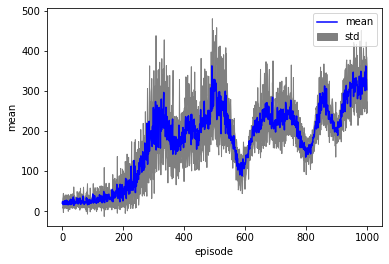

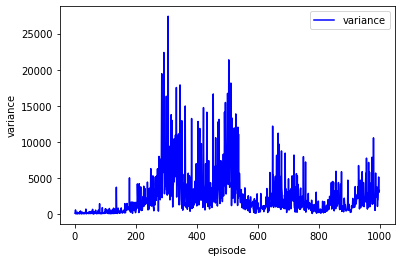

In [24]:
plt.figure()
std_low = np.asarray(mean2) - np.asarray(std2)
std_high = np.asarray(mean2) + np.asarray(std2)
plt.plot(mean2,c = 'b',label = 'mean' )
plt.fill_between(np.arange(0,len(mean2),1),std_low,std_high, color = 'gray',label = 'std')
plt.legend()
# plt.title('summing all the rewards along an episode')
plt.xlabel('episode')
plt.ylabel('mean')
plt.show()

plt.figure()
plt.plot(np.asarray(std2)**2,c = 'b', label = 'variance')
# plt.title('variance en fonction de l\'iteration')
plt.legend()
plt.xlabel('episode')
plt.ylabel('variance')
plt.show()

### Second algorithm: Focus on learning the baseline value

The `compute_critic_loss()` function above uses the Temporal Difference approach to critic estimation. In this part, we will compare it to using the Monte Carlo estimation approach.

As explained in [this video](https://www.youtube.com/watch?v=GcJ9hl3T6x8) and [these slides](http://pages.isir.upmc.fr/~sigaud/teach/ps/5_pg_derivation3.pdf), the MC estimation approach uses the following equation:

$$\phi_{j+1} = \mathop{\mathrm{argmin}}_{\phi_j} 
    \frac{1}{m\times H}\sum_{i=1}^m 
    \sum_{t=1}^H 
        \left(
            \left(\sum_{k=t}^H \gamma^{k-t} r(s_k^{(i)},a_k^{(i)}) \right) - \hat{V}^\pi_{\phi_j}(s_t^{(i)})
        \right)^2
$$

The innermost sum of discounted rewards exactly corresponds to the computation of the `apply_discounted_sum()` function. The rest just consists in computing the squared difference (also known as the Means Squared Error, or MSE) over the $m \times H$ samples ($m$ episodes of lenght $H$) that we have collected.

From the above information, create a `compute_critic_loss_mc()` function which must be called after `apply_discounted_sum()` on the reward.

In [25]:
def compute_critic_loss_mc(cfg, reward, must_bootstrap, v_values):
    squared_diff = torch.sum((reward - v_values)**2)
    loss = squared_diff / (reward.size(0) * reward.size(1))
    return loss, squared_diff

Then compare the learning dynamics and the learned critic using the Temporal Difference estimation approach and the Monte Carlo estimation approach.

In [26]:
torch.manual_seed(config.algorithm.seed)
config=OmegaConf.create(params)
config.gamma = 0.99
config.logger.log_dir = "./tblogs/reinforce_dreward_mc_critic-" + str(time.time())

mean3, std3 = run_reinforce(config, compute_reward=apply_discounted_sum, compute_critic_loss= compute_critic_loss_mc)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
  0%|          | 2/1000 [00:00<01:53,  8.79it/s]

episode: 0, reward: 21.0, std: 11.161157608032227
episode: 1, reward: 24.875, std: 13.097846031188965


  0%|          | 5/1000 [00:00<01:46,  9.33it/s]

episode: 2, reward: 22.5, std: 23.904571533203125
episode: 3, reward: 17.25, std: 5.203021049499512
episode: 4, reward: 24.875, std: 9.171968460083008


  1%|          | 7/1000 [00:00<01:54,  8.67it/s]

episode: 5, reward: 24.5, std: 9.426406860351562
episode: 6, reward: 24.25, std: 14.906853675842285


  1%|          | 9/1000 [00:01<01:49,  9.01it/s]

episode: 7, reward: 17.5, std: 4.840306758880615
episode: 8, reward: 26.75, std: 15.872258186340332


  1%|          | 11/1000 [00:01<01:40,  9.87it/s]

episode: 9, reward: 21.5, std: 9.957050323486328
episode: 10, reward: 21.25, std: 5.775564193725586
episode: 11, reward: 17.625, std: 9.179752349853516


  1%|▏         | 13/1000 [00:01<01:37, 10.17it/s]

episode: 12, reward: 23.125, std: 10.105691909790039
episode: 13, reward: 28.125, std: 14.416632652282715


  2%|▏         | 15/1000 [00:01<01:40,  9.77it/s]

episode: 14, reward: 24.25, std: 10.166471481323242
episode: 15, reward: 17.375, std: 4.627171516418457
episode: 16, reward: 24.625, std: 15.518997192382812


  2%|▏         | 19/1000 [00:02<01:47,  9.13it/s]

episode: 17, reward: 26.625, std: 11.819324493408203
episode: 18, reward: 22.5, std: 20.791481018066406


  2%|▏         | 21/1000 [00:02<01:40,  9.72it/s]

episode: 19, reward: 16.625, std: 7.981004238128662
episode: 20, reward: 22.875, std: 12.357039451599121


  2%|▏         | 22/1000 [00:02<01:43,  9.47it/s]

episode: 21, reward: 23.75, std: 13.59359073638916
episode: 22, reward: 17.625, std: 3.8521792888641357
episode: 23, reward: 23.25, std: 17.30194091796875


  3%|▎         | 26/1000 [00:02<01:36, 10.07it/s]

episode: 24, reward: 21.25, std: 9.051440238952637
episode: 25, reward: 26.625, std: 8.568005561828613
episode: 26, reward: 22.75, std: 10.402609825134277


  3%|▎         | 30/1000 [00:03<01:31, 10.57it/s]

episode: 27, reward: 30.5, std: 14.010200500488281
episode: 28, reward: 17.25, std: 6.041522979736328
episode: 29, reward: 23.625, std: 10.418904304504395


  3%|▎         | 32/1000 [00:03<01:37,  9.89it/s]

episode: 30, reward: 23.125, std: 12.147163391113281
episode: 31, reward: 23.25, std: 14.280356407165527
episode: 32, reward: 18.5, std: 5.756983280181885


  3%|▎         | 34/1000 [00:03<01:36, 10.00it/s]

episode: 33, reward: 31.125, std: 14.416632652282715
episode: 34, reward: 22.5, std: 9.754119873046875


  4%|▎         | 36/1000 [00:03<01:37,  9.85it/s]

episode: 35, reward: 21.0, std: 10.169983863830566
episode: 36, reward: 36.25, std: 26.19023895263672

  4%|▍         | 38/1000 [00:04<02:00,  7.96it/s]


episode: 37, reward: 32.875, std: 11.861552238464355


  4%|▍         | 40/1000 [00:04<01:47,  8.96it/s]

episode: 38, reward: 15.25, std: 5.2847490310668945
episode: 39, reward: 28.5, std: 11.637377738952637
episode: 40, reward: 23.125, std: 11.255950927734375


  4%|▍         | 43/1000 [00:04<01:43,  9.28it/s]

episode: 41, reward: 18.75, std: 11.535658836364746
episode: 42, reward: 24.75, std: 10.964227676391602


  4%|▍         | 44/1000 [00:04<01:43,  9.22it/s]

episode: 43, reward: 21.75, std: 14.300349235534668
episode: 44, reward: 24.375, std: 10.835622787475586
episode: 45, reward: 20.375, std: 9.59073257446289


  5%|▍         | 48/1000 [00:05<01:41,  9.34it/s]

episode: 46, reward: 24.0, std: 6.27921724319458
episode: 47, reward: 32.5, std: 18.423587799072266


  5%|▌         | 50/1000 [00:05<01:55,  8.20it/s]

episode: 48, reward: 34.0, std: 10.419761657714844
episode: 49, reward: 30.875, std: 16.20791244506836


  5%|▌         | 52/1000 [00:05<02:06,  7.50it/s]

episode: 50, reward: 29.375, std: 16.851770401000977
episode: 51, reward: 31.875, std: 14.7883882522583


  5%|▌         | 54/1000 [00:05<01:49,  8.66it/s]

episode: 52, reward: 18.625, std: 7.558108329772949
episode: 53, reward: 23.875, std: 10.669548988342285


  6%|▌         | 56/1000 [00:06<01:53,  8.28it/s]

episode: 54, reward: 30.875, std: 19.526081085205078
episode: 55, reward: 22.875, std: 13.206464767456055


  6%|▌         | 57/1000 [00:06<01:58,  7.95it/s]

episode: 56, reward: 21.625, std: 17.045631408691406
episode: 57, reward: 24.375, std: 8.683934211730957


  6%|▌         | 60/1000 [00:06<02:05,  7.50it/s]

episode: 58, reward: 33.75, std: 25.53848648071289
episode: 59, reward: 24.5, std: 12.0118989944458


  6%|▌         | 62/1000 [00:06<01:43,  9.10it/s]

episode: 60, reward: 18.5, std: 5.451081275939941
episode: 61, reward: 17.875, std: 5.276294708251953


  6%|▋         | 63/1000 [00:07<01:52,  8.36it/s]

episode: 62, reward: 27.75, std: 17.449928283691406
episode: 63, reward: 20.625, std: 6.232117176055908
episode: 64, reward: 20.25, std: 9.881440162658691


  7%|▋         | 67/1000 [00:07<01:48,  8.63it/s]

episode: 65, reward: 27.25, std: 16.756662368774414
episode: 66, reward: 22.125, std: 10.176127433776855


  7%|▋         | 68/1000 [00:07<01:52,  8.32it/s]

episode: 67, reward: 27.0, std: 15.01427936553955
episode: 68, reward: 38.625, std: 23.194442749023438


  7%|▋         | 71/1000 [00:07<01:55,  8.03it/s]

episode: 69, reward: 29.5, std: 11.351526260375977
episode: 70, reward: 24.25, std: 14.230249404907227


  7%|▋         | 74/1000 [00:08<01:39,  9.32it/s]

episode: 71, reward: 21.125, std: 8.935283660888672
episode: 72, reward: 17.625, std: 4.068608283996582
episode: 73, reward: 24.5, std: 10.198039054870605


  8%|▊         | 76/1000 [00:08<01:44,  8.82it/s]

episode: 74, reward: 20.875, std: 12.357039451599121
episode: 75, reward: 23.125, std: 16.487548828125


  8%|▊         | 78/1000 [00:08<02:03,  7.44it/s]

episode: 76, reward: 23.875, std: 12.732831954956055
episode: 77, reward: 24.375, std: 23.05234718322754


  8%|▊         | 80/1000 [00:09<02:00,  7.61it/s]

episode: 78, reward: 21.25, std: 8.048956871032715
episode: 79, reward: 34.125, std: 16.6256046295166


  8%|▊         | 81/1000 [00:09<02:16,  6.75it/s]

episode: 80, reward: 28.25, std: 23.426176071166992


  8%|▊         | 83/1000 [00:09<02:28,  6.18it/s]

episode: 81, reward: 32.5, std: 37.811561584472656
episode: 82, reward: 25.0, std: 13.627702713012695


  8%|▊         | 85/1000 [00:09<02:02,  7.46it/s]

episode: 83, reward: 16.75, std: 5.338539123535156
episode: 84, reward: 24.5, std: 11.43928050994873


  9%|▊         | 87/1000 [00:10<01:54,  7.96it/s]

episode: 85, reward: 29.125, std: 13.152267456054688
episode: 86, reward: 28.125, std: 11.5812349319458
episode: 87, reward: 18.0, std: 7.111359119415283


  9%|▉         | 89/1000 [00:10<01:41,  8.94it/s]

episode: 88, reward: 26.375, std: 10.756227493286133
episode: 89, reward: 19.5, std: 7.230885982513428


  9%|▉         | 92/1000 [00:10<01:46,  8.51it/s]

episode: 90, reward: 30.0, std: 29.770551681518555
episode: 91, reward: 23.5, std: 10.596495628356934


  9%|▉         | 94/1000 [00:10<01:41,  8.89it/s]

episode: 92, reward: 20.25, std: 12.555590629577637
episode: 93, reward: 23.875, std: 8.967202186584473


 10%|▉         | 96/1000 [00:11<01:41,  8.88it/s]

episode: 94, reward: 20.25, std: 13.509256362915039
episode: 95, reward: 22.625, std: 11.070391654968262


 10%|▉         | 98/1000 [00:11<01:40,  8.96it/s]

episode: 96, reward: 27.375, std: 8.959233283996582
episode: 97, reward: 28.125, std: 9.920217514038086


 10%|█         | 100/1000 [00:11<01:56,  7.74it/s]

episode: 98, reward: 25.625, std: 16.26510238647461
episode: 99, reward: 30.625, std: 13.595561027526855


 10%|█         | 102/1000 [00:11<02:13,  6.75it/s]

episode: 100, reward: 43.625, std: 26.986438751220703
episode: 101, reward: 23.875, std: 15.860440254211426


 10%|█         | 104/1000 [00:12<02:03,  7.26it/s]

episode: 102, reward: 20.875, std: 10.466784477233887
episode: 103, reward: 31.125, std: 16.728397369384766


 11%|█         | 106/1000 [00:12<02:11,  6.81it/s]

episode: 104, reward: 30.75, std: 25.53289222717285
episode: 105, reward: 23.875, std: 16.15494155883789


 11%|█         | 108/1000 [00:12<02:11,  6.77it/s]

episode: 106, reward: 39.375, std: 21.246427536010742
episode: 107, reward: 32.125, std: 14.004463195800781


 11%|█         | 110/1000 [00:13<02:00,  7.37it/s]

episode: 108, reward: 22.375, std: 9.085899353027344
episode: 109, reward: 25.25, std: 18.171798706054688


 11%|█         | 111/1000 [00:13<02:19,  6.38it/s]

episode: 110, reward: 27.0, std: 23.071317672729492
episode: 111, reward: 25.375, std: 24.383468627929688


 11%|█▏        | 114/1000 [00:13<02:14,  6.60it/s]

episode: 112, reward: 20.25, std: 6.227818012237549
episode: 113, reward: 33.25, std: 27.73213768005371


 12%|█▏        | 115/1000 [00:13<02:11,  6.73it/s]

episode: 114, reward: 28.0, std: 16.724660873413086
episode: 115, reward: 27.375, std: 9.59073257446289


 12%|█▏        | 117/1000 [00:14<02:05,  7.02it/s]

episode: 116, reward: 35.5, std: 23.02793312072754
episode: 117, reward: 22.25, std: 6.453127861022949
episode: 118, reward: 26.0, std: 10.677078247070312


 12%|█▏        | 121/1000 [00:14<01:50,  7.98it/s]

episode: 119, reward: 31.5, std: 19.346466064453125
episode: 120, reward: 29.5, std: 11.625096321105957
episode: 121, reward: 25.5, std: 7.1314191818237305
episode: 122, reward: 41.625, std: 22.715240478515625


 12%|█▏        | 124/1000 [00:15<02:07,  6.85it/s]

episode: 123, reward: 35.5, std: 24.905536651611328


 12%|█▎        | 125/1000 [00:15<02:21,  6.18it/s]

episode: 124, reward: 35.375, std: 24.088748931884766
episode: 125, reward: 25.75, std: 8.779033660888672


 13%|█▎        | 127/1000 [00:15<03:13,  4.50it/s]

episode: 126, reward: 39.75, std: 25.46566390991211


 13%|█▎        | 128/1000 [00:16<04:05,  3.55it/s]

episode: 127, reward: 31.0, std: 28.560712814331055


 13%|█▎        | 129/1000 [00:16<03:43,  3.89it/s]

episode: 128, reward: 31.375, std: 7.707834720611572


 13%|█▎        | 131/1000 [00:16<03:14,  4.47it/s]

episode: 129, reward: 37.25, std: 22.41651153564453
episode: 130, reward: 22.125, std: 10.105691909790039


 13%|█▎        | 132/1000 [00:17<03:07,  4.63it/s]

episode: 131, reward: 38.125, std: 25.969419479370117
episode: 132, reward: 22.25, std: 10.22252368927002


 14%|█▎        | 135/1000 [00:17<02:25,  5.96it/s]

episode: 133, reward: 31.5, std: 23.61597442626953
episode: 134, reward: 35.5, std: 15.79330825805664


 14%|█▎        | 136/1000 [00:17<02:12,  6.50it/s]

episode: 135, reward: 32.875, std: 10.722972869873047


 14%|█▎        | 137/1000 [00:17<03:10,  4.53it/s]

episode: 136, reward: 49.875, std: 60.950653076171875


 14%|█▍        | 139/1000 [00:18<02:42,  5.28it/s]

episode: 137, reward: 35.875, std: 23.90121078491211
episode: 138, reward: 24.75, std: 14.350211143493652


 14%|█▍        | 141/1000 [00:18<02:10,  6.61it/s]

episode: 139, reward: 22.25, std: 8.581542015075684
episode: 140, reward: 30.125, std: 11.14113998413086


 14%|█▍        | 142/1000 [00:18<02:52,  4.96it/s]

episode: 141, reward: 32.875, std: 27.68928337097168


 14%|█▍        | 143/1000 [00:19<04:53,  2.92it/s]

episode: 142, reward: 43.0, std: 28.470535278320312


 14%|█▍        | 144/1000 [00:19<04:31,  3.15it/s]

episode: 143, reward: 35.25, std: 23.432273864746094


 14%|█▍        | 145/1000 [00:20<04:17,  3.32it/s]

episode: 144, reward: 34.375, std: 20.9484920501709
episode: 145, reward: 29.25, std: 14.557766914367676


 15%|█▍        | 147/1000 [00:20<03:14,  4.39it/s]

episode: 146, reward: 24.75, std: 10.03920841217041


 15%|█▍        | 148/1000 [00:20<03:19,  4.28it/s]

episode: 147, reward: 41.75, std: 19.535680770874023
episode: 148, reward: 25.375, std: 19.74796485900879


 15%|█▌        | 150/1000 [00:21<03:09,  4.48it/s]

episode: 149, reward: 27.5, std: 15.51036548614502
episode: 150, reward: 34.0, std: 12.27075481414795


 15%|█▌        | 152/1000 [00:21<03:03,  4.61it/s]

episode: 151, reward: 40.25, std: 23.566017150878906


 15%|█▌        | 153/1000 [00:21<03:28,  4.06it/s]

episode: 152, reward: 42.875, std: 29.12258529663086


 15%|█▌        | 154/1000 [00:22<03:31,  4.01it/s]

episode: 153, reward: 43.125, std: 18.114221572875977
episode: 154, reward: 36.5, std: 19.58133316040039


 16%|█▌        | 157/1000 [00:22<02:30,  5.61it/s]

episode: 155, reward: 30.0, std: 19.06380271911621
episode: 156, reward: 30.25, std: 11.297913551330566


 16%|█▌        | 159/1000 [00:22<02:24,  5.80it/s]

episode: 157, reward: 36.0, std: 18.928436279296875
episode: 158, reward: 34.0, std: 19.82062339782715


 16%|█▌        | 161/1000 [00:23<02:07,  6.59it/s]

episode: 159, reward: 32.875, std: 17.049821853637695
episode: 160, reward: 29.75, std: 16.385969161987305


 16%|█▋        | 163/1000 [00:23<02:05,  6.68it/s]

episode: 161, reward: 28.875, std: 23.624670028686523
episode: 162, reward: 28.25, std: 14.538126945495605


 16%|█▋        | 164/1000 [00:23<01:55,  7.24it/s]

episode: 163, reward: 26.0, std: 12.603854179382324


 17%|█▋        | 166/1000 [00:23<02:18,  6.00it/s]

episode: 164, reward: 55.25, std: 37.99530029296875
episode: 165, reward: 29.75, std: 16.455568313598633


 17%|█▋        | 168/1000 [00:24<02:11,  6.31it/s]

episode: 166, reward: 24.375, std: 13.585049629211426
episode: 167, reward: 35.125, std: 23.715200424194336


 17%|█▋        | 169/1000 [00:24<03:02,  4.55it/s]

episode: 168, reward: 50.5, std: 29.94280242919922


 17%|█▋        | 170/1000 [00:25<05:02,  2.74it/s]

episode: 169, reward: 44.5, std: 30.75246810913086


 17%|█▋        | 171/1000 [00:26<07:12,  1.92it/s]

episode: 170, reward: 39.5, std: 23.9702205657959


 17%|█▋        | 173/1000 [00:27<06:45,  2.04it/s]

episode: 171, reward: 45.75, std: 38.29863739013672
episode: 172, reward: 33.375, std: 24.307186126708984


 17%|█▋        | 174/1000 [00:27<05:42,  2.41it/s]

episode: 173, reward: 47.5, std: 29.203718185424805
episode: 174, reward: 42.25, std: 26.09187126159668


 18%|█▊        | 176/1000 [00:27<04:10,  3.29it/s]

episode: 175, reward: 36.875, std: 28.427539825439453


 18%|█▊        | 177/1000 [00:28<04:14,  3.23it/s]

episode: 176, reward: 51.375, std: 24.552785873413086


 18%|█▊        | 178/1000 [00:28<04:29,  3.05it/s]

episode: 177, reward: 49.75, std: 31.689340591430664


 18%|█▊        | 179/1000 [00:28<04:09,  3.29it/s]

episode: 178, reward: 48.375, std: 28.809410095214844


 18%|█▊        | 180/1000 [00:29<04:53,  2.80it/s]

episode: 179, reward: 67.75, std: 70.78286743164062


 18%|█▊        | 182/1000 [00:29<03:35,  3.80it/s]

episode: 180, reward: 48.75, std: 21.385910034179688
episode: 181, reward: 40.375, std: 19.762428283691406


 18%|█▊        | 184/1000 [00:29<02:44,  4.95it/s]

episode: 182, reward: 33.0, std: 17.221248626708984
episode: 183, reward: 35.125, std: 15.824371337890625


 18%|█▊        | 185/1000 [00:30<02:51,  4.76it/s]

episode: 184, reward: 56.5, std: 32.40370178222656


 19%|█▊        | 186/1000 [00:30<03:18,  4.10it/s]

episode: 185, reward: 48.625, std: 40.88288879394531


 19%|█▉        | 188/1000 [00:30<02:54,  4.64it/s]

episode: 186, reward: 58.5, std: 31.973203659057617
episode: 187, reward: 33.375, std: 22.608074188232422


 19%|█▉        | 190/1000 [00:31<02:33,  5.26it/s]

episode: 188, reward: 30.0, std: 24.27815055847168
episode: 189, reward: 24.25, std: 10.416333198547363


 19%|█▉        | 191/1000 [00:31<02:59,  4.50it/s]

episode: 190, reward: 67.875, std: 40.877647399902344
episode: 191, reward: 36.875, std: 22.312313079833984


 19%|█▉        | 193/1000 [00:31<02:56,  4.57it/s]

episode: 192, reward: 51.875, std: 35.790809631347656


 19%|█▉        | 194/1000 [00:32<03:02,  4.42it/s]

episode: 193, reward: 42.75, std: 31.954208374023438


 20%|█▉        | 196/1000 [00:32<02:49,  4.74it/s]

episode: 194, reward: 58.75, std: 35.25721740722656
episode: 195, reward: 33.5, std: 21.454269409179688


 20%|█▉        | 197/1000 [00:32<03:09,  4.24it/s]

episode: 196, reward: 67.0, std: 39.871219635009766


 20%|█▉        | 198/1000 [00:33<03:05,  4.32it/s]

episode: 197, reward: 49.875, std: 31.543336868286133


 20%|██        | 200/1000 [00:33<02:46,  4.80it/s]

episode: 198, reward: 62.5, std: 40.18528366088867
episode: 199, reward: 26.375, std: 13.783400535583496


 20%|██        | 201/1000 [00:33<02:46,  4.80it/s]

episode: 200, reward: 53.25, std: 25.943620681762695


 20%|██        | 202/1000 [00:33<02:46,  4.80it/s]

episode: 201, reward: 50.75, std: 25.200624465942383


 20%|██        | 203/1000 [00:34<02:54,  4.58it/s]

episode: 202, reward: 41.625, std: 30.052038192749023


 20%|██        | 204/1000 [00:34<03:10,  4.19it/s]

episode: 203, reward: 56.75, std: 39.9883918762207


 20%|██        | 205/1000 [00:34<03:08,  4.22it/s]

episode: 204, reward: 53.125, std: 28.447633743286133


 21%|██        | 206/1000 [00:35<04:00,  3.30it/s]

episode: 205, reward: 61.125, std: 64.60746765136719


 21%|██        | 207/1000 [00:35<03:59,  3.32it/s]

episode: 206, reward: 58.5, std: 50.60491180419922


 21%|██        | 208/1000 [00:35<03:51,  3.42it/s]

episode: 207, reward: 66.75, std: 40.453678131103516


 21%|██        | 209/1000 [00:35<04:04,  3.24it/s]

episode: 208, reward: 82.5, std: 42.25094985961914


 21%|██        | 210/1000 [00:36<04:55,  2.68it/s]

episode: 209, reward: 69.25, std: 45.94639587402344


 21%|██        | 211/1000 [00:36<05:06,  2.57it/s]

episode: 210, reward: 32.375, std: 14.33215618133545


 21%|██        | 212/1000 [00:38<08:28,  1.55it/s]

episode: 211, reward: 79.625, std: 64.83811950683594


 21%|██▏       | 213/1000 [00:38<08:48,  1.49it/s]

episode: 212, reward: 53.375, std: 50.514320373535156


 21%|██▏       | 214/1000 [00:39<07:01,  1.87it/s]

episode: 213, reward: 52.75, std: 24.040145874023438


 22%|██▏       | 215/1000 [00:39<06:27,  2.03it/s]

episode: 214, reward: 62.75, std: 54.36582565307617


 22%|██▏       | 216/1000 [00:39<05:29,  2.38it/s]

episode: 215, reward: 54.25, std: 35.871795654296875


 22%|██▏       | 217/1000 [00:40<05:49,  2.24it/s]

episode: 216, reward: 75.0, std: 61.344459533691406


 22%|██▏       | 218/1000 [00:40<05:35,  2.33it/s]

episode: 217, reward: 51.5, std: 26.76885223388672
episode: 218, reward: 43.375, std: 21.954092025756836


 22%|██▏       | 220/1000 [00:41<04:02,  3.21it/s]

episode: 219, reward: 49.5, std: 25.326440811157227


 22%|██▏       | 221/1000 [00:41<04:01,  3.23it/s]

episode: 220, reward: 78.875, std: 41.89932632446289
episode: 221, reward: 44.625, std: 22.759220123291016


 22%|██▏       | 223/1000 [00:41<03:29,  3.71it/s]

episode: 222, reward: 64.375, std: 31.08025360107422


 22%|██▏       | 224/1000 [00:42<03:44,  3.46it/s]

episode: 223, reward: 57.625, std: 48.752838134765625


 22%|██▎       | 225/1000 [00:42<03:38,  3.55it/s]

episode: 224, reward: 57.625, std: 33.27778244018555


 23%|██▎       | 226/1000 [00:42<03:47,  3.40it/s]

episode: 225, reward: 66.5, std: 46.6414909362793


 23%|██▎       | 227/1000 [00:43<04:13,  3.05it/s]

episode: 226, reward: 113.125, std: 62.100006103515625


 23%|██▎       | 228/1000 [00:43<03:54,  3.29it/s]

episode: 227, reward: 53.25, std: 33.07891082763672


 23%|██▎       | 229/1000 [00:43<03:56,  3.26it/s]

episode: 228, reward: 74.25, std: 40.013389587402344


 23%|██▎       | 230/1000 [00:43<03:49,  3.35it/s]

episode: 229, reward: 65.375, std: 35.480125427246094


 23%|██▎       | 231/1000 [00:44<04:07,  3.11it/s]

episode: 230, reward: 68.0, std: 59.322364807128906


 23%|██▎       | 232/1000 [00:45<05:27,  2.34it/s]

episode: 231, reward: 69.5, std: 44.880794525146484


 23%|██▎       | 233/1000 [00:45<05:48,  2.20it/s]

episode: 232, reward: 53.0, std: 36.8316650390625


 23%|██▎       | 234/1000 [00:46<05:58,  2.14it/s]

episode: 233, reward: 75.0, std: 40.41216278076172


 24%|██▎       | 235/1000 [00:46<05:17,  2.41it/s]

episode: 234, reward: 83.375, std: 40.732357025146484


 24%|██▎       | 236/1000 [00:46<05:36,  2.27it/s]

episode: 235, reward: 127.25, std: 46.744747161865234


 24%|██▎       | 237/1000 [00:47<04:56,  2.57it/s]

episode: 236, reward: 61.375, std: 40.517852783203125


 24%|██▍       | 238/1000 [00:47<04:39,  2.73it/s]

episode: 237, reward: 79.125, std: 39.2880859375


 24%|██▍       | 239/1000 [00:47<05:19,  2.38it/s]

episode: 238, reward: 113.875, std: 66.52912902832031


 24%|██▍       | 240/1000 [00:48<04:52,  2.59it/s]

episode: 239, reward: 60.25, std: 50.49681854248047
episode: 240, reward: 47.125, std: 23.793380737304688


 24%|██▍       | 242/1000 [00:48<04:18,  2.94it/s]

episode: 241, reward: 62.75, std: 51.76526641845703


 24%|██▍       | 243/1000 [00:49<04:41,  2.69it/s]

episode: 242, reward: 89.125, std: 58.75721740722656


 24%|██▍       | 244/1000 [00:49<04:09,  3.03it/s]

episode: 243, reward: 63.625, std: 25.91710662841797


 24%|██▍       | 245/1000 [00:49<04:07,  3.04it/s]

episode: 244, reward: 78.125, std: 35.63881301879883


 25%|██▍       | 246/1000 [00:50<04:42,  2.67it/s]

episode: 245, reward: 94.0, std: 59.895145416259766


 25%|██▍       | 247/1000 [00:50<04:27,  2.81it/s]

episode: 246, reward: 73.125, std: 33.947174072265625


 25%|██▍       | 248/1000 [00:51<04:43,  2.65it/s]

episode: 247, reward: 102.0, std: 54.77747344970703


 25%|██▍       | 249/1000 [00:51<04:43,  2.65it/s]

episode: 248, reward: 95.625, std: 48.461875915527344


 25%|██▌       | 250/1000 [00:52<05:34,  2.24it/s]

episode: 249, reward: 96.5, std: 79.33473205566406


 25%|██▌       | 251/1000 [00:52<05:21,  2.33it/s]

episode: 250, reward: 79.875, std: 51.09217834472656


 25%|██▌       | 252/1000 [00:52<05:42,  2.18it/s]

episode: 251, reward: 102.25, std: 56.332557678222656


 25%|██▌       | 253/1000 [00:53<05:34,  2.23it/s]

episode: 252, reward: 121.875, std: 33.12071990966797


 25%|██▌       | 254/1000 [00:53<05:29,  2.26it/s]

episode: 253, reward: 92.625, std: 47.12274932861328


 26%|██▌       | 255/1000 [00:54<05:14,  2.37it/s]

episode: 254, reward: 95.375, std: 51.05162048339844


 26%|██▌       | 256/1000 [00:54<05:21,  2.31it/s]

episode: 255, reward: 114.875, std: 36.6934700012207


 26%|██▌       | 257/1000 [00:55<05:59,  2.07it/s]

episode: 256, reward: 132.875, std: 72.7430648803711


 26%|██▌       | 258/1000 [00:55<05:36,  2.20it/s]

episode: 257, reward: 116.5, std: 32.81550216674805


 26%|██▌       | 259/1000 [00:56<05:36,  2.20it/s]

episode: 258, reward: 138.75, std: 29.97498893737793


 26%|██▌       | 260/1000 [00:56<05:14,  2.35it/s]

episode: 259, reward: 113.5, std: 21.1660099029541


 26%|██▌       | 261/1000 [00:56<05:29,  2.24it/s]

episode: 260, reward: 125.5, std: 51.34199142456055


 26%|██▌       | 262/1000 [00:57<05:40,  2.17it/s]

episode: 261, reward: 98.125, std: 58.498931884765625


 26%|██▋       | 263/1000 [00:57<05:34,  2.20it/s]

episode: 262, reward: 129.875, std: 35.12604904174805


 26%|██▋       | 264/1000 [00:58<05:58,  2.05it/s]

episode: 263, reward: 108.875, std: 64.70027160644531


 26%|██▋       | 265/1000 [00:58<06:10,  1.98it/s]

episode: 264, reward: 149.375, std: 71.73749542236328


 27%|██▋       | 266/1000 [00:59<06:22,  1.92it/s]

episode: 265, reward: 129.75, std: 56.33763122558594


 27%|██▋       | 267/1000 [01:00<07:29,  1.63it/s]

episode: 266, reward: 123.75, std: 67.85857391357422


 27%|██▋       | 268/1000 [01:00<06:30,  1.87it/s]

episode: 267, reward: 102.625, std: 43.644466400146484


 27%|██▋       | 269/1000 [01:01<06:22,  1.91it/s]

episode: 268, reward: 113.0, std: 72.61640930175781


 27%|██▋       | 270/1000 [01:01<06:00,  2.02it/s]

episode: 269, reward: 118.25, std: 49.953548431396484


 27%|██▋       | 271/1000 [01:02<05:57,  2.04it/s]

episode: 270, reward: 109.375, std: 58.81675720214844


 27%|██▋       | 272/1000 [01:02<06:32,  1.86it/s]

episode: 271, reward: 171.0, std: 79.15084838867188


 27%|██▋       | 273/1000 [01:03<06:24,  1.89it/s]

episode: 272, reward: 144.0, std: 49.46571731567383


 27%|██▋       | 274/1000 [01:03<06:34,  1.84it/s]

episode: 273, reward: 131.5, std: 70.5650634765625


 28%|██▊       | 275/1000 [01:04<06:22,  1.89it/s]

episode: 274, reward: 147.375, std: 20.099306106567383


 28%|██▊       | 276/1000 [01:05<06:55,  1.74it/s]

episode: 275, reward: 131.25, std: 67.09002685546875


 28%|██▊       | 277/1000 [01:06<09:44,  1.24it/s]

episode: 276, reward: 128.625, std: 89.35153198242188


 28%|██▊       | 278/1000 [01:07<10:48,  1.11it/s]

episode: 277, reward: 146.125, std: 53.14249801635742


 28%|██▊       | 279/1000 [01:08<10:43,  1.12it/s]

episode: 278, reward: 220.375, std: 87.57190704345703


 28%|██▊       | 280/1000 [01:09<09:46,  1.23it/s]

episode: 279, reward: 176.875, std: 47.738685607910156


 28%|██▊       | 281/1000 [01:09<08:34,  1.40it/s]

episode: 280, reward: 117.75, std: 44.506019592285156


 28%|██▊       | 282/1000 [01:10<08:19,  1.44it/s]

episode: 281, reward: 158.25, std: 53.454254150390625


 28%|██▊       | 283/1000 [01:10<07:41,  1.55it/s]

episode: 282, reward: 142.875, std: 70.5963134765625


 28%|██▊       | 284/1000 [01:11<09:17,  1.28it/s]

episode: 283, reward: 144.25, std: 49.82469177246094


 28%|██▊       | 285/1000 [01:13<11:16,  1.06it/s]

episode: 284, reward: 183.875, std: 98.91473388671875


 29%|██▊       | 286/1000 [01:14<11:36,  1.02it/s]

episode: 285, reward: 225.125, std: 139.4811248779297


 29%|██▊       | 287/1000 [01:14<09:54,  1.20it/s]

episode: 286, reward: 150.5, std: 47.659507751464844


 29%|██▉       | 288/1000 [01:15<08:54,  1.33it/s]

episode: 287, reward: 174.625, std: 57.59200668334961


 29%|██▉       | 289/1000 [01:15<08:48,  1.35it/s]

episode: 288, reward: 177.875, std: 97.89270782470703


 29%|██▉       | 290/1000 [01:17<10:06,  1.17it/s]

episode: 289, reward: 186.25, std: 75.76985931396484


 29%|██▉       | 291/1000 [01:18<11:45,  1.01it/s]

episode: 290, reward: 193.625, std: 105.99182891845703


 29%|██▉       | 292/1000 [01:19<11:04,  1.07it/s]

episode: 291, reward: 201.25, std: 107.59414672851562


 29%|██▉       | 293/1000 [01:20<11:16,  1.05it/s]

episode: 292, reward: 183.25, std: 149.62405395507812


 29%|██▉       | 294/1000 [01:21<10:48,  1.09it/s]

episode: 293, reward: 201.75, std: 105.39551544189453


 30%|██▉       | 295/1000 [01:21<09:47,  1.20it/s]

episode: 294, reward: 192.0, std: 52.98247528076172


 30%|██▉       | 296/1000 [01:22<09:02,  1.30it/s]

episode: 295, reward: 162.125, std: 63.88703918457031


 30%|██▉       | 297/1000 [01:22<08:40,  1.35it/s]

episode: 296, reward: 212.375, std: 61.82680130004883


 30%|██▉       | 298/1000 [01:23<08:27,  1.38it/s]

episode: 297, reward: 170.0, std: 89.30205535888672


 30%|██▉       | 299/1000 [01:24<08:22,  1.39it/s]

episode: 298, reward: 198.0, std: 89.62779998779297


 30%|███       | 300/1000 [01:25<09:03,  1.29it/s]

episode: 299, reward: 259.5, std: 93.17265319824219


 30%|███       | 301/1000 [01:26<09:24,  1.24it/s]

episode: 300, reward: 174.25, std: 127.77519226074219


 30%|███       | 302/1000 [01:26<08:59,  1.29it/s]

episode: 301, reward: 188.875, std: 57.692378997802734


 30%|███       | 303/1000 [01:27<08:17,  1.40it/s]

episode: 302, reward: 167.875, std: 70.70549774169922


 30%|███       | 304/1000 [01:27<07:56,  1.46it/s]

episode: 303, reward: 184.375, std: 51.18855285644531


 30%|███       | 305/1000 [01:28<08:28,  1.37it/s]

episode: 304, reward: 254.5, std: 60.63945007324219


 31%|███       | 306/1000 [01:29<07:52,  1.47it/s]

episode: 305, reward: 178.75, std: 59.62202453613281


 31%|███       | 307/1000 [01:30<09:14,  1.25it/s]

episode: 306, reward: 274.375, std: 165.5682373046875


 31%|███       | 308/1000 [01:31<08:59,  1.28it/s]

episode: 307, reward: 200.75, std: 58.538753509521484


 31%|███       | 309/1000 [01:31<08:46,  1.31it/s]

episode: 308, reward: 153.5, std: 52.77174758911133


 31%|███       | 310/1000 [01:32<09:22,  1.23it/s]

episode: 309, reward: 217.125, std: 96.37640380859375


 31%|███       | 311/1000 [01:33<09:21,  1.23it/s]

episode: 310, reward: 243.625, std: 88.2365951538086


 31%|███       | 312/1000 [01:34<09:23,  1.22it/s]

episode: 311, reward: 265.125, std: 61.410648345947266


 31%|███▏      | 313/1000 [01:35<08:45,  1.31it/s]

episode: 312, reward: 191.0, std: 44.26543426513672


 31%|███▏      | 314/1000 [01:36<09:06,  1.25it/s]

episode: 313, reward: 256.5, std: 97.16995239257812


 32%|███▏      | 315/1000 [01:36<08:53,  1.28it/s]

episode: 314, reward: 251.375, std: 71.36412811279297


 32%|███▏      | 316/1000 [01:37<07:58,  1.43it/s]

episode: 315, reward: 160.0, std: 55.72637176513672


 32%|███▏      | 317/1000 [01:38<09:14,  1.23it/s]

episode: 316, reward: 238.875, std: 117.3498306274414


 32%|███▏      | 318/1000 [01:39<09:03,  1.26it/s]

episode: 317, reward: 258.875, std: 49.929771423339844


 32%|███▏      | 319/1000 [01:40<10:05,  1.12it/s]

episode: 318, reward: 259.5, std: 114.03382873535156


 32%|███▏      | 320/1000 [01:40<09:24,  1.20it/s]

episode: 319, reward: 221.75, std: 70.43892669677734


 32%|███▏      | 321/1000 [01:41<09:12,  1.23it/s]

episode: 320, reward: 240.25, std: 69.10395812988281


 32%|███▏      | 322/1000 [01:42<08:50,  1.28it/s]

episode: 321, reward: 234.0, std: 31.190658569335938


 32%|███▏      | 323/1000 [01:42<08:04,  1.40it/s]

episode: 322, reward: 158.25, std: 65.62610626220703


 32%|███▏      | 324/1000 [01:43<08:10,  1.38it/s]

episode: 323, reward: 251.75, std: 63.43894577026367


 32%|███▎      | 325/1000 [01:44<08:03,  1.40it/s]

episode: 324, reward: 200.375, std: 77.31925964355469


 33%|███▎      | 326/1000 [01:45<08:38,  1.30it/s]

episode: 325, reward: 280.5, std: 102.0112075805664


 33%|███▎      | 327/1000 [01:45<08:16,  1.36it/s]

episode: 326, reward: 203.75, std: 66.7784194946289


 33%|███▎      | 328/1000 [01:46<08:22,  1.34it/s]

episode: 327, reward: 229.0, std: 75.76844787597656


 33%|███▎      | 329/1000 [01:47<08:49,  1.27it/s]

episode: 328, reward: 254.875, std: 87.17705535888672


 33%|███▎      | 330/1000 [01:48<08:40,  1.29it/s]

episode: 329, reward: 211.5, std: 93.63150024414062


 33%|███▎      | 331/1000 [01:49<09:10,  1.22it/s]

episode: 330, reward: 252.5, std: 104.60128021240234


 33%|███▎      | 332/1000 [01:50<09:22,  1.19it/s]

episode: 331, reward: 226.375, std: 72.61038208007812


 33%|███▎      | 333/1000 [01:50<09:16,  1.20it/s]

episode: 332, reward: 272.0, std: 71.79932403564453


 33%|███▎      | 334/1000 [01:52<10:06,  1.10it/s]

episode: 333, reward: 297.125, std: 132.42727661132812


 34%|███▎      | 335/1000 [01:52<09:22,  1.18it/s]

episode: 334, reward: 207.625, std: 48.49723815917969


 34%|███▎      | 336/1000 [01:53<09:21,  1.18it/s]

episode: 335, reward: 239.875, std: 80.47969818115234


 34%|███▎      | 337/1000 [01:54<08:59,  1.23it/s]

episode: 336, reward: 234.25, std: 63.62333297729492


 34%|███▍      | 338/1000 [01:55<08:55,  1.24it/s]

episode: 337, reward: 221.375, std: 103.79779815673828


 34%|███▍      | 339/1000 [01:55<08:34,  1.28it/s]

episode: 338, reward: 187.0, std: 82.63516998291016


 34%|███▍      | 340/1000 [01:56<08:23,  1.31it/s]

episode: 339, reward: 188.75, std: 64.20447540283203


 34%|███▍      | 341/1000 [01:57<09:22,  1.17it/s]

episode: 340, reward: 260.125, std: 105.374755859375


 34%|███▍      | 342/1000 [01:58<09:16,  1.18it/s]

episode: 341, reward: 223.5, std: 67.03304290771484


 34%|███▍      | 343/1000 [01:59<08:28,  1.29it/s]

episode: 342, reward: 191.625, std: 35.59669876098633


 34%|███▍      | 344/1000 [01:59<07:48,  1.40it/s]

episode: 343, reward: 178.875, std: 45.33506393432617


 34%|███▍      | 345/1000 [02:00<08:18,  1.32it/s]

episode: 344, reward: 237.125, std: 102.55094909667969


 35%|███▍      | 346/1000 [02:01<09:23,  1.16it/s]

episode: 345, reward: 206.25, std: 133.763916015625


 35%|███▍      | 347/1000 [02:02<09:03,  1.20it/s]

episode: 346, reward: 193.875, std: 62.049373626708984


 35%|███▍      | 348/1000 [02:03<09:30,  1.14it/s]

episode: 347, reward: 212.0, std: 98.19368743896484


 35%|███▍      | 349/1000 [02:04<08:58,  1.21it/s]

episode: 348, reward: 205.125, std: 68.42605590820312


 35%|███▌      | 350/1000 [02:04<08:34,  1.26it/s]

episode: 349, reward: 177.75, std: 55.40177917480469


 35%|███▌      | 351/1000 [02:05<07:47,  1.39it/s]

episode: 350, reward: 180.0, std: 35.44009017944336


 35%|███▌      | 352/1000 [02:06<08:36,  1.25it/s]

episode: 351, reward: 227.125, std: 113.70819854736328


 35%|███▌      | 353/1000 [02:06<07:39,  1.41it/s]

episode: 352, reward: 174.625, std: 27.495128631591797


 35%|███▌      | 354/1000 [02:07<07:16,  1.48it/s]

episode: 353, reward: 204.75, std: 43.37131881713867


 36%|███▌      | 355/1000 [02:07<06:47,  1.58it/s]

episode: 354, reward: 167.875, std: 23.074026107788086


 36%|███▌      | 356/1000 [02:08<06:32,  1.64it/s]

episode: 355, reward: 167.0, std: 53.25410842895508


 36%|███▌      | 357/1000 [02:09<06:36,  1.62it/s]

episode: 356, reward: 154.375, std: 65.15681457519531


 36%|███▌      | 358/1000 [02:09<06:44,  1.59it/s]

episode: 357, reward: 215.25, std: 50.93342971801758


 36%|███▌      | 359/1000 [02:10<06:21,  1.68it/s]

episode: 358, reward: 163.25, std: 33.285560607910156


 36%|███▌      | 360/1000 [02:10<06:10,  1.73it/s]

episode: 359, reward: 156.75, std: 74.29237365722656


 36%|███▌      | 361/1000 [02:11<06:19,  1.68it/s]

episode: 360, reward: 195.125, std: 64.51232147216797


 36%|███▌      | 362/1000 [02:12<07:40,  1.38it/s]

episode: 361, reward: 202.625, std: 90.3199691772461


 36%|███▋      | 363/1000 [02:13<08:44,  1.21it/s]

episode: 362, reward: 230.75, std: 122.35633087158203


 36%|███▋      | 364/1000 [02:14<07:46,  1.36it/s]

episode: 363, reward: 143.0, std: 57.52763366699219


 36%|███▋      | 365/1000 [02:14<07:11,  1.47it/s]

episode: 364, reward: 172.25, std: 45.00714111328125


 37%|███▋      | 366/1000 [02:15<06:33,  1.61it/s]

episode: 365, reward: 166.875, std: 30.511999130249023


 37%|███▋      | 367/1000 [02:15<06:11,  1.70it/s]

episode: 366, reward: 162.125, std: 40.01941680908203


 37%|███▋      | 368/1000 [02:16<06:02,  1.74it/s]

episode: 367, reward: 187.375, std: 30.236862182617188


 37%|███▋      | 369/1000 [02:16<06:12,  1.70it/s]

episode: 368, reward: 174.125, std: 64.5809326171875


 37%|███▋      | 370/1000 [02:17<05:45,  1.82it/s]

episode: 369, reward: 154.0, std: 25.701583862304688


 37%|███▋      | 371/1000 [02:17<05:43,  1.83it/s]

episode: 370, reward: 184.625, std: 37.890586853027344


 37%|███▋      | 372/1000 [02:18<05:52,  1.78it/s]

episode: 371, reward: 179.25, std: 36.09016418457031


 37%|███▋      | 373/1000 [02:19<06:01,  1.73it/s]

episode: 372, reward: 143.0, std: 75.21588134765625


 37%|███▋      | 374/1000 [02:19<06:14,  1.67it/s]

episode: 373, reward: 186.375, std: 52.839210510253906


 38%|███▊      | 375/1000 [02:20<06:06,  1.71it/s]

episode: 374, reward: 158.875, std: 51.5570068359375


 38%|███▊      | 376/1000 [02:20<05:38,  1.84it/s]

episode: 375, reward: 156.75, std: 32.37172317504883


 38%|███▊      | 377/1000 [02:21<05:58,  1.74it/s]

episode: 376, reward: 162.5, std: 72.8638687133789


 38%|███▊      | 378/1000 [02:21<05:51,  1.77it/s]

episode: 377, reward: 180.375, std: 37.221107482910156


 38%|███▊      | 379/1000 [02:22<05:29,  1.89it/s]

episode: 378, reward: 150.25, std: 19.535680770874023
episode: 379, reward: 176.75, std: 53.0545539855957


 38%|███▊      | 381/1000 [02:23<06:50,  1.51it/s]

episode: 380, reward: 153.5, std: 70.49011993408203


 38%|███▊      | 382/1000 [02:24<06:24,  1.61it/s]

episode: 381, reward: 164.625, std: 33.269195556640625


 38%|███▊      | 383/1000 [02:24<05:58,  1.72it/s]

episode: 382, reward: 172.25, std: 29.884300231933594


 38%|███▊      | 384/1000 [02:25<07:12,  1.43it/s]

episode: 383, reward: 215.375, std: 115.05642700195312


 38%|███▊      | 385/1000 [02:26<06:38,  1.54it/s]

episode: 384, reward: 173.5, std: 27.69218635559082


 39%|███▊      | 386/1000 [02:26<06:06,  1.67it/s]

episode: 385, reward: 163.375, std: 29.64522361755371


 39%|███▊      | 387/1000 [02:27<05:53,  1.74it/s]

episode: 386, reward: 174.0, std: 41.11655807495117


 39%|███▉      | 388/1000 [02:28<05:54,  1.73it/s]

episode: 387, reward: 176.375, std: 50.09116744995117


 39%|███▉      | 389/1000 [02:28<05:38,  1.80it/s]

episode: 388, reward: 152.625, std: 30.170644760131836


 39%|███▉      | 390/1000 [02:29<06:04,  1.67it/s]

episode: 389, reward: 186.375, std: 59.02042770385742


 39%|███▉      | 391/1000 [02:29<05:47,  1.75it/s]

episode: 390, reward: 167.0, std: 34.83430099487305


 39%|███▉      | 392/1000 [02:30<05:43,  1.77it/s]

episode: 391, reward: 174.75, std: 38.795249938964844


 39%|███▉      | 393/1000 [02:30<05:42,  1.77it/s]

episode: 392, reward: 197.625, std: 51.015228271484375


 39%|███▉      | 394/1000 [02:31<05:30,  1.83it/s]

episode: 393, reward: 170.5, std: 38.407588958740234


 40%|███▉      | 395/1000 [02:32<05:42,  1.77it/s]

episode: 394, reward: 173.625, std: 60.235103607177734


 40%|███▉      | 396/1000 [02:32<06:05,  1.65it/s]

episode: 395, reward: 176.125, std: 67.73358917236328


 40%|███▉      | 397/1000 [02:33<06:05,  1.65it/s]

episode: 396, reward: 209.5, std: 40.900577545166016


 40%|███▉      | 398/1000 [02:33<06:13,  1.61it/s]

episode: 397, reward: 187.25, std: 64.54621887207031


 40%|███▉      | 399/1000 [02:34<06:29,  1.54it/s]

episode: 398, reward: 159.5, std: 83.49507904052734


 40%|████      | 400/1000 [02:35<06:24,  1.56it/s]

episode: 399, reward: 201.25, std: 58.08306884765625


 40%|████      | 401/1000 [02:35<06:10,  1.62it/s]

episode: 400, reward: 185.625, std: 33.491737365722656


 40%|████      | 402/1000 [02:36<06:27,  1.54it/s]

episode: 401, reward: 203.5, std: 81.24390411376953


 40%|████      | 403/1000 [02:37<06:44,  1.48it/s]

episode: 402, reward: 198.625, std: 67.69878387451172


 40%|████      | 404/1000 [02:37<06:21,  1.56it/s]

episode: 403, reward: 172.875, std: 57.5560302734375


 40%|████      | 405/1000 [02:38<07:24,  1.34it/s]

episode: 404, reward: 224.0, std: 113.2481460571289


 41%|████      | 406/1000 [02:39<07:34,  1.31it/s]

episode: 405, reward: 236.375, std: 98.3070068359375


 41%|████      | 407/1000 [02:40<07:12,  1.37it/s]

episode: 406, reward: 208.0, std: 43.7884521484375


 41%|████      | 408/1000 [02:40<06:37,  1.49it/s]

episode: 407, reward: 194.125, std: 35.49823760986328


 41%|████      | 409/1000 [02:41<07:21,  1.34it/s]

episode: 408, reward: 199.125, std: 63.020263671875


 41%|████      | 410/1000 [02:42<07:17,  1.35it/s]

episode: 409, reward: 214.25, std: 101.62500762939453


 41%|████      | 411/1000 [02:43<08:03,  1.22it/s]

episode: 410, reward: 232.125, std: 108.89108276367188


 41%|████      | 412/1000 [02:44<07:36,  1.29it/s]

episode: 411, reward: 202.75, std: 64.33561706542969


 41%|████▏     | 413/1000 [02:45<07:50,  1.25it/s]

episode: 412, reward: 235.875, std: 84.24867248535156


 41%|████▏     | 414/1000 [02:45<07:20,  1.33it/s]

episode: 413, reward: 204.125, std: 43.98843002319336


 42%|████▏     | 415/1000 [02:46<07:34,  1.29it/s]

episode: 414, reward: 238.75, std: 81.48751068115234


 42%|████▏     | 416/1000 [02:47<08:06,  1.20it/s]

episode: 415, reward: 213.75, std: 98.74896240234375


 42%|████▏     | 417/1000 [02:48<07:33,  1.28it/s]

episode: 416, reward: 194.5, std: 57.40333557128906


 42%|████▏     | 418/1000 [02:48<07:06,  1.36it/s]

episode: 417, reward: 194.375, std: 43.92180633544922


 42%|████▏     | 419/1000 [02:49<06:45,  1.43it/s]

episode: 418, reward: 223.125, std: 45.21200180053711


 42%|████▏     | 420/1000 [02:50<06:48,  1.42it/s]

episode: 419, reward: 220.875, std: 63.83334732055664


 42%|████▏     | 421/1000 [02:50<06:38,  1.45it/s]

episode: 420, reward: 221.875, std: 30.20613670349121


 42%|████▏     | 422/1000 [02:51<07:01,  1.37it/s]

episode: 421, reward: 216.625, std: 95.7257080078125


 42%|████▏     | 423/1000 [02:52<07:49,  1.23it/s]

episode: 422, reward: 241.0, std: 121.44722747802734


 42%|████▏     | 424/1000 [02:53<07:15,  1.32it/s]

episode: 423, reward: 166.875, std: 64.41259002685547


 42%|████▎     | 425/1000 [02:54<07:19,  1.31it/s]

episode: 424, reward: 242.5, std: 56.90593719482422


 43%|████▎     | 426/1000 [02:54<07:00,  1.36it/s]

episode: 425, reward: 241.25, std: 47.71866989135742


 43%|████▎     | 427/1000 [02:55<07:03,  1.35it/s]

episode: 426, reward: 210.0, std: 60.39867401123047


 43%|████▎     | 428/1000 [02:55<06:18,  1.51it/s]

episode: 427, reward: 181.0, std: 23.646202087402344


 43%|████▎     | 429/1000 [02:56<06:02,  1.57it/s]

episode: 428, reward: 205.0, std: 36.73067855834961


 43%|████▎     | 430/1000 [02:57<06:07,  1.55it/s]

episode: 429, reward: 204.25, std: 83.39192962646484


 43%|████▎     | 431/1000 [02:57<06:01,  1.57it/s]

episode: 430, reward: 201.125, std: 39.527339935302734


 43%|████▎     | 432/1000 [02:58<06:42,  1.41it/s]

episode: 431, reward: 227.125, std: 78.04840850830078


 43%|████▎     | 433/1000 [02:59<06:36,  1.43it/s]

episode: 432, reward: 201.375, std: 52.74449920654297


 43%|████▎     | 434/1000 [03:00<07:30,  1.26it/s]

episode: 433, reward: 230.375, std: 118.80107879638672


 44%|████▎     | 435/1000 [03:01<07:28,  1.26it/s]

episode: 434, reward: 183.875, std: 80.23793029785156


 44%|████▎     | 436/1000 [03:01<07:33,  1.24it/s]

episode: 435, reward: 214.375, std: 85.4984359741211


 44%|████▎     | 437/1000 [03:02<07:12,  1.30it/s]

episode: 436, reward: 183.375, std: 64.69474792480469


 44%|████▍     | 438/1000 [03:03<06:29,  1.44it/s]

episode: 437, reward: 181.0, std: 32.31098937988281


 44%|████▍     | 439/1000 [03:03<06:26,  1.45it/s]

episode: 438, reward: 193.375, std: 50.33015823364258


 44%|████▍     | 440/1000 [03:05<08:02,  1.16it/s]

episode: 439, reward: 191.75, std: 86.01287078857422


 44%|████▍     | 441/1000 [03:06<08:14,  1.13it/s]

episode: 440, reward: 177.125, std: 32.162254333496094


 44%|████▍     | 442/1000 [03:06<07:41,  1.21it/s]

episode: 441, reward: 155.5, std: 48.249351501464844


 44%|████▍     | 443/1000 [03:07<06:59,  1.33it/s]

episode: 442, reward: 200.375, std: 26.6294002532959


 44%|████▍     | 444/1000 [03:07<06:47,  1.37it/s]

episode: 443, reward: 206.375, std: 48.67659378051758


 44%|████▍     | 445/1000 [03:08<06:18,  1.47it/s]

episode: 444, reward: 199.0, std: 38.74458312988281


 45%|████▍     | 446/1000 [03:09<06:31,  1.42it/s]

episode: 445, reward: 197.5, std: 65.8439712524414


 45%|████▍     | 447/1000 [03:09<06:11,  1.49it/s]

episode: 446, reward: 201.5, std: 35.27848434448242


 45%|████▍     | 448/1000 [03:10<05:54,  1.56it/s]

episode: 447, reward: 164.75, std: 60.52095413208008


 45%|████▍     | 449/1000 [03:11<05:42,  1.61it/s]

episode: 448, reward: 187.25, std: 52.68437194824219


 45%|████▌     | 450/1000 [03:11<05:26,  1.68it/s]

episode: 449, reward: 177.125, std: 34.47333526611328


 45%|████▌     | 451/1000 [03:12<05:21,  1.71it/s]

episode: 450, reward: 200.25, std: 30.226526260375977


 45%|████▌     | 452/1000 [03:12<05:45,  1.58it/s]

episode: 451, reward: 218.0, std: 57.38093185424805


 45%|████▌     | 453/1000 [03:13<05:42,  1.60it/s]

episode: 452, reward: 199.5, std: 40.17106246948242


 45%|████▌     | 454/1000 [03:14<06:09,  1.48it/s]

episode: 453, reward: 214.0, std: 66.30448913574219
episode: 454, reward: 254.25, std: 129.0013885498047


 46%|████▌     | 456/1000 [03:16<08:21,  1.08it/s]

episode: 455, reward: 212.5, std: 55.79042434692383


 46%|████▌     | 457/1000 [03:17<08:33,  1.06it/s]

episode: 456, reward: 197.125, std: 48.83335494995117


 46%|████▌     | 458/1000 [03:18<08:04,  1.12it/s]

episode: 457, reward: 219.125, std: 42.67966079711914


 46%|████▌     | 459/1000 [03:19<07:27,  1.21it/s]

episode: 458, reward: 222.375, std: 49.29484939575195


 46%|████▌     | 460/1000 [03:19<07:01,  1.28it/s]

episode: 459, reward: 231.0, std: 52.32863235473633


 46%|████▌     | 461/1000 [03:20<07:19,  1.23it/s]

episode: 460, reward: 233.75, std: 81.366455078125


 46%|████▌     | 462/1000 [03:21<07:05,  1.26it/s]

episode: 461, reward: 211.0, std: 39.10791015625


 46%|████▋     | 463/1000 [03:22<07:25,  1.21it/s]

episode: 462, reward: 231.125, std: 102.79582977294922


 46%|████▋     | 464/1000 [03:22<07:03,  1.26it/s]

episode: 463, reward: 230.25, std: 59.963680267333984


 46%|████▋     | 465/1000 [03:23<06:41,  1.33it/s]

episode: 464, reward: 215.75, std: 46.95514678955078


 47%|████▋     | 466/1000 [03:24<06:40,  1.33it/s]

episode: 465, reward: 228.625, std: 61.58835220336914


 47%|████▋     | 467/1000 [03:25<07:03,  1.26it/s]

episode: 466, reward: 275.125, std: 81.8473129272461


 47%|████▋     | 468/1000 [03:25<06:28,  1.37it/s]

episode: 467, reward: 204.75, std: 34.37503433227539


 47%|████▋     | 469/1000 [03:26<06:04,  1.46it/s]

episode: 468, reward: 212.25, std: 33.41407012939453


 47%|████▋     | 470/1000 [03:27<05:50,  1.51it/s]

episode: 469, reward: 210.75, std: 56.84754180908203


 47%|████▋     | 471/1000 [03:28<06:50,  1.29it/s]

episode: 470, reward: 238.25, std: 113.02812194824219


 47%|████▋     | 472/1000 [03:29<07:23,  1.19it/s]

episode: 471, reward: 241.0, std: 58.458778381347656


 47%|████▋     | 473/1000 [03:29<07:18,  1.20it/s]

episode: 472, reward: 227.125, std: 63.28041458129883


 47%|████▋     | 474/1000 [03:30<07:58,  1.10it/s]

episode: 473, reward: 225.5, std: 114.53134155273438


 48%|████▊     | 475/1000 [03:31<07:31,  1.16it/s]

episode: 474, reward: 230.875, std: 58.805824279785156


 48%|████▊     | 476/1000 [03:32<07:00,  1.25it/s]

episode: 475, reward: 218.5, std: 46.46657943725586


 48%|████▊     | 477/1000 [03:33<06:40,  1.31it/s]

episode: 476, reward: 240.125, std: 38.155460357666016


 48%|████▊     | 478/1000 [03:33<06:19,  1.38it/s]

episode: 477, reward: 215.75, std: 57.65104293823242


 48%|████▊     | 479/1000 [03:34<06:17,  1.38it/s]

episode: 478, reward: 207.75, std: 66.09679412841797


 48%|████▊     | 480/1000 [03:35<06:47,  1.28it/s]

episode: 479, reward: 252.625, std: 85.96833038330078


 48%|████▊     | 481/1000 [03:36<06:28,  1.33it/s]

episode: 480, reward: 206.0, std: 47.23194885253906


 48%|████▊     | 482/1000 [03:36<06:47,  1.27it/s]

episode: 481, reward: 240.125, std: 60.90375900268555


 48%|████▊     | 483/1000 [03:37<07:08,  1.21it/s]

episode: 482, reward: 234.625, std: 84.31562805175781


 48%|████▊     | 484/1000 [03:38<07:02,  1.22it/s]

episode: 483, reward: 251.875, std: 65.55355072021484


 48%|████▊     | 485/1000 [03:39<06:33,  1.31it/s]

episode: 484, reward: 217.25, std: 41.513336181640625


 49%|████▊     | 486/1000 [03:40<06:38,  1.29it/s]

episode: 485, reward: 250.75, std: 59.33861541748047


 49%|████▊     | 487/1000 [03:40<06:52,  1.24it/s]

episode: 486, reward: 235.0, std: 67.11397552490234


 49%|████▉     | 488/1000 [03:41<07:17,  1.17it/s]

episode: 487, reward: 308.25, std: 91.07414245605469


 49%|████▉     | 489/1000 [03:42<06:55,  1.23it/s]

episode: 488, reward: 262.625, std: 50.071197509765625


 49%|████▉     | 490/1000 [03:43<07:02,  1.21it/s]

episode: 489, reward: 265.625, std: 74.28888702392578


 49%|████▉     | 491/1000 [03:44<06:54,  1.23it/s]

episode: 490, reward: 250.375, std: 62.72829818725586


 49%|████▉     | 492/1000 [03:45<07:50,  1.08it/s]

episode: 491, reward: 363.375, std: 118.84916687011719


 49%|████▉     | 493/1000 [03:46<08:09,  1.04it/s]

episode: 492, reward: 275.125, std: 94.240478515625


 49%|████▉     | 494/1000 [03:47<07:55,  1.06it/s]

episode: 493, reward: 256.75, std: 77.78128814697266


 50%|████▉     | 495/1000 [03:48<08:22,  1.00it/s]

episode: 494, reward: 328.625, std: 124.34851837158203


 50%|████▉     | 496/1000 [03:49<08:14,  1.02it/s]

episode: 495, reward: 282.625, std: 76.23635864257812


 50%|████▉     | 497/1000 [03:50<08:12,  1.02it/s]

episode: 496, reward: 263.25, std: 52.65453338623047


 50%|████▉     | 498/1000 [03:51<07:56,  1.05it/s]

episode: 497, reward: 278.875, std: 56.23531723022461


 50%|████▉     | 499/1000 [03:52<08:18,  1.01it/s]

episode: 498, reward: 330.0, std: 94.42305755615234


 50%|█████     | 500/1000 [03:53<08:24,  1.01s/it]

episode: 499, reward: 319.0, std: 81.64557647705078


 50%|█████     | 501/1000 [03:54<08:25,  1.01s/it]

episode: 500, reward: 300.25, std: 109.32617950439453


 50%|█████     | 502/1000 [03:55<08:41,  1.05s/it]

episode: 501, reward: 311.0, std: 129.3047332763672


 50%|█████     | 503/1000 [03:56<08:45,  1.06s/it]

episode: 502, reward: 328.125, std: 106.27381896972656


 50%|█████     | 504/1000 [03:57<08:27,  1.02s/it]

episode: 503, reward: 303.375, std: 64.1425552368164


 50%|█████     | 505/1000 [03:58<08:16,  1.00s/it]

episode: 504, reward: 320.625, std: 74.90934753417969


 51%|█████     | 506/1000 [03:59<08:32,  1.04s/it]

episode: 505, reward: 313.75, std: 146.17283630371094


 51%|█████     | 507/1000 [04:00<07:51,  1.05it/s]

episode: 506, reward: 265.0, std: 64.18722534179688


 51%|█████     | 508/1000 [04:01<07:13,  1.13it/s]

episode: 507, reward: 229.375, std: 66.57957458496094


 51%|█████     | 509/1000 [04:01<06:46,  1.21it/s]

episode: 508, reward: 238.0, std: 60.895694732666016


 51%|█████     | 510/1000 [04:02<06:53,  1.19it/s]

episode: 509, reward: 282.875, std: 101.10735321044922


 51%|█████     | 511/1000 [04:03<07:00,  1.16it/s]

episode: 510, reward: 253.875, std: 88.27625274658203


 51%|█████     | 512/1000 [04:04<07:21,  1.11it/s]

episode: 511, reward: 261.375, std: 103.7055435180664


 51%|█████▏    | 513/1000 [04:05<07:43,  1.05it/s]

episode: 512, reward: 277.0, std: 134.72193908691406


 51%|█████▏    | 514/1000 [04:06<07:53,  1.03it/s]

episode: 513, reward: 297.625, std: 98.0931625366211


 52%|█████▏    | 515/1000 [04:07<07:12,  1.12it/s]

episode: 514, reward: 245.5, std: 34.16765213012695


 52%|█████▏    | 516/1000 [04:08<06:51,  1.18it/s]

episode: 515, reward: 238.875, std: 71.57301330566406


 52%|█████▏    | 517/1000 [04:09<07:19,  1.10it/s]

episode: 516, reward: 298.875, std: 115.2865219116211


 52%|█████▏    | 518/1000 [04:10<07:20,  1.10it/s]

episode: 517, reward: 258.5, std: 66.45513916015625


 52%|█████▏    | 519/1000 [04:11<07:13,  1.11it/s]

episode: 518, reward: 266.75, std: 61.916419982910156


 52%|█████▏    | 520/1000 [04:12<07:35,  1.05it/s]

episode: 519, reward: 271.125, std: 46.94202423095703


 52%|█████▏    | 521/1000 [04:13<07:32,  1.06it/s]

episode: 520, reward: 288.0, std: 99.66228485107422


 52%|█████▏    | 522/1000 [04:13<06:41,  1.19it/s]

episode: 521, reward: 194.25, std: 56.23357009887695


 52%|█████▏    | 523/1000 [04:14<06:33,  1.21it/s]

episode: 522, reward: 256.75, std: 60.251258850097656


 52%|█████▏    | 524/1000 [04:15<07:23,  1.07it/s]

episode: 523, reward: 274.875, std: 109.2264175415039


 52%|█████▎    | 525/1000 [04:16<06:49,  1.16it/s]

episode: 524, reward: 251.875, std: 41.07636642456055


 53%|█████▎    | 526/1000 [04:17<06:25,  1.23it/s]

episode: 525, reward: 265.75, std: 39.42352294921875


 53%|█████▎    | 527/1000 [04:17<06:37,  1.19it/s]

episode: 526, reward: 274.875, std: 76.24478912353516


 53%|█████▎    | 528/1000 [04:18<06:23,  1.23it/s]

episode: 527, reward: 253.25, std: 52.92245101928711


 53%|█████▎    | 529/1000 [04:19<07:03,  1.11it/s]

episode: 528, reward: 274.75, std: 117.7912826538086


 53%|█████▎    | 530/1000 [04:20<06:50,  1.14it/s]

episode: 529, reward: 256.25, std: 58.37012481689453


 53%|█████▎    | 531/1000 [04:21<07:00,  1.12it/s]

episode: 530, reward: 270.25, std: 84.26446533203125


 53%|█████▎    | 532/1000 [04:22<07:01,  1.11it/s]

episode: 531, reward: 244.625, std: 79.06767272949219


 53%|█████▎    | 533/1000 [04:23<06:46,  1.15it/s]

episode: 532, reward: 236.25, std: 58.69960021972656


 53%|█████▎    | 534/1000 [04:24<06:44,  1.15it/s]

episode: 533, reward: 283.75, std: 69.1824722290039


 54%|█████▎    | 535/1000 [04:24<06:09,  1.26it/s]

episode: 534, reward: 217.625, std: 34.43394470214844


 54%|█████▎    | 536/1000 [04:25<06:54,  1.12it/s]

episode: 535, reward: 300.125, std: 109.70927429199219


 54%|█████▎    | 537/1000 [04:26<06:20,  1.22it/s]

episode: 536, reward: 194.875, std: 46.89939880371094


 54%|█████▍    | 538/1000 [04:27<06:50,  1.12it/s]

episode: 537, reward: 289.5, std: 105.23307800292969


 54%|█████▍    | 539/1000 [04:28<06:22,  1.21it/s]

episode: 538, reward: 225.25, std: 49.939247131347656


 54%|█████▍    | 540/1000 [04:28<06:03,  1.26it/s]

episode: 539, reward: 227.0, std: 52.142662048339844


 54%|█████▍    | 541/1000 [04:29<06:07,  1.25it/s]

episode: 540, reward: 245.0, std: 75.0790023803711


 54%|█████▍    | 542/1000 [04:30<06:00,  1.27it/s]

episode: 541, reward: 229.25, std: 64.58161926269531


 54%|█████▍    | 543/1000 [04:31<05:37,  1.36it/s]

episode: 542, reward: 208.625, std: 45.59429168701172


 54%|█████▍    | 544/1000 [04:31<05:24,  1.41it/s]

episode: 543, reward: 241.25, std: 39.769874572753906


 55%|█████▍    | 545/1000 [04:32<05:10,  1.46it/s]

episode: 544, reward: 193.125, std: 39.997989654541016


 55%|█████▍    | 546/1000 [04:33<05:12,  1.45it/s]

episode: 545, reward: 230.625, std: 53.16802978515625


 55%|█████▍    | 547/1000 [04:33<05:08,  1.47it/s]

episode: 546, reward: 214.625, std: 58.23091506958008


 55%|█████▍    | 548/1000 [04:34<04:54,  1.53it/s]

episode: 547, reward: 192.75, std: 46.67746353149414


 55%|█████▍    | 549/1000 [04:34<04:45,  1.58it/s]

episode: 548, reward: 182.375, std: 30.071046829223633


 55%|█████▌    | 550/1000 [04:35<04:40,  1.60it/s]

episode: 549, reward: 199.5, std: 31.26385498046875


 55%|█████▌    | 551/1000 [04:36<04:42,  1.59it/s]

episode: 550, reward: 229.25, std: 33.82201385498047


 55%|█████▌    | 552/1000 [04:37<05:24,  1.38it/s]

episode: 551, reward: 228.125, std: 52.75668716430664


 55%|█████▌    | 553/1000 [04:37<05:11,  1.43it/s]

episode: 552, reward: 213.75, std: 38.90556335449219


 55%|█████▌    | 554/1000 [04:38<04:43,  1.57it/s]

episode: 553, reward: 177.625, std: 27.034038543701172


 56%|█████▌    | 555/1000 [04:38<04:35,  1.62it/s]

episode: 554, reward: 178.125, std: 37.945213317871094


 56%|█████▌    | 556/1000 [04:39<04:33,  1.62it/s]

episode: 555, reward: 177.375, std: 47.46408462524414


 56%|█████▌    | 557/1000 [04:40<04:26,  1.66it/s]

episode: 556, reward: 187.625, std: 43.51990509033203


 56%|█████▌    | 558/1000 [04:40<04:19,  1.70it/s]

episode: 557, reward: 183.0, std: 36.386810302734375


 56%|█████▌    | 559/1000 [04:41<04:11,  1.76it/s]

episode: 558, reward: 169.5, std: 60.2281379699707


 56%|█████▌    | 560/1000 [04:41<04:03,  1.81it/s]

episode: 559, reward: 172.875, std: 24.619606018066406


 56%|█████▌    | 561/1000 [04:42<03:57,  1.85it/s]

episode: 560, reward: 180.875, std: 33.52797317504883


 56%|█████▌    | 562/1000 [04:42<03:52,  1.89it/s]

episode: 561, reward: 162.625, std: 36.978515625


 56%|█████▋    | 563/1000 [04:43<03:38,  2.00it/s]

episode: 562, reward: 156.0, std: 28.0


 56%|█████▋    | 564/1000 [04:43<03:52,  1.87it/s]

episode: 563, reward: 189.125, std: 44.47932815551758


 56%|█████▋    | 565/1000 [04:44<03:42,  1.96it/s]

episode: 564, reward: 171.0, std: 28.324647903442383


 57%|█████▋    | 566/1000 [04:44<03:43,  1.95it/s]

episode: 565, reward: 158.375, std: 35.700889587402344


 57%|█████▋    | 567/1000 [04:45<03:37,  1.99it/s]

episode: 566, reward: 160.75, std: 25.415124893188477


 57%|█████▋    | 568/1000 [04:45<03:27,  2.08it/s]

episode: 567, reward: 149.5, std: 23.194826126098633


 57%|█████▋    | 569/1000 [04:46<03:24,  2.11it/s]

episode: 568, reward: 149.25, std: 22.10849952697754


 57%|█████▋    | 570/1000 [04:46<03:24,  2.11it/s]

episode: 569, reward: 129.75, std: 50.340980529785156


 57%|█████▋    | 571/1000 [04:46<03:16,  2.18it/s]

episode: 570, reward: 152.75, std: 27.973201751708984


 57%|█████▋    | 572/1000 [04:47<03:20,  2.14it/s]

episode: 571, reward: 129.5, std: 44.03569793701172


 57%|█████▋    | 573/1000 [04:47<03:05,  2.30it/s]

episode: 572, reward: 121.625, std: 32.72368240356445


 57%|█████▋    | 574/1000 [04:48<03:01,  2.35it/s]

episode: 573, reward: 144.125, std: 16.86448097229004


 57%|█████▊    | 575/1000 [04:48<02:50,  2.49it/s]

episode: 574, reward: 112.625, std: 35.13621520996094


 58%|█████▊    | 576/1000 [04:48<02:46,  2.55it/s]

episode: 575, reward: 132.625, std: 15.080142974853516


 58%|█████▊    | 577/1000 [04:49<02:42,  2.60it/s]

episode: 576, reward: 103.75, std: 48.62024688720703


 58%|█████▊    | 578/1000 [04:49<02:44,  2.57it/s]

episode: 577, reward: 107.375, std: 48.8172607421875


 58%|█████▊    | 579/1000 [04:50<02:46,  2.53it/s]

episode: 578, reward: 118.5, std: 30.608121871948242


 58%|█████▊    | 580/1000 [04:50<02:42,  2.58it/s]

episode: 579, reward: 118.375, std: 36.24100875854492


 58%|█████▊    | 581/1000 [04:50<02:42,  2.57it/s]

episode: 580, reward: 119.25, std: 37.87102127075195


 58%|█████▊    | 582/1000 [04:51<02:35,  2.68it/s]

episode: 581, reward: 104.875, std: 38.51321792602539


 58%|█████▊    | 583/1000 [04:51<02:26,  2.84it/s]

episode: 582, reward: 99.625, std: 34.058509826660156


 58%|█████▊    | 584/1000 [04:51<02:28,  2.80it/s]

episode: 583, reward: 91.375, std: 38.440818786621094


 58%|█████▊    | 585/1000 [04:52<02:31,  2.74it/s]

episode: 584, reward: 95.5, std: 42.05099105834961


 59%|█████▊    | 586/1000 [04:52<02:29,  2.76it/s]

episode: 585, reward: 116.125, std: 27.91025161743164


 59%|█████▊    | 587/1000 [04:52<02:34,  2.68it/s]

episode: 586, reward: 118.75, std: 25.381376266479492


 59%|█████▉    | 588/1000 [04:53<02:33,  2.68it/s]

episode: 587, reward: 122.0, std: 15.12802505493164


 59%|█████▉    | 589/1000 [04:53<02:28,  2.77it/s]

episode: 588, reward: 109.25, std: 31.59453010559082


 59%|█████▉    | 590/1000 [04:54<02:26,  2.80it/s]

episode: 589, reward: 92.0, std: 46.09926986694336


 59%|█████▉    | 591/1000 [04:54<02:24,  2.83it/s]

episode: 590, reward: 88.75, std: 35.27342224121094


 59%|█████▉    | 592/1000 [04:54<02:23,  2.84it/s]

episode: 591, reward: 122.125, std: 10.762866020202637


 59%|█████▉    | 593/1000 [04:55<02:22,  2.85it/s]

episode: 592, reward: 118.625, std: 22.658567428588867


 59%|█████▉    | 594/1000 [04:55<02:27,  2.74it/s]

episode: 593, reward: 131.25, std: 43.302093505859375


 60%|█████▉    | 595/1000 [04:55<02:28,  2.72it/s]

episode: 594, reward: 124.125, std: 34.74164962768555


 60%|█████▉    | 596/1000 [04:56<02:20,  2.87it/s]

episode: 595, reward: 115.5, std: 11.4766845703125


 60%|█████▉    | 597/1000 [04:56<02:15,  2.97it/s]

episode: 596, reward: 106.75, std: 27.587522506713867


 60%|█████▉    | 598/1000 [04:56<02:17,  2.93it/s]

episode: 597, reward: 111.875, std: 26.26479148864746


 60%|█████▉    | 599/1000 [04:57<02:21,  2.83it/s]

episode: 598, reward: 109.625, std: 52.88515090942383


 60%|██████    | 600/1000 [04:57<02:24,  2.77it/s]

episode: 599, reward: 121.125, std: 31.320634841918945


 60%|██████    | 601/1000 [04:57<02:25,  2.74it/s]

episode: 600, reward: 118.375, std: 39.80644989013672


 60%|██████    | 602/1000 [04:58<02:27,  2.70it/s]

episode: 601, reward: 120.125, std: 30.638153076171875


 60%|██████    | 603/1000 [04:58<02:25,  2.72it/s]

episode: 602, reward: 124.875, std: 30.4604549407959


 60%|██████    | 604/1000 [04:59<02:33,  2.59it/s]

episode: 603, reward: 140.625, std: 15.720210075378418


 60%|██████    | 605/1000 [04:59<02:33,  2.58it/s]

episode: 604, reward: 137.0, std: 25.35462760925293


 61%|██████    | 606/1000 [04:59<02:31,  2.60it/s]

episode: 605, reward: 135.375, std: 18.204689025878906


 61%|██████    | 607/1000 [05:00<02:35,  2.53it/s]

episode: 606, reward: 136.75, std: 28.753881454467773


 61%|██████    | 608/1000 [05:00<02:36,  2.51it/s]

episode: 607, reward: 141.0, std: 24.825101852416992


 61%|██████    | 609/1000 [05:01<02:36,  2.50it/s]

episode: 608, reward: 142.625, std: 17.05401039123535


 61%|██████    | 610/1000 [05:01<02:34,  2.52it/s]

episode: 609, reward: 134.25, std: 21.319005966186523


 61%|██████    | 611/1000 [05:01<02:38,  2.46it/s]

episode: 610, reward: 135.125, std: 53.327659606933594


 61%|██████    | 612/1000 [05:02<02:41,  2.41it/s]

episode: 611, reward: 153.0, std: 29.476383209228516


 61%|██████▏   | 613/1000 [05:02<02:43,  2.36it/s]

episode: 612, reward: 160.875, std: 28.53788185119629


 61%|██████▏   | 614/1000 [05:03<02:47,  2.30it/s]

episode: 613, reward: 175.875, std: 28.11424446105957


 62%|██████▏   | 615/1000 [05:03<02:55,  2.19it/s]

episode: 614, reward: 162.875, std: 33.45973205566406


 62%|██████▏   | 616/1000 [05:04<02:56,  2.17it/s]

episode: 615, reward: 156.0, std: 27.208192825317383


 62%|██████▏   | 617/1000 [05:04<02:58,  2.15it/s]

episode: 616, reward: 176.25, std: 27.639257431030273


 62%|██████▏   | 618/1000 [05:05<03:02,  2.10it/s]

episode: 617, reward: 169.0, std: 25.495098114013672


 62%|██████▏   | 619/1000 [05:05<02:58,  2.14it/s]

episode: 618, reward: 166.625, std: 25.13357162475586


 62%|██████▏   | 620/1000 [05:06<03:02,  2.09it/s]

episode: 619, reward: 182.0, std: 33.911651611328125


 62%|██████▏   | 621/1000 [05:06<03:01,  2.09it/s]

episode: 620, reward: 180.875, std: 18.16147804260254


 62%|██████▏   | 622/1000 [05:07<03:06,  2.02it/s]

episode: 621, reward: 177.625, std: 32.31513214111328


 62%|██████▏   | 623/1000 [05:07<03:10,  1.98it/s]

episode: 622, reward: 173.25, std: 33.893741607666016


 62%|██████▏   | 624/1000 [05:08<03:16,  1.91it/s]

episode: 623, reward: 191.125, std: 25.642807006835938


 62%|██████▎   | 625/1000 [05:08<03:21,  1.86it/s]

episode: 624, reward: 204.875, std: 31.5070858001709


 63%|██████▎   | 626/1000 [05:09<03:28,  1.79it/s]

episode: 625, reward: 203.25, std: 30.414987564086914


 63%|██████▎   | 627/1000 [05:10<03:30,  1.77it/s]

episode: 626, reward: 207.375, std: 33.03218078613281


 63%|██████▎   | 628/1000 [05:10<03:40,  1.69it/s]

episode: 627, reward: 212.75, std: 45.66571044921875


 63%|██████▎   | 629/1000 [05:11<03:50,  1.61it/s]

episode: 628, reward: 206.125, std: 48.967735290527344


 63%|██████▎   | 630/1000 [05:11<03:38,  1.69it/s]

episode: 629, reward: 188.625, std: 31.631528854370117


 63%|██████▎   | 631/1000 [05:12<03:41,  1.67it/s]

episode: 630, reward: 207.125, std: 59.4725341796875


 63%|██████▎   | 632/1000 [05:13<03:34,  1.71it/s]

episode: 631, reward: 197.25, std: 38.10417938232422


 63%|██████▎   | 633/1000 [05:13<03:44,  1.64it/s]

episode: 632, reward: 225.75, std: 34.120582580566406


 63%|██████▎   | 634/1000 [05:14<03:35,  1.70it/s]

episode: 633, reward: 200.75, std: 14.449419021606445


 64%|██████▎   | 635/1000 [05:15<03:50,  1.58it/s]

episode: 634, reward: 228.0, std: 47.97320556640625


 64%|██████▎   | 636/1000 [05:15<03:47,  1.60it/s]

episode: 635, reward: 207.0, std: 29.91416358947754


 64%|██████▎   | 637/1000 [05:16<03:37,  1.67it/s]

episode: 636, reward: 204.25, std: 19.862024307250977


 64%|██████▍   | 638/1000 [05:16<03:37,  1.66it/s]

episode: 637, reward: 206.5, std: 24.553150177001953


 64%|██████▍   | 639/1000 [05:17<03:32,  1.70it/s]

episode: 638, reward: 196.25, std: 36.667423248291016


 64%|██████▍   | 640/1000 [05:18<03:42,  1.62it/s]

episode: 639, reward: 222.375, std: 51.4196662902832


 64%|██████▍   | 641/1000 [05:19<04:28,  1.34it/s]

episode: 640, reward: 234.375, std: 75.85124206542969


 64%|██████▍   | 642/1000 [05:19<04:24,  1.35it/s]

episode: 641, reward: 216.0, std: 57.42821502685547


 64%|██████▍   | 643/1000 [05:20<04:17,  1.39it/s]

episode: 642, reward: 224.0, std: 45.7227668762207


 64%|██████▍   | 644/1000 [05:21<04:09,  1.43it/s]

episode: 643, reward: 200.125, std: 53.91908645629883


 64%|██████▍   | 645/1000 [05:21<03:55,  1.51it/s]

episode: 644, reward: 209.75, std: 31.385847091674805


 65%|██████▍   | 646/1000 [05:22<03:50,  1.54it/s]

episode: 645, reward: 197.125, std: 40.47728729248047


 65%|██████▍   | 647/1000 [05:22<03:50,  1.53it/s]

episode: 646, reward: 221.5, std: 39.231910705566406


 65%|██████▍   | 648/1000 [05:23<03:52,  1.52it/s]

episode: 647, reward: 204.125, std: 45.54570007324219


 65%|██████▍   | 649/1000 [05:24<03:53,  1.50it/s]

episode: 648, reward: 234.625, std: 40.872406005859375


 65%|██████▌   | 650/1000 [05:25<04:28,  1.31it/s]

episode: 649, reward: 245.5, std: 110.38374328613281


 65%|██████▌   | 651/1000 [05:25<04:04,  1.43it/s]

episode: 650, reward: 204.625, std: 33.21332550048828


 65%|██████▌   | 652/1000 [05:26<04:14,  1.37it/s]

episode: 651, reward: 223.125, std: 73.53218078613281


 65%|██████▌   | 653/1000 [05:27<04:01,  1.44it/s]

episode: 652, reward: 206.0, std: 30.340919494628906


 65%|██████▌   | 654/1000 [05:27<03:50,  1.50it/s]

episode: 653, reward: 223.75, std: 33.8093376159668


 66%|██████▌   | 655/1000 [05:28<03:39,  1.57it/s]

episode: 654, reward: 213.875, std: 34.9997444152832


 66%|██████▌   | 656/1000 [05:29<03:38,  1.57it/s]

episode: 655, reward: 229.625, std: 39.93901443481445


 66%|██████▌   | 657/1000 [05:29<03:56,  1.45it/s]

episode: 656, reward: 224.25, std: 57.957496643066406


 66%|██████▌   | 658/1000 [05:30<04:05,  1.39it/s]

episode: 657, reward: 253.625, std: 64.58424377441406


 66%|██████▌   | 659/1000 [05:31<04:10,  1.36it/s]

episode: 658, reward: 231.0, std: 72.32861328125


 66%|██████▌   | 660/1000 [05:32<03:58,  1.43it/s]

episode: 659, reward: 239.25, std: 31.472209930419922


 66%|██████▌   | 661/1000 [05:32<04:05,  1.38it/s]

episode: 660, reward: 254.5, std: 61.741397857666016


 66%|██████▌   | 662/1000 [05:33<04:06,  1.37it/s]

episode: 661, reward: 247.125, std: 60.136600494384766


 66%|██████▋   | 663/1000 [05:34<04:27,  1.26it/s]

episode: 662, reward: 256.0, std: 90.2235336303711


 66%|██████▋   | 664/1000 [05:35<04:12,  1.33it/s]

episode: 663, reward: 224.75, std: 35.102909088134766


 66%|██████▋   | 665/1000 [05:35<04:07,  1.35it/s]

episode: 664, reward: 235.875, std: 50.96339797973633


 67%|██████▋   | 666/1000 [05:36<03:59,  1.39it/s]

episode: 665, reward: 247.125, std: 30.902786254882812


 67%|██████▋   | 667/1000 [05:37<04:05,  1.36it/s]

episode: 666, reward: 255.875, std: 67.89369201660156


 67%|██████▋   | 668/1000 [05:38<04:30,  1.23it/s]

episode: 667, reward: 269.125, std: 105.84683990478516


 67%|██████▋   | 669/1000 [05:39<04:39,  1.19it/s]

episode: 668, reward: 256.125, std: 84.52123260498047


 67%|██████▋   | 670/1000 [05:39<04:19,  1.27it/s]

episode: 669, reward: 235.375, std: 30.900474548339844


 67%|██████▋   | 671/1000 [05:40<04:42,  1.17it/s]

episode: 670, reward: 271.5, std: 98.41893005371094


 67%|██████▋   | 672/1000 [05:42<05:04,  1.08it/s]

episode: 671, reward: 263.75, std: 65.79351043701172


 67%|██████▋   | 673/1000 [05:42<04:53,  1.11it/s]

episode: 672, reward: 271.125, std: 72.52671813964844


 67%|██████▋   | 674/1000 [05:43<04:28,  1.21it/s]

episode: 673, reward: 240.625, std: 29.16425132751465


 68%|██████▊   | 675/1000 [05:44<04:14,  1.28it/s]

episode: 674, reward: 237.25, std: 36.086204528808594


 68%|██████▊   | 676/1000 [05:44<04:05,  1.32it/s]

episode: 675, reward: 263.125, std: 36.779022216796875


 68%|██████▊   | 677/1000 [05:45<03:54,  1.38it/s]

episode: 676, reward: 229.875, std: 25.28374671936035


 68%|██████▊   | 678/1000 [05:46<04:10,  1.28it/s]

episode: 677, reward: 260.375, std: 67.9410171508789


 68%|██████▊   | 679/1000 [05:47<04:25,  1.21it/s]

episode: 678, reward: 262.0, std: 93.50325012207031


 68%|██████▊   | 680/1000 [05:48<04:21,  1.23it/s]

episode: 679, reward: 229.0, std: 60.175933837890625


 68%|██████▊   | 681/1000 [05:48<04:13,  1.26it/s]

episode: 680, reward: 231.75, std: 54.0284309387207


 68%|██████▊   | 682/1000 [05:49<03:59,  1.33it/s]

episode: 681, reward: 231.875, std: 35.878517150878906


 68%|██████▊   | 683/1000 [05:50<03:42,  1.43it/s]

episode: 682, reward: 217.375, std: 30.109027862548828


 68%|██████▊   | 684/1000 [05:50<03:35,  1.47it/s]

episode: 683, reward: 224.125, std: 36.517852783203125


 68%|██████▊   | 685/1000 [05:51<03:36,  1.46it/s]

episode: 684, reward: 243.625, std: 45.14085006713867


 69%|██████▊   | 686/1000 [05:52<03:40,  1.42it/s]

episode: 685, reward: 233.375, std: 40.93876266479492


 69%|██████▊   | 687/1000 [05:52<03:32,  1.47it/s]

episode: 686, reward: 223.25, std: 30.165021896362305


 69%|██████▉   | 688/1000 [05:53<03:26,  1.51it/s]

episode: 687, reward: 206.75, std: 27.227874755859375


 69%|██████▉   | 689/1000 [05:54<03:39,  1.42it/s]

episode: 688, reward: 271.25, std: 51.36076736450195


 69%|██████▉   | 690/1000 [05:55<03:38,  1.42it/s]

episode: 689, reward: 223.125, std: 43.78009033203125


 69%|██████▉   | 691/1000 [05:56<04:08,  1.24it/s]

episode: 690, reward: 285.125, std: 91.88880920410156


 69%|██████▉   | 692/1000 [05:56<04:00,  1.28it/s]

episode: 691, reward: 213.0, std: 52.47039794921875


 69%|██████▉   | 693/1000 [05:57<03:58,  1.29it/s]

episode: 692, reward: 221.875, std: 59.28005599975586


 69%|██████▉   | 694/1000 [05:58<03:40,  1.39it/s]

episode: 693, reward: 217.5, std: 26.441308975219727


 70%|██████▉   | 695/1000 [05:58<03:35,  1.41it/s]

episode: 694, reward: 206.125, std: 46.795719146728516


 70%|██████▉   | 696/1000 [05:59<03:22,  1.50it/s]

episode: 695, reward: 216.25, std: 14.63606071472168


 70%|██████▉   | 697/1000 [06:00<03:18,  1.53it/s]

episode: 696, reward: 215.0, std: 34.944854736328125


 70%|██████▉   | 698/1000 [06:00<03:25,  1.47it/s]

episode: 697, reward: 227.125, std: 55.77873992919922


 70%|██████▉   | 699/1000 [06:01<03:29,  1.43it/s]

episode: 698, reward: 225.375, std: 44.944210052490234


 70%|███████   | 700/1000 [06:02<03:24,  1.47it/s]

episode: 699, reward: 227.5, std: 41.026123046875


 70%|███████   | 701/1000 [06:02<03:14,  1.54it/s]

episode: 700, reward: 198.25, std: 25.121135711669922


 70%|███████   | 702/1000 [06:03<03:23,  1.46it/s]

episode: 701, reward: 228.875, std: 69.8497085571289


 70%|███████   | 703/1000 [06:04<03:15,  1.52it/s]

episode: 702, reward: 215.125, std: 26.02985954284668


 70%|███████   | 704/1000 [06:04<03:12,  1.54it/s]

episode: 703, reward: 226.125, std: 23.564123153686523


 70%|███████   | 705/1000 [06:05<03:13,  1.53it/s]

episode: 704, reward: 215.75, std: 53.29098129272461


 71%|███████   | 706/1000 [06:06<03:35,  1.37it/s]

episode: 705, reward: 227.625, std: 49.65290069580078


 71%|███████   | 707/1000 [06:07<03:41,  1.32it/s]

episode: 706, reward: 259.5, std: 49.9256591796875


 71%|███████   | 708/1000 [06:07<03:37,  1.34it/s]

episode: 707, reward: 224.0, std: 57.629356384277344


 71%|███████   | 709/1000 [06:08<03:36,  1.34it/s]

episode: 708, reward: 215.5, std: 56.035701751708984


 71%|███████   | 710/1000 [06:09<03:23,  1.43it/s]

episode: 709, reward: 220.25, std: 26.953664779663086


 71%|███████   | 711/1000 [06:09<03:28,  1.38it/s]

episode: 710, reward: 236.125, std: 59.60210418701172


 71%|███████   | 712/1000 [06:10<03:40,  1.31it/s]

episode: 711, reward: 229.375, std: 45.8972053527832


 71%|███████▏  | 713/1000 [06:11<04:02,  1.18it/s]

episode: 712, reward: 249.75, std: 44.5861930847168


 71%|███████▏  | 714/1000 [06:13<04:35,  1.04it/s]

episode: 713, reward: 251.375, std: 72.7577896118164


 72%|███████▏  | 715/1000 [06:13<04:14,  1.12it/s]

episode: 714, reward: 209.375, std: 55.33776092529297


 72%|███████▏  | 716/1000 [06:14<03:54,  1.21it/s]

episode: 715, reward: 233.375, std: 47.207557678222656


 72%|███████▏  | 717/1000 [06:15<03:46,  1.25it/s]

episode: 716, reward: 238.875, std: 44.47611618041992


 72%|███████▏  | 718/1000 [06:15<03:40,  1.28it/s]

episode: 717, reward: 255.75, std: 41.90380096435547


 72%|███████▏  | 719/1000 [06:16<03:40,  1.27it/s]

episode: 718, reward: 244.75, std: 57.54191207885742


 72%|███████▏  | 720/1000 [06:17<03:58,  1.18it/s]

episode: 719, reward: 236.125, std: 90.42508697509766


 72%|███████▏  | 721/1000 [06:18<03:54,  1.19it/s]

episode: 720, reward: 225.25, std: 37.18582534790039


 72%|███████▏  | 722/1000 [06:19<03:33,  1.30it/s]

episode: 721, reward: 224.25, std: 28.65932846069336


 72%|███████▏  | 723/1000 [06:19<03:26,  1.34it/s]

episode: 722, reward: 237.375, std: 61.37691116333008


 72%|███████▏  | 724/1000 [06:20<03:08,  1.46it/s]

episode: 723, reward: 215.875, std: 16.496212005615234


 72%|███████▎  | 725/1000 [06:21<03:17,  1.40it/s]

episode: 724, reward: 248.25, std: 54.284305572509766


 73%|███████▎  | 726/1000 [06:21<03:18,  1.38it/s]

episode: 725, reward: 255.125, std: 43.07613754272461


 73%|███████▎  | 727/1000 [06:22<03:17,  1.38it/s]

episode: 726, reward: 223.625, std: 46.51862335205078


 73%|███████▎  | 728/1000 [06:23<03:29,  1.30it/s]

episode: 727, reward: 238.25, std: 74.82694244384766


 73%|███████▎  | 729/1000 [06:24<03:25,  1.32it/s]

episode: 728, reward: 243.75, std: 55.388885498046875


 73%|███████▎  | 730/1000 [06:24<03:07,  1.44it/s]

episode: 729, reward: 203.75, std: 15.7094144821167


 73%|███████▎  | 731/1000 [06:25<03:21,  1.34it/s]

episode: 730, reward: 243.875, std: 72.811767578125


 73%|███████▎  | 732/1000 [06:26<03:09,  1.41it/s]

episode: 731, reward: 239.5, std: 28.269115447998047


 73%|███████▎  | 733/1000 [06:26<03:03,  1.46it/s]

episode: 732, reward: 226.0, std: 49.237037658691406


 73%|███████▎  | 734/1000 [06:27<03:11,  1.39it/s]

episode: 733, reward: 272.25, std: 64.02399444580078


 74%|███████▎  | 735/1000 [06:28<03:18,  1.33it/s]

episode: 734, reward: 264.5, std: 46.00621032714844


 74%|███████▎  | 736/1000 [06:29<03:17,  1.33it/s]

episode: 735, reward: 239.5, std: 32.049068450927734


 74%|███████▎  | 737/1000 [06:30<03:15,  1.34it/s]

episode: 736, reward: 240.625, std: 48.83189010620117


 74%|███████▍  | 738/1000 [06:30<03:08,  1.39it/s]

episode: 737, reward: 229.75, std: 27.369169235229492


 74%|███████▍  | 739/1000 [06:31<03:07,  1.39it/s]

episode: 738, reward: 244.5, std: 44.65102767944336


 74%|███████▍  | 740/1000 [06:32<03:18,  1.31it/s]

episode: 739, reward: 230.25, std: 25.279861450195312


 74%|███████▍  | 741/1000 [06:33<03:16,  1.32it/s]

episode: 740, reward: 253.5, std: 57.594642639160156


 74%|███████▍  | 742/1000 [06:33<03:23,  1.27it/s]

episode: 741, reward: 250.75, std: 59.93746566772461


 74%|███████▍  | 743/1000 [06:34<03:22,  1.27it/s]

episode: 742, reward: 243.5, std: 39.482364654541016


 74%|███████▍  | 744/1000 [06:35<03:20,  1.27it/s]

episode: 743, reward: 242.125, std: 46.596866607666016


 74%|███████▍  | 745/1000 [06:36<03:13,  1.32it/s]

episode: 744, reward: 252.5, std: 29.140056610107422


 75%|███████▍  | 746/1000 [06:36<03:05,  1.37it/s]

episode: 745, reward: 241.125, std: 31.114707946777344


 75%|███████▍  | 747/1000 [06:37<03:03,  1.38it/s]

episode: 746, reward: 241.5, std: 49.62430191040039


 75%|███████▍  | 748/1000 [06:38<03:02,  1.38it/s]

episode: 747, reward: 260.5, std: 36.539608001708984


 75%|███████▍  | 749/1000 [06:38<02:59,  1.40it/s]

episode: 748, reward: 231.5, std: 34.47980880737305


 75%|███████▌  | 750/1000 [06:39<03:03,  1.37it/s]

episode: 749, reward: 254.125, std: 38.420372009277344


 75%|███████▌  | 751/1000 [06:40<03:17,  1.26it/s]

episode: 750, reward: 277.625, std: 89.18190002441406


 75%|███████▌  | 752/1000 [06:41<03:11,  1.29it/s]

episode: 751, reward: 235.25, std: 36.370121002197266


 75%|███████▌  | 753/1000 [06:42<03:02,  1.36it/s]

episode: 752, reward: 228.75, std: 29.67803382873535


 75%|███████▌  | 754/1000 [06:42<02:53,  1.42it/s]

episode: 753, reward: 237.625, std: 22.846927642822266


 76%|███████▌  | 755/1000 [06:43<02:42,  1.51it/s]

episode: 754, reward: 216.25, std: 32.48186492919922


 76%|███████▌  | 756/1000 [06:43<02:42,  1.50it/s]

episode: 755, reward: 241.125, std: 40.51256561279297


 76%|███████▌  | 757/1000 [06:44<02:44,  1.48it/s]

episode: 756, reward: 251.0, std: 35.612998962402344


 76%|███████▌  | 758/1000 [06:45<02:58,  1.35it/s]

episode: 757, reward: 250.625, std: 84.93347930908203


 76%|███████▌  | 759/1000 [06:46<02:44,  1.47it/s]

episode: 758, reward: 217.625, std: 16.221128463745117


 76%|███████▌  | 760/1000 [06:46<02:45,  1.45it/s]

episode: 759, reward: 238.5, std: 37.40129852294922


 76%|███████▌  | 761/1000 [06:47<02:45,  1.44it/s]

episode: 760, reward: 228.875, std: 38.794097900390625


 76%|███████▌  | 762/1000 [06:48<02:42,  1.46it/s]

episode: 761, reward: 231.375, std: 43.243289947509766


 76%|███████▋  | 763/1000 [06:48<02:42,  1.46it/s]

episode: 762, reward: 239.25, std: 39.683570861816406


 76%|███████▋  | 764/1000 [06:49<02:41,  1.46it/s]

episode: 763, reward: 224.625, std: 29.92818832397461


 76%|███████▋  | 765/1000 [06:50<02:35,  1.51it/s]

episode: 764, reward: 214.375, std: 42.90167236328125


 77%|███████▋  | 766/1000 [06:50<02:34,  1.52it/s]

episode: 765, reward: 219.25, std: 31.258142471313477


 77%|███████▋  | 767/1000 [06:51<02:34,  1.51it/s]

episode: 766, reward: 215.5, std: 53.44957733154297


 77%|███████▋  | 768/1000 [06:51<02:28,  1.56it/s]

episode: 767, reward: 209.25, std: 26.048032760620117


 77%|███████▋  | 769/1000 [06:52<02:29,  1.55it/s]

episode: 768, reward: 215.75, std: 39.9276123046875


 77%|███████▋  | 770/1000 [06:53<02:46,  1.38it/s]

episode: 769, reward: 238.125, std: 36.388526916503906


 77%|███████▋  | 771/1000 [06:54<02:36,  1.46it/s]

episode: 770, reward: 189.125, std: 39.12776565551758


 77%|███████▋  | 772/1000 [06:54<02:25,  1.57it/s]

episode: 771, reward: 186.875, std: 27.461336135864258


 77%|███████▋  | 773/1000 [06:55<02:22,  1.60it/s]

episode: 772, reward: 215.25, std: 38.41409683227539


 77%|███████▋  | 774/1000 [06:55<02:21,  1.60it/s]

episode: 773, reward: 223.5, std: 29.770551681518555


 78%|███████▊  | 775/1000 [06:56<02:19,  1.61it/s]

episode: 774, reward: 219.875, std: 23.26516342163086


 78%|███████▊  | 776/1000 [06:57<02:10,  1.71it/s]

episode: 775, reward: 181.75, std: 27.721832275390625


 78%|███████▊  | 777/1000 [06:57<02:05,  1.77it/s]

episode: 776, reward: 197.875, std: 20.94508171081543


 78%|███████▊  | 778/1000 [06:58<02:07,  1.74it/s]

episode: 777, reward: 191.25, std: 43.79742431640625


 78%|███████▊  | 779/1000 [06:58<02:00,  1.84it/s]

episode: 778, reward: 183.5, std: 11.50155258178711


 78%|███████▊  | 780/1000 [06:59<01:56,  1.89it/s]

episode: 779, reward: 196.875, std: 8.773946762084961


 78%|███████▊  | 781/1000 [06:59<02:02,  1.79it/s]

episode: 780, reward: 200.625, std: 34.60362243652344


 78%|███████▊  | 782/1000 [07:00<01:56,  1.88it/s]

episode: 781, reward: 159.375, std: 16.569658279418945


 78%|███████▊  | 783/1000 [07:00<01:54,  1.89it/s]

episode: 782, reward: 169.25, std: 35.07440948486328


 78%|███████▊  | 784/1000 [07:01<01:55,  1.87it/s]

episode: 783, reward: 183.625, std: 20.618558883666992


 78%|███████▊  | 785/1000 [07:01<01:56,  1.85it/s]

episode: 784, reward: 188.125, std: 32.445281982421875


 79%|███████▊  | 786/1000 [07:02<01:52,  1.91it/s]

episode: 785, reward: 164.5, std: 24.342790603637695


 79%|███████▊  | 787/1000 [07:02<01:52,  1.89it/s]

episode: 786, reward: 176.875, std: 36.364967346191406


 79%|███████▉  | 788/1000 [07:03<01:46,  1.98it/s]

episode: 787, reward: 159.375, std: 20.099306106567383


 79%|███████▉  | 789/1000 [07:03<01:45,  2.01it/s]

episode: 788, reward: 166.0, std: 28.89883804321289


 79%|███████▉  | 790/1000 [07:04<01:43,  2.03it/s]

episode: 789, reward: 160.625, std: 22.28348159790039


 79%|███████▉  | 791/1000 [07:04<01:43,  2.02it/s]

episode: 790, reward: 163.75, std: 33.80511474609375


 79%|███████▉  | 792/1000 [07:05<01:39,  2.09it/s]

episode: 791, reward: 161.875, std: 17.876060485839844


 79%|███████▉  | 793/1000 [07:05<01:40,  2.07it/s]

episode: 792, reward: 155.25, std: 55.03959655761719


 79%|███████▉  | 794/1000 [07:06<01:36,  2.13it/s]

episode: 793, reward: 158.125, std: 10.93405532836914


 80%|███████▉  | 795/1000 [07:06<01:38,  2.08it/s]

episode: 794, reward: 172.0, std: 23.898595809936523


 80%|███████▉  | 796/1000 [07:07<01:39,  2.05it/s]

episode: 795, reward: 157.25, std: 32.796993255615234


 80%|███████▉  | 797/1000 [07:07<01:36,  2.09it/s]

episode: 796, reward: 155.125, std: 21.950838088989258


 80%|███████▉  | 798/1000 [07:07<01:30,  2.22it/s]

episode: 797, reward: 151.875, std: 14.166736602783203


 80%|███████▉  | 799/1000 [07:08<01:31,  2.19it/s]

episode: 798, reward: 160.75, std: 27.447351455688477


 80%|████████  | 800/1000 [07:08<01:28,  2.25it/s]

episode: 799, reward: 135.625, std: 42.31493377685547


 80%|████████  | 801/1000 [07:09<01:27,  2.28it/s]

episode: 800, reward: 150.25, std: 18.22674560546875


 80%|████████  | 802/1000 [07:09<01:25,  2.31it/s]

episode: 801, reward: 149.25, std: 14.479048728942871


 80%|████████  | 803/1000 [07:10<01:28,  2.23it/s]

episode: 802, reward: 148.375, std: 23.194442749023438


 80%|████████  | 804/1000 [07:10<01:28,  2.21it/s]

episode: 803, reward: 151.5, std: 23.597820281982422


 80%|████████  | 805/1000 [07:11<01:29,  2.19it/s]

episode: 804, reward: 158.375, std: 17.286968231201172


 81%|████████  | 806/1000 [07:11<01:29,  2.16it/s]

episode: 805, reward: 158.875, std: 26.395008087158203


 81%|████████  | 807/1000 [07:11<01:25,  2.26it/s]

episode: 806, reward: 142.375, std: 12.861209869384766


 81%|████████  | 808/1000 [07:12<01:27,  2.20it/s]

episode: 807, reward: 143.875, std: 25.005355834960938


 81%|████████  | 809/1000 [07:12<01:24,  2.26it/s]

episode: 808, reward: 155.5, std: 11.820079803466797


 81%|████████  | 810/1000 [07:13<01:23,  2.28it/s]

episode: 809, reward: 152.25, std: 16.104568481445312


 81%|████████  | 811/1000 [07:13<01:23,  2.26it/s]

episode: 810, reward: 166.5, std: 21.778100967407227


 81%|████████  | 812/1000 [07:14<01:22,  2.28it/s]

episode: 811, reward: 160.125, std: 16.53945541381836


 81%|████████▏ | 813/1000 [07:14<01:23,  2.24it/s]

episode: 812, reward: 155.25, std: 27.217378616333008


 81%|████████▏ | 814/1000 [07:15<01:22,  2.26it/s]

episode: 813, reward: 148.125, std: 42.04907989501953


 82%|████████▏ | 815/1000 [07:15<01:24,  2.20it/s]

episode: 814, reward: 165.25, std: 27.639257431030273


 82%|████████▏ | 816/1000 [07:16<01:22,  2.24it/s]

episode: 815, reward: 143.75, std: 22.263038635253906


 82%|████████▏ | 817/1000 [07:16<01:23,  2.19it/s]

episode: 816, reward: 165.125, std: 12.766446113586426


 82%|████████▏ | 818/1000 [07:16<01:21,  2.23it/s]

episode: 817, reward: 160.875, std: 18.84096908569336


 82%|████████▏ | 819/1000 [07:17<01:25,  2.13it/s]

episode: 818, reward: 169.0, std: 23.43379783630371


 82%|████████▏ | 820/1000 [07:17<01:26,  2.09it/s]

episode: 819, reward: 163.75, std: 41.3201789855957


 82%|████████▏ | 821/1000 [07:18<01:25,  2.10it/s]

episode: 820, reward: 167.0, std: 21.46758270263672


 82%|████████▏ | 822/1000 [07:18<01:23,  2.12it/s]

episode: 821, reward: 173.875, std: 15.46828556060791


 82%|████████▏ | 823/1000 [07:19<01:24,  2.09it/s]

episode: 822, reward: 172.5, std: 25.87331771850586


 82%|████████▏ | 824/1000 [07:19<01:24,  2.09it/s]

episode: 823, reward: 185.125, std: 17.979650497436523


 82%|████████▎ | 825/1000 [07:20<01:26,  2.02it/s]

episode: 824, reward: 186.0, std: 24.582223892211914


 83%|████████▎ | 826/1000 [07:20<01:27,  1.98it/s]

episode: 825, reward: 183.625, std: 32.517852783203125


 83%|████████▎ | 827/1000 [07:21<01:32,  1.88it/s]

episode: 826, reward: 191.375, std: 34.94459915161133


 83%|████████▎ | 828/1000 [07:22<01:30,  1.90it/s]

episode: 827, reward: 187.875, std: 19.758813858032227


 83%|████████▎ | 829/1000 [07:22<01:34,  1.81it/s]

episode: 828, reward: 199.125, std: 28.955322265625


 83%|████████▎ | 830/1000 [07:23<01:37,  1.74it/s]

episode: 829, reward: 207.625, std: 34.35502624511719


 83%|████████▎ | 831/1000 [07:23<01:38,  1.72it/s]

episode: 830, reward: 213.75, std: 23.06977081298828


 83%|████████▎ | 832/1000 [07:24<01:45,  1.59it/s]

episode: 831, reward: 215.375, std: 44.71157455444336


 83%|████████▎ | 833/1000 [07:25<01:46,  1.57it/s]

episode: 832, reward: 218.375, std: 36.23706817626953


 83%|████████▎ | 834/1000 [07:25<01:46,  1.56it/s]

episode: 833, reward: 225.125, std: 38.12174987792969


 84%|████████▎ | 835/1000 [07:26<01:42,  1.61it/s]

episode: 834, reward: 206.0, std: 25.75710678100586


 84%|████████▎ | 836/1000 [07:27<01:43,  1.59it/s]

episode: 835, reward: 217.625, std: 32.823936462402344


 84%|████████▎ | 837/1000 [07:27<01:47,  1.51it/s]

episode: 836, reward: 242.25, std: 49.52272033691406


 84%|████████▍ | 838/1000 [07:28<01:46,  1.52it/s]

episode: 837, reward: 221.75, std: 34.86606979370117


 84%|████████▍ | 839/1000 [07:29<01:45,  1.53it/s]

episode: 838, reward: 233.25, std: 39.9061393737793


 84%|████████▍ | 840/1000 [07:29<01:50,  1.45it/s]

episode: 839, reward: 208.875, std: 39.84053039550781


 84%|████████▍ | 841/1000 [07:30<01:50,  1.44it/s]

episode: 840, reward: 231.375, std: 36.268592834472656


 84%|████████▍ | 842/1000 [07:31<02:00,  1.31it/s]

episode: 841, reward: 268.5, std: 64.97472381591797


 84%|████████▍ | 843/1000 [07:32<02:04,  1.26it/s]

episode: 842, reward: 270.0, std: 66.19451904296875


 84%|████████▍ | 844/1000 [07:33<01:57,  1.33it/s]

episode: 843, reward: 243.375, std: 26.28382110595703


 84%|████████▍ | 845/1000 [07:33<01:50,  1.41it/s]

episode: 844, reward: 221.875, std: 29.30839729309082


 85%|████████▍ | 846/1000 [07:34<01:51,  1.38it/s]

episode: 845, reward: 248.75, std: 56.06055450439453


 85%|████████▍ | 847/1000 [07:35<02:03,  1.24it/s]

episode: 846, reward: 294.375, std: 67.14363861083984


 85%|████████▍ | 848/1000 [07:36<01:56,  1.30it/s]

episode: 847, reward: 245.5, std: 40.89358901977539


 85%|████████▍ | 849/1000 [07:36<02:00,  1.26it/s]

episode: 848, reward: 286.5, std: 58.145137786865234


 85%|████████▌ | 850/1000 [07:37<02:05,  1.20it/s]

episode: 849, reward: 284.25, std: 66.2586898803711


 85%|████████▌ | 851/1000 [07:38<01:56,  1.28it/s]

episode: 850, reward: 252.625, std: 32.819583892822266


 85%|████████▌ | 852/1000 [07:39<01:50,  1.34it/s]

episode: 851, reward: 254.0, std: 20.982986450195312


 85%|████████▌ | 853/1000 [07:39<01:50,  1.33it/s]

episode: 852, reward: 282.25, std: 48.56733322143555


 85%|████████▌ | 854/1000 [07:40<01:50,  1.33it/s]

episode: 853, reward: 275.0, std: 41.860313415527344


 86%|████████▌ | 855/1000 [07:41<01:53,  1.28it/s]

episode: 854, reward: 296.5, std: 39.027462005615234


 86%|████████▌ | 856/1000 [07:42<01:56,  1.23it/s]

episode: 855, reward: 275.0, std: 57.34357452392578


 86%|████████▌ | 857/1000 [07:43<01:51,  1.28it/s]

episode: 856, reward: 269.25, std: 27.09638786315918


 86%|████████▌ | 858/1000 [07:44<01:54,  1.24it/s]

episode: 857, reward: 292.375, std: 76.99153137207031


 86%|████████▌ | 859/1000 [07:44<01:50,  1.28it/s]

episode: 858, reward: 294.125, std: 32.79127883911133


 86%|████████▌ | 860/1000 [07:45<01:49,  1.27it/s]

episode: 859, reward: 260.25, std: 41.547733306884766


 86%|████████▌ | 861/1000 [07:46<01:52,  1.24it/s]

episode: 860, reward: 288.375, std: 52.7174072265625


 86%|████████▌ | 862/1000 [07:47<01:52,  1.22it/s]

episode: 861, reward: 313.25, std: 33.19961166381836


 86%|████████▋ | 863/1000 [07:48<01:50,  1.24it/s]

episode: 862, reward: 267.25, std: 56.631011962890625


 86%|████████▋ | 864/1000 [07:48<01:48,  1.25it/s]

episode: 863, reward: 265.125, std: 55.01282501220703


 86%|████████▋ | 865/1000 [07:49<01:49,  1.24it/s]

episode: 864, reward: 286.125, std: 41.54322052001953


 87%|████████▋ | 866/1000 [07:50<01:51,  1.20it/s]

episode: 865, reward: 281.0, std: 66.06706237792969


 87%|████████▋ | 867/1000 [07:51<01:45,  1.26it/s]

episode: 866, reward: 240.625, std: 37.42396926879883


 87%|████████▋ | 868/1000 [07:52<01:46,  1.23it/s]

episode: 867, reward: 306.875, std: 36.451290130615234


 87%|████████▋ | 869/1000 [07:52<01:42,  1.27it/s]

episode: 868, reward: 250.875, std: 30.83336639404297


 87%|████████▋ | 870/1000 [07:53<01:37,  1.33it/s]

episode: 869, reward: 254.5, std: 24.802074432373047


 87%|████████▋ | 871/1000 [07:54<01:37,  1.33it/s]

episode: 870, reward: 261.875, std: 41.0520133972168


 87%|████████▋ | 872/1000 [07:55<01:46,  1.20it/s]

episode: 871, reward: 265.25, std: 53.972877502441406


 87%|████████▋ | 873/1000 [07:56<01:47,  1.18it/s]

episode: 872, reward: 252.5, std: 64.28952026367188


 87%|████████▋ | 874/1000 [07:56<01:38,  1.28it/s]

episode: 873, reward: 237.875, std: 25.61493682861328


 88%|████████▊ | 875/1000 [07:57<01:35,  1.31it/s]

episode: 874, reward: 230.0, std: 29.933259963989258


 88%|████████▊ | 876/1000 [07:58<01:41,  1.23it/s]

episode: 875, reward: 250.0, std: 76.56556701660156


 88%|████████▊ | 877/1000 [07:59<01:33,  1.32it/s]

episode: 876, reward: 230.0, std: 18.951065063476562


 88%|████████▊ | 878/1000 [07:59<01:28,  1.37it/s]

episode: 877, reward: 243.625, std: 22.53845977783203


 88%|████████▊ | 879/1000 [08:00<01:25,  1.41it/s]

episode: 878, reward: 235.5, std: 31.67694091796875


 88%|████████▊ | 880/1000 [08:01<01:24,  1.41it/s]

episode: 879, reward: 231.25, std: 33.03569412231445


 88%|████████▊ | 881/1000 [08:01<01:19,  1.49it/s]

episode: 880, reward: 223.5, std: 25.09980010986328


 88%|████████▊ | 882/1000 [08:02<01:17,  1.52it/s]

episode: 881, reward: 220.375, std: 32.53541946411133


 88%|████████▊ | 883/1000 [08:02<01:14,  1.58it/s]

episode: 882, reward: 220.75, std: 17.433547973632812


 88%|████████▊ | 884/1000 [08:03<01:15,  1.54it/s]

episode: 883, reward: 233.125, std: 39.6572380065918


 88%|████████▊ | 885/1000 [08:04<01:18,  1.47it/s]

episode: 884, reward: 235.125, std: 46.95115280151367


 89%|████████▊ | 886/1000 [08:05<01:19,  1.43it/s]

episode: 885, reward: 242.5, std: 39.996429443359375


 89%|████████▊ | 887/1000 [08:05<01:18,  1.44it/s]

episode: 886, reward: 236.125, std: 33.01271438598633


 89%|████████▉ | 888/1000 [08:06<01:13,  1.53it/s]

episode: 887, reward: 214.0, std: 35.876773834228516


 89%|████████▉ | 889/1000 [08:06<01:09,  1.60it/s]

episode: 888, reward: 206.625, std: 24.230663299560547


 89%|████████▉ | 890/1000 [08:07<01:08,  1.61it/s]

episode: 889, reward: 221.0, std: 24.20743751525879


 89%|████████▉ | 891/1000 [08:08<01:06,  1.64it/s]

episode: 890, reward: 225.5, std: 20.56348991394043


 89%|████████▉ | 892/1000 [08:08<01:05,  1.66it/s]

episode: 891, reward: 213.625, std: 21.973604202270508


 89%|████████▉ | 893/1000 [08:09<01:03,  1.68it/s]

episode: 892, reward: 221.375, std: 22.109710693359375


 89%|████████▉ | 894/1000 [08:09<01:02,  1.70it/s]

episode: 893, reward: 202.875, std: 26.172163009643555


 90%|████████▉ | 895/1000 [08:10<01:01,  1.71it/s]

episode: 894, reward: 198.5, std: 34.01680374145508


 90%|████████▉ | 896/1000 [08:10<01:01,  1.70it/s]

episode: 895, reward: 209.0, std: 36.800621032714844


 90%|████████▉ | 897/1000 [08:11<01:00,  1.69it/s]

episode: 896, reward: 205.5, std: 68.51277160644531


 90%|████████▉ | 898/1000 [08:12<00:59,  1.71it/s]

episode: 897, reward: 203.5, std: 27.717967987060547


 90%|████████▉ | 899/1000 [08:12<00:58,  1.74it/s]

episode: 898, reward: 201.125, std: 22.344303131103516


 90%|█████████ | 900/1000 [08:13<00:58,  1.71it/s]

episode: 899, reward: 210.125, std: 37.169254302978516


 90%|█████████ | 901/1000 [08:13<00:56,  1.74it/s]

episode: 900, reward: 198.0, std: 26.811511993408203


 90%|█████████ | 902/1000 [08:14<00:57,  1.72it/s]

episode: 901, reward: 207.5, std: 26.613637924194336


 90%|█████████ | 903/1000 [08:14<00:55,  1.76it/s]

episode: 902, reward: 198.25, std: 23.891122817993164


 90%|█████████ | 904/1000 [08:15<00:54,  1.76it/s]

episode: 903, reward: 203.125, std: 23.685062408447266


 90%|█████████ | 905/1000 [08:16<00:53,  1.76it/s]

episode: 904, reward: 190.125, std: 14.932586669921875


 91%|█████████ | 906/1000 [08:16<00:55,  1.69it/s]

episode: 905, reward: 223.875, std: 16.66851234436035


 91%|█████████ | 907/1000 [08:17<00:53,  1.72it/s]

episode: 906, reward: 211.25, std: 21.33909797668457


 91%|█████████ | 908/1000 [08:17<00:53,  1.73it/s]

episode: 907, reward: 218.5, std: 17.369924545288086


 91%|█████████ | 909/1000 [08:18<00:54,  1.67it/s]

episode: 908, reward: 220.375, std: 33.6322021484375


 91%|█████████ | 910/1000 [08:19<00:55,  1.63it/s]

episode: 909, reward: 210.375, std: 28.908414840698242


 91%|█████████ | 911/1000 [08:19<00:56,  1.59it/s]

episode: 910, reward: 217.125, std: 33.938758850097656


 91%|█████████ | 912/1000 [08:20<00:56,  1.55it/s]

episode: 911, reward: 220.125, std: 33.29280090332031


 91%|█████████▏| 913/1000 [08:21<00:59,  1.47it/s]

episode: 912, reward: 229.75, std: 46.53339767456055


 91%|█████████▏| 914/1000 [08:21<00:57,  1.49it/s]

episode: 913, reward: 226.75, std: 29.533273696899414


 92%|█████████▏| 915/1000 [08:22<00:57,  1.49it/s]

episode: 914, reward: 212.125, std: 37.119258880615234


 92%|█████████▏| 916/1000 [08:23<01:02,  1.34it/s]

episode: 915, reward: 251.125, std: 44.25393295288086


 92%|█████████▏| 917/1000 [08:24<01:02,  1.32it/s]

episode: 916, reward: 253.5, std: 43.1442756652832


 92%|█████████▏| 918/1000 [08:24<01:00,  1.37it/s]

episode: 917, reward: 236.375, std: 32.54859161376953


 92%|█████████▏| 919/1000 [08:25<00:58,  1.38it/s]

episode: 918, reward: 267.625, std: 30.57514190673828


 92%|█████████▏| 920/1000 [08:26<00:57,  1.40it/s]

episode: 919, reward: 248.375, std: 33.42769241333008


 92%|█████████▏| 921/1000 [08:27<00:59,  1.33it/s]

episode: 920, reward: 267.25, std: 61.671363830566406


 92%|█████████▏| 922/1000 [08:27<00:57,  1.37it/s]

episode: 921, reward: 255.25, std: 36.21266555786133


 92%|█████████▏| 923/1000 [08:28<00:56,  1.36it/s]

episode: 922, reward: 247.0, std: 46.2385139465332


 92%|█████████▏| 924/1000 [08:29<00:57,  1.33it/s]

episode: 923, reward: 294.75, std: 38.10792922973633


 92%|█████████▎| 925/1000 [08:30<00:57,  1.31it/s]

episode: 924, reward: 271.625, std: 43.057891845703125


 93%|█████████▎| 926/1000 [08:31<00:59,  1.24it/s]

episode: 925, reward: 281.25, std: 50.460025787353516


 93%|█████████▎| 927/1000 [08:31<00:59,  1.23it/s]

episode: 926, reward: 290.875, std: 47.70575714111328


 93%|█████████▎| 928/1000 [08:32<00:59,  1.20it/s]

episode: 927, reward: 302.875, std: 52.266998291015625


 93%|█████████▎| 929/1000 [08:33<00:56,  1.25it/s]

episode: 928, reward: 249.375, std: 46.108375549316406


 93%|█████████▎| 930/1000 [08:34<00:58,  1.20it/s]

episode: 929, reward: 295.875, std: 61.60574722290039


 93%|█████████▎| 931/1000 [08:35<00:57,  1.21it/s]

episode: 930, reward: 294.875, std: 48.11722946166992


 93%|█████████▎| 932/1000 [08:36<00:58,  1.15it/s]

episode: 931, reward: 291.875, std: 81.96068572998047


 93%|█████████▎| 933/1000 [08:37<01:00,  1.11it/s]

episode: 932, reward: 314.5, std: 64.86469268798828


 93%|█████████▎| 934/1000 [08:38<00:59,  1.11it/s]

episode: 933, reward: 288.75, std: 53.89606475830078


 94%|█████████▎| 935/1000 [08:38<00:56,  1.16it/s]

episode: 934, reward: 280.5, std: 26.624370574951172


 94%|█████████▎| 936/1000 [08:39<00:53,  1.20it/s]

episode: 935, reward: 288.625, std: 37.148109436035156


 94%|█████████▎| 937/1000 [08:40<00:50,  1.25it/s]

episode: 936, reward: 269.375, std: 33.95769500732422


 94%|█████████▍| 938/1000 [08:41<00:52,  1.18it/s]

episode: 937, reward: 300.125, std: 68.4677963256836


 94%|█████████▍| 939/1000 [08:42<00:51,  1.18it/s]

episode: 938, reward: 297.0, std: 29.90460968017578


 94%|█████████▍| 940/1000 [08:43<00:50,  1.18it/s]

episode: 939, reward: 288.25, std: 47.22211837768555


 94%|█████████▍| 941/1000 [08:44<00:53,  1.10it/s]

episode: 940, reward: 297.625, std: 46.44485855102539


 94%|█████████▍| 942/1000 [08:45<00:52,  1.10it/s]

episode: 941, reward: 299.125, std: 65.4117431640625


 94%|█████████▍| 943/1000 [08:45<00:49,  1.15it/s]

episode: 942, reward: 305.375, std: 35.00586700439453


 94%|█████████▍| 944/1000 [08:46<00:51,  1.08it/s]

episode: 943, reward: 302.625, std: 76.66427612304688


 94%|█████████▍| 945/1000 [08:47<00:50,  1.09it/s]

episode: 944, reward: 322.5, std: 54.32179260253906


 95%|█████████▍| 946/1000 [08:48<00:48,  1.12it/s]

episode: 945, reward: 308.875, std: 33.44691848754883


 95%|█████████▍| 947/1000 [08:49<00:44,  1.19it/s]

episode: 946, reward: 261.625, std: 45.68819046020508


 95%|█████████▍| 948/1000 [08:50<00:44,  1.16it/s]

episode: 947, reward: 297.25, std: 66.04273223876953


 95%|█████████▍| 949/1000 [08:51<00:44,  1.13it/s]

episode: 948, reward: 316.125, std: 51.69536590576172


 95%|█████████▌| 950/1000 [08:52<00:43,  1.14it/s]

episode: 949, reward: 314.125, std: 31.921499252319336


 95%|█████████▌| 951/1000 [08:53<00:44,  1.09it/s]

episode: 950, reward: 319.0, std: 47.092613220214844


 95%|█████████▌| 952/1000 [08:53<00:43,  1.10it/s]

episode: 951, reward: 308.125, std: 43.82575225830078


 95%|█████████▌| 953/1000 [08:54<00:42,  1.10it/s]

episode: 952, reward: 309.75, std: 48.8518180847168


 95%|█████████▌| 954/1000 [08:55<00:42,  1.08it/s]

episode: 953, reward: 325.75, std: 41.09831237792969


 96%|█████████▌| 955/1000 [08:56<00:42,  1.05it/s]

episode: 954, reward: 315.5, std: 65.38239288330078


 96%|█████████▌| 956/1000 [08:57<00:43,  1.01it/s]

episode: 955, reward: 347.625, std: 75.2005615234375


 96%|█████████▌| 957/1000 [08:58<00:41,  1.04it/s]

episode: 956, reward: 286.875, std: 41.467498779296875


 96%|█████████▌| 958/1000 [09:00<00:45,  1.08s/it]

episode: 957, reward: 329.5, std: 88.02434539794922


 96%|█████████▌| 959/1000 [09:00<00:40,  1.01it/s]

episode: 958, reward: 300.75, std: 45.5717658996582


 96%|█████████▌| 960/1000 [09:01<00:38,  1.03it/s]

episode: 959, reward: 331.75, std: 40.07760238647461


 96%|█████████▌| 961/1000 [09:02<00:35,  1.09it/s]

episode: 960, reward: 297.5, std: 26.175233840942383


 96%|█████████▌| 962/1000 [09:03<00:35,  1.08it/s]

episode: 961, reward: 330.75, std: 53.617027282714844


 96%|█████████▋| 963/1000 [09:04<00:34,  1.07it/s]

episode: 962, reward: 329.25, std: 44.371002197265625


 96%|█████████▋| 964/1000 [09:05<00:33,  1.08it/s]

episode: 963, reward: 314.25, std: 30.074907302856445
episode: 964, reward: 333.625, std: 84.56938934326172


 97%|█████████▋| 966/1000 [09:08<00:38,  1.14s/it]

episode: 965, reward: 314.375, std: 45.77253723144531


 97%|█████████▋| 967/1000 [09:09<00:34,  1.06s/it]

episode: 966, reward: 326.75, std: 54.16311264038086


 97%|█████████▋| 968/1000 [09:10<00:33,  1.06s/it]

episode: 967, reward: 314.75, std: 76.14788055419922


 97%|█████████▋| 969/1000 [09:11<00:31,  1.00s/it]

episode: 968, reward: 316.5, std: 31.816438674926758


 97%|█████████▋| 970/1000 [09:11<00:28,  1.04it/s]

episode: 969, reward: 281.5, std: 65.43917846679688


 97%|█████████▋| 971/1000 [09:12<00:27,  1.07it/s]

episode: 970, reward: 304.0, std: 56.75008010864258


 97%|█████████▋| 972/1000 [09:13<00:25,  1.09it/s]

episode: 971, reward: 308.375, std: 48.044437408447266


 97%|█████████▋| 973/1000 [09:14<00:24,  1.11it/s]

episode: 972, reward: 310.75, std: 43.394371032714844


 97%|█████████▋| 974/1000 [09:15<00:23,  1.13it/s]

episode: 973, reward: 290.625, std: 45.753807067871094


 98%|█████████▊| 975/1000 [09:16<00:22,  1.11it/s]

episode: 974, reward: 298.125, std: 62.95676040649414


 98%|█████████▊| 976/1000 [09:17<00:22,  1.05it/s]

episode: 975, reward: 337.625, std: 88.72257995605469


 98%|█████████▊| 977/1000 [09:18<00:20,  1.10it/s]

episode: 976, reward: 298.375, std: 36.93212890625


 98%|█████████▊| 978/1000 [09:19<00:20,  1.10it/s]

episode: 977, reward: 306.875, std: 57.486488342285156


 98%|█████████▊| 979/1000 [09:19<00:18,  1.13it/s]

episode: 978, reward: 302.625, std: 46.392539978027344


 98%|█████████▊| 980/1000 [09:20<00:16,  1.18it/s]

episode: 979, reward: 280.0, std: 37.91720199584961


 98%|█████████▊| 981/1000 [09:21<00:17,  1.09it/s]

episode: 980, reward: 349.875, std: 102.74300384521484


 98%|█████████▊| 982/1000 [09:22<00:16,  1.11it/s]

episode: 981, reward: 302.75, std: 42.45249557495117


 98%|█████████▊| 983/1000 [09:23<00:15,  1.07it/s]

episode: 982, reward: 315.25, std: 38.603294372558594


 98%|█████████▊| 984/1000 [09:24<00:14,  1.08it/s]

episode: 983, reward: 327.125, std: 51.80302810668945


 98%|█████████▊| 985/1000 [09:25<00:13,  1.13it/s]

episode: 984, reward: 293.0, std: 50.60491180419922


 99%|█████████▊| 986/1000 [09:26<00:12,  1.16it/s]

episode: 985, reward: 318.5, std: 22.405357360839844


 99%|█████████▊| 987/1000 [09:26<00:11,  1.16it/s]

episode: 986, reward: 327.625, std: 54.31899642944336


 99%|█████████▉| 988/1000 [09:27<00:10,  1.11it/s]

episode: 987, reward: 333.75, std: 75.34634399414062


 99%|█████████▉| 989/1000 [09:28<00:10,  1.10it/s]

episode: 988, reward: 318.25, std: 53.93581008911133


 99%|█████████▉| 990/1000 [09:29<00:09,  1.08it/s]

episode: 989, reward: 329.75, std: 58.41660690307617


 99%|█████████▉| 991/1000 [09:30<00:08,  1.08it/s]

episode: 990, reward: 322.75, std: 48.892738342285156


 99%|█████████▉| 992/1000 [09:31<00:07,  1.07it/s]

episode: 991, reward: 311.125, std: 61.29189682006836


 99%|█████████▉| 993/1000 [09:32<00:06,  1.08it/s]

episode: 992, reward: 317.0, std: 45.657108306884766


 99%|█████████▉| 994/1000 [09:33<00:05,  1.08it/s]

episode: 993, reward: 348.0, std: 32.43455123901367


100%|█████████▉| 995/1000 [09:34<00:04,  1.10it/s]

episode: 994, reward: 301.5, std: 42.98172378540039


100%|█████████▉| 996/1000 [09:35<00:03,  1.12it/s]

episode: 995, reward: 324.875, std: 44.66522216796875


100%|█████████▉| 997/1000 [09:36<00:02,  1.09it/s]

episode: 996, reward: 363.0, std: 61.108802795410156


100%|█████████▉| 998/1000 [09:37<00:01,  1.06it/s]

episode: 997, reward: 317.0, std: 71.62800598144531


100%|█████████▉| 999/1000 [09:38<00:00,  1.05it/s]

episode: 998, reward: 329.75, std: 54.89145278930664


100%|██████████| 1000/1000 [09:39<00:00,  1.73it/s]

episode: 999, reward: 303.875, std: 56.98480224609375


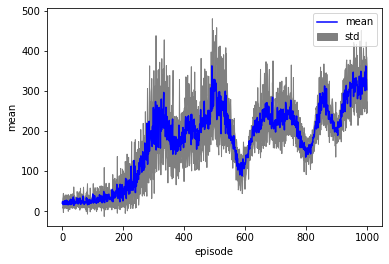

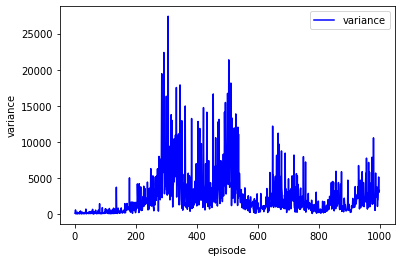

In [27]:
plt.figure()
std_low = np.asarray(mean3) - np.asarray(std3)
std_high = np.asarray(mean3) + np.asarray(std3)
plt.plot(mean3,c = 'b',label = 'mean' )
plt.fill_between(np.arange(0,len(mean3),1),std_low,std_high, color = 'gray',label = 'std')
plt.legend()
# plt.title('summing all the rewards along an episode')
plt.xlabel('episode')
plt.ylabel('mean')
plt.show()

plt.figure()
plt.plot(np.asarray(std3)**2,c = 'b', label = 'variance')
# plt.title('variance en fonction de l\'iteration')
plt.legend()
plt.xlabel('episode')
plt.ylabel('variance')
plt.show()

### Third algorithm: discounted sum minus baseline

From [this video](https://www.youtube.com/watch?v=GcJ9hl3T6x8) and [these slides](http://pages.isir.upmc.fr/~sigaud/teach/ps/5_pg_derivation3.pdf), we know that we can substract a baseline to the gradient calculation methods studied above, and that the optimal baseline to reduce the variance is the value function.

Code a `apply_discounted_sum_minus_baseline()` function, using the critic learned simultaneously with the policy.

In [28]:
def apply_discounted_sum_minus_baseline(cfg, reward, v_value):
    # À compléter...  
    tmp = 0
    for i in reversed(range(len(reward))):
        reward[i] = reward[i] + cfg.algorithm.discount_factor * tmp - v_value[i]
        tmp = reward[i]
    # print("final", reward)
    return reward



torch.manual_seed(config.algorithm.seed)
config=OmegaConf.create(params)
config.logger.log_dir = "./tblogs/reinforce_reinforce_critic-" + str(time.time())

mean4, std4 =run_reinforce(config, compute_reward=apply_discounted_sum_minus_baseline, compute_critic_loss=compute_critic_loss_mc)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
  0%|          | 2/1000 [00:00<01:51,  8.92it/s]

episode: 0, reward: 21.0, std: 11.161157608032227
episode: 1, reward: 24.875, std: 13.097846031188965


  0%|          | 5/1000 [00:00<01:47,  9.27it/s]

episode: 2, reward: 22.5, std: 23.904571533203125
episode: 3, reward: 17.25, std: 5.203021049499512
episode: 4, reward: 25.25, std: 9.735795974731445


  1%|          | 7/1000 [00:00<01:58,  8.38it/s]

episode: 5, reward: 24.75, std: 9.498120307922363
episode: 6, reward: 24.625, std: 14.908650398254395


  1%|          | 9/1000 [00:01<01:53,  8.76it/s]

episode: 7, reward: 17.5, std: 4.840306758880615
episode: 8, reward: 26.75, std: 15.872258186340332


  1%|          | 11/1000 [00:01<01:48,  9.12it/s]

episode: 9, reward: 21.5, std: 9.957050323486328
episode: 10, reward: 23.25, std: 8.827715873718262


  1%|▏         | 13/1000 [00:01<01:53,  8.67it/s]

episode: 11, reward: 27.5, std: 14.55040454864502
episode: 12, reward: 24.25, std: 11.732129096984863


  1%|▏         | 14/1000 [00:01<02:12,  7.45it/s]

episode: 13, reward: 30.25, std: 20.112184524536133
episode: 14, reward: 21.125, std: 6.3118367195129395


  2%|▏         | 16/1000 [00:01<02:03,  7.97it/s]

episode: 15, reward: 25.5, std: 19.227956771850586
episode: 16, reward: 15.25, std: 4.83292293548584
episode: 17, reward: 23.5, std: 14.520920753479004


  2%|▏         | 20/1000 [00:02<01:39,  9.82it/s]

episode: 18, reward: 18.625, std: 6.232117176055908
episode: 19, reward: 21.0, std: 6.969320297241211


  2%|▏         | 21/1000 [00:02<02:01,  8.06it/s]

episode: 20, reward: 32.75, std: 28.971660614013672
episode: 21, reward: 21.125, std: 10.947113037109375


  2%|▏         | 24/1000 [00:02<01:57,  8.31it/s]

episode: 22, reward: 27.125, std: 15.715665817260742
episode: 23, reward: 25.625, std: 8.667468070983887


  2%|▎         | 25/1000 [00:02<02:07,  7.67it/s]

episode: 24, reward: 28.875, std: 19.3718318939209
episode: 25, reward: 21.875, std: 9.745878219604492
episode: 26, reward: 22.0, std: 10.783585548400879


  3%|▎         | 28/1000 [00:03<01:53,  8.56it/s]

episode: 27, reward: 25.0, std: 16.044580459594727
episode: 28, reward: 20.5, std: 8.847921371459961


  3%|▎         | 32/1000 [00:03<01:35, 10.13it/s]

episode: 29, reward: 19.625, std: 13.12508487701416
episode: 30, reward: 17.25, std: 4.097037315368652
episode: 31, reward: 22.75, std: 7.106335163116455


  3%|▎         | 34/1000 [00:03<01:36,  9.99it/s]

episode: 32, reward: 17.25, std: 6.065122604370117
episode: 33, reward: 25.25, std: 13.00274658203125


  4%|▎         | 36/1000 [00:04<01:53,  8.52it/s]

episode: 34, reward: 32.0, std: 22.665266036987305
episode: 35, reward: 27.375, std: 11.325539588928223


  4%|▍         | 38/1000 [00:04<02:01,  7.89it/s]

episode: 36, reward: 36.25, std: 20.239635467529297
episode: 37, reward: 21.5, std: 14.59941291809082


  4%|▍         | 40/1000 [00:04<01:47,  8.92it/s]

episode: 38, reward: 17.125, std: 7.219764709472656
episode: 39, reward: 25.25, std: 7.995534420013428


  4%|▍         | 42/1000 [00:04<01:58,  8.06it/s]

episode: 40, reward: 33.875, std: 15.7610502243042
episode: 41, reward: 30.875, std: 17.183359146118164


  4%|▍         | 44/1000 [00:05<01:39,  9.61it/s]

episode: 42, reward: 17.75, std: 6.341473579406738
episode: 43, reward: 18.875, std: 5.566160678863525
episode: 44, reward: 20.625, std: 9.038607597351074


  5%|▍         | 47/1000 [00:05<01:44,  9.13it/s]

episode: 45, reward: 22.25, std: 8.379396438598633
episode: 46, reward: 29.375, std: 21.533611297607422


  5%|▍         | 48/1000 [00:05<01:49,  8.71it/s]

episode: 47, reward: 28.375, std: 13.616559982299805
episode: 48, reward: 22.75, std: 11.247221946716309


  5%|▌         | 51/1000 [00:05<02:01,  7.79it/s]

episode: 49, reward: 30.5, std: 23.7967586517334
episode: 50, reward: 32.25, std: 17.38431167602539


  5%|▌         | 53/1000 [00:06<02:01,  7.79it/s]

episode: 51, reward: 33.75, std: 15.745747566223145
episode: 52, reward: 24.625, std: 12.397436141967773


  6%|▌         | 56/1000 [00:06<01:39,  9.44it/s]

episode: 53, reward: 23.125, std: 10.776130676269531
episode: 54, reward: 16.75, std: 4.920801162719727
episode: 55, reward: 23.25, std: 8.119641304016113


  6%|▌         | 58/1000 [00:06<01:45,  8.93it/s]

episode: 56, reward: 23.25, std: 10.977249145507812
episode: 57, reward: 29.875, std: 15.065926551818848


  6%|▌         | 60/1000 [00:06<01:44,  8.97it/s]

episode: 58, reward: 25.5, std: 14.520920753479004
episode: 59, reward: 22.5, std: 11.844226837158203


  6%|▌         | 62/1000 [00:07<01:52,  8.37it/s]

episode: 60, reward: 23.125, std: 12.631451606750488
episode: 61, reward: 30.875, std: 19.43073844909668


  6%|▋         | 65/1000 [00:07<01:39,  9.44it/s]

episode: 62, reward: 24.375, std: 11.198692321777344
episode: 63, reward: 20.5, std: 6.98978853225708
episode: 64, reward: 22.875, std: 8.626164436340332


  7%|▋         | 66/1000 [00:07<01:44,  8.95it/s]

episode: 65, reward: 22.125, std: 14.681742668151855
episode: 66, reward: 40.0, std: 25.22470474243164


  7%|▋         | 69/1000 [00:08<02:06,  7.35it/s]

episode: 67, reward: 27.75, std: 11.285262107849121
episode: 68, reward: 27.75, std: 20.5408992767334


  7%|▋         | 71/1000 [00:08<02:10,  7.14it/s]

episode: 69, reward: 35.375, std: 26.223966598510742
episode: 70, reward: 27.625, std: 10.822430610656738


  7%|▋         | 73/1000 [00:08<02:00,  7.71it/s]

episode: 71, reward: 31.0, std: 11.109841346740723
episode: 72, reward: 26.375, std: 16.194686889648438


  8%|▊         | 75/1000 [00:08<02:16,  6.80it/s]

episode: 73, reward: 36.625, std: 22.225709915161133
episode: 74, reward: 33.125, std: 18.153610229492188


  8%|▊         | 77/1000 [00:09<02:09,  7.12it/s]

episode: 75, reward: 32.25, std: 17.74220085144043
episode: 76, reward: 32.125, std: 15.986042976379395


  8%|▊         | 78/1000 [00:09<02:27,  6.25it/s]

episode: 77, reward: 35.25, std: 31.129911422729492
episode: 78, reward: 34.0, std: 21.94148063659668


  8%|▊         | 80/1000 [00:09<02:24,  6.36it/s]

episode: 79, reward: 21.0, std: 13.25572681427002
episode: 80, reward: 24.0, std: 6.98978853225708


  8%|▊         | 83/1000 [00:10<02:01,  7.56it/s]

episode: 81, reward: 28.75, std: 11.196300506591797
episode: 82, reward: 36.625, std: 15.42667007446289


  8%|▊         | 84/1000 [00:10<02:08,  7.12it/s]

episode: 83, reward: 35.625, std: 21.192569732666016
episode: 84, reward: 21.0, std: 12.592514991760254
episode: 85, reward: 26.75, std: 7.887603282928467


  9%|▉         | 88/1000 [00:10<01:46,  8.58it/s]

episode: 86, reward: 27.0, std: 14.66774845123291
episode: 87, reward: 27.75, std: 12.186058044433594


  9%|▉         | 89/1000 [00:10<02:09,  7.02it/s]

episode: 88, reward: 40.875, std: 29.676530838012695


  9%|▉         | 91/1000 [00:11<02:24,  6.30it/s]

episode: 89, reward: 49.5, std: 27.94382095336914
episode: 90, reward: 22.875, std: 16.322092056274414
episode: 91, reward: 18.5, std: 5.707138538360596
episode: 92, reward: 39.5, std: 28.299419403076172


  9%|▉         | 94/1000 [00:11<02:29,  6.06it/s]

episode: 93, reward: 38.125, std: 27.247215270996094


 10%|▉         | 96/1000 [00:12<02:49,  5.33it/s]

episode: 94, reward: 39.0, std: 39.21005630493164
episode: 95, reward: 33.75, std: 13.69827938079834


 10%|▉         | 98/1000 [00:12<02:27,  6.13it/s]

episode: 96, reward: 44.625, std: 25.623300552368164
episode: 97, reward: 24.75, std: 10.498299598693848


 10%|█         | 100/1000 [00:12<02:36,  5.74it/s]

episode: 98, reward: 47.0, std: 33.398033142089844
episode: 99, reward: 32.875, std: 16.322092056274414


 10%|█         | 101/1000 [00:13<02:36,  5.74it/s]

episode: 100, reward: 35.75, std: 16.97687530517578
episode: 101, reward: 21.375, std: 9.650129318237305


 10%|█         | 104/1000 [00:13<02:12,  6.76it/s]

episode: 102, reward: 31.625, std: 15.846923828125
episode: 103, reward: 31.875, std: 16.556720733642578


 10%|█         | 105/1000 [00:13<02:36,  5.70it/s]

episode: 104, reward: 47.625, std: 40.13882064819336


 11%|█         | 106/1000 [00:13<03:05,  4.83it/s]

episode: 105, reward: 47.625, std: 36.28434371948242


 11%|█         | 108/1000 [00:14<02:53,  5.13it/s]

episode: 106, reward: 39.25, std: 37.606040954589844
episode: 107, reward: 28.5, std: 18.134418487548828


 11%|█         | 109/1000 [00:14<02:57,  5.03it/s]

episode: 108, reward: 40.75, std: 28.912429809570312
episode: 109, reward: 25.25, std: 10.457396507263184


 11%|█         | 112/1000 [00:15<02:29,  5.94it/s]

episode: 110, reward: 36.5, std: 26.10965919494629
episode: 111, reward: 37.375, std: 19.249767303466797


 11%|█▏        | 114/1000 [00:15<02:21,  6.26it/s]

episode: 112, reward: 31.5, std: 23.120800018310547
episode: 113, reward: 33.625, std: 17.492345809936523


 12%|█▏        | 115/1000 [00:15<02:22,  6.23it/s]

episode: 114, reward: 32.375, std: 21.777690887451172
episode: 115, reward: 42.5, std: 19.683204650878906


 12%|█▏        | 118/1000 [00:16<02:33,  5.76it/s]

episode: 116, reward: 40.375, std: 25.224349975585938
episode: 117, reward: 36.5, std: 16.4837589263916


 12%|█▏        | 119/1000 [00:16<02:21,  6.23it/s]

episode: 118, reward: 26.375, std: 15.380298614501953


 12%|█▏        | 120/1000 [00:16<02:57,  4.97it/s]

episode: 119, reward: 58.875, std: 57.2149772644043
episode: 120, reward: 35.875, std: 19.097026824951172


 12%|█▏        | 122/1000 [00:16<03:04,  4.76it/s]

episode: 121, reward: 53.0, std: 37.15219497680664
episode: 122, reward: 36.875, std: 23.350971221923828


 12%|█▏        | 124/1000 [00:17<03:52,  3.76it/s]

episode: 123, reward: 53.875, std: 30.628826141357422
episode: 124, reward: 53.375, std: 31.413997650146484


 13%|█▎        | 127/1000 [00:18<03:07,  4.65it/s]

episode: 125, reward: 57.625, std: 27.128990173339844
episode: 126, reward: 35.0, std: 16.248077392578125


 13%|█▎        | 128/1000 [00:18<03:10,  4.58it/s]

episode: 127, reward: 45.0, std: 30.960803985595703


 13%|█▎        | 130/1000 [00:18<02:58,  4.88it/s]

episode: 128, reward: 61.625, std: 34.15903091430664
episode: 129, reward: 42.25, std: 21.651460647583008


 13%|█▎        | 131/1000 [00:18<03:13,  4.48it/s]

episode: 130, reward: 55.25, std: 37.17430114746094


 13%|█▎        | 132/1000 [00:19<03:14,  4.45it/s]

episode: 131, reward: 43.0, std: 25.862272262573242


 13%|█▎        | 133/1000 [00:19<03:45,  3.84it/s]

episode: 132, reward: 47.25, std: 55.481658935546875


 13%|█▎        | 134/1000 [00:19<03:42,  3.89it/s]

episode: 133, reward: 64.75, std: 25.943620681762695


 14%|█▎        | 135/1000 [00:19<03:29,  4.13it/s]

episode: 134, reward: 51.125, std: 23.320362091064453
episode: 135, reward: 42.375, std: 19.43441390991211


 14%|█▎        | 137/1000 [00:20<03:20,  4.31it/s]

episode: 136, reward: 55.375, std: 34.19664764404297


 14%|█▍        | 138/1000 [00:20<03:47,  3.79it/s]

episode: 137, reward: 62.25, std: 48.07063293457031


 14%|█▍        | 139/1000 [00:21<04:07,  3.48it/s]

episode: 138, reward: 60.625, std: 41.192710876464844


 14%|█▍        | 140/1000 [00:21<04:00,  3.58it/s]

episode: 139, reward: 51.625, std: 34.56644821166992


 14%|█▍        | 141/1000 [00:21<03:54,  3.67it/s]

episode: 140, reward: 48.5, std: 39.6412467956543


 14%|█▍        | 143/1000 [00:22<03:19,  4.29it/s]

episode: 141, reward: 49.875, std: 25.48634147644043
episode: 142, reward: 36.25, std: 19.469757080078125


 14%|█▍        | 144/1000 [00:22<03:38,  3.93it/s]

episode: 143, reward: 61.875, std: 43.12916564941406


 14%|█▍        | 145/1000 [00:22<03:50,  3.70it/s]

episode: 144, reward: 75.125, std: 43.685359954833984


 15%|█▍        | 146/1000 [00:23<04:36,  3.09it/s]

episode: 145, reward: 114.5, std: 59.36328887939453


 15%|█▍        | 147/1000 [00:23<05:04,  2.80it/s]

episode: 146, reward: 105.75, std: 62.19267272949219


 15%|█▍        | 148/1000 [00:23<04:41,  3.03it/s]

episode: 147, reward: 62.125, std: 35.522377014160156


 15%|█▍        | 149/1000 [00:24<04:56,  2.87it/s]

episode: 148, reward: 92.75, std: 46.10469436645508


 15%|█▌        | 150/1000 [00:24<04:39,  3.04it/s]

episode: 149, reward: 59.75, std: 38.201534271240234


 15%|█▌        | 151/1000 [00:24<04:44,  2.99it/s]

episode: 150, reward: 84.5, std: 43.296321868896484


 15%|█▌        | 152/1000 [00:25<05:17,  2.67it/s]

episode: 151, reward: 78.5, std: 52.42137145996094


 15%|█▌        | 153/1000 [00:25<05:09,  2.74it/s]

episode: 152, reward: 77.375, std: 44.83282470703125


 15%|█▌        | 154/1000 [00:25<05:12,  2.71it/s]

episode: 153, reward: 89.875, std: 50.217918395996094


 16%|█▌        | 155/1000 [00:26<05:40,  2.48it/s]

episode: 154, reward: 108.375, std: 68.50221252441406


 16%|█▌        | 156/1000 [00:26<05:14,  2.68it/s]

episode: 155, reward: 92.0, std: 30.664077758789062


 16%|█▌        | 157/1000 [00:27<05:13,  2.69it/s]

episode: 156, reward: 118.375, std: 44.46166229248047


 16%|█▌        | 158/1000 [00:27<05:07,  2.74it/s]

episode: 157, reward: 102.125, std: 44.6716194152832


 16%|█▌        | 159/1000 [00:27<05:16,  2.66it/s]

episode: 158, reward: 110.0, std: 44.65102767944336


 16%|█▌        | 160/1000 [00:28<05:36,  2.49it/s]

episode: 159, reward: 88.5, std: 53.25947189331055


 16%|█▌        | 161/1000 [00:28<05:24,  2.59it/s]

episode: 160, reward: 78.5, std: 48.435523986816406


 16%|█▌        | 162/1000 [00:29<06:15,  2.23it/s]

episode: 161, reward: 112.375, std: 72.6615219116211


 16%|█▋        | 163/1000 [00:29<05:21,  2.60it/s]

episode: 162, reward: 62.125, std: 22.535289764404297


 16%|█▋        | 164/1000 [00:30<06:00,  2.32it/s]

episode: 163, reward: 133.25, std: 61.5531120300293


 16%|█▋        | 165/1000 [00:30<06:04,  2.29it/s]

episode: 164, reward: 143.125, std: 31.511619567871094


 17%|█▋        | 166/1000 [00:30<06:07,  2.27it/s]

episode: 165, reward: 100.5, std: 51.7990608215332


 17%|█▋        | 167/1000 [00:31<06:32,  2.12it/s]

episode: 166, reward: 131.625, std: 61.36526870727539


 17%|█▋        | 168/1000 [00:31<06:27,  2.15it/s]

episode: 167, reward: 115.125, std: 70.09674072265625


 17%|█▋        | 169/1000 [00:32<06:41,  2.07it/s]

episode: 168, reward: 96.125, std: 84.95114135742188


 17%|█▋        | 170/1000 [00:33<07:04,  1.96it/s]

episode: 169, reward: 129.375, std: 71.92642211914062


 17%|█▋        | 171/1000 [00:33<07:15,  1.90it/s]

episode: 170, reward: 101.625, std: 74.26773834228516


 17%|█▋        | 172/1000 [00:34<07:31,  1.83it/s]

episode: 171, reward: 130.375, std: 83.09880065917969


 17%|█▋        | 173/1000 [00:34<07:14,  1.91it/s]

episode: 172, reward: 137.75, std: 50.89695358276367


 17%|█▋        | 174/1000 [00:35<07:01,  1.96it/s]

episode: 173, reward: 107.125, std: 61.56863021850586


 18%|█▊        | 175/1000 [00:35<07:14,  1.90it/s]

episode: 174, reward: 142.5, std: 78.58026123046875


 18%|█▊        | 176/1000 [00:36<07:34,  1.81it/s]

episode: 175, reward: 140.5, std: 70.8277587890625


 18%|█▊        | 177/1000 [00:36<07:45,  1.77it/s]

episode: 176, reward: 137.625, std: 75.35807037353516


 18%|█▊        | 178/1000 [00:37<07:28,  1.83it/s]

episode: 177, reward: 155.375, std: 40.690250396728516


 18%|█▊        | 179/1000 [00:38<07:36,  1.80it/s]

episode: 178, reward: 136.125, std: 72.61727142333984


 18%|█▊        | 180/1000 [00:38<07:59,  1.71it/s]

episode: 179, reward: 145.875, std: 87.87562561035156


 18%|█▊        | 181/1000 [00:39<07:57,  1.71it/s]

episode: 180, reward: 166.375, std: 55.662086486816406


 18%|█▊        | 182/1000 [00:39<08:13,  1.66it/s]

episode: 181, reward: 177.875, std: 83.3845443725586


 18%|█▊        | 183/1000 [00:40<08:28,  1.61it/s]

episode: 182, reward: 182.375, std: 72.86962127685547


 18%|█▊        | 184/1000 [00:41<08:50,  1.54it/s]

episode: 183, reward: 169.625, std: 112.18216705322266


 18%|█▊        | 185/1000 [00:41<08:46,  1.55it/s]

episode: 184, reward: 114.0, std: 84.39532470703125


 19%|█▊        | 186/1000 [00:42<08:54,  1.52it/s]

episode: 185, reward: 167.25, std: 100.39600372314453


 19%|█▊        | 187/1000 [00:43<10:23,  1.30it/s]

episode: 186, reward: 212.75, std: 142.20382690429688


 19%|█▉        | 188/1000 [00:44<10:00,  1.35it/s]

episode: 187, reward: 174.125, std: 72.58578491210938


 19%|█▉        | 189/1000 [00:44<09:04,  1.49it/s]

episode: 188, reward: 121.125, std: 78.39176177978516


 19%|█▉        | 190/1000 [00:45<09:23,  1.44it/s]

episode: 189, reward: 152.75, std: 127.0610122680664


 19%|█▉        | 191/1000 [00:46<09:16,  1.46it/s]

episode: 190, reward: 180.625, std: 78.45096588134766


 19%|█▉        | 192/1000 [00:46<08:52,  1.52it/s]

episode: 191, reward: 131.375, std: 83.78704071044922


 19%|█▉        | 193/1000 [00:47<09:34,  1.40it/s]

episode: 192, reward: 172.125, std: 139.5302734375


 19%|█▉        | 194/1000 [00:48<09:06,  1.47it/s]

episode: 193, reward: 163.0, std: 81.46515655517578


 20%|█▉        | 195/1000 [00:49<09:28,  1.42it/s]

episode: 194, reward: 229.875, std: 92.92921447753906


 20%|█▉        | 196/1000 [00:49<10:09,  1.32it/s]

episode: 195, reward: 206.75, std: 115.55301666259766


 20%|█▉        | 197/1000 [00:50<10:53,  1.23it/s]

episode: 196, reward: 182.875, std: 109.18455505371094


 20%|█▉        | 198/1000 [00:51<10:48,  1.24it/s]

episode: 197, reward: 209.375, std: 82.19999694824219


 20%|█▉        | 199/1000 [00:52<11:07,  1.20it/s]

episode: 198, reward: 215.25, std: 104.85874938964844


 20%|██        | 200/1000 [00:53<11:08,  1.20it/s]

episode: 199, reward: 179.875, std: 115.92908477783203


 20%|██        | 201/1000 [00:54<10:29,  1.27it/s]

episode: 200, reward: 190.0, std: 72.02578735351562


 20%|██        | 202/1000 [00:55<11:06,  1.20it/s]

episode: 201, reward: 178.75, std: 141.61390686035156


 20%|██        | 203/1000 [00:55<10:54,  1.22it/s]

episode: 202, reward: 217.5, std: 88.32569885253906


 20%|██        | 204/1000 [00:56<10:01,  1.32it/s]

episode: 203, reward: 169.125, std: 76.0928726196289


 20%|██        | 205/1000 [00:57<10:02,  1.32it/s]

episode: 204, reward: 184.75, std: 116.36365509033203


 21%|██        | 206/1000 [00:57<09:52,  1.34it/s]

episode: 205, reward: 176.25, std: 79.2568130493164


 21%|██        | 207/1000 [00:58<11:12,  1.18it/s]

episode: 206, reward: 302.125, std: 112.7417221069336


 21%|██        | 208/1000 [00:59<10:28,  1.26it/s]

episode: 207, reward: 179.75, std: 83.14488220214844


 21%|██        | 209/1000 [01:00<10:10,  1.30it/s]

episode: 208, reward: 174.0, std: 101.83179473876953


 21%|██        | 210/1000 [01:01<11:18,  1.16it/s]

episode: 209, reward: 284.375, std: 121.2800064086914


 21%|██        | 211/1000 [01:02<10:29,  1.25it/s]

episode: 210, reward: 214.375, std: 49.11775207519531


 21%|██        | 212/1000 [01:02<09:49,  1.34it/s]

episode: 211, reward: 191.0, std: 62.81037139892578


 21%|██▏       | 213/1000 [01:03<09:58,  1.31it/s]

episode: 212, reward: 215.25, std: 104.801513671875


 21%|██▏       | 214/1000 [01:04<11:11,  1.17it/s]

episode: 213, reward: 297.875, std: 110.49813842773438


 22%|██▏       | 215/1000 [01:05<10:24,  1.26it/s]

episode: 214, reward: 197.875, std: 71.71458435058594


 22%|██▏       | 216/1000 [01:06<11:21,  1.15it/s]

episode: 215, reward: 290.25, std: 116.7705307006836


 22%|██▏       | 217/1000 [01:06<10:28,  1.25it/s]

episode: 216, reward: 205.25, std: 72.04314422607422


 22%|██▏       | 218/1000 [01:08<12:21,  1.05it/s]

episode: 217, reward: 226.125, std: 153.928955078125


 22%|██▏       | 219/1000 [01:09<12:52,  1.01it/s]

episode: 218, reward: 279.25, std: 178.21075439453125


 22%|██▏       | 220/1000 [01:10<13:11,  1.02s/it]

episode: 219, reward: 247.625, std: 136.1983184814453


 22%|██▏       | 221/1000 [01:11<12:09,  1.07it/s]

episode: 220, reward: 245.875, std: 56.57722473144531


 22%|██▏       | 222/1000 [01:11<11:17,  1.15it/s]

episode: 221, reward: 211.0, std: 50.849918365478516


 22%|██▏       | 223/1000 [01:12<11:04,  1.17it/s]

episode: 222, reward: 234.75, std: 101.98004150390625


 22%|██▏       | 224/1000 [01:13<11:10,  1.16it/s]

episode: 223, reward: 246.75, std: 63.57841110229492


 22%|██▎       | 225/1000 [01:14<11:33,  1.12it/s]

episode: 224, reward: 283.75, std: 81.97168731689453


 23%|██▎       | 226/1000 [01:15<11:02,  1.17it/s]

episode: 225, reward: 241.0, std: 64.52906036376953


 23%|██▎       | 227/1000 [01:16<11:03,  1.16it/s]

episode: 226, reward: 264.125, std: 85.6595230102539


 23%|██▎       | 228/1000 [01:16<10:39,  1.21it/s]

episode: 227, reward: 265.125, std: 51.73127746582031


 23%|██▎       | 229/1000 [01:17<09:53,  1.30it/s]

episode: 228, reward: 157.0, std: 92.640625


 23%|██▎       | 230/1000 [01:18<09:46,  1.31it/s]

episode: 229, reward: 203.875, std: 67.67450714111328


 23%|██▎       | 231/1000 [01:18<09:17,  1.38it/s]

episode: 230, reward: 211.875, std: 46.372520446777344


 23%|██▎       | 232/1000 [01:19<10:32,  1.21it/s]

episode: 231, reward: 230.0, std: 121.2847900390625


 23%|██▎       | 233/1000 [01:20<10:21,  1.24it/s]

episode: 232, reward: 227.25, std: 69.59423065185547


 23%|██▎       | 234/1000 [01:21<09:54,  1.29it/s]

episode: 233, reward: 193.375, std: 90.68302154541016


 24%|██▎       | 235/1000 [01:22<10:39,  1.20it/s]

episode: 234, reward: 262.875, std: 107.88676452636719


 24%|██▎       | 236/1000 [01:23<09:50,  1.29it/s]

episode: 235, reward: 227.75, std: 41.60271453857422


 24%|██▎       | 237/1000 [01:23<10:06,  1.26it/s]

episode: 236, reward: 252.25, std: 76.33712768554688


 24%|██▍       | 238/1000 [01:24<11:12,  1.13it/s]

episode: 237, reward: 262.375, std: 113.36910247802734


 24%|██▍       | 239/1000 [01:25<11:09,  1.14it/s]

episode: 238, reward: 257.125, std: 64.19487762451172


 24%|██▍       | 240/1000 [01:26<10:41,  1.18it/s]

episode: 239, reward: 204.25, std: 87.4687728881836


 24%|██▍       | 241/1000 [01:27<11:41,  1.08it/s]

episode: 240, reward: 324.125, std: 136.0571746826172


 24%|██▍       | 242/1000 [01:28<11:42,  1.08it/s]

episode: 241, reward: 235.5, std: 106.46260070800781


 24%|██▍       | 243/1000 [01:29<11:39,  1.08it/s]

episode: 242, reward: 258.125, std: 122.65216827392578


 24%|██▍       | 244/1000 [01:30<13:00,  1.03s/it]

episode: 243, reward: 300.25, std: 117.17599487304688


 24%|██▍       | 245/1000 [01:31<12:18,  1.02it/s]

episode: 244, reward: 247.875, std: 129.784912109375


 25%|██▍       | 246/1000 [01:32<12:39,  1.01s/it]

episode: 245, reward: 312.875, std: 162.47940063476562


 25%|██▍       | 247/1000 [01:33<12:55,  1.03s/it]

episode: 246, reward: 240.25, std: 152.5401611328125


 25%|██▍       | 248/1000 [01:34<13:13,  1.05s/it]

episode: 247, reward: 306.625, std: 117.80606079101562


 25%|██▍       | 249/1000 [01:35<12:54,  1.03s/it]

episode: 248, reward: 312.5, std: 102.10498809814453


 25%|██▌       | 250/1000 [01:37<13:05,  1.05s/it]

episode: 249, reward: 348.125, std: 88.98223876953125


 25%|██▌       | 251/1000 [01:38<13:22,  1.07s/it]

episode: 250, reward: 381.25, std: 114.72420501708984


 25%|██▌       | 252/1000 [01:39<12:54,  1.04s/it]

episode: 251, reward: 302.875, std: 134.8146209716797


 25%|██▌       | 253/1000 [01:39<11:58,  1.04it/s]

episode: 252, reward: 259.0, std: 60.670066833496094


 25%|██▌       | 254/1000 [01:40<12:28,  1.00s/it]

episode: 253, reward: 354.5, std: 138.12933349609375


 26%|██▌       | 255/1000 [01:41<11:58,  1.04it/s]

episode: 254, reward: 259.0, std: 114.7481689453125


 26%|██▌       | 256/1000 [01:43<12:39,  1.02s/it]

episode: 255, reward: 303.875, std: 96.7108154296875


 26%|██▌       | 257/1000 [01:43<12:15,  1.01it/s]

episode: 256, reward: 296.625, std: 128.58120727539062


 26%|██▌       | 258/1000 [01:45<12:34,  1.02s/it]

episode: 257, reward: 316.5, std: 133.22805786132812


 26%|██▌       | 259/1000 [01:46<12:32,  1.02s/it]

episode: 258, reward: 232.375, std: 165.12673950195312


 26%|██▌       | 260/1000 [01:47<12:50,  1.04s/it]

episode: 259, reward: 335.625, std: 147.43612670898438


 26%|██▌       | 261/1000 [01:48<13:02,  1.06s/it]

episode: 260, reward: 339.875, std: 117.08170318603516


 26%|██▌       | 262/1000 [01:49<14:08,  1.15s/it]

episode: 261, reward: 325.875, std: 97.81095123291016


 26%|██▋       | 263/1000 [01:50<14:06,  1.15s/it]

episode: 262, reward: 279.875, std: 160.89166259765625


 26%|██▋       | 264/1000 [01:51<13:52,  1.13s/it]

episode: 263, reward: 352.375, std: 110.14009094238281


 26%|██▋       | 265/1000 [01:52<13:19,  1.09s/it]

episode: 264, reward: 306.125, std: 112.49055480957031


 27%|██▋       | 266/1000 [01:53<13:23,  1.10s/it]

episode: 265, reward: 280.0, std: 126.26842498779297


 27%|██▋       | 267/1000 [01:55<13:26,  1.10s/it]

episode: 266, reward: 287.5, std: 129.22406005859375


 27%|██▋       | 268/1000 [01:55<12:51,  1.05s/it]

episode: 267, reward: 273.875, std: 101.93756866455078


 27%|██▋       | 269/1000 [01:56<12:29,  1.02s/it]

episode: 268, reward: 236.625, std: 102.15945434570312


 27%|██▋       | 270/1000 [01:58<12:45,  1.05s/it]

episode: 269, reward: 319.875, std: 90.26063537597656


 27%|██▋       | 271/1000 [01:59<12:39,  1.04s/it]

episode: 270, reward: 295.375, std: 122.22220611572266


 27%|██▋       | 272/1000 [02:00<12:51,  1.06s/it]

episode: 271, reward: 311.125, std: 132.421875


 27%|██▋       | 273/1000 [02:01<12:55,  1.07s/it]

episode: 272, reward: 304.625, std: 106.11710357666016


 27%|██▋       | 274/1000 [02:02<12:27,  1.03s/it]

episode: 273, reward: 258.75, std: 110.79808044433594


 28%|██▊       | 275/1000 [02:03<12:03,  1.00it/s]

episode: 274, reward: 297.75, std: 104.06831359863281


 28%|██▊       | 276/1000 [02:04<12:29,  1.03s/it]

episode: 275, reward: 348.875, std: 119.12710571289062


 28%|██▊       | 277/1000 [02:05<13:01,  1.08s/it]

episode: 276, reward: 364.375, std: 141.3677520751953


 28%|██▊       | 278/1000 [02:06<12:23,  1.03s/it]

episode: 277, reward: 269.75, std: 81.60313415527344


 28%|██▊       | 279/1000 [02:07<12:51,  1.07s/it]

episode: 278, reward: 344.75, std: 119.51897430419922


 28%|██▊       | 280/1000 [02:09<14:22,  1.20s/it]

episode: 279, reward: 385.75, std: 127.249755859375


 28%|██▊       | 281/1000 [02:10<13:59,  1.17s/it]

episode: 280, reward: 297.125, std: 92.96610260009766


 28%|██▊       | 282/1000 [02:11<13:18,  1.11s/it]

episode: 281, reward: 265.0, std: 76.06012725830078


 28%|██▊       | 283/1000 [02:12<13:15,  1.11s/it]

episode: 282, reward: 312.375, std: 122.93196105957031


 28%|██▊       | 284/1000 [02:13<13:05,  1.10s/it]

episode: 283, reward: 308.625, std: 99.57041931152344


 28%|██▊       | 285/1000 [02:14<11:51,  1.00it/s]

episode: 284, reward: 218.875, std: 72.2860107421875


 29%|██▊       | 286/1000 [02:14<11:46,  1.01it/s]

episode: 285, reward: 289.75, std: 78.48521423339844


 29%|██▊       | 287/1000 [02:16<12:07,  1.02s/it]

episode: 286, reward: 272.125, std: 174.67311096191406


 29%|██▉       | 288/1000 [02:17<11:51,  1.00it/s]

episode: 287, reward: 267.5, std: 120.16893005371094


 29%|██▉       | 289/1000 [02:18<12:04,  1.02s/it]

episode: 288, reward: 261.125, std: 125.2020492553711


 29%|██▉       | 290/1000 [02:18<10:49,  1.09it/s]

episode: 289, reward: 207.5, std: 69.77310180664062


 29%|██▉       | 291/1000 [02:19<10:04,  1.17it/s]

episode: 290, reward: 184.25, std: 58.58753967285156


 29%|██▉       | 292/1000 [02:20<11:06,  1.06it/s]

episode: 291, reward: 246.625, std: 73.64768981933594


 29%|██▉       | 293/1000 [02:21<11:19,  1.04it/s]

episode: 292, reward: 220.5, std: 36.43781280517578


 29%|██▉       | 294/1000 [02:22<10:35,  1.11it/s]

episode: 293, reward: 195.625, std: 54.195247650146484


 30%|██▉       | 295/1000 [02:23<09:48,  1.20it/s]

episode: 294, reward: 149.375, std: 79.4120101928711


 30%|██▉       | 296/1000 [02:23<09:11,  1.28it/s]

episode: 295, reward: 183.0, std: 65.85264587402344


 30%|██▉       | 297/1000 [02:24<09:22,  1.25it/s]

episode: 296, reward: 227.5, std: 77.9945068359375


 30%|██▉       | 298/1000 [02:25<08:27,  1.38it/s]

episode: 297, reward: 175.875, std: 63.27363967895508


 30%|██▉       | 299/1000 [02:25<07:51,  1.49it/s]

episode: 298, reward: 175.5, std: 44.67341995239258


 30%|███       | 300/1000 [02:26<07:16,  1.60it/s]

episode: 299, reward: 172.0, std: 20.805219650268555


 30%|███       | 301/1000 [02:26<06:51,  1.70it/s]

episode: 300, reward: 151.5, std: 36.01190185546875


 30%|███       | 302/1000 [02:27<06:49,  1.71it/s]

episode: 301, reward: 166.0, std: 51.65821838378906


 30%|███       | 303/1000 [02:27<07:10,  1.62it/s]

episode: 302, reward: 201.75, std: 62.80525588989258


 30%|███       | 304/1000 [02:28<06:54,  1.68it/s]

episode: 303, reward: 141.75, std: 85.2789535522461


 30%|███       | 305/1000 [02:28<06:26,  1.80it/s]

episode: 304, reward: 135.125, std: 37.19231033325195


 31%|███       | 306/1000 [02:29<06:06,  1.89it/s]

episode: 305, reward: 153.375, std: 30.789318084716797


 31%|███       | 307/1000 [02:29<06:06,  1.89it/s]

episode: 306, reward: 174.875, std: 32.995399475097656


 31%|███       | 308/1000 [02:30<06:00,  1.92it/s]

episode: 307, reward: 158.5, std: 60.33004379272461


 31%|███       | 309/1000 [02:31<06:15,  1.84it/s]

episode: 308, reward: 158.375, std: 64.5665512084961


 31%|███       | 310/1000 [02:31<06:05,  1.89it/s]

episode: 309, reward: 169.125, std: 30.469833374023438


 31%|███       | 311/1000 [02:32<06:27,  1.78it/s]

episode: 310, reward: 155.25, std: 68.79732513427734


 31%|███       | 312/1000 [02:32<06:00,  1.91it/s]

episode: 311, reward: 118.75, std: 59.40598678588867


 31%|███▏      | 313/1000 [02:33<06:08,  1.86it/s]

episode: 312, reward: 151.625, std: 66.32589721679688


 31%|███▏      | 314/1000 [02:33<06:07,  1.87it/s]

episode: 313, reward: 147.625, std: 54.785133361816406


 32%|███▏      | 315/1000 [02:34<05:34,  2.05it/s]

episode: 314, reward: 116.375, std: 36.339420318603516


 32%|███▏      | 316/1000 [02:34<06:14,  1.83it/s]

episode: 315, reward: 180.875, std: 79.77367401123047


 32%|███▏      | 317/1000 [02:35<06:31,  1.74it/s]

episode: 316, reward: 182.0, std: 49.51190185546875


 32%|███▏      | 318/1000 [02:36<06:56,  1.64it/s]

episode: 317, reward: 149.25, std: 39.7878303527832


 32%|███▏      | 319/1000 [02:36<06:52,  1.65it/s]

episode: 318, reward: 151.25, std: 51.3774528503418


 32%|███▏      | 320/1000 [02:37<06:39,  1.70it/s]

episode: 319, reward: 159.25, std: 47.058475494384766


 32%|███▏      | 321/1000 [02:37<06:31,  1.73it/s]

episode: 320, reward: 156.125, std: 43.00643539428711


 32%|███▏      | 322/1000 [02:38<06:09,  1.83it/s]

episode: 321, reward: 146.75, std: 40.527767181396484


 32%|███▏      | 323/1000 [02:38<06:17,  1.79it/s]

episode: 322, reward: 160.75, std: 47.631771087646484


 32%|███▏      | 324/1000 [02:39<05:42,  1.97it/s]

episode: 323, reward: 133.0, std: 41.55890655517578


 32%|███▎      | 325/1000 [02:39<05:29,  2.05it/s]

episode: 324, reward: 139.125, std: 28.18022346496582


 33%|███▎      | 326/1000 [02:40<05:04,  2.21it/s]

episode: 325, reward: 117.625, std: 54.4922981262207


 33%|███▎      | 327/1000 [02:40<04:40,  2.40it/s]

episode: 326, reward: 121.25, std: 15.67299747467041


 33%|███▎      | 328/1000 [02:40<04:35,  2.44it/s]

episode: 327, reward: 139.625, std: 16.457195281982422


 33%|███▎      | 329/1000 [02:41<04:42,  2.38it/s]

episode: 328, reward: 147.875, std: 17.89203643798828


 33%|███▎      | 330/1000 [02:41<04:41,  2.38it/s]

episode: 329, reward: 127.375, std: 42.92164611816406


 33%|███▎      | 331/1000 [02:41<04:21,  2.56it/s]

episode: 330, reward: 112.25, std: 16.73106575012207


 33%|███▎      | 332/1000 [02:42<04:26,  2.51it/s]

episode: 331, reward: 129.0, std: 35.33917236328125


 33%|███▎      | 333/1000 [02:42<04:17,  2.59it/s]

episode: 332, reward: 90.125, std: 42.632774353027344


 33%|███▎      | 334/1000 [02:43<04:13,  2.62it/s]

episode: 333, reward: 123.25, std: 21.43928337097168


 34%|███▎      | 335/1000 [02:43<04:07,  2.68it/s]

episode: 334, reward: 113.375, std: 28.665246963500977


 34%|███▎      | 336/1000 [02:43<03:54,  2.83it/s]

episode: 335, reward: 91.875, std: 37.360931396484375


 34%|███▎      | 337/1000 [02:44<03:56,  2.80it/s]

episode: 336, reward: 106.0, std: 33.899009704589844


 34%|███▍      | 338/1000 [02:44<03:50,  2.87it/s]

episode: 337, reward: 109.5, std: 28.370004653930664


 34%|███▍      | 339/1000 [02:44<03:41,  2.98it/s]

episode: 338, reward: 87.0, std: 37.69425964355469


 34%|███▍      | 340/1000 [02:45<03:43,  2.96it/s]

episode: 339, reward: 122.625, std: 25.556310653686523


 34%|███▍      | 341/1000 [02:45<03:42,  2.96it/s]

episode: 340, reward: 115.625, std: 32.482688903808594


 34%|███▍      | 342/1000 [02:45<03:25,  3.21it/s]

episode: 341, reward: 69.25, std: 28.33851432800293


 34%|███▍      | 343/1000 [02:46<03:40,  2.98it/s]

episode: 342, reward: 102.625, std: 51.11314392089844


 34%|███▍      | 344/1000 [02:46<03:47,  2.88it/s]

episode: 343, reward: 89.25, std: 49.3377571105957


 34%|███▍      | 345/1000 [02:46<03:52,  2.82it/s]

episode: 344, reward: 90.125, std: 49.501625061035156


 35%|███▍      | 346/1000 [02:47<03:44,  2.91it/s]

episode: 345, reward: 95.625, std: 37.73947525024414


 35%|███▍      | 347/1000 [02:47<03:43,  2.93it/s]

episode: 346, reward: 113.375, std: 27.7434024810791


 35%|███▍      | 348/1000 [02:47<03:29,  3.11it/s]

episode: 347, reward: 73.125, std: 34.127647399902344


 35%|███▍      | 349/1000 [02:48<03:32,  3.06it/s]

episode: 348, reward: 104.75, std: 36.90818786621094


 35%|███▌      | 350/1000 [02:48<03:36,  3.01it/s]

episode: 349, reward: 97.625, std: 37.59535598754883


 35%|███▌      | 351/1000 [02:48<03:54,  2.77it/s]

episode: 350, reward: 148.375, std: 16.11509895324707


 35%|███▌      | 352/1000 [02:49<03:57,  2.73it/s]

episode: 351, reward: 136.875, std: 14.277229309082031


 35%|███▌      | 353/1000 [02:49<04:09,  2.59it/s]

episode: 352, reward: 116.25, std: 46.6468505859375


 35%|███▌      | 354/1000 [02:50<04:05,  2.63it/s]

episode: 353, reward: 115.25, std: 42.459224700927734


 36%|███▌      | 355/1000 [02:50<03:53,  2.76it/s]

episode: 354, reward: 106.625, std: 36.16603469848633


 36%|███▌      | 356/1000 [02:50<03:52,  2.77it/s]

episode: 355, reward: 130.25, std: 10.081808090209961


 36%|███▌      | 357/1000 [02:51<03:57,  2.71it/s]

episode: 356, reward: 125.5, std: 33.93691635131836


 36%|███▌      | 358/1000 [02:51<03:56,  2.71it/s]

episode: 357, reward: 127.875, std: 20.045928955078125


 36%|███▌      | 359/1000 [02:51<03:57,  2.70it/s]

episode: 358, reward: 128.5, std: 13.114876747131348


 36%|███▌      | 360/1000 [02:52<03:54,  2.73it/s]

episode: 359, reward: 120.625, std: 32.279747009277344


 36%|███▌      | 361/1000 [02:52<03:51,  2.76it/s]

episode: 360, reward: 130.375, std: 16.212318420410156


 36%|███▌      | 362/1000 [02:52<03:54,  2.73it/s]

episode: 361, reward: 110.0, std: 31.02073097229004


 36%|███▋      | 363/1000 [02:53<03:48,  2.78it/s]

episode: 362, reward: 97.875, std: 44.6556282043457


 36%|███▋      | 364/1000 [02:53<03:39,  2.90it/s]

episode: 363, reward: 111.375, std: 23.633737564086914


 36%|███▋      | 365/1000 [02:54<03:41,  2.86it/s]

episode: 364, reward: 104.0, std: 33.88214874267578


 37%|███▋      | 366/1000 [02:54<03:40,  2.88it/s]

episode: 365, reward: 108.875, std: 40.07292556762695


 37%|███▋      | 367/1000 [02:54<03:41,  2.86it/s]

episode: 366, reward: 100.75, std: 40.375911712646484


 37%|███▋      | 368/1000 [02:54<03:24,  3.09it/s]

episode: 367, reward: 57.625, std: 33.03218078613281


 37%|███▋      | 369/1000 [02:55<03:12,  3.29it/s]

episode: 368, reward: 60.125, std: 26.40583038330078


 37%|███▋      | 370/1000 [02:55<03:18,  3.18it/s]

episode: 369, reward: 89.125, std: 49.51893615722656


 37%|███▋      | 371/1000 [02:55<03:10,  3.30it/s]

episode: 370, reward: 77.5, std: 29.12534523010254


 37%|███▋      | 372/1000 [02:56<03:09,  3.32it/s]

episode: 371, reward: 69.875, std: 40.45963668823242


 37%|███▋      | 373/1000 [02:56<03:15,  3.21it/s]

episode: 372, reward: 111.125, std: 39.146018981933594


 37%|███▋      | 374/1000 [02:56<03:18,  3.16it/s]

episode: 373, reward: 119.0, std: 21.287153244018555


 38%|███▊      | 375/1000 [02:57<03:20,  3.11it/s]

episode: 374, reward: 101.125, std: 31.624752044677734


 38%|███▊      | 376/1000 [02:57<03:12,  3.24it/s]

episode: 375, reward: 86.125, std: 35.46200180053711


 38%|███▊      | 377/1000 [02:57<03:10,  3.27it/s]

episode: 376, reward: 112.125, std: 11.98138427734375


 38%|███▊      | 378/1000 [02:58<03:18,  3.14it/s]

episode: 377, reward: 92.0, std: 45.321075439453125


 38%|███▊      | 379/1000 [02:58<03:18,  3.14it/s]

episode: 378, reward: 85.25, std: 41.999149322509766


 38%|███▊      | 380/1000 [02:58<03:17,  3.14it/s]

episode: 379, reward: 85.375, std: 35.38739776611328


 38%|███▊      | 381/1000 [02:59<03:19,  3.11it/s]

episode: 380, reward: 108.25, std: 25.794517517089844


 38%|███▊      | 382/1000 [02:59<03:22,  3.05it/s]

episode: 381, reward: 115.75, std: 17.846569061279297


 38%|███▊      | 383/1000 [02:59<03:27,  2.97it/s]

episode: 382, reward: 116.625, std: 29.417863845825195


 38%|███▊      | 384/1000 [03:00<03:36,  2.85it/s]

episode: 383, reward: 126.375, std: 18.43085479736328


 38%|███▊      | 385/1000 [03:00<03:27,  2.97it/s]

episode: 384, reward: 106.625, std: 28.555397033691406


 39%|███▊      | 386/1000 [03:00<03:28,  2.94it/s]

episode: 385, reward: 115.75, std: 27.73213768005371


 39%|███▊      | 387/1000 [03:01<03:26,  2.97it/s]

episode: 386, reward: 118.375, std: 11.388434410095215


 39%|███▉      | 388/1000 [03:01<03:24,  2.99it/s]

episode: 387, reward: 123.25, std: 12.209481239318848


 39%|███▉      | 389/1000 [03:01<03:22,  3.01it/s]

episode: 388, reward: 108.375, std: 25.68455696105957


 39%|███▉      | 390/1000 [03:02<03:19,  3.06it/s]

episode: 389, reward: 98.375, std: 31.277273178100586


 39%|███▉      | 391/1000 [03:02<03:13,  3.15it/s]

episode: 390, reward: 93.0, std: 34.18019485473633


 39%|███▉      | 392/1000 [03:02<03:16,  3.09it/s]

episode: 391, reward: 108.75, std: 30.429075241088867


 39%|███▉      | 393/1000 [03:03<03:28,  2.91it/s]

episode: 392, reward: 110.0, std: 28.77499008178711


 39%|███▉      | 394/1000 [03:03<03:20,  3.02it/s]

episode: 393, reward: 101.125, std: 27.004959106445312


 40%|███▉      | 395/1000 [03:03<03:19,  3.04it/s]

episode: 394, reward: 111.25, std: 37.94639205932617


 40%|███▉      | 396/1000 [03:04<03:15,  3.08it/s]

episode: 395, reward: 104.25, std: 16.559417724609375


 40%|███▉      | 397/1000 [03:04<03:14,  3.10it/s]

episode: 396, reward: 105.375, std: 26.650850296020508


 40%|███▉      | 398/1000 [03:04<03:10,  3.16it/s]

episode: 397, reward: 102.375, std: 22.494047164916992


 40%|███▉      | 399/1000 [03:04<03:08,  3.19it/s]

episode: 398, reward: 108.125, std: 30.26755714416504


 40%|████      | 400/1000 [03:05<03:09,  3.16it/s]

episode: 399, reward: 95.375, std: 26.430164337158203


 40%|████      | 401/1000 [03:05<03:05,  3.23it/s]

episode: 400, reward: 90.0, std: 32.806793212890625


 40%|████      | 402/1000 [03:05<03:03,  3.26it/s]

episode: 401, reward: 103.375, std: 26.092897415161133


 40%|████      | 403/1000 [03:06<03:08,  3.17it/s]

episode: 402, reward: 92.375, std: 28.98737335205078


 40%|████      | 404/1000 [03:06<03:03,  3.26it/s]

episode: 403, reward: 98.125, std: 25.107980728149414


 40%|████      | 405/1000 [03:06<03:03,  3.24it/s]

episode: 404, reward: 99.875, std: 21.94432830810547


 41%|████      | 406/1000 [03:07<03:12,  3.08it/s]

episode: 405, reward: 102.625, std: 18.73070526123047


 41%|████      | 407/1000 [03:07<03:06,  3.18it/s]

episode: 406, reward: 108.875, std: 9.417878150939941


 41%|████      | 408/1000 [03:07<03:04,  3.21it/s]

episode: 407, reward: 87.375, std: 37.629539489746094


 41%|████      | 409/1000 [03:08<03:03,  3.21it/s]

episode: 408, reward: 100.5, std: 29.11553382873535


 41%|████      | 410/1000 [03:08<03:04,  3.19it/s]

episode: 409, reward: 96.875, std: 27.65314483642578


 41%|████      | 411/1000 [03:08<03:03,  3.21it/s]

episode: 410, reward: 97.0, std: 25.219039916992188


 41%|████      | 412/1000 [03:09<03:07,  3.13it/s]

episode: 411, reward: 101.0, std: 37.086769104003906


 41%|████▏     | 413/1000 [03:09<03:13,  3.04it/s]

episode: 412, reward: 100.875, std: 33.98502731323242


 41%|████▏     | 414/1000 [03:09<03:12,  3.04it/s]

episode: 413, reward: 99.375, std: 31.892396926879883


 42%|████▏     | 415/1000 [03:10<03:18,  2.95it/s]

episode: 414, reward: 117.125, std: 13.324922561645508


 42%|████▏     | 416/1000 [03:10<03:16,  2.97it/s]

episode: 415, reward: 106.25, std: 34.12477111816406


 42%|████▏     | 417/1000 [03:10<03:12,  3.03it/s]

episode: 416, reward: 97.625, std: 37.236454010009766


 42%|████▏     | 418/1000 [03:11<03:09,  3.08it/s]

episode: 417, reward: 114.125, std: 5.436319828033447


 42%|████▏     | 419/1000 [03:11<03:14,  2.99it/s]

episode: 418, reward: 108.875, std: 19.38657569885254


 42%|████▏     | 420/1000 [03:11<03:14,  2.99it/s]

episode: 419, reward: 95.625, std: 37.26713562011719


 42%|████▏     | 421/1000 [03:12<03:07,  3.08it/s]

episode: 420, reward: 106.125, std: 26.024370193481445


 42%|████▏     | 422/1000 [03:12<03:04,  3.13it/s]

episode: 421, reward: 104.875, std: 16.45285415649414


 42%|████▏     | 423/1000 [03:12<03:09,  3.05it/s]

episode: 422, reward: 109.5, std: 33.810394287109375


 42%|████▏     | 424/1000 [03:12<03:07,  3.08it/s]

episode: 423, reward: 105.875, std: 37.90000915527344


 42%|████▎     | 425/1000 [03:13<03:11,  3.00it/s]

episode: 424, reward: 118.875, std: 10.063193321228027


 43%|████▎     | 426/1000 [03:13<03:06,  3.08it/s]

episode: 425, reward: 89.75, std: 35.507545471191406


 43%|████▎     | 427/1000 [03:13<03:08,  3.05it/s]

episode: 426, reward: 113.75, std: 9.852483749389648


 43%|████▎     | 428/1000 [03:14<03:07,  3.05it/s]

episode: 427, reward: 118.5, std: 11.952285766601562


 43%|████▎     | 429/1000 [03:14<03:04,  3.09it/s]

episode: 428, reward: 104.25, std: 28.55946159362793


 43%|████▎     | 430/1000 [03:14<03:03,  3.11it/s]

episode: 429, reward: 115.5, std: 10.542430877685547


 43%|████▎     | 431/1000 [03:15<03:02,  3.11it/s]

episode: 430, reward: 110.625, std: 7.9988837242126465


 43%|████▎     | 432/1000 [03:15<03:02,  3.11it/s]

episode: 431, reward: 117.75, std: 10.977249145507812


 43%|████▎     | 433/1000 [03:15<02:58,  3.18it/s]

episode: 432, reward: 100.75, std: 32.97943115234375


 43%|████▎     | 434/1000 [03:16<02:58,  3.18it/s]

episode: 433, reward: 110.0, std: 13.606720924377441


 44%|████▎     | 435/1000 [03:16<03:02,  3.10it/s]

episode: 434, reward: 109.875, std: 32.6077880859375


 44%|████▎     | 436/1000 [03:16<02:59,  3.14it/s]

episode: 435, reward: 106.5, std: 14.362649917602539


 44%|████▎     | 437/1000 [03:17<02:57,  3.18it/s]

episode: 436, reward: 91.25, std: 40.464271545410156


 44%|████▍     | 438/1000 [03:17<03:01,  3.10it/s]

episode: 437, reward: 107.0, std: 14.481514930725098


 44%|████▍     | 439/1000 [03:17<02:57,  3.17it/s]

episode: 438, reward: 84.125, std: 40.392494201660156


 44%|████▍     | 440/1000 [03:18<02:54,  3.21it/s]

episode: 439, reward: 97.125, std: 33.36994934082031


 44%|████▍     | 441/1000 [03:18<02:53,  3.22it/s]

episode: 440, reward: 108.5, std: 9.885053634643555


 44%|████▍     | 442/1000 [03:18<02:50,  3.26it/s]

episode: 441, reward: 108.875, std: 11.716136932373047


 44%|████▍     | 443/1000 [03:18<02:47,  3.33it/s]

episode: 442, reward: 97.625, std: 23.969846725463867


 44%|████▍     | 444/1000 [03:19<02:41,  3.44it/s]

episode: 443, reward: 71.375, std: 38.43338394165039


 44%|████▍     | 445/1000 [03:19<02:48,  3.30it/s]

episode: 444, reward: 88.25, std: 39.79859924316406


 45%|████▍     | 446/1000 [03:19<02:50,  3.25it/s]

episode: 445, reward: 99.375, std: 24.195262908935547


 45%|████▍     | 447/1000 [03:20<02:41,  3.43it/s]

episode: 446, reward: 89.5, std: 25.05992889404297


 45%|████▍     | 448/1000 [03:20<02:40,  3.45it/s]

episode: 447, reward: 99.375, std: 6.501373291015625


 45%|████▍     | 449/1000 [03:20<02:45,  3.32it/s]

episode: 448, reward: 104.0, std: 29.403594970703125


 45%|████▌     | 450/1000 [03:21<02:46,  3.30it/s]

episode: 449, reward: 96.625, std: 27.08155632019043


 45%|████▌     | 451/1000 [03:21<02:42,  3.37it/s]

episode: 450, reward: 78.125, std: 34.49818801879883


 45%|████▌     | 452/1000 [03:21<03:16,  2.79it/s]

episode: 451, reward: 90.875, std: 34.26133728027344


 45%|████▌     | 453/1000 [03:22<03:04,  2.96it/s]

episode: 452, reward: 101.625, std: 12.164791107177734


 45%|████▌     | 454/1000 [03:22<02:59,  3.04it/s]

episode: 453, reward: 108.625, std: 9.117291450500488


 46%|████▌     | 455/1000 [03:22<02:54,  3.13it/s]

episode: 454, reward: 98.75, std: 36.17714309692383


 46%|████▌     | 456/1000 [03:23<02:52,  3.15it/s]

episode: 455, reward: 93.125, std: 32.58148956298828


 46%|████▌     | 457/1000 [03:23<02:52,  3.15it/s]

episode: 456, reward: 93.25, std: 37.20119094848633


 46%|████▌     | 458/1000 [03:23<02:49,  3.20it/s]

episode: 457, reward: 83.5, std: 33.90322494506836


 46%|████▌     | 459/1000 [03:24<02:51,  3.16it/s]

episode: 458, reward: 83.75, std: 37.991539001464844


 46%|████▌     | 460/1000 [03:24<02:49,  3.18it/s]

episode: 459, reward: 105.625, std: 7.209864139556885


 46%|████▌     | 461/1000 [03:24<02:47,  3.22it/s]

episode: 460, reward: 101.75, std: 11.17075252532959


 46%|████▌     | 462/1000 [03:24<02:48,  3.20it/s]

episode: 461, reward: 91.125, std: 30.721967697143555


 46%|████▋     | 463/1000 [03:25<02:48,  3.18it/s]

episode: 462, reward: 99.25, std: 23.771230697631836


 46%|████▋     | 464/1000 [03:25<02:41,  3.32it/s]

episode: 463, reward: 75.375, std: 34.379966735839844


 46%|████▋     | 465/1000 [03:25<02:49,  3.16it/s]

episode: 464, reward: 103.75, std: 25.683513641357422


 47%|████▋     | 466/1000 [03:26<02:43,  3.27it/s]

episode: 465, reward: 94.25, std: 27.457759857177734


 47%|████▋     | 467/1000 [03:26<02:41,  3.29it/s]

episode: 466, reward: 97.625, std: 30.60316276550293


 47%|████▋     | 468/1000 [03:26<02:45,  3.22it/s]

episode: 467, reward: 87.375, std: 40.47199249267578


 47%|████▋     | 469/1000 [03:27<02:43,  3.24it/s]

episode: 468, reward: 104.375, std: 12.872312545776367


 47%|████▋     | 470/1000 [03:27<02:43,  3.25it/s]

episode: 469, reward: 92.25, std: 34.81276321411133


 47%|████▋     | 471/1000 [03:27<02:44,  3.22it/s]

episode: 470, reward: 90.375, std: 38.98328399658203


 47%|████▋     | 472/1000 [03:28<02:43,  3.23it/s]

episode: 471, reward: 108.625, std: 7.799954414367676


 47%|████▋     | 473/1000 [03:28<02:48,  3.14it/s]

episode: 472, reward: 117.0, std: 9.957050323486328


 47%|████▋     | 474/1000 [03:28<02:39,  3.31it/s]

episode: 473, reward: 95.625, std: 25.20168685913086


 48%|████▊     | 475/1000 [03:28<02:41,  3.26it/s]

episode: 474, reward: 103.625, std: 30.807872772216797


 48%|████▊     | 476/1000 [03:29<02:44,  3.19it/s]

episode: 475, reward: 103.25, std: 25.755720138549805


 48%|████▊     | 477/1000 [03:29<02:42,  3.21it/s]

episode: 476, reward: 89.875, std: 36.47087860107422


 48%|████▊     | 478/1000 [03:29<02:43,  3.18it/s]

episode: 477, reward: 94.125, std: 32.01087951660156


 48%|████▊     | 479/1000 [03:30<02:45,  3.14it/s]

episode: 478, reward: 106.375, std: 31.522951126098633


 48%|████▊     | 480/1000 [03:30<02:43,  3.18it/s]

episode: 479, reward: 114.125, std: 4.882549285888672


 48%|████▊     | 481/1000 [03:30<02:43,  3.17it/s]

episode: 480, reward: 117.0, std: 4.535573482513428


 48%|████▊     | 482/1000 [03:31<02:42,  3.19it/s]

episode: 481, reward: 95.875, std: 33.39990234375


 48%|████▊     | 483/1000 [03:31<02:43,  3.16it/s]

episode: 482, reward: 110.5, std: 5.424810886383057


 48%|████▊     | 484/1000 [03:31<02:41,  3.19it/s]

episode: 483, reward: 114.25, std: 7.722878932952881


 48%|████▊     | 485/1000 [03:32<02:39,  3.23it/s]

episode: 484, reward: 110.375, std: 12.270027160644531


 49%|████▊     | 486/1000 [03:32<02:42,  3.17it/s]

episode: 485, reward: 107.875, std: 22.35069465637207


 49%|████▊     | 487/1000 [03:32<02:44,  3.12it/s]

episode: 486, reward: 114.25, std: 16.79923439025879


 49%|████▉     | 488/1000 [03:33<02:41,  3.18it/s]

episode: 487, reward: 101.875, std: 26.15578269958496


 49%|████▉     | 489/1000 [03:33<02:36,  3.28it/s]

episode: 488, reward: 104.25, std: 5.147815227508545


 49%|████▉     | 490/1000 [03:33<02:37,  3.24it/s]

episode: 489, reward: 109.5, std: 9.724783897399902


 49%|████▉     | 491/1000 [03:33<02:37,  3.23it/s]

episode: 490, reward: 101.375, std: 22.928070068359375


 49%|████▉     | 492/1000 [03:34<02:39,  3.19it/s]

episode: 491, reward: 108.5, std: 18.28348159790039


 49%|████▉     | 493/1000 [03:34<02:38,  3.20it/s]

episode: 492, reward: 103.5, std: 30.07134437561035


 49%|████▉     | 494/1000 [03:34<02:36,  3.24it/s]

episode: 493, reward: 100.0, std: 17.83255386352539


 50%|████▉     | 495/1000 [03:35<02:36,  3.22it/s]

episode: 494, reward: 111.75, std: 11.157957077026367


 50%|████▉     | 496/1000 [03:35<02:34,  3.26it/s]

episode: 495, reward: 113.0, std: 9.411239624023438


 50%|████▉     | 497/1000 [03:35<02:32,  3.29it/s]

episode: 496, reward: 88.0, std: 39.964271545410156


 50%|████▉     | 498/1000 [03:36<02:31,  3.31it/s]

episode: 497, reward: 99.125, std: 30.502634048461914


 50%|████▉     | 499/1000 [03:36<02:33,  3.26it/s]

episode: 498, reward: 98.25, std: 32.6748046875


 50%|█████     | 500/1000 [03:36<02:31,  3.29it/s]

episode: 499, reward: 106.375, std: 12.894489288330078


 50%|█████     | 501/1000 [03:37<02:33,  3.26it/s]

episode: 500, reward: 100.5, std: 19.777332305908203


 50%|█████     | 502/1000 [03:37<02:31,  3.28it/s]

episode: 501, reward: 105.25, std: 22.397384643554688


 50%|█████     | 503/1000 [03:37<02:31,  3.28it/s]

episode: 502, reward: 113.125, std: 7.809106349945068


 50%|█████     | 504/1000 [03:37<02:37,  3.14it/s]

episode: 503, reward: 115.0, std: 8.783101081848145


 50%|█████     | 505/1000 [03:38<02:34,  3.21it/s]

episode: 504, reward: 111.875, std: 5.356904983520508


 51%|█████     | 506/1000 [03:38<02:28,  3.32it/s]

episode: 505, reward: 99.375, std: 30.241586685180664


 51%|█████     | 507/1000 [03:38<02:25,  3.38it/s]

episode: 506, reward: 100.75, std: 30.074907302856445


 51%|█████     | 508/1000 [03:39<02:30,  3.28it/s]

episode: 507, reward: 93.375, std: 29.70780372619629


 51%|█████     | 509/1000 [03:39<02:27,  3.33it/s]

episode: 508, reward: 94.75, std: 32.06132507324219


 51%|█████     | 510/1000 [03:39<02:25,  3.38it/s]

episode: 509, reward: 97.875, std: 30.577478408813477


 51%|█████     | 511/1000 [03:40<02:24,  3.38it/s]

episode: 510, reward: 97.5, std: 33.920074462890625


 51%|█████     | 512/1000 [03:40<02:22,  3.42it/s]

episode: 511, reward: 107.125, std: 8.983119010925293


 51%|█████▏    | 513/1000 [03:40<02:18,  3.52it/s]

episode: 512, reward: 98.75, std: 24.505102157592773


 51%|█████▏    | 514/1000 [03:40<02:20,  3.45it/s]

episode: 513, reward: 109.0, std: 10.663689613342285


 52%|█████▏    | 515/1000 [03:41<02:20,  3.44it/s]

episode: 514, reward: 89.375, std: 38.10488510131836


 52%|█████▏    | 516/1000 [03:41<02:22,  3.41it/s]

episode: 515, reward: 109.5, std: 10.0


 52%|█████▏    | 517/1000 [03:41<02:20,  3.43it/s]

episode: 516, reward: 99.875, std: 28.20049476623535


 52%|█████▏    | 518/1000 [03:42<02:24,  3.34it/s]

episode: 517, reward: 105.625, std: 9.72386646270752


 52%|█████▏    | 519/1000 [03:42<02:26,  3.28it/s]

episode: 518, reward: 110.25, std: 9.866971969604492


 52%|█████▏    | 520/1000 [03:42<02:23,  3.35it/s]

episode: 519, reward: 95.0, std: 29.007389068603516


 52%|█████▏    | 521/1000 [03:42<02:22,  3.35it/s]

episode: 520, reward: 110.25, std: 9.145647048950195


 52%|█████▏    | 522/1000 [03:43<02:23,  3.33it/s]

episode: 521, reward: 116.75, std: 3.412163019180298


 52%|█████▏    | 523/1000 [03:43<02:26,  3.25it/s]

episode: 522, reward: 113.0, std: 11.3892183303833


 52%|█████▏    | 524/1000 [03:43<02:22,  3.34it/s]

episode: 523, reward: 89.875, std: 31.800437927246094


 52%|█████▎    | 525/1000 [03:44<02:20,  3.39it/s]

episode: 524, reward: 96.625, std: 22.481342315673828


 53%|█████▎    | 526/1000 [03:44<02:15,  3.50it/s]

episode: 525, reward: 95.875, std: 17.594135284423828


 53%|█████▎    | 527/1000 [03:44<02:11,  3.59it/s]

episode: 526, reward: 96.125, std: 27.13688850402832


 53%|█████▎    | 528/1000 [03:44<02:10,  3.60it/s]

episode: 527, reward: 93.375, std: 30.733591079711914


 53%|█████▎    | 529/1000 [03:45<02:12,  3.56it/s]

episode: 528, reward: 95.875, std: 26.117523193359375


 53%|█████▎    | 530/1000 [03:45<02:11,  3.56it/s]

episode: 529, reward: 97.0, std: 24.692392349243164


 53%|█████▎    | 531/1000 [03:45<02:10,  3.60it/s]

episode: 530, reward: 106.25, std: 5.750776290893555


 53%|█████▎    | 532/1000 [03:46<02:11,  3.55it/s]

episode: 531, reward: 77.125, std: 36.069129943847656


 53%|█████▎    | 533/1000 [03:46<02:10,  3.58it/s]

episode: 532, reward: 92.5, std: 19.762880325317383


 53%|█████▎    | 534/1000 [03:46<02:13,  3.50it/s]

episode: 533, reward: 108.25, std: 12.209481239318848


 54%|█████▎    | 535/1000 [03:47<02:14,  3.46it/s]

episode: 534, reward: 99.375, std: 19.382890701293945


 54%|█████▎    | 536/1000 [03:47<02:15,  3.42it/s]

episode: 535, reward: 99.125, std: 31.665382385253906


 54%|█████▎    | 537/1000 [03:47<02:13,  3.47it/s]

episode: 536, reward: 97.625, std: 21.373798370361328


 54%|█████▍    | 538/1000 [03:47<02:11,  3.52it/s]

episode: 537, reward: 96.875, std: 22.382631301879883


 54%|█████▍    | 539/1000 [03:48<02:12,  3.48it/s]

episode: 538, reward: 107.375, std: 6.277795314788818


 54%|█████▍    | 540/1000 [03:48<02:18,  3.32it/s]

episode: 539, reward: 114.5, std: 11.64964771270752


 54%|█████▍    | 541/1000 [03:48<02:17,  3.33it/s]

episode: 540, reward: 105.375, std: 7.8182477951049805


 54%|█████▍    | 542/1000 [03:49<02:18,  3.30it/s]

episode: 541, reward: 103.375, std: 32.69310760498047


 54%|█████▍    | 543/1000 [03:49<02:22,  3.20it/s]

episode: 542, reward: 103.25, std: 34.28764724731445


 54%|█████▍    | 544/1000 [03:49<02:17,  3.31it/s]

episode: 543, reward: 103.75, std: 7.1663899421691895


 55%|█████▍    | 545/1000 [03:49<02:14,  3.38it/s]

episode: 544, reward: 96.5, std: 27.656051635742188


 55%|█████▍    | 546/1000 [03:50<02:15,  3.35it/s]

episode: 545, reward: 110.375, std: 5.4494428634643555


 55%|█████▍    | 547/1000 [03:50<02:14,  3.36it/s]

episode: 546, reward: 110.0, std: 10.609968185424805


 55%|█████▍    | 548/1000 [03:50<02:13,  3.38it/s]

episode: 547, reward: 104.625, std: 9.395097732543945


 55%|█████▍    | 549/1000 [03:51<02:12,  3.41it/s]

episode: 548, reward: 102.75, std: 28.191944122314453


 55%|█████▌    | 550/1000 [03:51<02:12,  3.39it/s]

episode: 549, reward: 100.125, std: 19.794931411743164


 55%|█████▌    | 551/1000 [03:51<02:10,  3.44it/s]

episode: 550, reward: 101.75, std: 15.059406280517578


 55%|█████▌    | 552/1000 [03:52<02:06,  3.55it/s]

episode: 551, reward: 96.375, std: 21.540245056152344


 55%|█████▌    | 553/1000 [03:52<02:08,  3.48it/s]

episode: 552, reward: 106.625, std: 7.539183139801025


 55%|█████▌    | 554/1000 [03:52<02:03,  3.60it/s]

episode: 553, reward: 76.125, std: 28.02263069152832


 56%|█████▌    | 555/1000 [03:52<02:04,  3.57it/s]

episode: 554, reward: 99.875, std: 16.4788818359375


 56%|█████▌    | 556/1000 [03:53<02:07,  3.47it/s]

episode: 555, reward: 99.5, std: 23.706539154052734


 56%|█████▌    | 557/1000 [03:53<02:07,  3.46it/s]

episode: 556, reward: 94.75, std: 27.149059295654297


 56%|█████▌    | 558/1000 [03:53<02:08,  3.45it/s]

episode: 557, reward: 103.0, std: 8.400680541992188


 56%|█████▌    | 559/1000 [03:54<02:08,  3.44it/s]

episode: 558, reward: 108.625, std: 7.089982986450195


 56%|█████▌    | 560/1000 [03:54<02:11,  3.34it/s]

episode: 559, reward: 109.125, std: 7.120142459869385


 56%|█████▌    | 561/1000 [03:54<02:08,  3.42it/s]

episode: 560, reward: 100.625, std: 17.27043342590332


 56%|█████▌    | 562/1000 [03:54<02:07,  3.44it/s]

episode: 561, reward: 81.75, std: 39.427146911621094


 56%|█████▋    | 563/1000 [03:55<02:07,  3.43it/s]

episode: 562, reward: 109.875, std: 5.356904983520508


 56%|█████▋    | 564/1000 [03:55<02:07,  3.43it/s]

episode: 563, reward: 106.625, std: 6.610327243804932


 56%|█████▋    | 565/1000 [03:55<02:07,  3.42it/s]

episode: 564, reward: 91.25, std: 37.64021301269531


 57%|█████▋    | 566/1000 [03:56<02:05,  3.46it/s]

episode: 565, reward: 102.875, std: 17.76382827758789


 57%|█████▋    | 567/1000 [03:56<02:08,  3.37it/s]

episode: 566, reward: 103.875, std: 13.184812545776367


 57%|█████▋    | 568/1000 [03:56<02:09,  3.33it/s]

episode: 567, reward: 100.875, std: 33.42555618286133


 57%|█████▋    | 569/1000 [03:57<02:12,  3.26it/s]

episode: 568, reward: 109.875, std: 8.04340934753418


 57%|█████▋    | 570/1000 [03:57<02:08,  3.35it/s]

episode: 569, reward: 97.625, std: 21.05731964111328


 57%|█████▋    | 571/1000 [03:57<02:09,  3.32it/s]

episode: 570, reward: 109.125, std: 5.540435791015625


 57%|█████▋    | 572/1000 [03:57<02:11,  3.25it/s]

episode: 571, reward: 116.125, std: 7.972049236297607


 57%|█████▋    | 573/1000 [03:58<02:09,  3.30it/s]

episode: 572, reward: 107.375, std: 7.366672039031982


 57%|█████▋    | 574/1000 [03:58<02:11,  3.25it/s]

episode: 573, reward: 109.875, std: 5.249149799346924


 57%|█████▊    | 575/1000 [03:58<02:07,  3.32it/s]

episode: 574, reward: 108.625, std: 3.4615232944488525


 58%|█████▊    | 576/1000 [03:59<02:07,  3.34it/s]

episode: 575, reward: 112.625, std: 7.633338451385498


 58%|█████▊    | 577/1000 [03:59<02:06,  3.33it/s]

episode: 576, reward: 100.75, std: 31.125322341918945


 58%|█████▊    | 578/1000 [03:59<02:04,  3.40it/s]

episode: 577, reward: 105.0, std: 6.824326038360596


 58%|█████▊    | 579/1000 [03:59<02:04,  3.38it/s]

episode: 578, reward: 101.25, std: 27.530502319335938


 58%|█████▊    | 580/1000 [04:00<02:02,  3.42it/s]

episode: 579, reward: 98.625, std: 24.383468627929688


 58%|█████▊    | 581/1000 [04:00<02:05,  3.35it/s]

episode: 580, reward: 93.625, std: 31.672147750854492


 58%|█████▊    | 582/1000 [04:00<02:04,  3.36it/s]

episode: 581, reward: 96.0, std: 28.725299835205078


 58%|█████▊    | 583/1000 [04:01<02:03,  3.37it/s]

episode: 582, reward: 96.125, std: 21.02676773071289


 58%|█████▊    | 584/1000 [04:01<02:04,  3.34it/s]

episode: 583, reward: 100.25, std: 20.61033058166504


 58%|█████▊    | 585/1000 [04:01<02:05,  3.31it/s]

episode: 584, reward: 101.125, std: 24.427370071411133


 59%|█████▊    | 586/1000 [04:02<02:02,  3.38it/s]

episode: 585, reward: 102.5, std: 4.629100322723389


 59%|█████▊    | 587/1000 [04:02<02:00,  3.42it/s]

episode: 586, reward: 106.25, std: 6.79810905456543


 59%|█████▉    | 588/1000 [04:02<02:00,  3.41it/s]

episode: 587, reward: 96.5, std: 21.764978408813477


 59%|█████▉    | 589/1000 [04:02<01:56,  3.52it/s]

episode: 588, reward: 92.625, std: 25.036758422851562


 59%|█████▉    | 590/1000 [04:03<01:55,  3.54it/s]

episode: 589, reward: 97.125, std: 28.032825469970703


 59%|█████▉    | 591/1000 [04:03<01:54,  3.57it/s]

episode: 590, reward: 91.375, std: 23.904199600219727


 59%|█████▉    | 592/1000 [04:03<01:57,  3.47it/s]

episode: 591, reward: 105.5, std: 11.096975326538086


 59%|█████▉    | 593/1000 [04:04<01:55,  3.54it/s]

episode: 592, reward: 87.125, std: 27.430105209350586


 59%|█████▉    | 594/1000 [04:04<01:57,  3.46it/s]

episode: 593, reward: 103.75, std: 4.713203430175781


 60%|█████▉    | 595/1000 [04:04<02:02,  3.31it/s]

episode: 594, reward: 98.5, std: 20.784608840942383


 60%|█████▉    | 596/1000 [04:04<02:02,  3.29it/s]

episode: 595, reward: 106.25, std: 6.902380466461182


 60%|█████▉    | 597/1000 [04:05<02:00,  3.34it/s]

episode: 596, reward: 95.375, std: 24.371747970581055


 60%|█████▉    | 598/1000 [04:05<01:58,  3.39it/s]

episode: 597, reward: 97.375, std: 28.38982391357422


 60%|█████▉    | 599/1000 [04:05<01:55,  3.47it/s]

episode: 598, reward: 83.25, std: 34.04094314575195


 60%|██████    | 600/1000 [04:06<01:56,  3.43it/s]

episode: 599, reward: 87.125, std: 31.06875991821289


 60%|██████    | 601/1000 [04:06<01:55,  3.46it/s]

episode: 600, reward: 97.5, std: 19.625057220458984


 60%|██████    | 602/1000 [04:06<01:56,  3.42it/s]

episode: 601, reward: 93.25, std: 30.363277435302734


 60%|██████    | 603/1000 [04:07<01:54,  3.47it/s]

episode: 602, reward: 90.25, std: 27.60822868347168


 60%|██████    | 604/1000 [04:07<01:52,  3.51it/s]

episode: 603, reward: 90.375, std: 32.53981018066406


 60%|██████    | 605/1000 [04:07<01:50,  3.57it/s]

episode: 604, reward: 80.75, std: 35.78806686401367


 61%|██████    | 606/1000 [04:07<01:54,  3.43it/s]

episode: 605, reward: 105.75, std: 12.044560432434082


 61%|██████    | 607/1000 [04:08<01:57,  3.35it/s]

episode: 606, reward: 111.375, std: 9.303417205810547


 61%|██████    | 608/1000 [04:08<01:54,  3.41it/s]

episode: 607, reward: 89.5, std: 27.67670440673828


 61%|██████    | 609/1000 [04:08<01:59,  3.27it/s]

episode: 608, reward: 104.875, std: 21.76784896850586


 61%|██████    | 610/1000 [04:09<01:59,  3.26it/s]

episode: 609, reward: 110.125, std: 5.356904983520508


 61%|██████    | 611/1000 [04:09<01:59,  3.25it/s]

episode: 610, reward: 112.875, std: 9.716517448425293


 61%|██████    | 612/1000 [04:09<02:02,  3.18it/s]

episode: 611, reward: 110.125, std: 12.028983116149902


 61%|██████▏   | 613/1000 [04:10<01:58,  3.28it/s]

episode: 612, reward: 109.0, std: 5.830951690673828


 61%|██████▏   | 614/1000 [04:10<01:55,  3.36it/s]

episode: 613, reward: 105.75, std: 7.025464057922363


 62%|██████▏   | 615/1000 [04:10<01:53,  3.38it/s]

episode: 614, reward: 103.625, std: 31.029651641845703


 62%|██████▏   | 616/1000 [04:10<01:57,  3.28it/s]

episode: 615, reward: 111.75, std: 7.1663899421691895


 62%|██████▏   | 617/1000 [04:11<01:55,  3.33it/s]

episode: 616, reward: 105.875, std: 4.3568501472473145


 62%|██████▏   | 618/1000 [04:11<01:51,  3.41it/s]

episode: 617, reward: 96.375, std: 22.34749984741211


 62%|██████▏   | 619/1000 [04:11<01:53,  3.36it/s]

episode: 618, reward: 109.625, std: 7.670677185058594


 62%|██████▏   | 620/1000 [04:12<01:52,  3.37it/s]

episode: 619, reward: 97.0, std: 14.842024803161621


 62%|██████▏   | 621/1000 [04:12<01:55,  3.28it/s]

episode: 620, reward: 98.5, std: 26.47370719909668


 62%|██████▏   | 622/1000 [04:12<01:57,  3.22it/s]

episode: 621, reward: 108.25, std: 4.773438453674316


 62%|██████▏   | 623/1000 [04:13<01:59,  3.15it/s]

episode: 622, reward: 111.5, std: 6.391959190368652


 62%|██████▏   | 624/1000 [04:13<01:58,  3.18it/s]

episode: 623, reward: 103.5, std: 11.376667976379395


 62%|██████▎   | 625/1000 [04:13<01:57,  3.20it/s]

episode: 624, reward: 95.0, std: 30.251327514648438


 63%|██████▎   | 626/1000 [04:14<01:56,  3.21it/s]

episode: 625, reward: 86.125, std: 27.68928337097168


 63%|██████▎   | 627/1000 [04:14<01:54,  3.26it/s]

episode: 626, reward: 86.375, std: 34.30925369262695


 63%|██████▎   | 628/1000 [04:14<01:52,  3.30it/s]

episode: 627, reward: 97.625, std: 20.7841796875


 63%|██████▎   | 629/1000 [04:14<01:52,  3.29it/s]

episode: 628, reward: 98.25, std: 22.114959716796875


 63%|██████▎   | 630/1000 [04:15<01:50,  3.34it/s]

episode: 629, reward: 98.25, std: 31.472209930419922


 63%|██████▎   | 631/1000 [04:15<01:50,  3.35it/s]

episode: 630, reward: 98.5, std: 25.467065811157227


 63%|██████▎   | 632/1000 [04:15<01:48,  3.38it/s]

episode: 631, reward: 110.875, std: 5.303300857543945


 63%|██████▎   | 633/1000 [04:16<01:49,  3.37it/s]

episode: 632, reward: 96.625, std: 27.4587345123291


 63%|██████▎   | 634/1000 [04:16<01:48,  3.37it/s]

episode: 633, reward: 108.625, std: 7.482121467590332


 64%|██████▎   | 635/1000 [04:16<01:50,  3.30it/s]

episode: 634, reward: 112.5, std: 4.140393257141113


 64%|██████▎   | 636/1000 [04:17<01:53,  3.21it/s]

episode: 635, reward: 110.125, std: 7.039429664611816


 64%|██████▎   | 637/1000 [04:17<01:51,  3.26it/s]

episode: 636, reward: 106.75, std: 3.3700361251831055


 64%|██████▍   | 638/1000 [04:17<01:48,  3.34it/s]

episode: 637, reward: 107.5, std: 4.105745315551758


 64%|██████▍   | 639/1000 [04:17<01:48,  3.32it/s]

episode: 638, reward: 113.375, std: 3.335416078567505


 64%|██████▍   | 640/1000 [04:18<01:48,  3.32it/s]

episode: 639, reward: 107.375, std: 5.853875160217285


 64%|██████▍   | 641/1000 [04:18<01:46,  3.37it/s]

episode: 640, reward: 107.625, std: 7.763237476348877


 64%|██████▍   | 642/1000 [04:18<01:46,  3.37it/s]

episode: 641, reward: 110.625, std: 7.424621105194092


 64%|██████▍   | 643/1000 [04:19<01:46,  3.35it/s]

episode: 642, reward: 105.5, std: 3.8913824558258057


 64%|██████▍   | 644/1000 [04:19<01:43,  3.43it/s]

episode: 643, reward: 103.375, std: 8.365532875061035


 64%|██████▍   | 645/1000 [04:19<01:41,  3.50it/s]

episode: 644, reward: 94.25, std: 19.046934127807617


 65%|██████▍   | 646/1000 [04:19<01:42,  3.47it/s]

episode: 645, reward: 105.75, std: 11.360960960388184


 65%|██████▍   | 647/1000 [04:20<01:41,  3.49it/s]

episode: 646, reward: 104.75, std: 5.8736701011657715


 65%|██████▍   | 648/1000 [04:20<01:39,  3.53it/s]

episode: 647, reward: 94.25, std: 26.531652450561523


 65%|██████▍   | 649/1000 [04:20<01:40,  3.49it/s]

episode: 648, reward: 106.0, std: 6.56832218170166


 65%|██████▌   | 650/1000 [04:21<01:42,  3.42it/s]

episode: 649, reward: 100.875, std: 10.749585151672363


 65%|██████▌   | 651/1000 [04:21<01:41,  3.44it/s]

episode: 650, reward: 91.5, std: 29.095901489257812


 65%|██████▌   | 652/1000 [04:21<01:38,  3.52it/s]

episode: 651, reward: 78.0, std: 32.693382263183594


 65%|██████▌   | 653/1000 [04:21<01:38,  3.53it/s]

episode: 652, reward: 96.5, std: 21.44761085510254


 65%|██████▌   | 654/1000 [04:22<01:38,  3.53it/s]

episode: 653, reward: 96.5, std: 22.959590911865234


 66%|██████▌   | 655/1000 [04:22<01:37,  3.53it/s]

episode: 654, reward: 107.375, std: 4.926241874694824


 66%|██████▌   | 656/1000 [04:22<01:38,  3.48it/s]

episode: 655, reward: 108.5, std: 5.15474796295166


 66%|██████▌   | 657/1000 [04:23<01:42,  3.34it/s]

episode: 656, reward: 111.375, std: 6.435115814208984


 66%|██████▌   | 658/1000 [04:23<01:40,  3.39it/s]

episode: 657, reward: 95.0, std: 24.70974349975586


 66%|██████▌   | 659/1000 [04:23<01:42,  3.34it/s]

episode: 658, reward: 102.0, std: 19.603206634521484


 66%|██████▌   | 660/1000 [04:24<01:42,  3.33it/s]

episode: 659, reward: 95.875, std: 23.271303176879883


 66%|██████▌   | 661/1000 [04:24<01:48,  3.12it/s]

episode: 660, reward: 96.625, std: 25.556310653686523


 66%|██████▌   | 662/1000 [04:24<01:55,  2.93it/s]

episode: 661, reward: 101.125, std: 30.568132400512695


 66%|██████▋   | 663/1000 [04:25<01:51,  3.03it/s]

episode: 662, reward: 101.0, std: 5.554920673370361


 66%|██████▋   | 664/1000 [04:25<01:48,  3.09it/s]

episode: 663, reward: 99.375, std: 29.129941940307617


 66%|██████▋   | 665/1000 [04:25<01:47,  3.13it/s]

episode: 664, reward: 108.375, std: 8.749489784240723


 67%|██████▋   | 666/1000 [04:26<01:45,  3.18it/s]

episode: 665, reward: 106.0, std: 7.050835609436035


 67%|██████▋   | 667/1000 [04:26<01:46,  3.14it/s]

episode: 666, reward: 107.75, std: 6.713525772094727


 67%|██████▋   | 668/1000 [04:26<01:46,  3.13it/s]

episode: 667, reward: 108.75, std: 4.527692794799805


 67%|██████▋   | 669/1000 [04:27<01:49,  3.03it/s]

episode: 668, reward: 102.875, std: 23.23444175720215


 67%|██████▋   | 670/1000 [04:27<01:51,  2.97it/s]

episode: 669, reward: 104.625, std: 4.718883037567139


 67%|██████▋   | 671/1000 [04:27<01:47,  3.05it/s]

episode: 670, reward: 106.25, std: 7.126409530639648


 67%|██████▋   | 672/1000 [04:27<01:45,  3.12it/s]

episode: 671, reward: 102.5, std: 6.611678123474121


 67%|██████▋   | 673/1000 [04:28<01:43,  3.17it/s]

episode: 672, reward: 102.625, std: 4.501983642578125


 67%|██████▋   | 674/1000 [04:28<01:42,  3.17it/s]

episode: 673, reward: 108.25, std: 5.4182233810424805


 68%|██████▊   | 675/1000 [04:28<01:43,  3.13it/s]

episode: 674, reward: 94.875, std: 24.578954696655273


 68%|██████▊   | 676/1000 [04:29<01:46,  3.03it/s]

episode: 675, reward: 94.875, std: 16.295814514160156


 68%|██████▊   | 677/1000 [04:29<01:41,  3.17it/s]

episode: 676, reward: 75.875, std: 35.62277603149414


 68%|██████▊   | 678/1000 [04:29<01:37,  3.30it/s]

episode: 677, reward: 101.125, std: 2.799872398376465


 68%|██████▊   | 679/1000 [04:30<01:37,  3.29it/s]

episode: 678, reward: 97.5, std: 22.3031063079834


 68%|██████▊   | 680/1000 [04:30<01:36,  3.30it/s]

episode: 679, reward: 97.0, std: 15.12802505493164


 68%|██████▊   | 681/1000 [04:30<01:35,  3.34it/s]

episode: 680, reward: 91.25, std: 33.00108337402344


 68%|██████▊   | 682/1000 [04:31<01:36,  3.28it/s]

episode: 681, reward: 107.5, std: 6.27921724319458


 68%|██████▊   | 683/1000 [04:31<01:33,  3.39it/s]

episode: 682, reward: 100.0, std: 4.309458255767822


 68%|██████▊   | 684/1000 [04:31<01:33,  3.38it/s]

episode: 683, reward: 105.625, std: 7.288690090179443


 68%|██████▊   | 685/1000 [04:31<01:31,  3.43it/s]

episode: 684, reward: 102.375, std: 9.485891342163086


 69%|██████▊   | 686/1000 [04:32<01:50,  2.85it/s]

episode: 685, reward: 91.125, std: 23.817384719848633


 69%|██████▊   | 687/1000 [04:32<01:43,  3.02it/s]

episode: 686, reward: 94.875, std: 19.15677833557129


 69%|██████▉   | 688/1000 [04:32<01:42,  3.06it/s]

episode: 687, reward: 107.125, std: 8.408117294311523


 69%|██████▉   | 689/1000 [04:33<01:38,  3.17it/s]

episode: 688, reward: 79.5, std: 31.4188289642334


 69%|██████▉   | 690/1000 [04:33<01:34,  3.27it/s]

episode: 689, reward: 108.75, std: 4.334249019622803


 69%|██████▉   | 691/1000 [04:33<01:30,  3.40it/s]

episode: 690, reward: 95.25, std: 11.221790313720703


 69%|██████▉   | 692/1000 [04:34<01:28,  3.47it/s]

episode: 691, reward: 93.875, std: 22.64280128479004


 69%|██████▉   | 693/1000 [04:34<01:29,  3.44it/s]

episode: 692, reward: 105.125, std: 3.6815176010131836


 69%|██████▉   | 694/1000 [04:34<01:28,  3.47it/s]

episode: 693, reward: 85.25, std: 27.06473731994629


 70%|██████▉   | 695/1000 [04:34<01:27,  3.50it/s]

episode: 694, reward: 100.125, std: 23.99665069580078


 70%|██████▉   | 696/1000 [04:35<01:28,  3.44it/s]

episode: 695, reward: 101.625, std: 20.667003631591797


 70%|██████▉   | 697/1000 [04:35<01:28,  3.42it/s]

episode: 696, reward: 94.625, std: 23.621644973754883


 70%|██████▉   | 698/1000 [04:35<01:27,  3.47it/s]

episode: 697, reward: 101.75, std: 6.606274127960205


 70%|██████▉   | 699/1000 [04:36<01:28,  3.41it/s]

episode: 698, reward: 105.25, std: 5.063877582550049


 70%|███████   | 700/1000 [04:36<01:31,  3.30it/s]

episode: 699, reward: 94.875, std: 27.11582374572754


 70%|███████   | 701/1000 [04:36<01:33,  3.19it/s]

episode: 700, reward: 110.5, std: 4.535573482513428


 70%|███████   | 702/1000 [04:37<01:35,  3.12it/s]

episode: 701, reward: 98.875, std: 22.7058048248291


 70%|███████   | 703/1000 [04:37<01:34,  3.15it/s]

episode: 702, reward: 112.25, std: 7.025464057922363


 70%|███████   | 704/1000 [04:37<01:33,  3.16it/s]

episode: 703, reward: 102.875, std: 8.131728172302246


 70%|███████   | 705/1000 [04:38<01:32,  3.20it/s]

episode: 704, reward: 105.75, std: 5.675763130187988


 71%|███████   | 706/1000 [04:38<01:28,  3.33it/s]

episode: 705, reward: 83.875, std: 30.572805404663086


 71%|███████   | 707/1000 [04:38<01:26,  3.38it/s]

episode: 706, reward: 96.0, std: 22.48809242248535


 71%|███████   | 708/1000 [04:38<01:25,  3.43it/s]

episode: 707, reward: 101.375, std: 4.240535736083984


 71%|███████   | 709/1000 [04:39<01:26,  3.36it/s]

episode: 708, reward: 107.125, std: 7.278883457183838


 71%|███████   | 710/1000 [04:39<01:26,  3.36it/s]

episode: 709, reward: 96.25, std: 25.916072845458984


 71%|███████   | 711/1000 [04:39<01:24,  3.43it/s]

episode: 710, reward: 105.625, std: 4.867897987365723


 71%|███████   | 712/1000 [04:40<01:23,  3.44it/s]

episode: 711, reward: 103.0, std: 6.0237627029418945


 71%|███████▏  | 713/1000 [04:40<01:23,  3.46it/s]

episode: 712, reward: 103.0, std: 5.451081275939941


 71%|███████▏  | 714/1000 [04:40<01:24,  3.40it/s]

episode: 713, reward: 104.5, std: 7.745966911315918


 72%|███████▏  | 715/1000 [04:40<01:23,  3.41it/s]

episode: 714, reward: 93.5, std: 26.53299903869629


 72%|███████▏  | 716/1000 [04:41<01:22,  3.43it/s]

episode: 715, reward: 102.625, std: 5.2355241775512695


 72%|███████▏  | 717/1000 [04:41<01:22,  3.43it/s]

episode: 716, reward: 101.625, std: 5.974648952484131


 72%|███████▏  | 718/1000 [04:41<01:20,  3.52it/s]

episode: 717, reward: 94.375, std: 7.90908145904541


 72%|███████▏  | 719/1000 [04:42<01:20,  3.51it/s]

episode: 718, reward: 103.5, std: 6.256425380706787


 72%|███████▏  | 720/1000 [04:42<01:19,  3.51it/s]

episode: 719, reward: 96.875, std: 14.095972061157227


 72%|███████▏  | 721/1000 [04:42<01:20,  3.48it/s]

episode: 720, reward: 90.5, std: 28.869163513183594


 72%|███████▏  | 722/1000 [04:42<01:19,  3.50it/s]

episode: 721, reward: 97.875, std: 20.86992073059082


 72%|███████▏  | 723/1000 [04:43<01:19,  3.47it/s]

episode: 722, reward: 102.625, std: 10.622583389282227


 72%|███████▏  | 724/1000 [04:43<01:20,  3.43it/s]

episode: 723, reward: 107.875, std: 8.806450843811035


 72%|███████▎  | 725/1000 [04:43<01:18,  3.51it/s]

episode: 724, reward: 99.375, std: 6.045955181121826


 73%|███████▎  | 726/1000 [04:44<01:18,  3.50it/s]

episode: 725, reward: 102.25, std: 25.058502197265625


 73%|███████▎  | 727/1000 [04:44<01:18,  3.49it/s]

episode: 726, reward: 106.625, std: 6.802048206329346


 73%|███████▎  | 728/1000 [04:44<01:20,  3.38it/s]

episode: 727, reward: 108.875, std: 10.480423927307129


 73%|███████▎  | 729/1000 [04:44<01:19,  3.41it/s]

episode: 728, reward: 105.75, std: 5.119988918304443


 73%|███████▎  | 730/1000 [04:45<01:18,  3.42it/s]

episode: 729, reward: 109.125, std: 4.223658084869385


 73%|███████▎  | 731/1000 [04:45<01:18,  3.43it/s]

episode: 730, reward: 106.875, std: 7.809106349945068


 73%|███████▎  | 732/1000 [04:45<01:16,  3.49it/s]

episode: 731, reward: 97.75, std: 16.62828826904297


 73%|███████▎  | 733/1000 [04:46<01:15,  3.54it/s]

episode: 732, reward: 102.0, std: 4.070801734924316


 73%|███████▎  | 734/1000 [04:46<01:14,  3.56it/s]

episode: 733, reward: 102.375, std: 6.022280216217041


 74%|███████▎  | 735/1000 [04:46<01:15,  3.52it/s]

episode: 734, reward: 104.5, std: 5.4772257804870605


 74%|███████▎  | 736/1000 [04:46<01:14,  3.56it/s]

episode: 735, reward: 102.875, std: 4.086126327514648


 74%|███████▎  | 737/1000 [04:47<01:14,  3.55it/s]

episode: 736, reward: 106.0, std: 7.050835609436035


 74%|███████▍  | 738/1000 [04:47<01:14,  3.53it/s]

episode: 737, reward: 105.75, std: 6.204836845397949


 74%|███████▍  | 739/1000 [04:47<01:13,  3.53it/s]

episode: 738, reward: 103.75, std: 5.444525241851807


 74%|███████▍  | 740/1000 [04:48<01:13,  3.53it/s]

episode: 739, reward: 98.25, std: 25.387004852294922


 74%|███████▍  | 741/1000 [04:48<01:14,  3.49it/s]

episode: 740, reward: 96.125, std: 21.622987747192383


 74%|███████▍  | 742/1000 [04:48<01:14,  3.46it/s]

episode: 741, reward: 101.5, std: 6.8452277183532715


 74%|███████▍  | 743/1000 [04:48<01:14,  3.43it/s]

episode: 742, reward: 102.875, std: 5.330170154571533


 74%|███████▍  | 744/1000 [04:49<01:14,  3.43it/s]

episode: 743, reward: 103.625, std: 6.186101913452148


 74%|███████▍  | 745/1000 [04:49<01:15,  3.37it/s]

episode: 744, reward: 100.875, std: 4.086126327514648


 75%|███████▍  | 746/1000 [04:49<01:15,  3.36it/s]

episode: 745, reward: 94.625, std: 29.606647491455078


 75%|███████▍  | 747/1000 [04:50<01:14,  3.41it/s]

episode: 746, reward: 89.5, std: 24.413110733032227


 75%|███████▍  | 748/1000 [04:50<01:13,  3.41it/s]

episode: 747, reward: 93.875, std: 19.526081085205078


 75%|███████▍  | 749/1000 [04:50<01:13,  3.44it/s]

episode: 748, reward: 102.375, std: 5.208166599273682


 75%|███████▌  | 750/1000 [04:51<01:10,  3.55it/s]

episode: 749, reward: 85.125, std: 23.129680633544922


 75%|███████▌  | 751/1000 [04:51<01:10,  3.52it/s]

episode: 750, reward: 95.125, std: 20.251543045043945


 75%|███████▌  | 752/1000 [04:51<01:12,  3.43it/s]

episode: 751, reward: 104.0, std: 5.451081275939941


 75%|███████▌  | 753/1000 [04:51<01:11,  3.47it/s]

episode: 752, reward: 91.5, std: 27.593996047973633


 75%|███████▌  | 754/1000 [04:52<01:10,  3.51it/s]

episode: 753, reward: 102.75, std: 5.035587787628174


 76%|███████▌  | 755/1000 [04:52<01:10,  3.48it/s]

episode: 754, reward: 99.0, std: 13.877010345458984


 76%|███████▌  | 756/1000 [04:52<01:10,  3.45it/s]

episode: 755, reward: 94.375, std: 22.296300888061523


 76%|███████▌  | 757/1000 [04:53<01:11,  3.42it/s]

episode: 756, reward: 103.75, std: 4.496029853820801


 76%|███████▌  | 758/1000 [04:53<01:09,  3.47it/s]

episode: 757, reward: 92.75, std: 26.569316864013672


 76%|███████▌  | 759/1000 [04:53<01:08,  3.54it/s]

episode: 758, reward: 93.75, std: 25.296810150146484


 76%|███████▌  | 760/1000 [04:53<01:08,  3.51it/s]

episode: 759, reward: 101.375, std: 7.209864139556885


 76%|███████▌  | 761/1000 [04:54<01:07,  3.54it/s]

episode: 760, reward: 93.5, std: 28.157718658447266


 76%|███████▌  | 762/1000 [04:54<01:05,  3.62it/s]

episode: 761, reward: 86.25, std: 23.407875061035156


 76%|███████▋  | 763/1000 [04:54<01:06,  3.54it/s]

episode: 762, reward: 104.625, std: 7.130167484283447


 76%|███████▋  | 764/1000 [04:55<01:08,  3.45it/s]

episode: 763, reward: 95.625, std: 24.928110122680664


 76%|███████▋  | 765/1000 [04:55<01:07,  3.46it/s]

episode: 764, reward: 105.75, std: 7.9417524337768555


 77%|███████▋  | 766/1000 [04:55<01:06,  3.53it/s]

episode: 765, reward: 95.125, std: 27.31005859375


 77%|███████▋  | 767/1000 [04:55<01:06,  3.48it/s]

episode: 766, reward: 107.125, std: 5.566160678863525


 77%|███████▋  | 768/1000 [04:56<01:07,  3.42it/s]

episode: 767, reward: 104.5, std: 5.928141117095947


 77%|███████▋  | 769/1000 [04:56<01:08,  3.37it/s]

episode: 768, reward: 105.625, std: 5.998511791229248


 77%|███████▋  | 770/1000 [04:56<01:08,  3.37it/s]

episode: 769, reward: 101.375, std: 6.717514514923096


 77%|███████▋  | 771/1000 [04:57<01:11,  3.19it/s]

episode: 770, reward: 91.375, std: 29.13974952697754


 77%|███████▋  | 772/1000 [04:57<01:11,  3.21it/s]

episode: 771, reward: 106.0, std: 3.854496479034424


 77%|███████▋  | 773/1000 [04:57<01:09,  3.28it/s]

episode: 772, reward: 104.5, std: 10.169983863830566


 77%|███████▋  | 774/1000 [04:58<01:08,  3.32it/s]

episode: 773, reward: 104.125, std: 5.026714324951172


 78%|███████▊  | 775/1000 [04:58<01:06,  3.38it/s]

episode: 774, reward: 102.125, std: 3.0908851623535156


 78%|███████▊  | 776/1000 [04:58<01:04,  3.45it/s]

episode: 775, reward: 94.875, std: 15.860440254211426


 78%|███████▊  | 777/1000 [04:58<01:03,  3.49it/s]

episode: 776, reward: 94.125, std: 22.781179428100586


 78%|███████▊  | 778/1000 [04:59<01:02,  3.52it/s]

episode: 777, reward: 94.625, std: 23.506458282470703


 78%|███████▊  | 779/1000 [04:59<01:02,  3.56it/s]

episode: 778, reward: 95.375, std: 12.500714302062988


 78%|███████▊  | 780/1000 [04:59<01:02,  3.54it/s]

episode: 779, reward: 84.125, std: 29.64281463623047


 78%|███████▊  | 781/1000 [05:00<01:03,  3.47it/s]

episode: 780, reward: 95.625, std: 22.487695693969727


 78%|███████▊  | 782/1000 [05:00<01:02,  3.51it/s]

episode: 781, reward: 92.0, std: 29.061511993408203


 78%|███████▊  | 783/1000 [05:00<01:01,  3.56it/s]

episode: 782, reward: 98.875, std: 6.854351997375488


 78%|███████▊  | 784/1000 [05:00<01:00,  3.57it/s]

episode: 783, reward: 93.875, std: 19.04458999633789


 78%|███████▊  | 785/1000 [05:01<01:01,  3.51it/s]

episode: 784, reward: 101.125, std: 4.70372200012207


 79%|███████▊  | 786/1000 [05:01<01:00,  3.52it/s]

episode: 785, reward: 97.375, std: 16.42243766784668


 79%|███████▊  | 787/1000 [05:01<01:00,  3.53it/s]

episode: 786, reward: 85.75, std: 31.684831619262695


 79%|███████▉  | 788/1000 [05:02<01:02,  3.41it/s]

episode: 787, reward: 105.5, std: 4.1747541427612305


 79%|███████▉  | 789/1000 [05:02<01:01,  3.41it/s]

episode: 788, reward: 94.5, std: 20.17778205871582


 79%|███████▉  | 790/1000 [05:02<01:00,  3.45it/s]

episode: 789, reward: 88.75, std: 29.4315185546875


 79%|███████▉  | 791/1000 [05:02<01:00,  3.43it/s]

episode: 790, reward: 103.625, std: 4.838461875915527


 79%|███████▉  | 792/1000 [05:03<01:01,  3.39it/s]

episode: 791, reward: 98.125, std: 22.560632705688477


 79%|███████▉  | 793/1000 [05:03<01:00,  3.39it/s]

episode: 792, reward: 105.375, std: 6.345695972442627


 79%|███████▉  | 794/1000 [05:03<00:59,  3.47it/s]

episode: 793, reward: 102.125, std: 5.767829418182373


 80%|███████▉  | 795/1000 [05:04<00:58,  3.51it/s]

episode: 794, reward: 100.5, std: 2.8784916400909424


 80%|███████▉  | 796/1000 [05:04<00:58,  3.49it/s]

episode: 795, reward: 100.375, std: 9.620476722717285


 80%|███████▉  | 797/1000 [05:04<01:00,  3.37it/s]

episode: 796, reward: 102.875, std: 6.266407012939453


 80%|███████▉  | 798/1000 [05:04<01:01,  3.26it/s]

episode: 797, reward: 95.125, std: 19.290542602539062


 80%|███████▉  | 799/1000 [05:05<01:03,  3.17it/s]

episode: 798, reward: 102.0, std: 6.164413928985596


 80%|████████  | 800/1000 [05:05<01:03,  3.14it/s]

episode: 799, reward: 99.125, std: 19.40130615234375


 80%|████████  | 801/1000 [05:05<01:02,  3.20it/s]

episode: 800, reward: 100.125, std: 11.21781063079834


 80%|████████  | 802/1000 [05:06<01:01,  3.24it/s]

episode: 801, reward: 106.75, std: 3.195979595184326


 80%|████████  | 803/1000 [05:06<00:58,  3.37it/s]

episode: 802, reward: 89.375, std: 26.757843017578125


 80%|████████  | 804/1000 [05:06<00:56,  3.45it/s]

episode: 803, reward: 106.25, std: 4.891684055328369


 80%|████████  | 805/1000 [05:07<00:55,  3.49it/s]

episode: 804, reward: 102.125, std: 4.73399543762207


 81%|████████  | 806/1000 [05:07<00:57,  3.40it/s]

episode: 805, reward: 108.25, std: 6.386369228363037


 81%|████████  | 807/1000 [05:07<00:57,  3.36it/s]

episode: 806, reward: 100.375, std: 15.774641036987305


 81%|████████  | 808/1000 [05:08<01:00,  3.19it/s]

episode: 807, reward: 109.125, std: 6.93721866607666


 81%|████████  | 809/1000 [05:08<01:02,  3.05it/s]

episode: 808, reward: 106.75, std: 4.527692794799805


 81%|████████  | 810/1000 [05:08<01:01,  3.07it/s]

episode: 809, reward: 109.375, std: 3.9256482124328613


 81%|████████  | 811/1000 [05:09<00:59,  3.18it/s]

episode: 810, reward: 103.5, std: 6.27921724319458


 81%|████████  | 812/1000 [05:09<00:57,  3.28it/s]

episode: 811, reward: 105.125, std: 2.6958963871002197


 81%|████████▏ | 813/1000 [05:09<00:57,  3.26it/s]

episode: 812, reward: 107.875, std: 8.322731018066406


 81%|████████▏ | 814/1000 [05:09<00:56,  3.31it/s]

episode: 813, reward: 103.625, std: 7.089982986450195


 82%|████████▏ | 815/1000 [05:10<00:57,  3.21it/s]

episode: 814, reward: 104.25, std: 7.516648292541504


 82%|████████▏ | 816/1000 [05:10<00:57,  3.22it/s]

episode: 815, reward: 105.5, std: 6.047431468963623


 82%|████████▏ | 817/1000 [05:10<00:55,  3.29it/s]

episode: 816, reward: 104.125, std: 5.11126184463501


 82%|████████▏ | 818/1000 [05:11<01:04,  2.80it/s]

episode: 817, reward: 106.625, std: 3.5025501251220703


 82%|████████▏ | 819/1000 [05:11<01:08,  2.64it/s]

episode: 818, reward: 96.5, std: 25.729360580444336


 82%|████████▏ | 820/1000 [05:12<01:09,  2.58it/s]

episode: 819, reward: 100.625, std: 5.926634788513184


 82%|████████▏ | 821/1000 [05:12<01:13,  2.44it/s]

episode: 820, reward: 88.5, std: 32.2180061340332


 82%|████████▏ | 822/1000 [05:13<01:12,  2.44it/s]

episode: 821, reward: 100.375, std: 4.838461875915527


 82%|████████▏ | 823/1000 [05:13<01:13,  2.41it/s]

episode: 822, reward: 102.25, std: 7.667184352874756


 82%|████████▏ | 824/1000 [05:13<01:12,  2.43it/s]

episode: 823, reward: 93.625, std: 24.354158401489258


 82%|████████▎ | 825/1000 [05:14<01:05,  2.66it/s]

episode: 824, reward: 103.5, std: 3.854496479034424


 83%|████████▎ | 826/1000 [05:14<01:01,  2.82it/s]

episode: 825, reward: 105.375, std: 6.093029022216797


 83%|████████▎ | 827/1000 [05:14<00:57,  3.00it/s]

episode: 826, reward: 104.0, std: 6.740072250366211


 83%|████████▎ | 828/1000 [05:15<00:54,  3.13it/s]

episode: 827, reward: 104.625, std: 3.8149142265319824


 83%|████████▎ | 829/1000 [05:15<00:52,  3.28it/s]

episode: 828, reward: 91.75, std: 26.02059555053711


 83%|████████▎ | 830/1000 [05:15<00:51,  3.33it/s]

episode: 829, reward: 92.625, std: 21.427202224731445


 83%|████████▎ | 831/1000 [05:15<00:48,  3.46it/s]

episode: 830, reward: 100.0, std: 3.545621156692505


 83%|████████▎ | 832/1000 [05:16<00:47,  3.52it/s]

episode: 831, reward: 95.5, std: 23.50075912475586


 83%|████████▎ | 833/1000 [05:16<00:46,  3.60it/s]

episode: 832, reward: 93.375, std: 25.393686294555664


 83%|████████▎ | 834/1000 [05:16<00:46,  3.60it/s]

episode: 833, reward: 101.25, std: 4.334249019622803


 84%|████████▎ | 835/1000 [05:16<00:45,  3.59it/s]

episode: 834, reward: 95.875, std: 24.41567039489746


 84%|████████▎ | 836/1000 [05:17<00:46,  3.53it/s]

episode: 835, reward: 104.75, std: 8.345229148864746


 84%|████████▎ | 837/1000 [05:17<00:45,  3.56it/s]

episode: 836, reward: 101.625, std: 4.438066005706787


 84%|████████▍ | 838/1000 [05:17<00:44,  3.60it/s]

episode: 837, reward: 102.875, std: 6.128097057342529


 84%|████████▍ | 839/1000 [05:18<00:45,  3.56it/s]

episode: 838, reward: 103.875, std: 5.4625349044799805


 84%|████████▍ | 840/1000 [05:18<00:45,  3.54it/s]

episode: 839, reward: 108.125, std: 5.9865922927856445


 84%|████████▍ | 841/1000 [05:18<00:45,  3.52it/s]

episode: 840, reward: 103.375, std: 8.10533332824707


 84%|████████▍ | 842/1000 [05:18<00:45,  3.51it/s]

episode: 841, reward: 92.875, std: 27.853891372680664


 84%|████████▍ | 843/1000 [05:19<00:43,  3.57it/s]

episode: 842, reward: 102.375, std: 5.878228664398193


 84%|████████▍ | 844/1000 [05:19<00:44,  3.51it/s]

episode: 843, reward: 99.75, std: 6.819090843200684


 84%|████████▍ | 845/1000 [05:19<00:45,  3.43it/s]

episode: 844, reward: 88.25, std: 32.1236457824707


 85%|████████▍ | 846/1000 [05:20<00:45,  3.40it/s]

episode: 845, reward: 94.625, std: 26.196714401245117


 85%|████████▍ | 847/1000 [05:20<00:45,  3.38it/s]

episode: 846, reward: 94.625, std: 25.43865203857422


 85%|████████▍ | 848/1000 [05:20<00:45,  3.36it/s]

episode: 847, reward: 102.875, std: 8.04340934753418


 85%|████████▍ | 849/1000 [05:20<00:43,  3.48it/s]

episode: 848, reward: 94.875, std: 12.799972534179688


 85%|████████▌ | 850/1000 [05:21<00:42,  3.52it/s]

episode: 849, reward: 101.25, std: 4.527692794799805


 85%|████████▌ | 851/1000 [05:21<00:41,  3.57it/s]

episode: 850, reward: 101.375, std: 4.688511848449707


 85%|████████▌ | 852/1000 [05:21<00:41,  3.53it/s]

episode: 851, reward: 103.375, std: 6.988511085510254


 85%|████████▌ | 853/1000 [05:22<00:40,  3.60it/s]

episode: 852, reward: 101.0, std: 4.690415859222412


 85%|████████▌ | 854/1000 [05:22<00:40,  3.60it/s]

episode: 853, reward: 100.0, std: 4.780914306640625


 86%|████████▌ | 855/1000 [05:22<00:39,  3.66it/s]

episode: 854, reward: 77.25, std: 35.34220504760742


 86%|████████▌ | 856/1000 [05:22<00:40,  3.58it/s]

episode: 855, reward: 100.25, std: 12.044560432434082


 86%|████████▌ | 857/1000 [05:23<00:39,  3.61it/s]

episode: 856, reward: 87.875, std: 32.25982666015625


 86%|████████▌ | 858/1000 [05:23<00:39,  3.56it/s]

episode: 857, reward: 103.375, std: 7.558108329772949


 86%|████████▌ | 859/1000 [05:23<00:39,  3.53it/s]

episode: 858, reward: 101.875, std: 5.11126184463501


 86%|████████▌ | 860/1000 [05:23<00:38,  3.60it/s]

episode: 859, reward: 95.875, std: 22.793718338012695


 86%|████████▌ | 861/1000 [05:24<00:38,  3.58it/s]

episode: 860, reward: 101.625, std: 5.780200004577637


 86%|████████▌ | 862/1000 [05:24<00:38,  3.63it/s]

episode: 861, reward: 94.5, std: 23.9702205657959


 86%|████████▋ | 863/1000 [05:24<00:38,  3.53it/s]

episode: 862, reward: 98.25, std: 11.067972183227539


 86%|████████▋ | 864/1000 [05:25<00:38,  3.52it/s]

episode: 863, reward: 104.5, std: 8.960229873657227


 86%|████████▋ | 865/1000 [05:25<00:38,  3.51it/s]

episode: 864, reward: 101.25, std: 6.204836845397949


 87%|████████▋ | 866/1000 [05:25<00:37,  3.54it/s]

episode: 865, reward: 104.75, std: 2.251983165740967


 87%|████████▋ | 867/1000 [05:25<00:37,  3.53it/s]

episode: 866, reward: 99.75, std: 27.44214630126953


 87%|████████▋ | 868/1000 [05:26<00:37,  3.55it/s]

episode: 867, reward: 103.375, std: 4.172614574432373


 87%|████████▋ | 869/1000 [05:26<00:36,  3.56it/s]

episode: 868, reward: 104.125, std: 5.221863269805908


 87%|████████▋ | 870/1000 [05:26<00:37,  3.50it/s]

episode: 869, reward: 103.375, std: 6.2091522216796875


 87%|████████▋ | 871/1000 [05:27<00:36,  3.50it/s]

episode: 870, reward: 94.75, std: 27.185867309570312


 87%|████████▋ | 872/1000 [05:27<00:37,  3.42it/s]

episode: 871, reward: 104.375, std: 5.680480480194092


 87%|████████▋ | 873/1000 [05:27<00:36,  3.46it/s]

episode: 872, reward: 102.125, std: 4.454131126403809


 87%|████████▋ | 874/1000 [05:28<00:37,  3.35it/s]

episode: 873, reward: 104.875, std: 4.223658084869385


 88%|████████▊ | 875/1000 [05:28<00:36,  3.41it/s]

episode: 874, reward: 105.0, std: 4.407785415649414


 88%|████████▊ | 876/1000 [05:28<00:35,  3.45it/s]

episode: 875, reward: 103.625, std: 6.139741897583008


 88%|████████▊ | 877/1000 [05:28<00:35,  3.45it/s]

episode: 876, reward: 100.0, std: 6.8452277183532715


 88%|████████▊ | 878/1000 [05:29<00:34,  3.50it/s]

episode: 877, reward: 100.0, std: 5.237229347229004


 88%|████████▊ | 879/1000 [05:29<00:34,  3.52it/s]

episode: 878, reward: 92.5, std: 25.065628051757812


 88%|████████▊ | 880/1000 [05:29<00:33,  3.58it/s]

episode: 879, reward: 85.75, std: 26.41292953491211


 88%|████████▊ | 881/1000 [05:29<00:33,  3.55it/s]

episode: 880, reward: 99.75, std: 10.660340309143066


 88%|████████▊ | 882/1000 [05:30<00:32,  3.62it/s]

episode: 881, reward: 97.25, std: 3.195979595184326


 88%|████████▊ | 883/1000 [05:30<00:33,  3.48it/s]

episode: 882, reward: 93.0, std: 25.707141876220703


 88%|████████▊ | 884/1000 [05:30<00:33,  3.47it/s]

episode: 883, reward: 89.875, std: 23.043048858642578


 88%|████████▊ | 885/1000 [05:31<00:32,  3.51it/s]

episode: 884, reward: 91.25, std: 19.969619750976562


 89%|████████▊ | 886/1000 [05:31<00:31,  3.58it/s]

episode: 885, reward: 84.5, std: 26.34387969970703


 89%|████████▊ | 887/1000 [05:31<00:31,  3.55it/s]

episode: 886, reward: 100.75, std: 4.652188301086426


 89%|████████▉ | 888/1000 [05:31<00:31,  3.53it/s]

episode: 887, reward: 101.0, std: 5.451081275939941


 89%|████████▉ | 889/1000 [05:32<00:31,  3.51it/s]

episode: 888, reward: 104.75, std: 5.9461870193481445


 89%|████████▉ | 890/1000 [05:32<00:31,  3.49it/s]

episode: 889, reward: 101.125, std: 6.728139400482178


 89%|████████▉ | 891/1000 [05:32<00:30,  3.53it/s]

episode: 890, reward: 103.625, std: 4.033343315124512


 89%|████████▉ | 892/1000 [05:33<00:30,  3.51it/s]

episode: 891, reward: 100.875, std: 3.9798600673675537


 89%|████████▉ | 893/1000 [05:33<00:30,  3.52it/s]

episode: 892, reward: 96.625, std: 26.049060821533203


 89%|████████▉ | 894/1000 [05:33<00:29,  3.54it/s]

episode: 893, reward: 93.375, std: 21.387163162231445


 90%|████████▉ | 895/1000 [05:33<00:30,  3.42it/s]

episode: 894, reward: 102.125, std: 3.9438016414642334


 90%|████████▉ | 896/1000 [05:34<00:31,  3.30it/s]

episode: 895, reward: 101.375, std: 5.680480480194092


 90%|████████▉ | 897/1000 [05:34<00:32,  3.20it/s]

episode: 896, reward: 100.375, std: 6.759913444519043


 90%|████████▉ | 898/1000 [05:34<00:31,  3.21it/s]

episode: 897, reward: 100.0, std: 5.318431377410889


 90%|████████▉ | 899/1000 [05:35<00:30,  3.29it/s]

episode: 898, reward: 90.125, std: 26.10110855102539


 90%|█████████ | 900/1000 [05:35<00:29,  3.38it/s]

episode: 899, reward: 99.0, std: 5.855400562286377


 90%|█████████ | 901/1000 [05:35<00:28,  3.43it/s]

episode: 900, reward: 95.375, std: 22.006086349487305


 90%|█████████ | 902/1000 [05:36<00:28,  3.44it/s]

episode: 901, reward: 99.25, std: 4.590362548828125


 90%|█████████ | 903/1000 [05:36<00:27,  3.47it/s]

episode: 902, reward: 93.5, std: 21.771541595458984


 90%|█████████ | 904/1000 [05:36<00:28,  3.37it/s]

episode: 903, reward: 101.375, std: 6.368168830871582


 90%|█████████ | 905/1000 [05:36<00:27,  3.42it/s]

episode: 904, reward: 100.375, std: 5.501623153686523


 91%|█████████ | 906/1000 [05:37<00:27,  3.45it/s]

episode: 905, reward: 89.625, std: 23.083311080932617


 91%|█████████ | 907/1000 [05:37<00:26,  3.49it/s]

episode: 906, reward: 102.25, std: 4.891684055328369


 91%|█████████ | 908/1000 [05:37<00:26,  3.49it/s]

episode: 907, reward: 91.625, std: 16.74120330810547


 91%|█████████ | 909/1000 [05:38<00:26,  3.46it/s]

episode: 908, reward: 86.875, std: 27.476938247680664


 91%|█████████ | 910/1000 [05:38<00:25,  3.53it/s]

episode: 909, reward: 93.875, std: 16.642780303955078


 91%|█████████ | 911/1000 [05:38<00:25,  3.54it/s]

episode: 910, reward: 85.5, std: 35.046905517578125


 91%|█████████ | 912/1000 [05:38<00:25,  3.51it/s]

episode: 911, reward: 104.625, std: 5.208166599273682


 91%|█████████▏| 913/1000 [05:39<00:25,  3.47it/s]

episode: 912, reward: 99.625, std: 5.097268104553223


 91%|█████████▏| 914/1000 [05:39<00:25,  3.40it/s]

episode: 913, reward: 100.625, std: 7.558108329772949


 92%|█████████▏| 915/1000 [05:39<00:25,  3.32it/s]

episode: 914, reward: 101.875, std: 5.166858673095703


 92%|█████████▏| 916/1000 [05:40<00:25,  3.33it/s]

episode: 915, reward: 102.375, std: 4.718883037567139


 92%|█████████▏| 917/1000 [05:40<00:24,  3.40it/s]

episode: 916, reward: 101.375, std: 4.779046535491943


 92%|█████████▏| 918/1000 [05:40<00:24,  3.34it/s]

episode: 917, reward: 106.0, std: 4.810702323913574


 92%|█████████▏| 919/1000 [05:41<00:23,  3.41it/s]

episode: 918, reward: 101.75, std: 6.065122604370117


 92%|█████████▏| 920/1000 [05:41<00:23,  3.41it/s]

episode: 919, reward: 102.625, std: 4.405759334564209


 92%|█████████▏| 921/1000 [05:41<00:22,  3.46it/s]

episode: 920, reward: 103.125, std: 3.796144723892212


 92%|█████████▏| 922/1000 [05:41<00:22,  3.52it/s]

episode: 921, reward: 91.25, std: 22.568941116333008


 92%|█████████▏| 923/1000 [05:42<00:21,  3.54it/s]

episode: 922, reward: 91.875, std: 18.8257999420166


 92%|█████████▏| 924/1000 [05:42<00:21,  3.57it/s]

episode: 923, reward: 99.75, std: 3.0589447021484375


 92%|█████████▎| 925/1000 [05:42<00:21,  3.55it/s]

episode: 924, reward: 92.5, std: 22.309511184692383


 93%|█████████▎| 926/1000 [05:43<00:20,  3.60it/s]

episode: 925, reward: 92.75, std: 26.87404441833496


 93%|█████████▎| 927/1000 [05:43<00:20,  3.60it/s]

episode: 926, reward: 97.25, std: 3.4537763595581055


 93%|█████████▎| 928/1000 [05:43<00:20,  3.53it/s]

episode: 927, reward: 92.875, std: 24.526588439941406


 93%|█████████▎| 929/1000 [05:43<00:19,  3.57it/s]

episode: 928, reward: 102.625, std: 5.0409040451049805


 93%|█████████▎| 930/1000 [05:44<00:19,  3.62it/s]

episode: 929, reward: 86.125, std: 26.324554443359375


 93%|█████████▎| 931/1000 [05:44<00:19,  3.60it/s]

episode: 930, reward: 101.875, std: 4.015594482421875


 93%|█████████▎| 932/1000 [05:44<00:18,  3.68it/s]

episode: 931, reward: 99.625, std: 4.470139026641846


 93%|█████████▎| 933/1000 [05:44<00:18,  3.66it/s]

episode: 932, reward: 101.375, std: 5.4494428634643555


 93%|█████████▎| 934/1000 [05:45<00:18,  3.54it/s]

episode: 933, reward: 101.25, std: 7.4210124015808105


 94%|█████████▎| 935/1000 [05:45<00:18,  3.58it/s]

episode: 934, reward: 102.75, std: 5.147815227508545


 94%|█████████▎| 936/1000 [05:45<00:17,  3.57it/s]

episode: 935, reward: 96.75, std: 13.445657730102539


 94%|█████████▎| 937/1000 [05:46<00:17,  3.52it/s]

episode: 936, reward: 94.5, std: 29.34036636352539


 94%|█████████▍| 938/1000 [05:46<00:17,  3.52it/s]

episode: 937, reward: 102.75, std: 3.0589447021484375


 94%|█████████▍| 939/1000 [05:46<00:17,  3.57it/s]

episode: 938, reward: 100.5, std: 3.62530779838562


 94%|█████████▍| 940/1000 [05:46<00:16,  3.58it/s]

episode: 939, reward: 100.125, std: 5.817154407501221


 94%|█████████▍| 941/1000 [05:47<00:16,  3.56it/s]

episode: 940, reward: 99.875, std: 2.5877459049224854


 94%|█████████▍| 942/1000 [05:47<00:16,  3.58it/s]

episode: 941, reward: 99.0, std: 3.964124917984009


 94%|█████████▍| 943/1000 [05:47<00:16,  3.50it/s]

episode: 942, reward: 101.5, std: 4.276179790496826


 94%|█████████▍| 944/1000 [05:48<00:15,  3.59it/s]

episode: 943, reward: 92.0, std: 20.382064819335938


 94%|█████████▍| 945/1000 [05:48<00:15,  3.52it/s]

episode: 944, reward: 97.375, std: 17.311742782592773


 95%|█████████▍| 946/1000 [05:48<00:15,  3.58it/s]

episode: 945, reward: 102.625, std: 3.292307138442993


 95%|█████████▍| 947/1000 [05:48<00:14,  3.64it/s]

episode: 946, reward: 102.75, std: 2.375469923019409


 95%|█████████▍| 948/1000 [05:49<00:14,  3.62it/s]

episode: 947, reward: 99.75, std: 7.401737213134766


 95%|█████████▍| 949/1000 [05:49<00:14,  3.63it/s]

episode: 948, reward: 96.75, std: 2.3145501613616943


 95%|█████████▌| 950/1000 [05:49<00:13,  3.65it/s]

episode: 949, reward: 95.625, std: 8.450486183166504


 95%|█████████▌| 951/1000 [05:49<00:13,  3.63it/s]

episode: 950, reward: 102.375, std: 5.780200004577637


 95%|█████████▌| 952/1000 [05:50<00:13,  3.67it/s]

episode: 951, reward: 76.375, std: 36.68373489379883


 95%|█████████▌| 953/1000 [05:50<00:13,  3.60it/s]

episode: 952, reward: 92.625, std: 24.680458068847656


 95%|█████████▌| 954/1000 [05:50<00:12,  3.60it/s]

episode: 953, reward: 98.375, std: 3.5431020259857178


 96%|█████████▌| 955/1000 [05:51<00:13,  3.43it/s]

episode: 954, reward: 101.5, std: 7.4833149909973145


 96%|█████████▌| 956/1000 [05:51<00:12,  3.43it/s]

episode: 955, reward: 100.5, std: 3.251373291015625


 96%|█████████▌| 957/1000 [05:51<00:12,  3.40it/s]

episode: 956, reward: 100.5, std: 3.664501428604126


 96%|█████████▌| 958/1000 [05:52<00:12,  3.36it/s]

episode: 957, reward: 101.875, std: 4.1209397315979


 96%|█████████▌| 959/1000 [05:52<00:12,  3.35it/s]

episode: 958, reward: 102.375, std: 6.232117176055908


 96%|█████████▌| 960/1000 [05:52<00:11,  3.39it/s]

episode: 959, reward: 93.75, std: 16.790729522705078


 96%|█████████▌| 961/1000 [05:52<00:11,  3.51it/s]

episode: 960, reward: 90.375, std: 26.1257266998291


 96%|█████████▌| 962/1000 [05:53<00:10,  3.57it/s]

episode: 961, reward: 99.75, std: 4.83292293548584


 96%|█████████▋| 963/1000 [05:53<00:10,  3.55it/s]

episode: 962, reward: 101.125, std: 5.962681770324707


 96%|█████████▋| 964/1000 [05:53<00:10,  3.54it/s]

episode: 963, reward: 92.75, std: 28.368745803833008


 96%|█████████▋| 965/1000 [05:53<00:09,  3.57it/s]

episode: 964, reward: 91.75, std: 25.121135711669922


 97%|█████████▋| 966/1000 [05:54<00:09,  3.55it/s]

episode: 965, reward: 101.875, std: 6.916594982147217


 97%|█████████▋| 967/1000 [05:54<00:09,  3.52it/s]

episode: 966, reward: 94.5, std: 19.777332305908203


 97%|█████████▋| 968/1000 [05:54<00:09,  3.49it/s]

episode: 967, reward: 98.75, std: 3.3700361251831055


 97%|█████████▋| 969/1000 [05:55<00:08,  3.45it/s]

episode: 968, reward: 90.125, std: 22.74980354309082


 97%|█████████▋| 970/1000 [05:55<00:08,  3.40it/s]

episode: 969, reward: 100.625, std: 6.186101913452148


 97%|█████████▋| 971/1000 [05:55<00:08,  3.37it/s]

episode: 970, reward: 91.5, std: 14.10167121887207


 97%|█████████▋| 972/1000 [05:56<00:08,  3.39it/s]

episode: 971, reward: 92.375, std: 23.53075408935547


 97%|█████████▋| 973/1000 [05:56<00:07,  3.49it/s]

episode: 972, reward: 101.0, std: 3.207134962081909


 97%|█████████▋| 974/1000 [05:56<00:07,  3.47it/s]

episode: 973, reward: 92.375, std: 23.597442626953125


 98%|█████████▊| 975/1000 [05:56<00:07,  3.49it/s]

episode: 974, reward: 90.5, std: 28.799800872802734


 98%|█████████▊| 976/1000 [05:57<00:06,  3.53it/s]

episode: 975, reward: 99.25, std: 3.9551053047180176


 98%|█████████▊| 977/1000 [05:57<00:06,  3.51it/s]

episode: 976, reward: 93.0, std: 26.81683921813965


 98%|█████████▊| 978/1000 [05:57<00:06,  3.46it/s]

episode: 977, reward: 101.25, std: 4.652188301086426


 98%|█████████▊| 979/1000 [05:58<00:05,  3.56it/s]

episode: 978, reward: 84.125, std: 30.907407760620117


 98%|█████████▊| 980/1000 [05:58<00:05,  3.59it/s]

episode: 979, reward: 96.125, std: 3.603074073791504


 98%|█████████▊| 981/1000 [05:58<00:05,  3.56it/s]

episode: 980, reward: 102.5, std: 5.580578804016113


 98%|█████████▊| 982/1000 [05:58<00:05,  3.44it/s]

episode: 981, reward: 98.875, std: 5.841660499572754


 98%|█████████▊| 983/1000 [05:59<00:04,  3.47it/s]

episode: 982, reward: 87.5, std: 27.552547454833984


 98%|█████████▊| 984/1000 [05:59<00:04,  3.49it/s]

episode: 983, reward: 101.625, std: 5.262739658355713


 98%|█████████▊| 985/1000 [05:59<00:04,  3.57it/s]

episode: 984, reward: 83.125, std: 29.959197998046875


 99%|█████████▊| 986/1000 [06:00<00:03,  3.59it/s]

episode: 985, reward: 100.875, std: 5.026714324951172


 99%|█████████▊| 987/1000 [06:00<00:03,  3.59it/s]

episode: 986, reward: 100.375, std: 6.674846172332764


 99%|█████████▉| 988/1000 [06:00<00:03,  3.53it/s]

episode: 987, reward: 101.625, std: 5.705573558807373


 99%|█████████▉| 989/1000 [06:00<00:03,  3.41it/s]

episode: 988, reward: 105.5, std: 5.756983280181885


 99%|█████████▉| 990/1000 [06:01<00:03,  3.33it/s]

episode: 989, reward: 91.125, std: 28.05320167541504


 99%|█████████▉| 991/1000 [06:01<00:02,  3.39it/s]

episode: 990, reward: 103.25, std: 4.3011627197265625


 99%|█████████▉| 992/1000 [06:01<00:02,  3.45it/s]

episode: 991, reward: 102.125, std: 4.7640767097473145


 99%|█████████▉| 993/1000 [06:02<00:01,  3.50it/s]

episode: 992, reward: 92.25, std: 20.638036727905273


 99%|█████████▉| 994/1000 [06:02<00:01,  3.55it/s]

episode: 993, reward: 101.5, std: 4.035556316375732


100%|█████████▉| 995/1000 [06:02<00:01,  3.58it/s]

episode: 994, reward: 91.875, std: 22.64910888671875


100%|█████████▉| 996/1000 [06:02<00:01,  3.53it/s]

episode: 995, reward: 100.125, std: 4.673252105712891


100%|█████████▉| 997/1000 [06:03<00:00,  3.61it/s]

episode: 996, reward: 98.375, std: 3.66206431388855


100%|█████████▉| 998/1000 [06:03<00:00,  3.58it/s]

episode: 997, reward: 102.625, std: 4.688511848449707


100%|█████████▉| 999/1000 [06:03<00:00,  3.52it/s]

episode: 998, reward: 102.375, std: 6.2091522216796875


100%|██████████| 1000/1000 [06:04<00:00,  2.75it/s]

episode: 999, reward: 91.5, std: 23.237899780273438


Most probably, this will not work well, as initially the learned critic is a poor estimate of the true $V(s)$. Instead, load an already trained critic that you have saved after convergence from a previous run, and see if it works better.

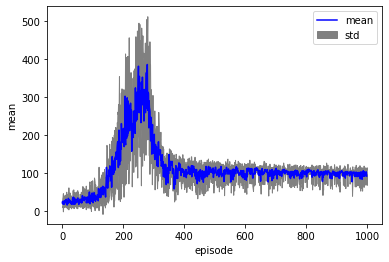

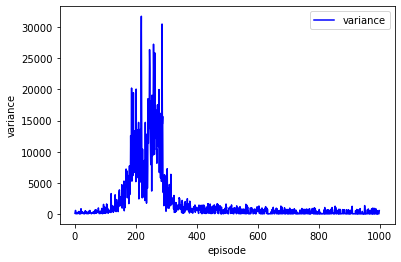

In [29]:
plt.figure()
std_low = np.asarray(mean4) - np.asarray(std4)
std_high = np.asarray(mean4) + np.asarray(std4)
plt.plot(mean4,c = 'b',label = 'mean' )
plt.fill_between(np.arange(0,len(mean3),1),std_low,std_high, color = 'gray',label = 'std')
plt.legend()
# plt.title('summing all the rewards along an episode')
plt.xlabel('episode')
plt.ylabel('mean')
plt.show()

plt.figure()
plt.plot(np.asarray(std4)**2,c = 'b', label = 'variance')
# plt.title('variance en fonction de l\'iteration')
plt.legend()
plt.xlabel('episode')
plt.ylabel('variance')
plt.show()

Loading and saving a network or a BBRL agent can easily be performed using `agent.save(filename)` and `agent.load(filename)`.